                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 29 02:08:40 PM: Your problem has 8220 variables, 6726 constraints, and 0 parameters.
(CVXPY) Dec 29 02:08:40 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 29 02:08:40 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 29 02:08:40 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 29 02:08:40 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 29 02:08:41 PM: Compiling problem (target solver=GUROBI

(CVXPY) Dec 29 02:09:02 PM: Solver (including time spent in interface) took 1.512e+01 seconds
Optimal Total Cost: $187929.25


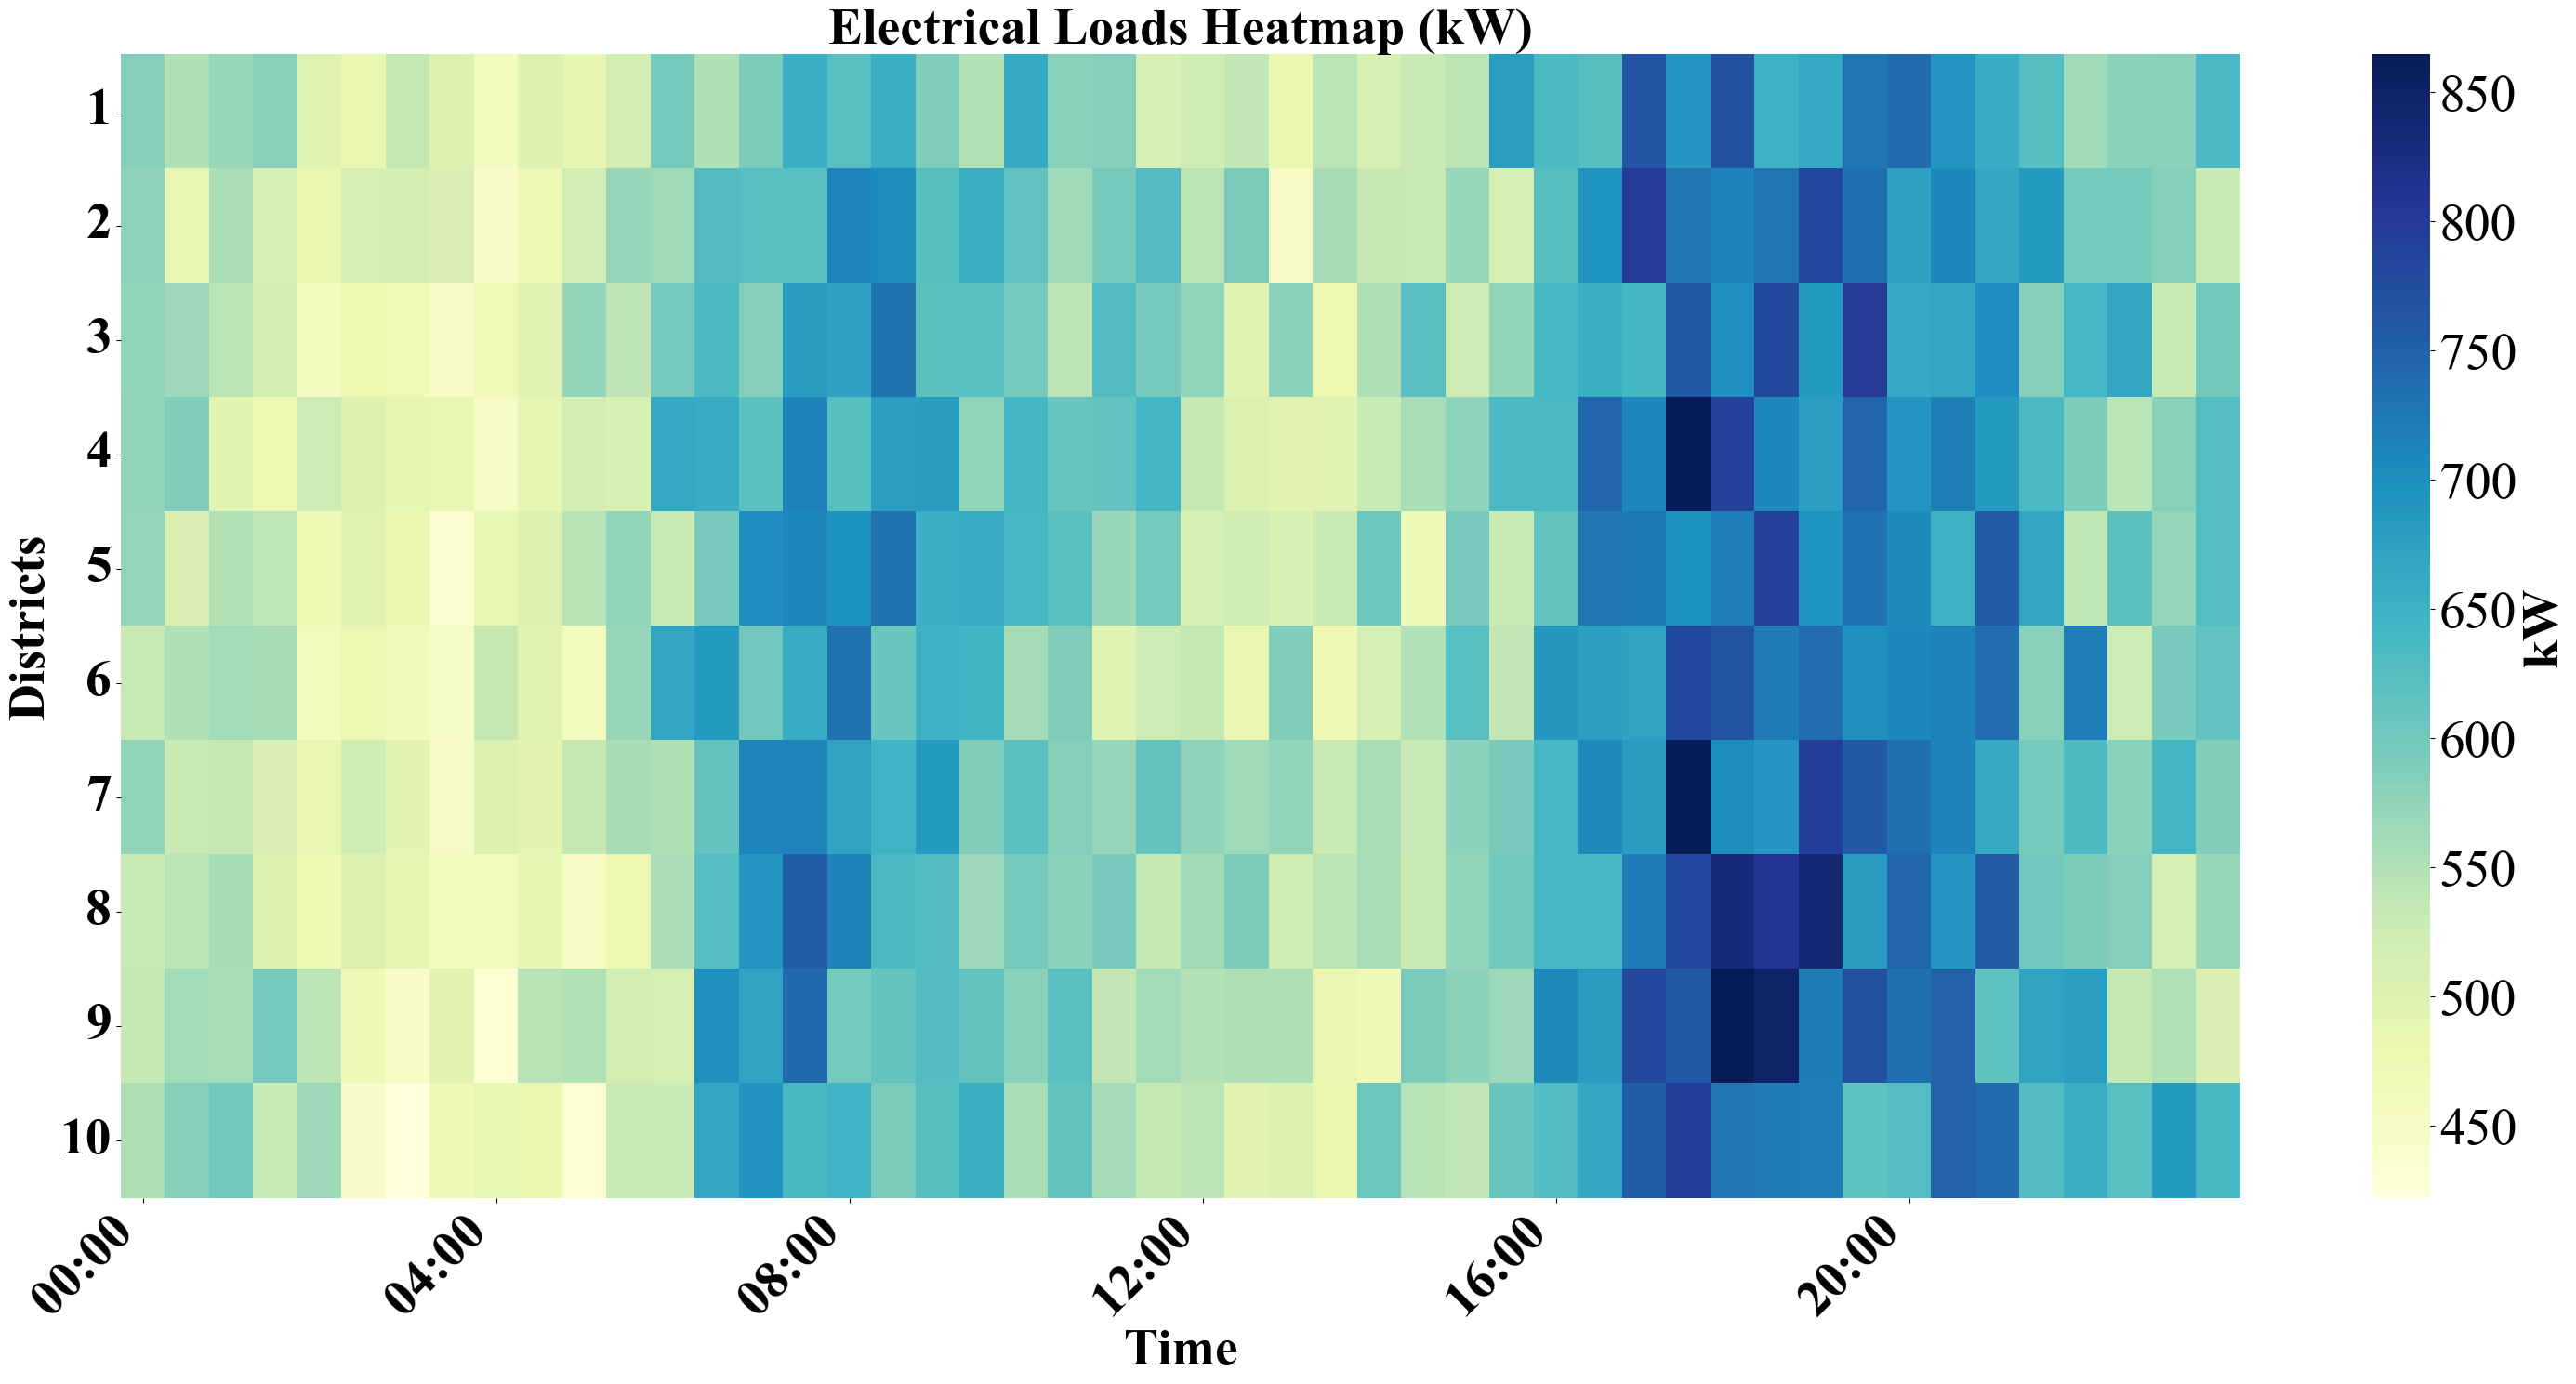

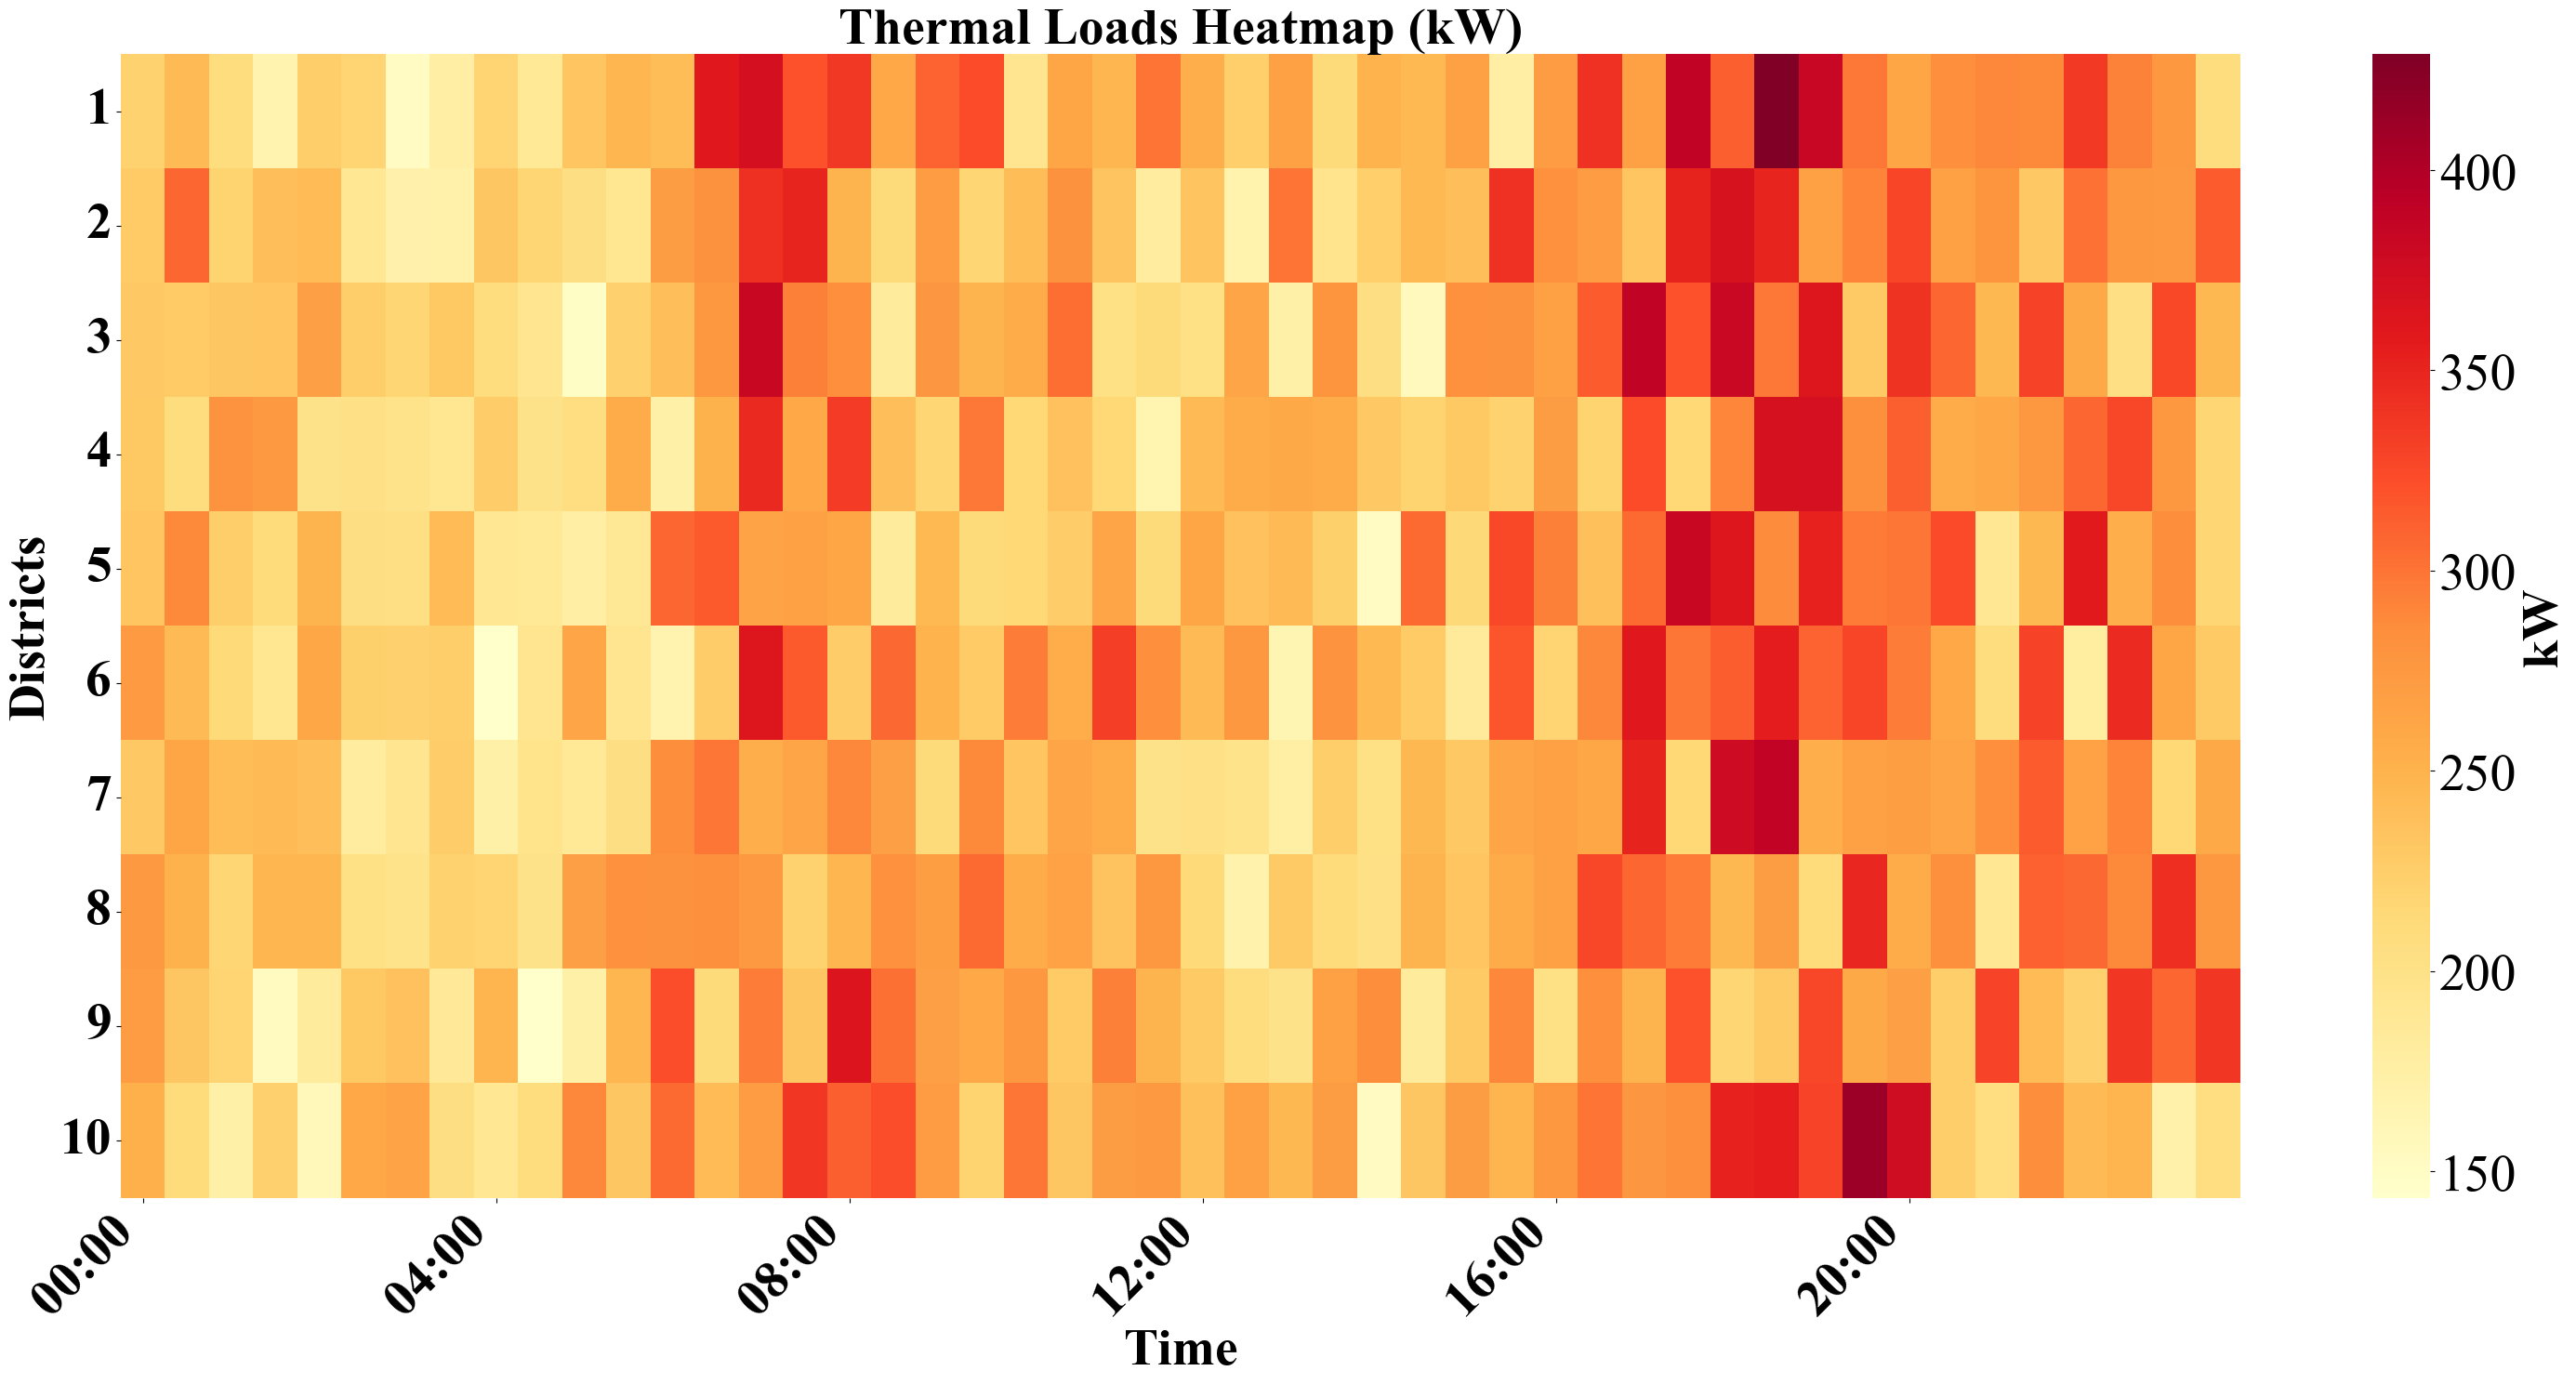

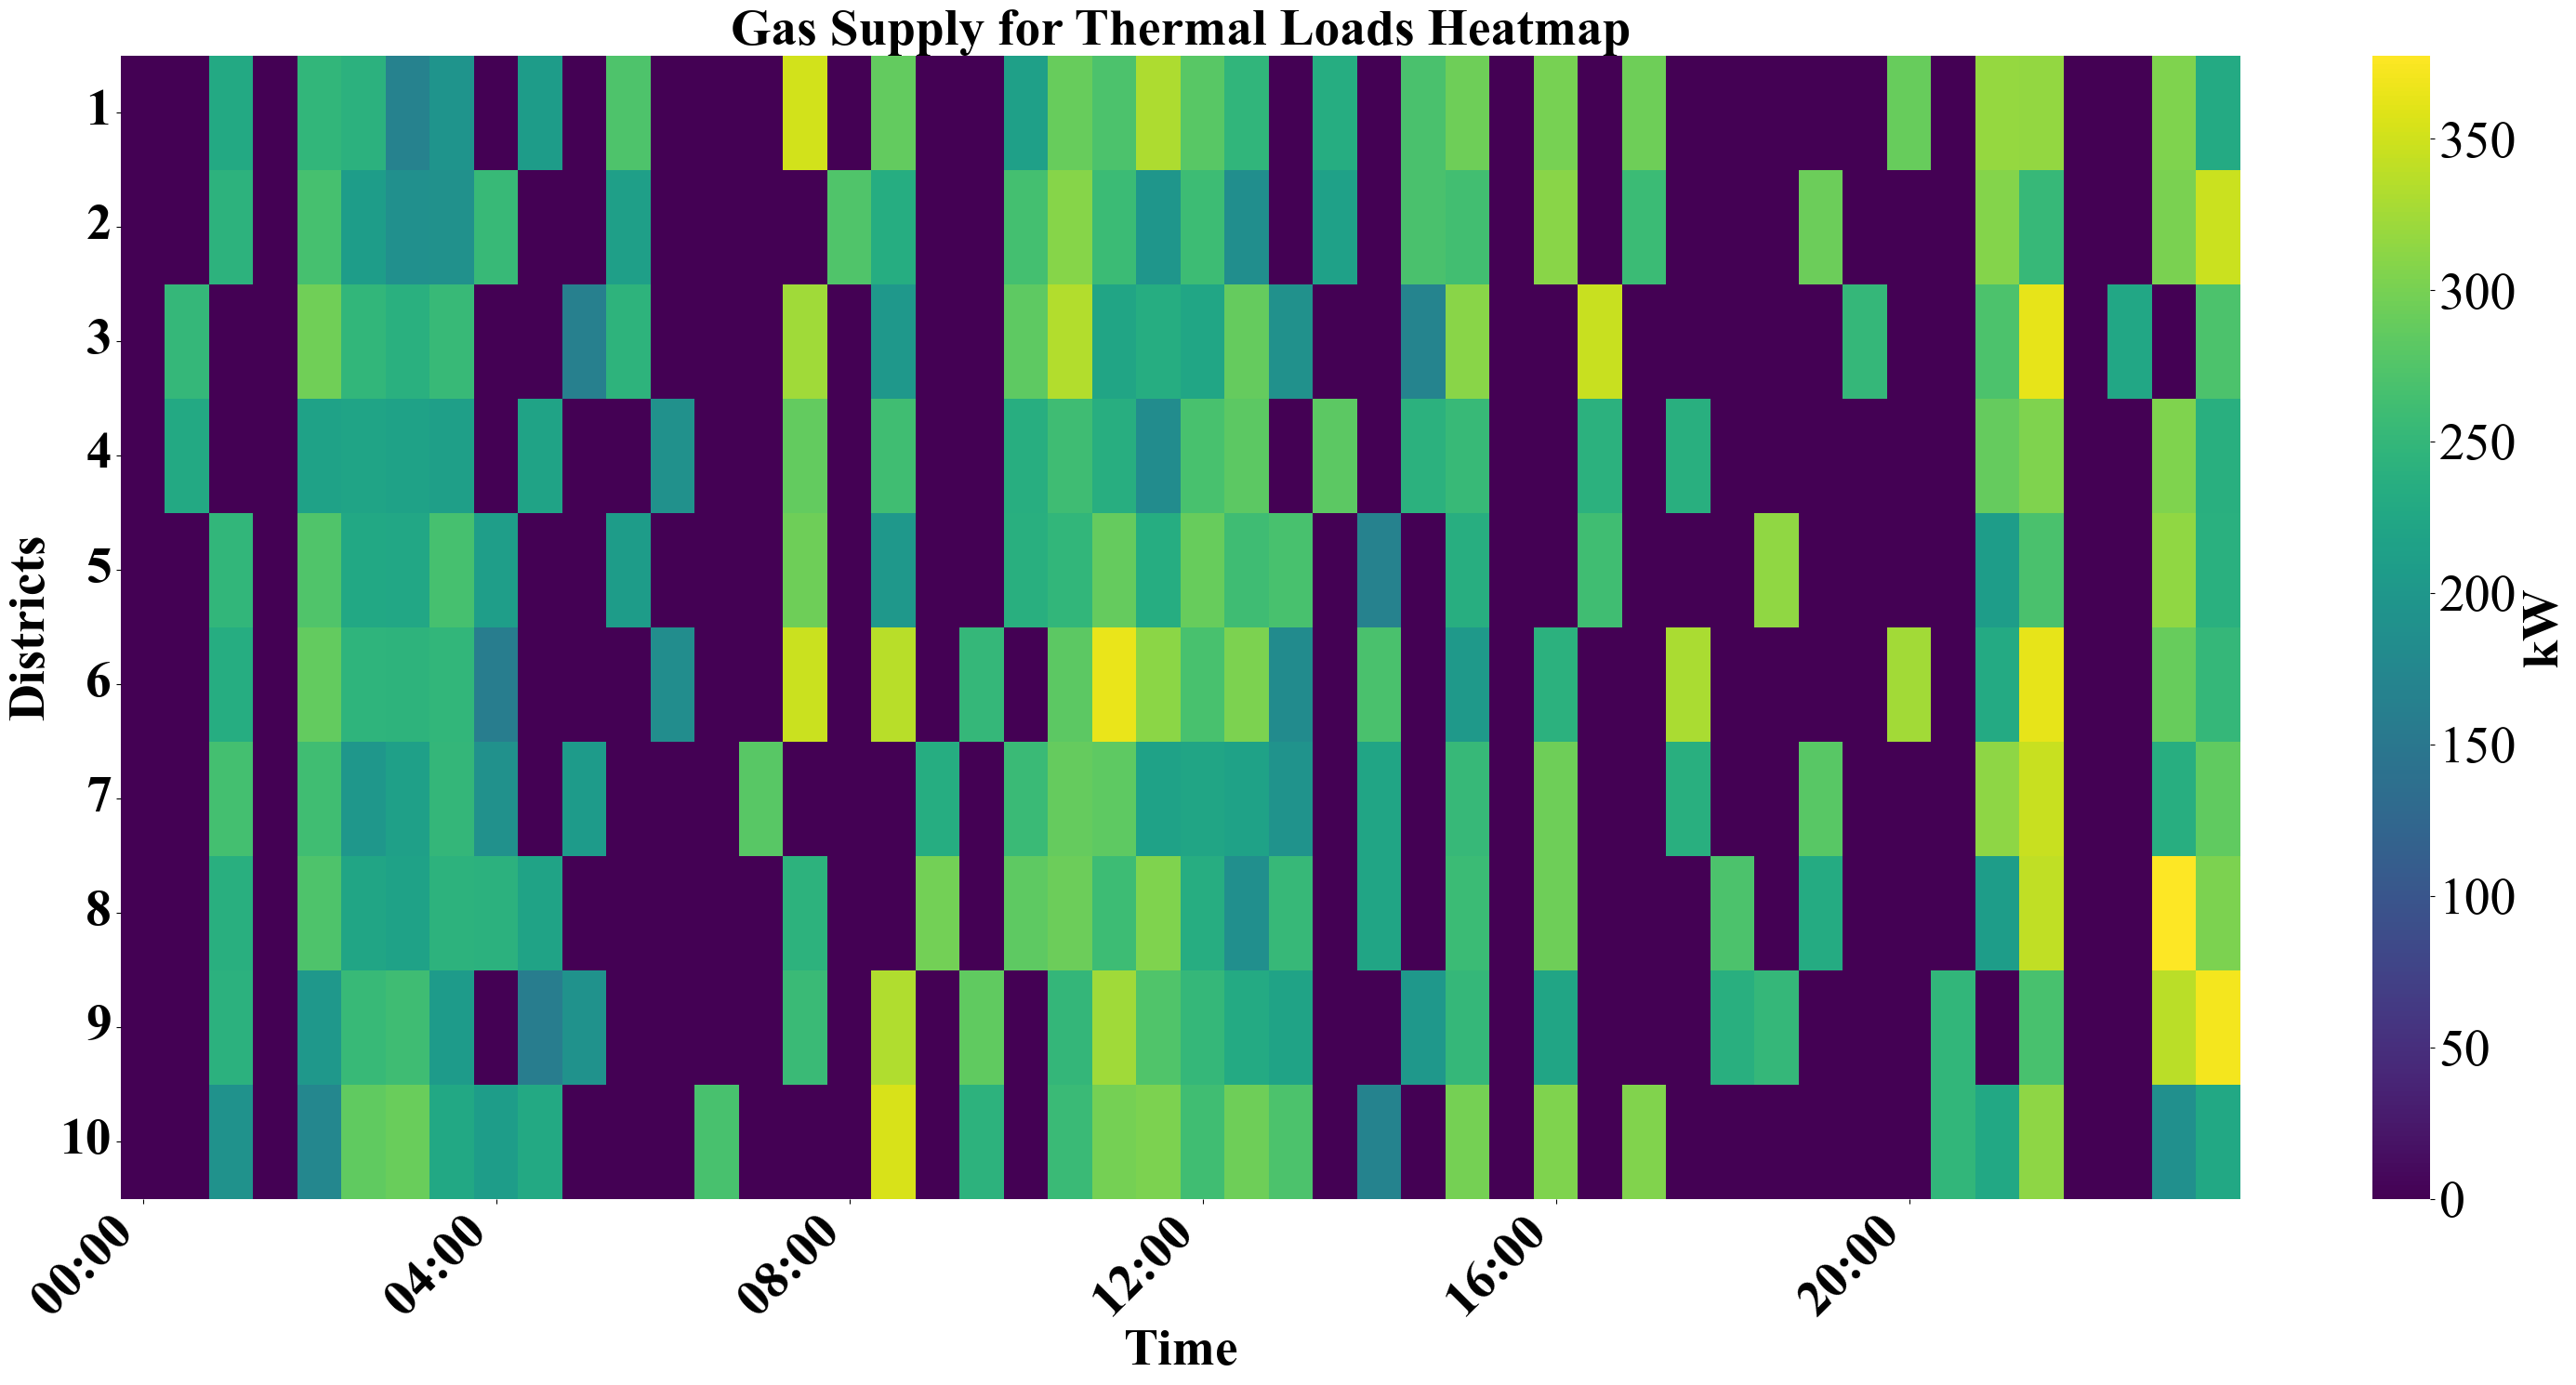

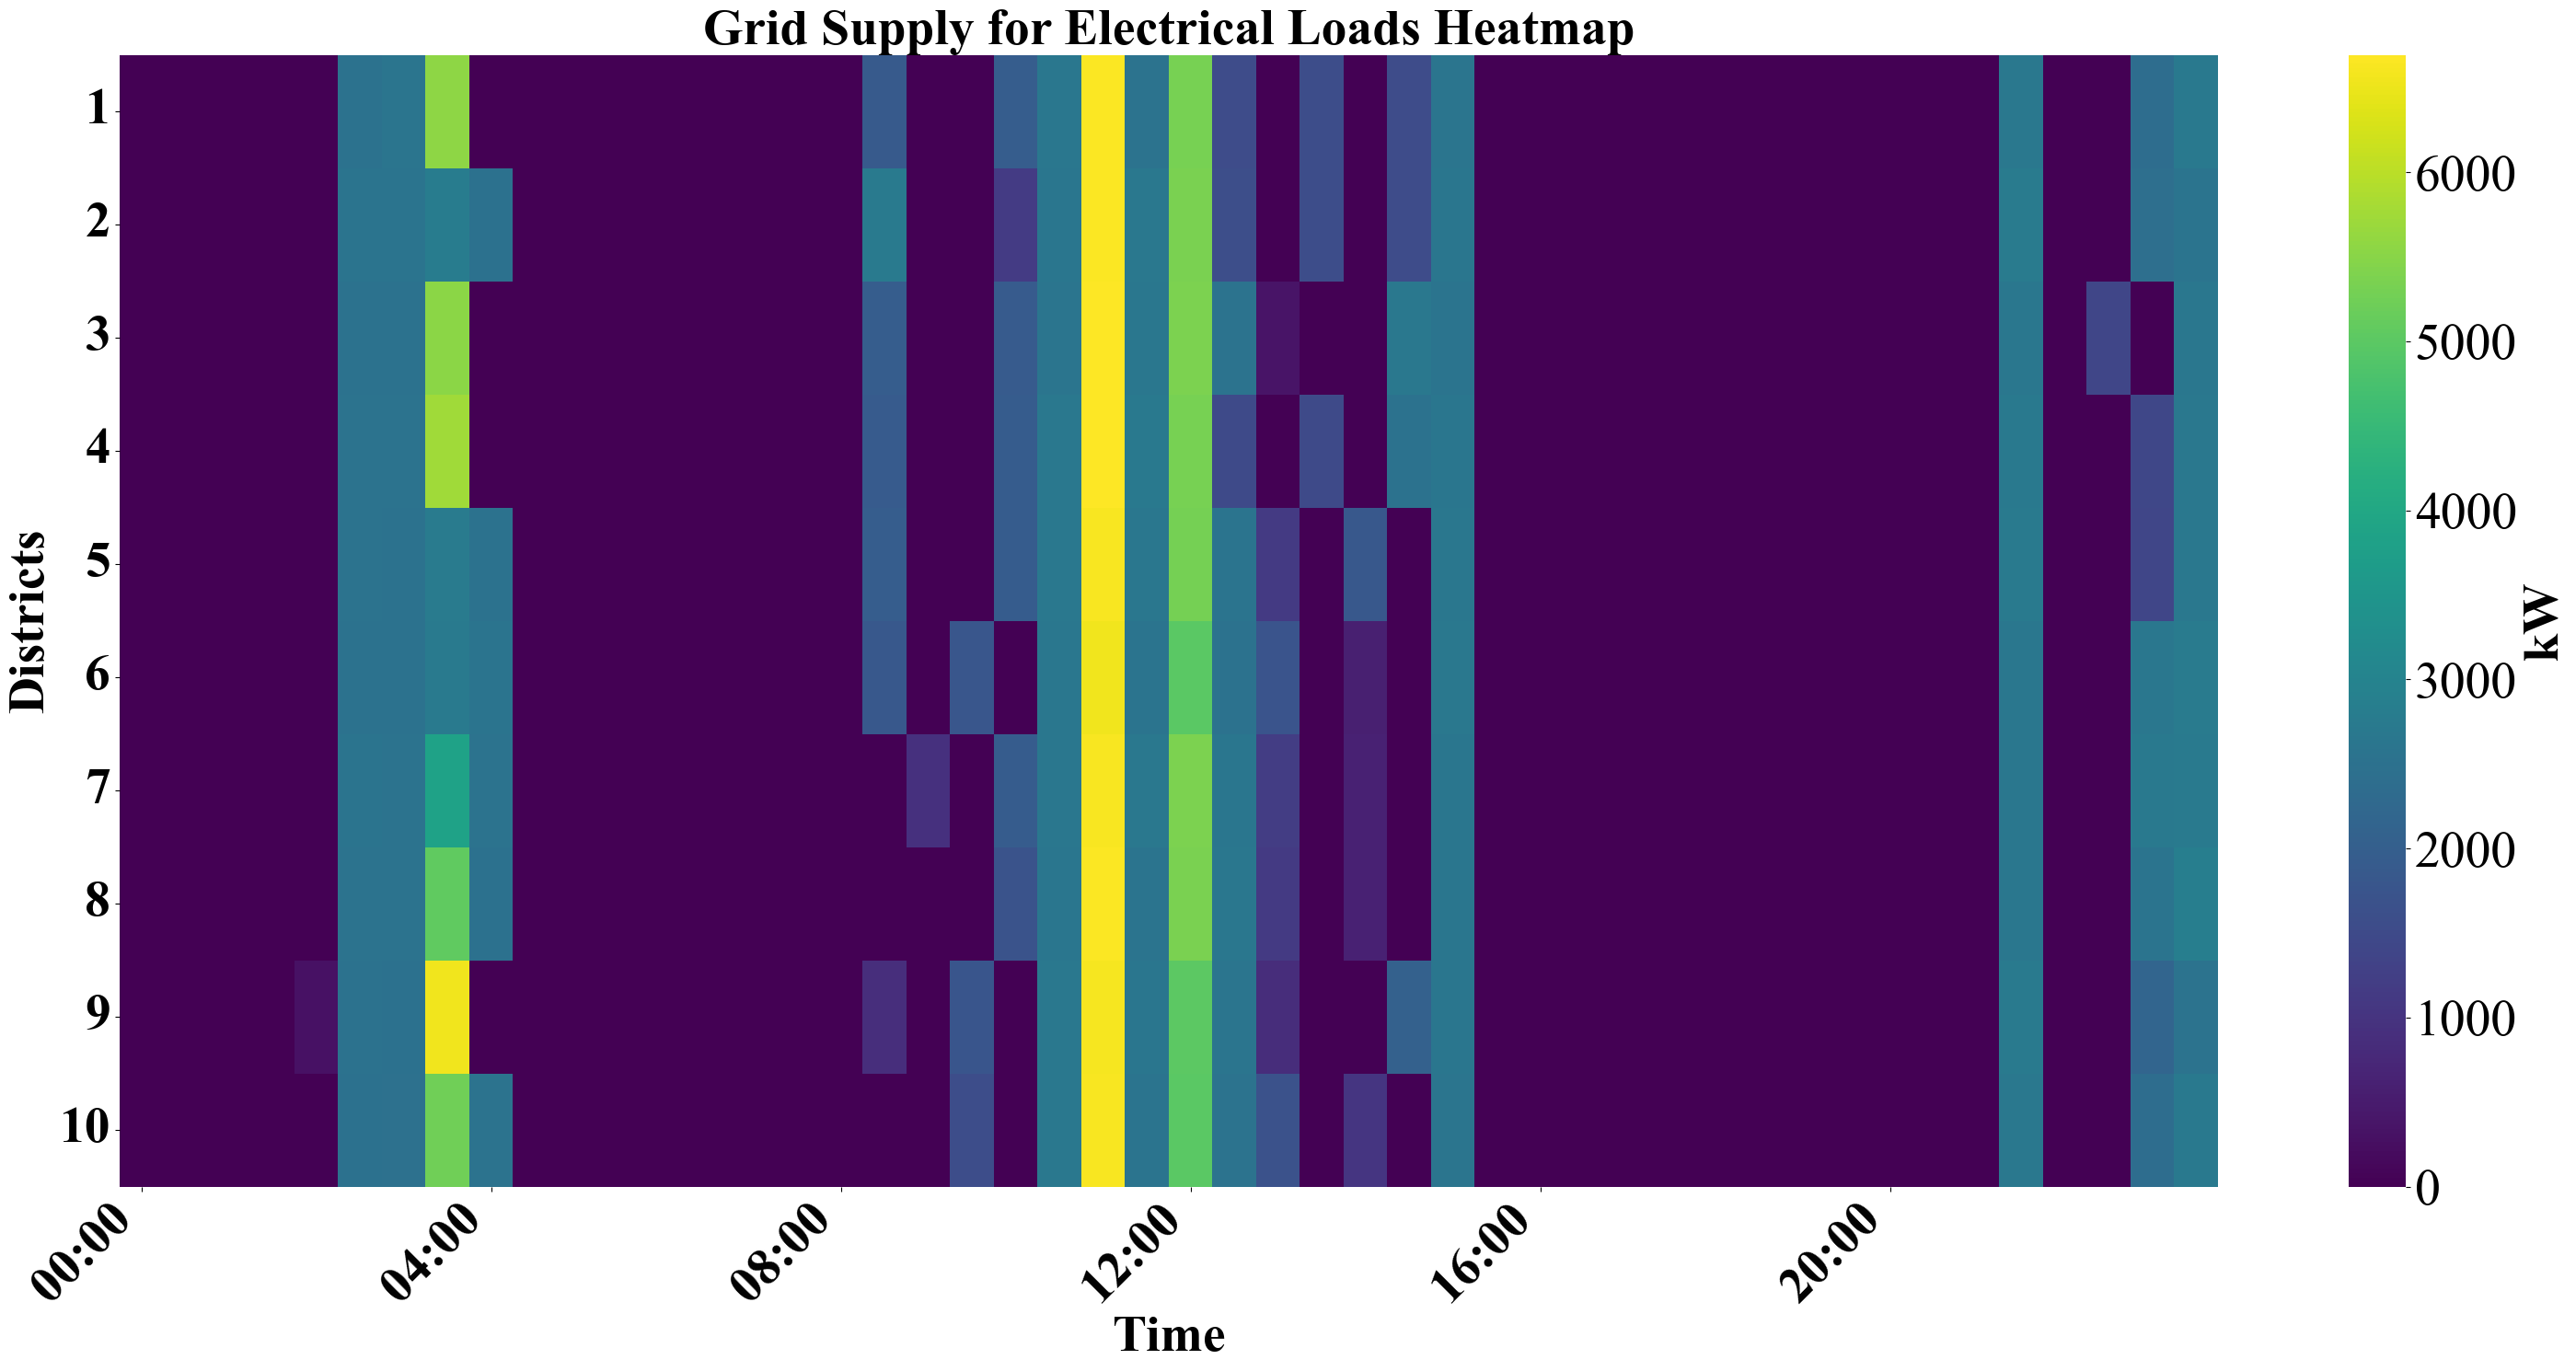

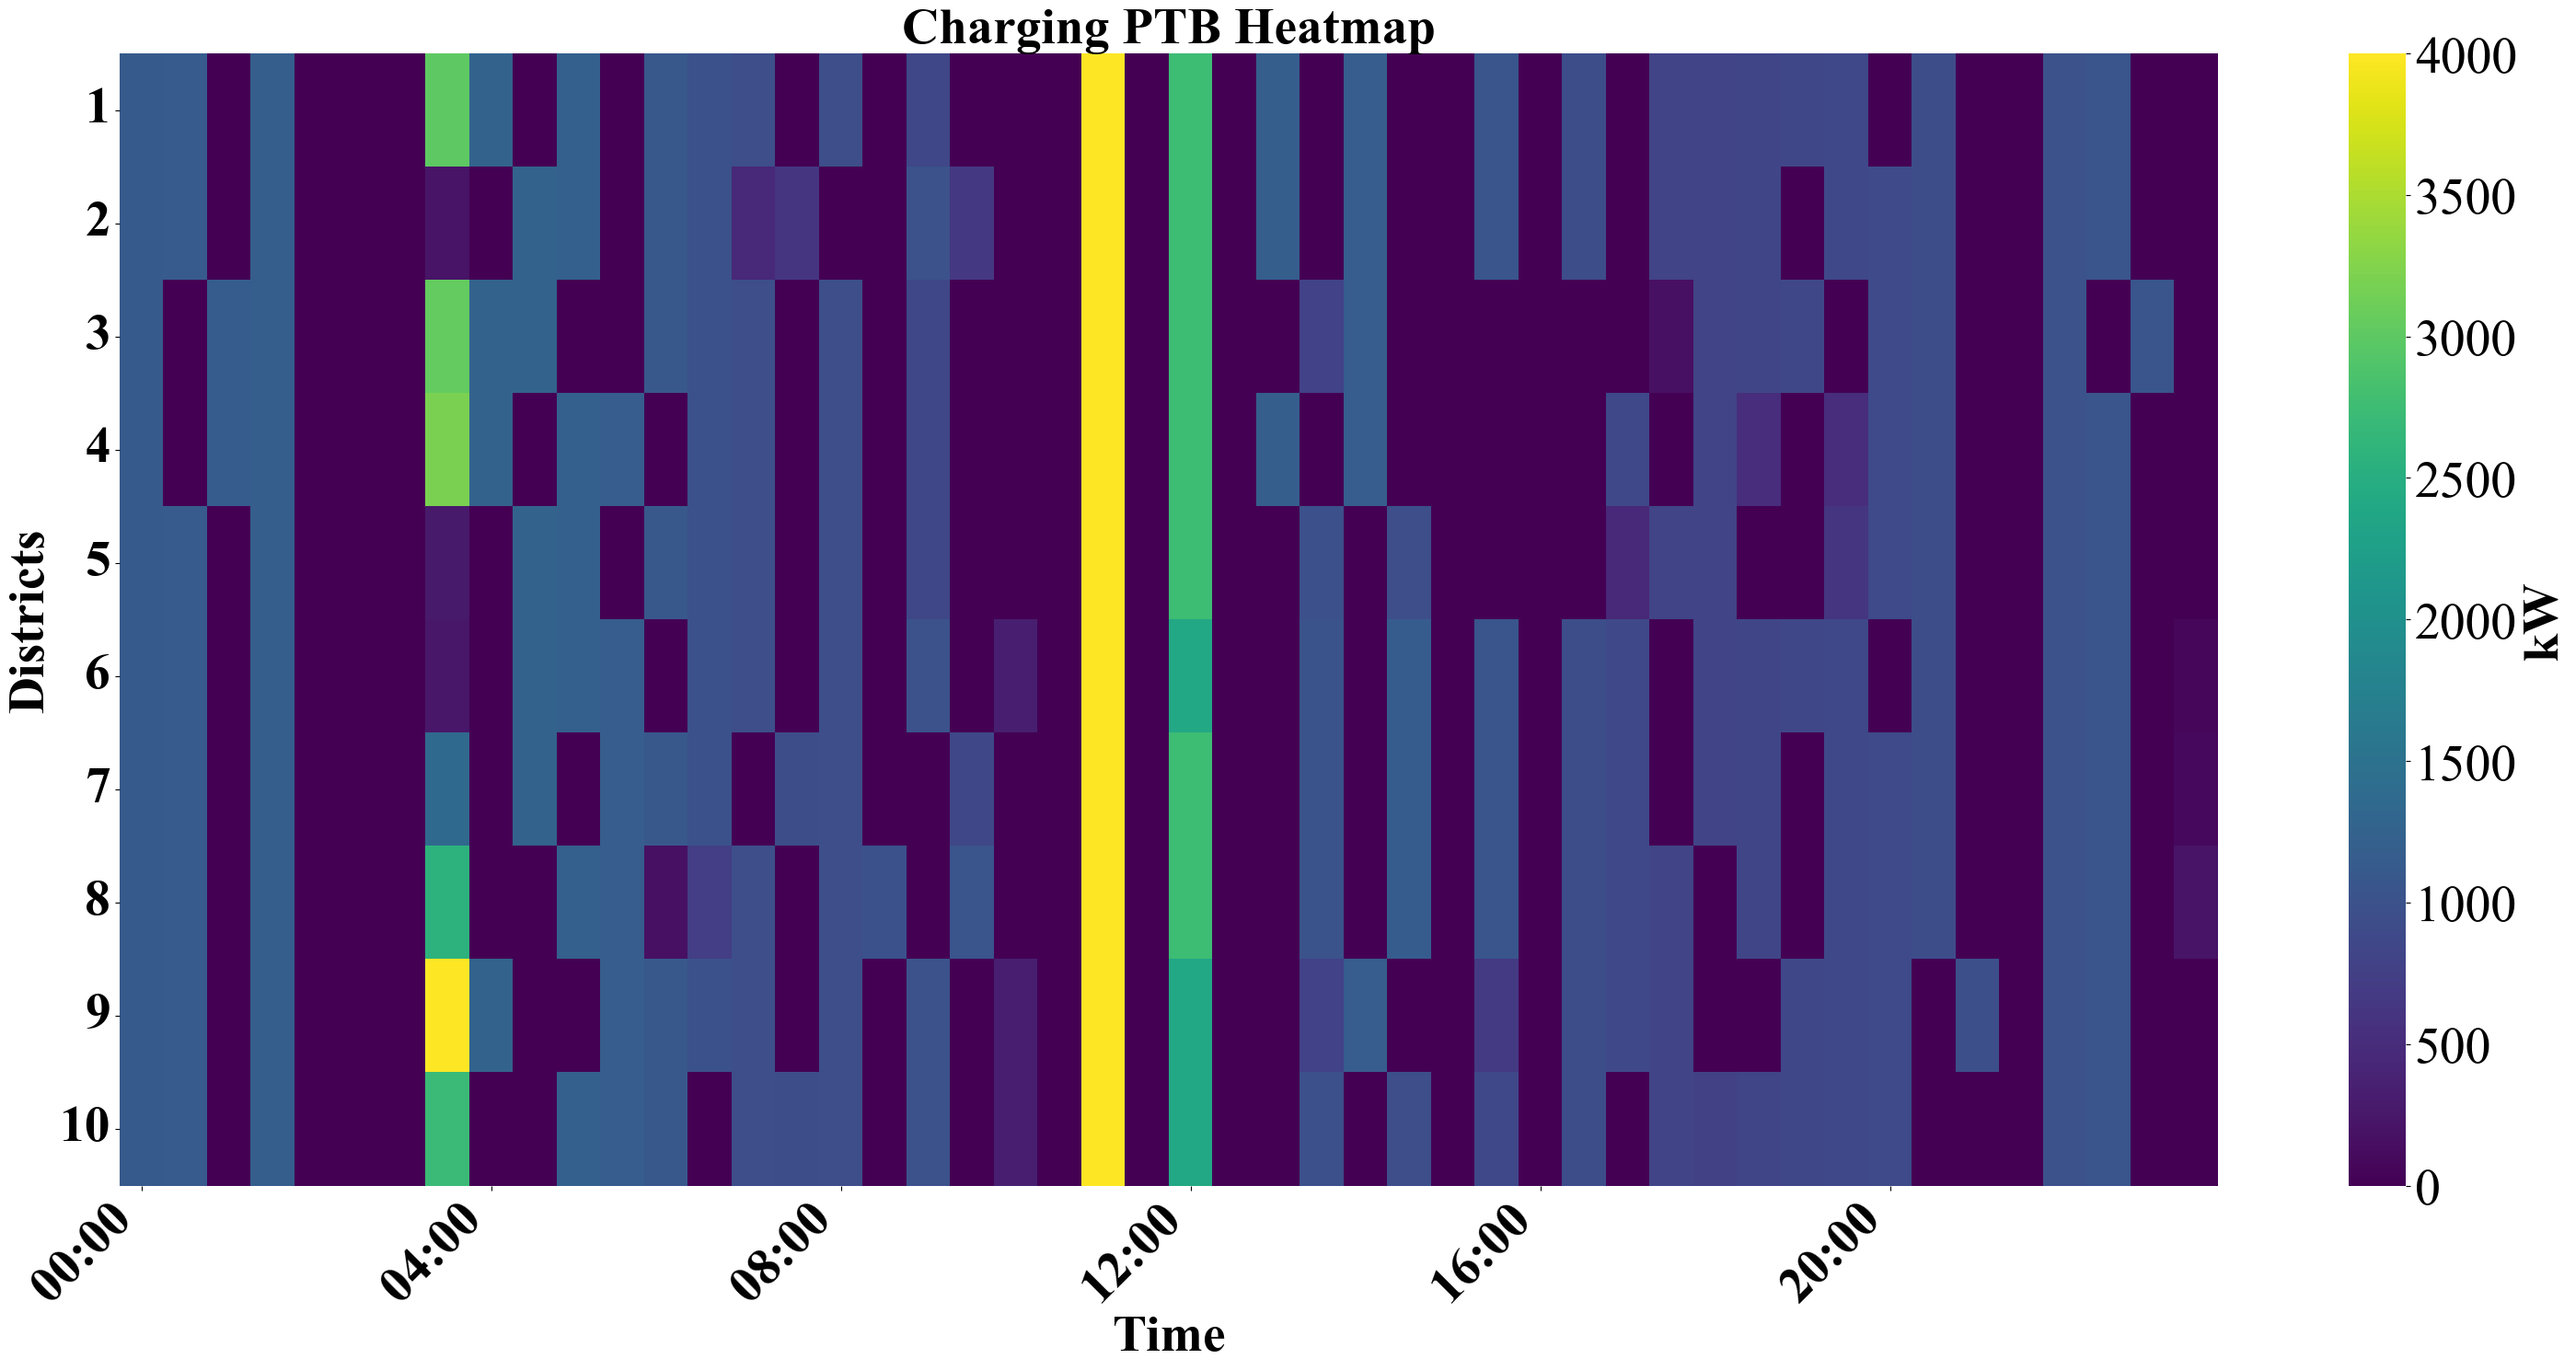

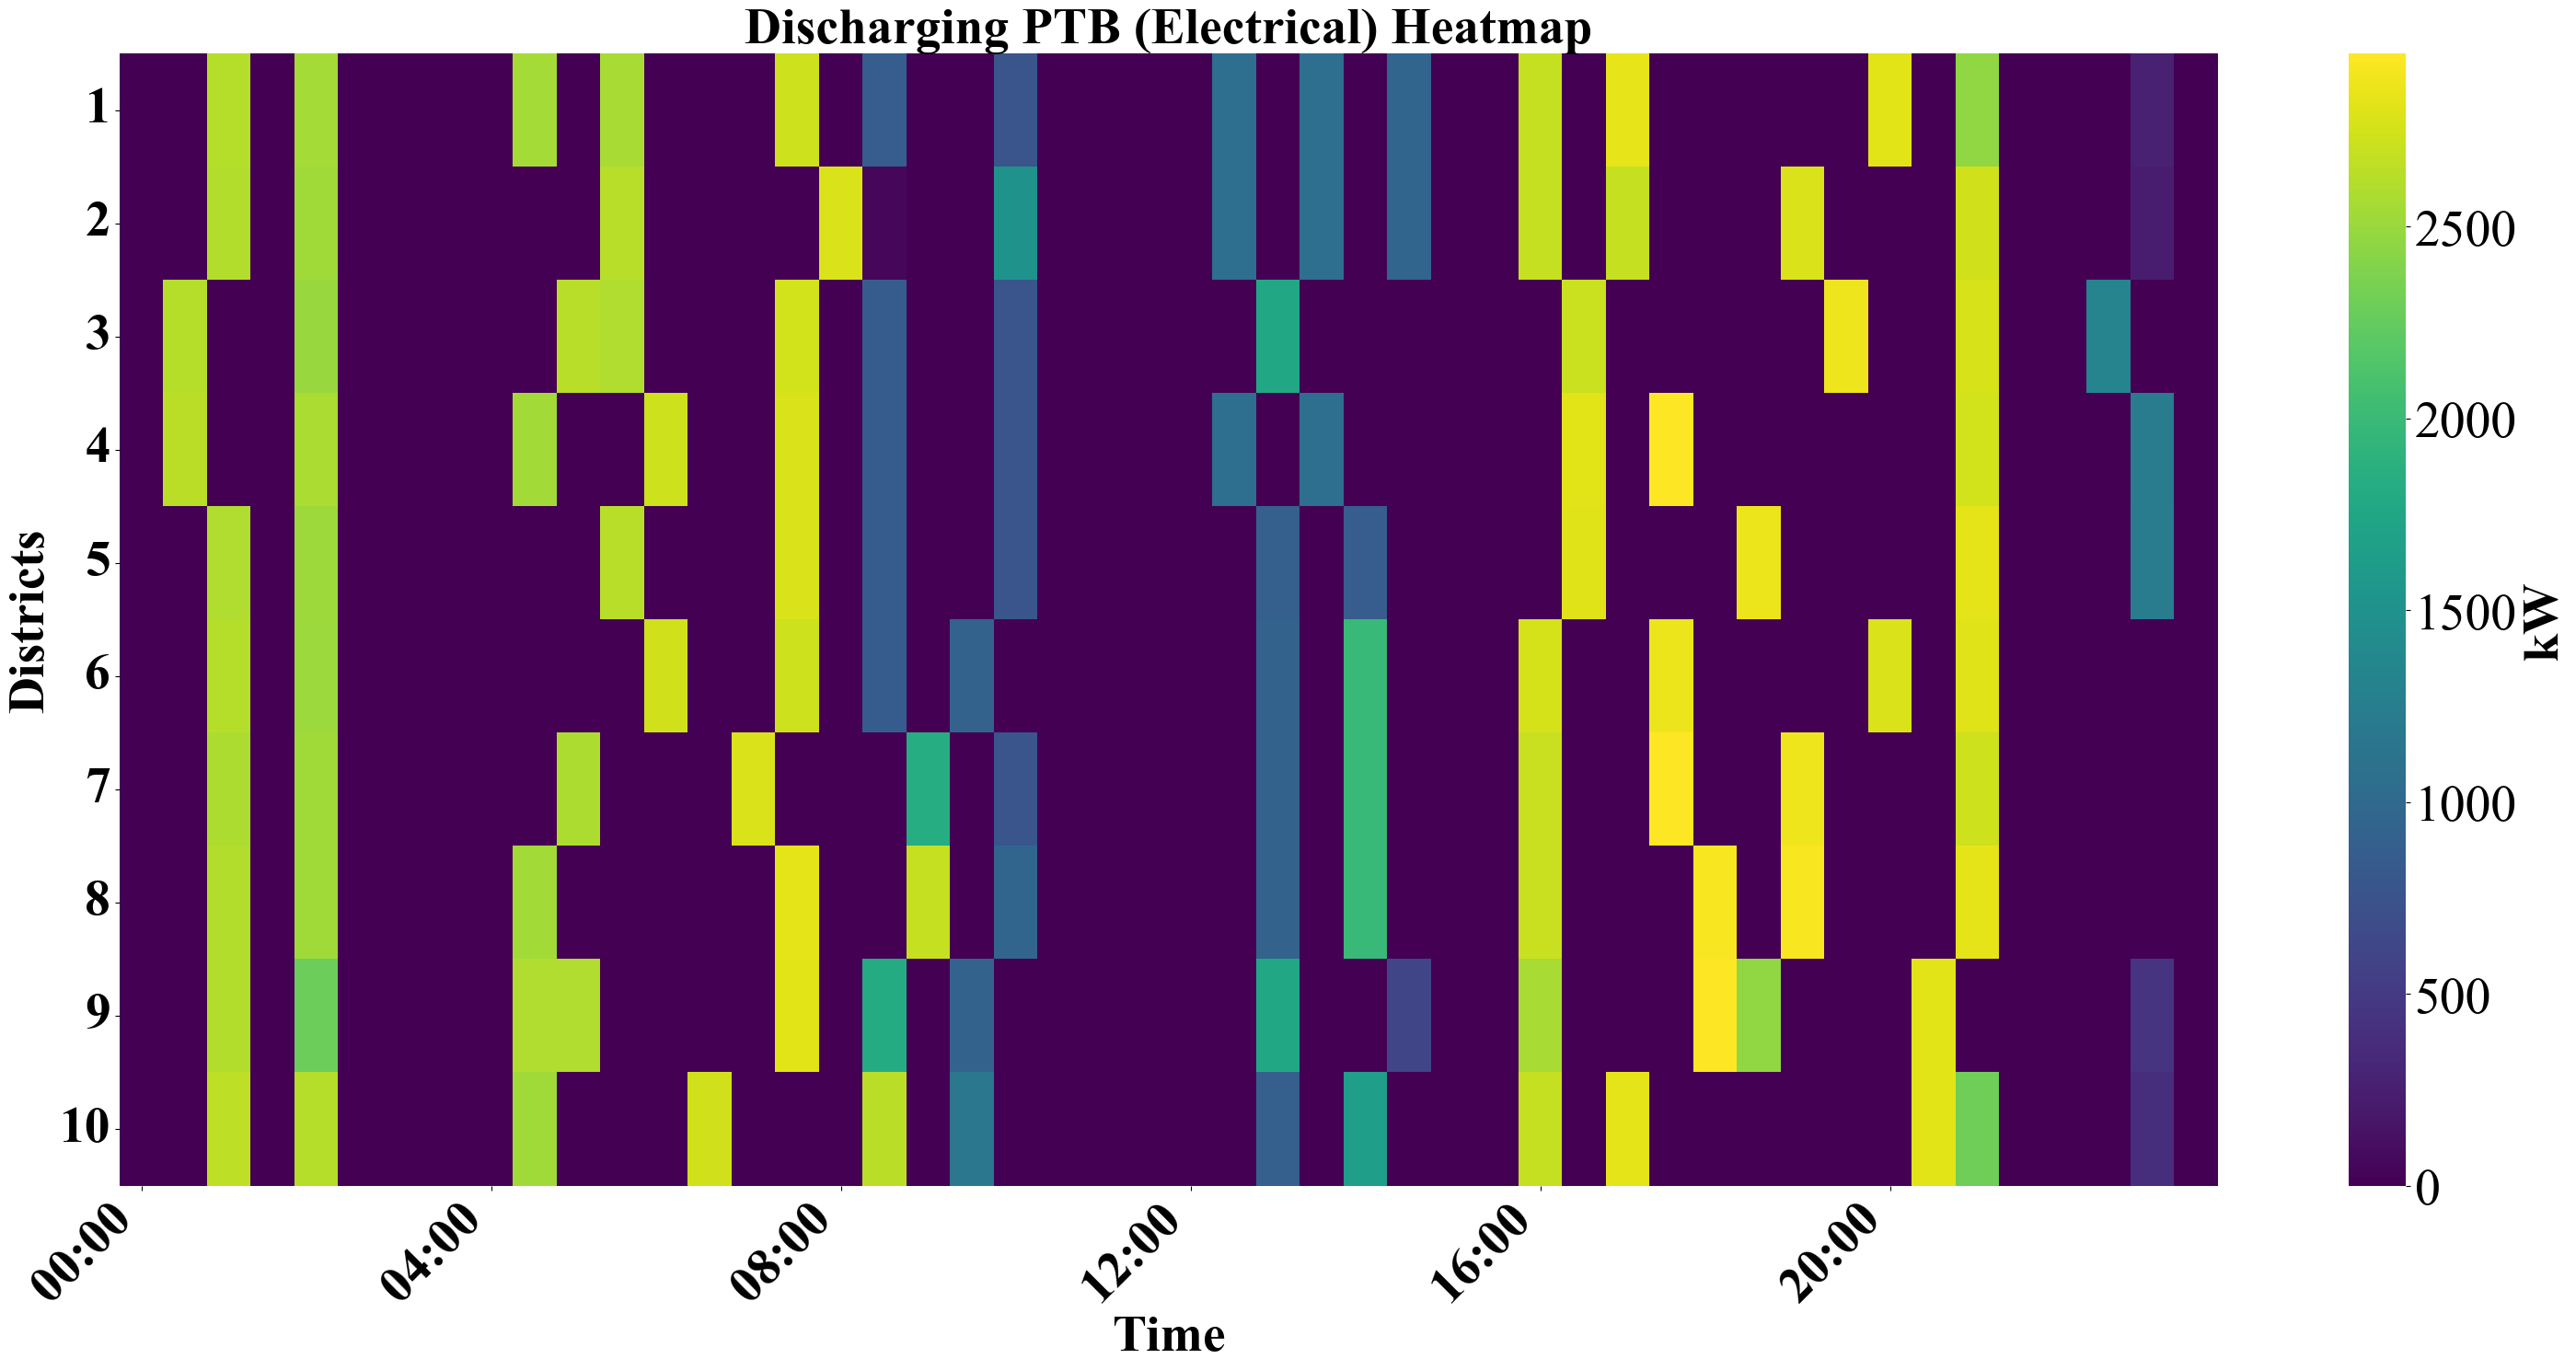

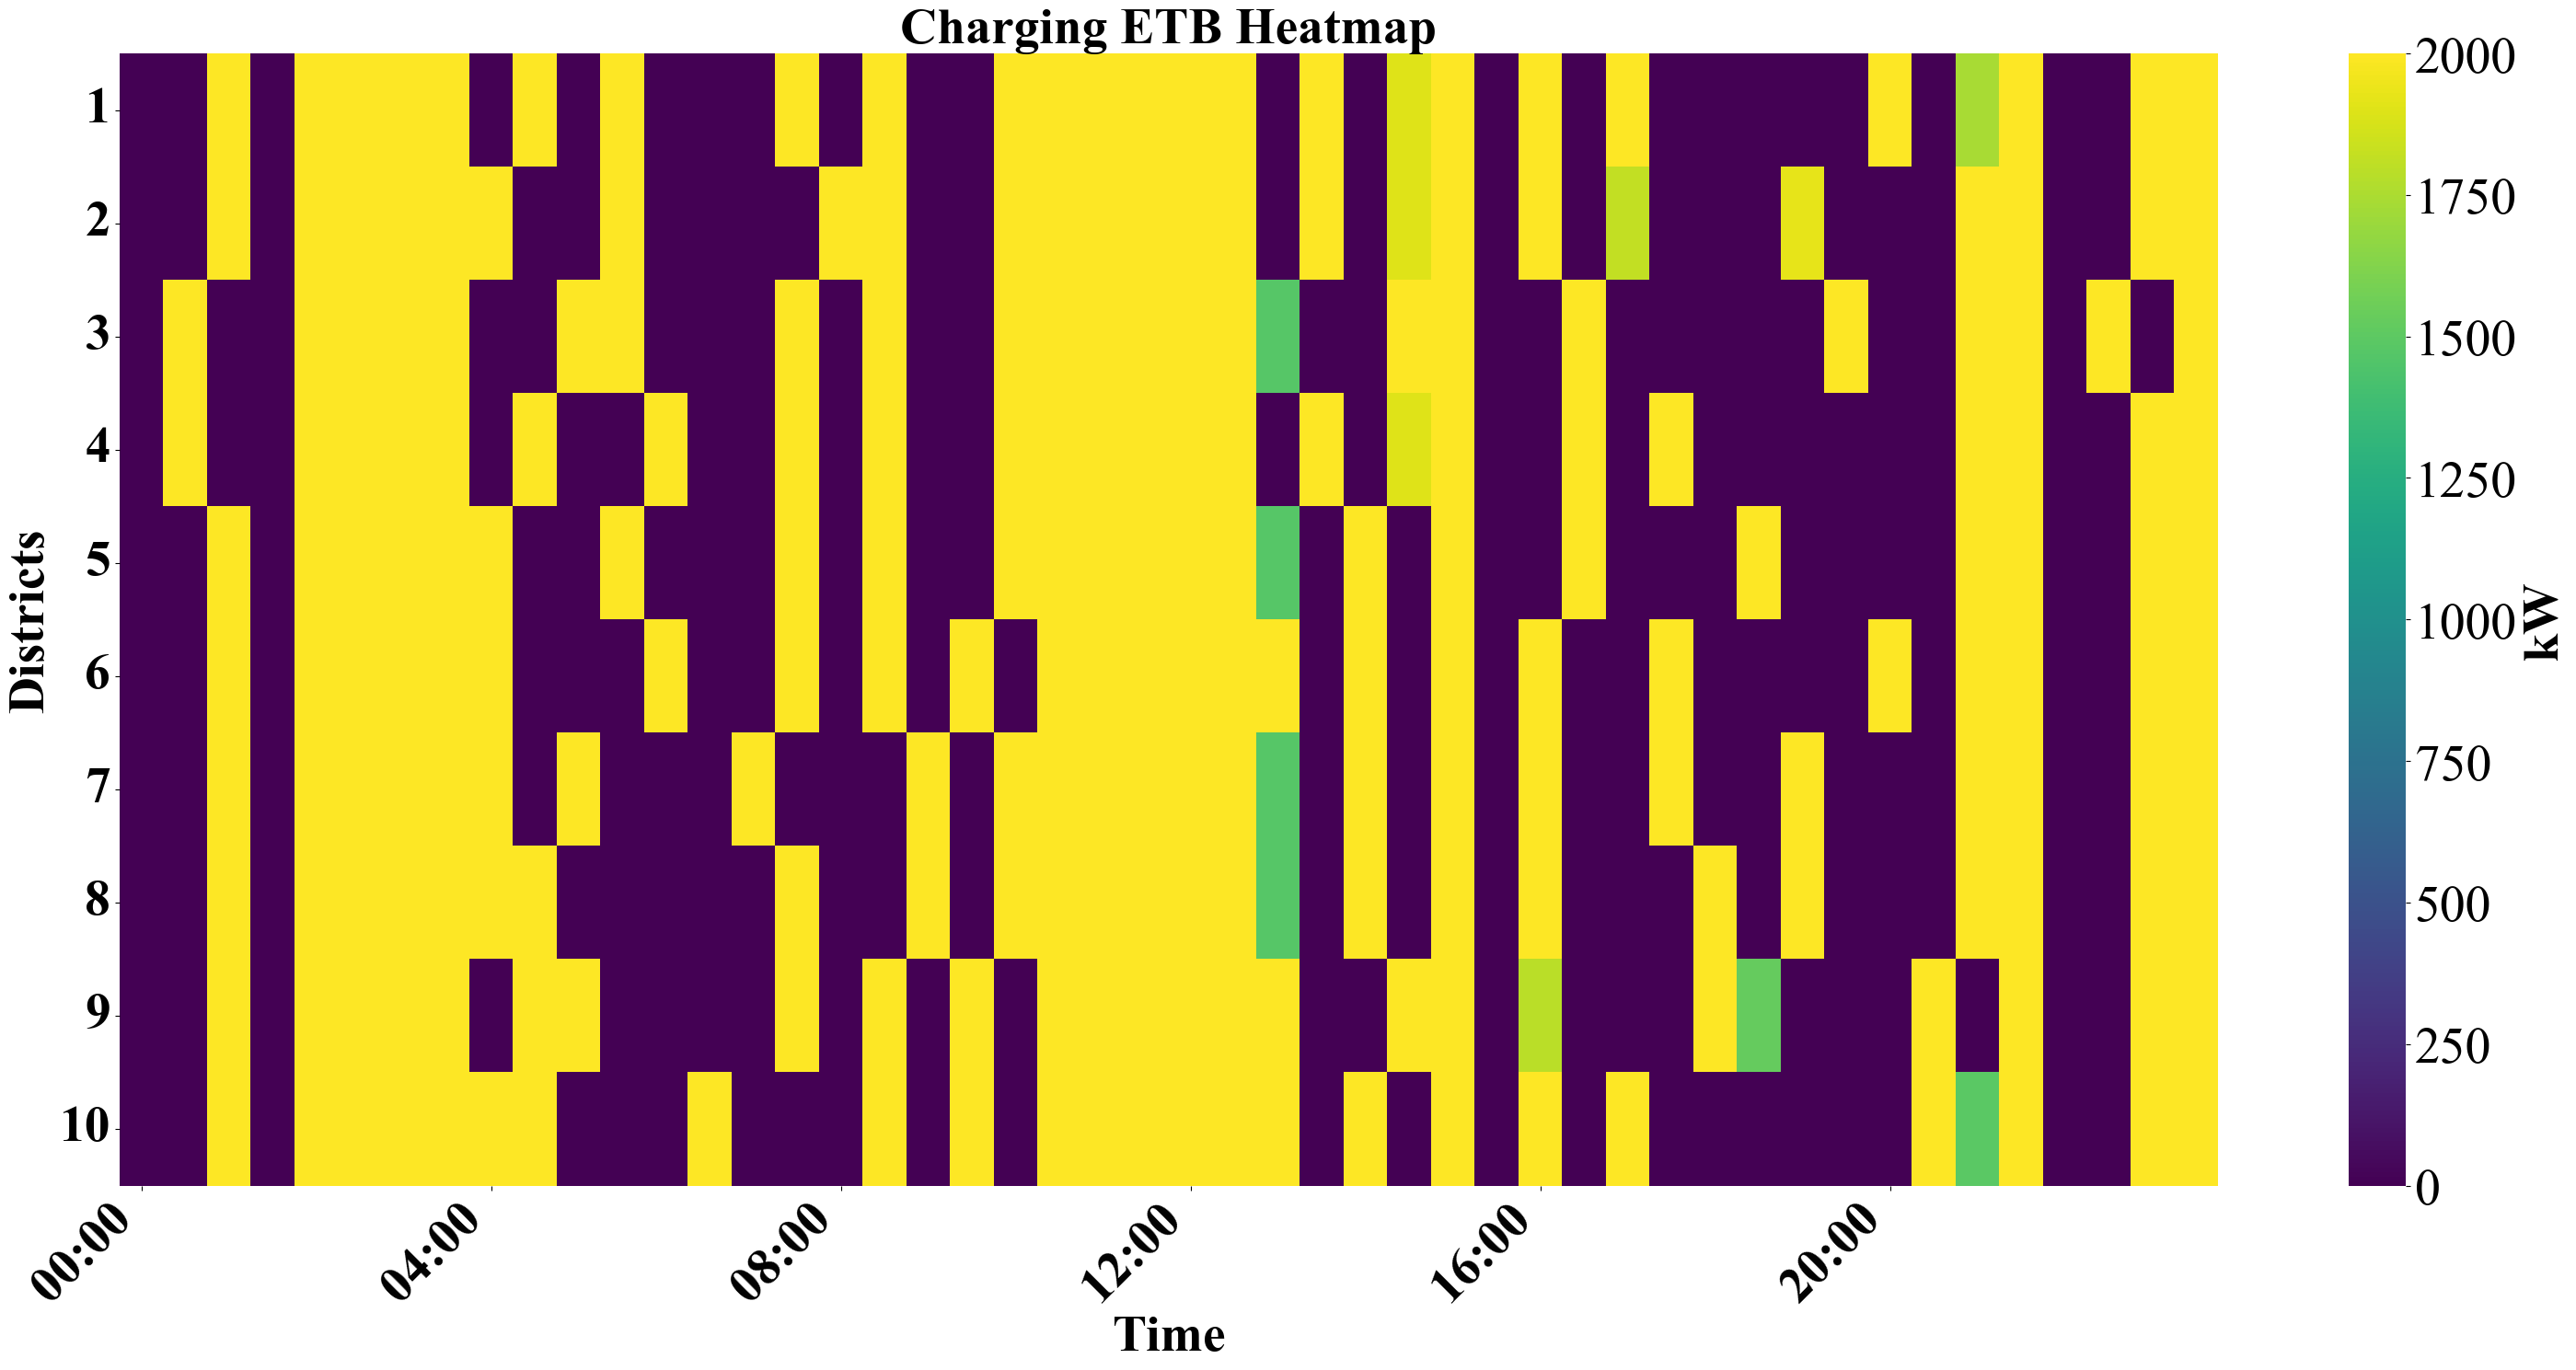

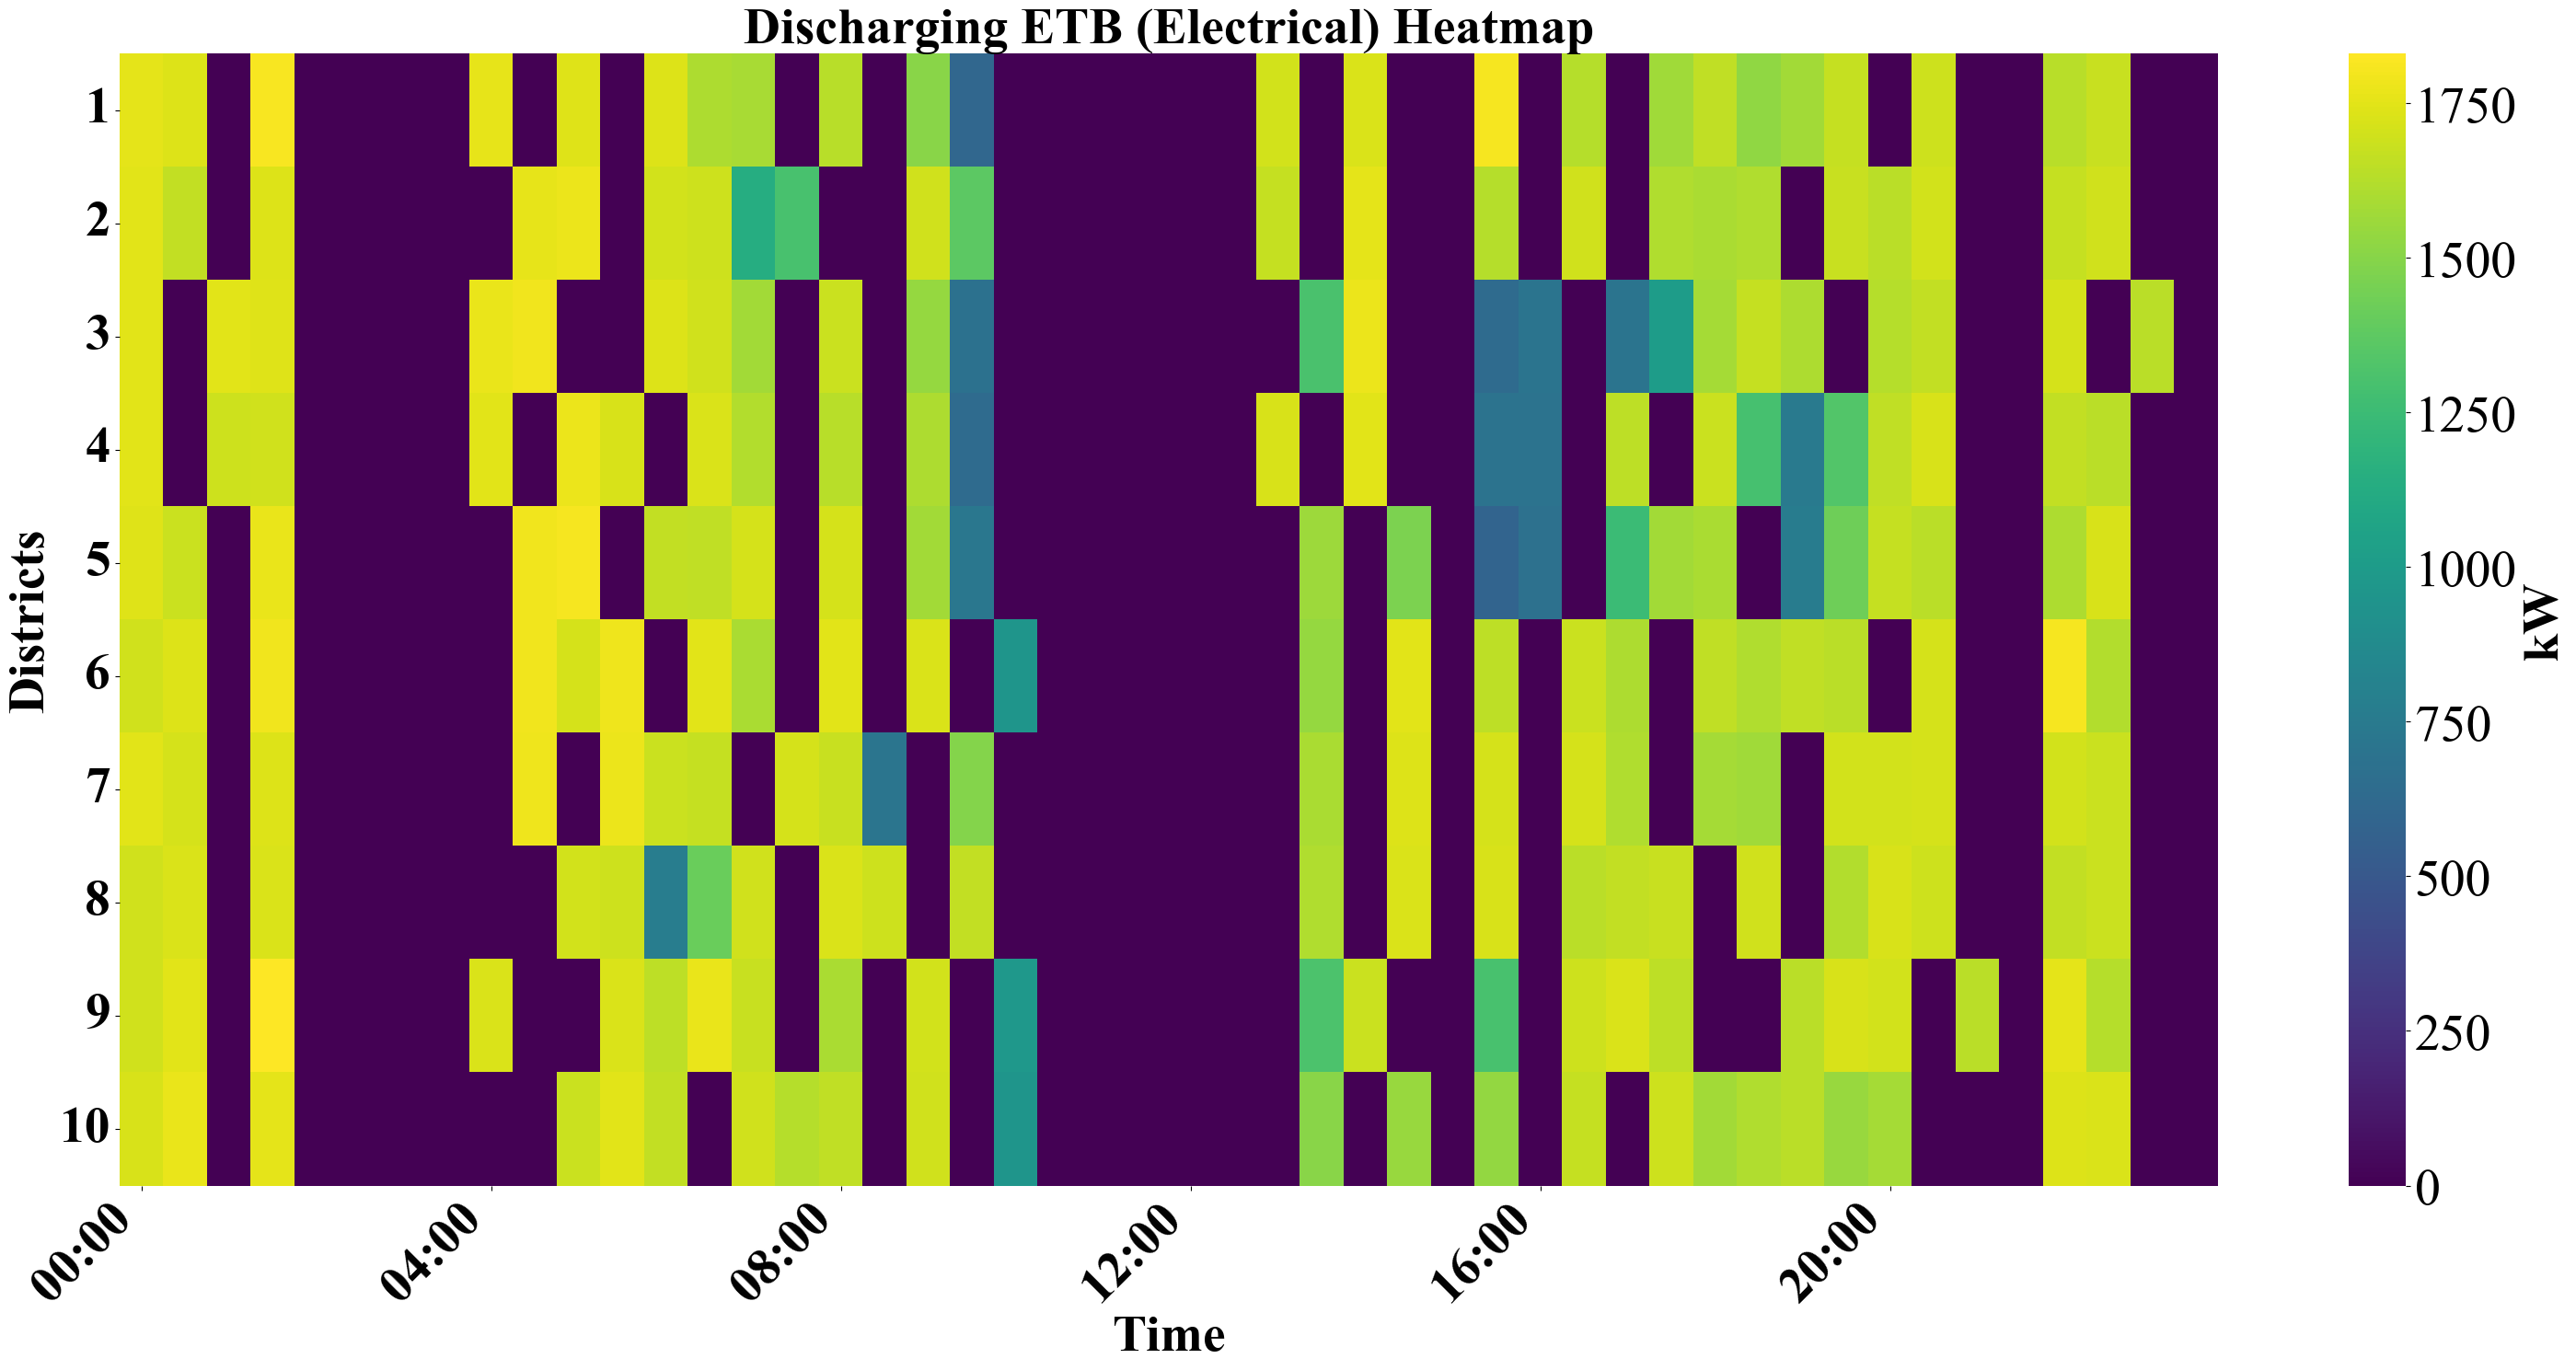

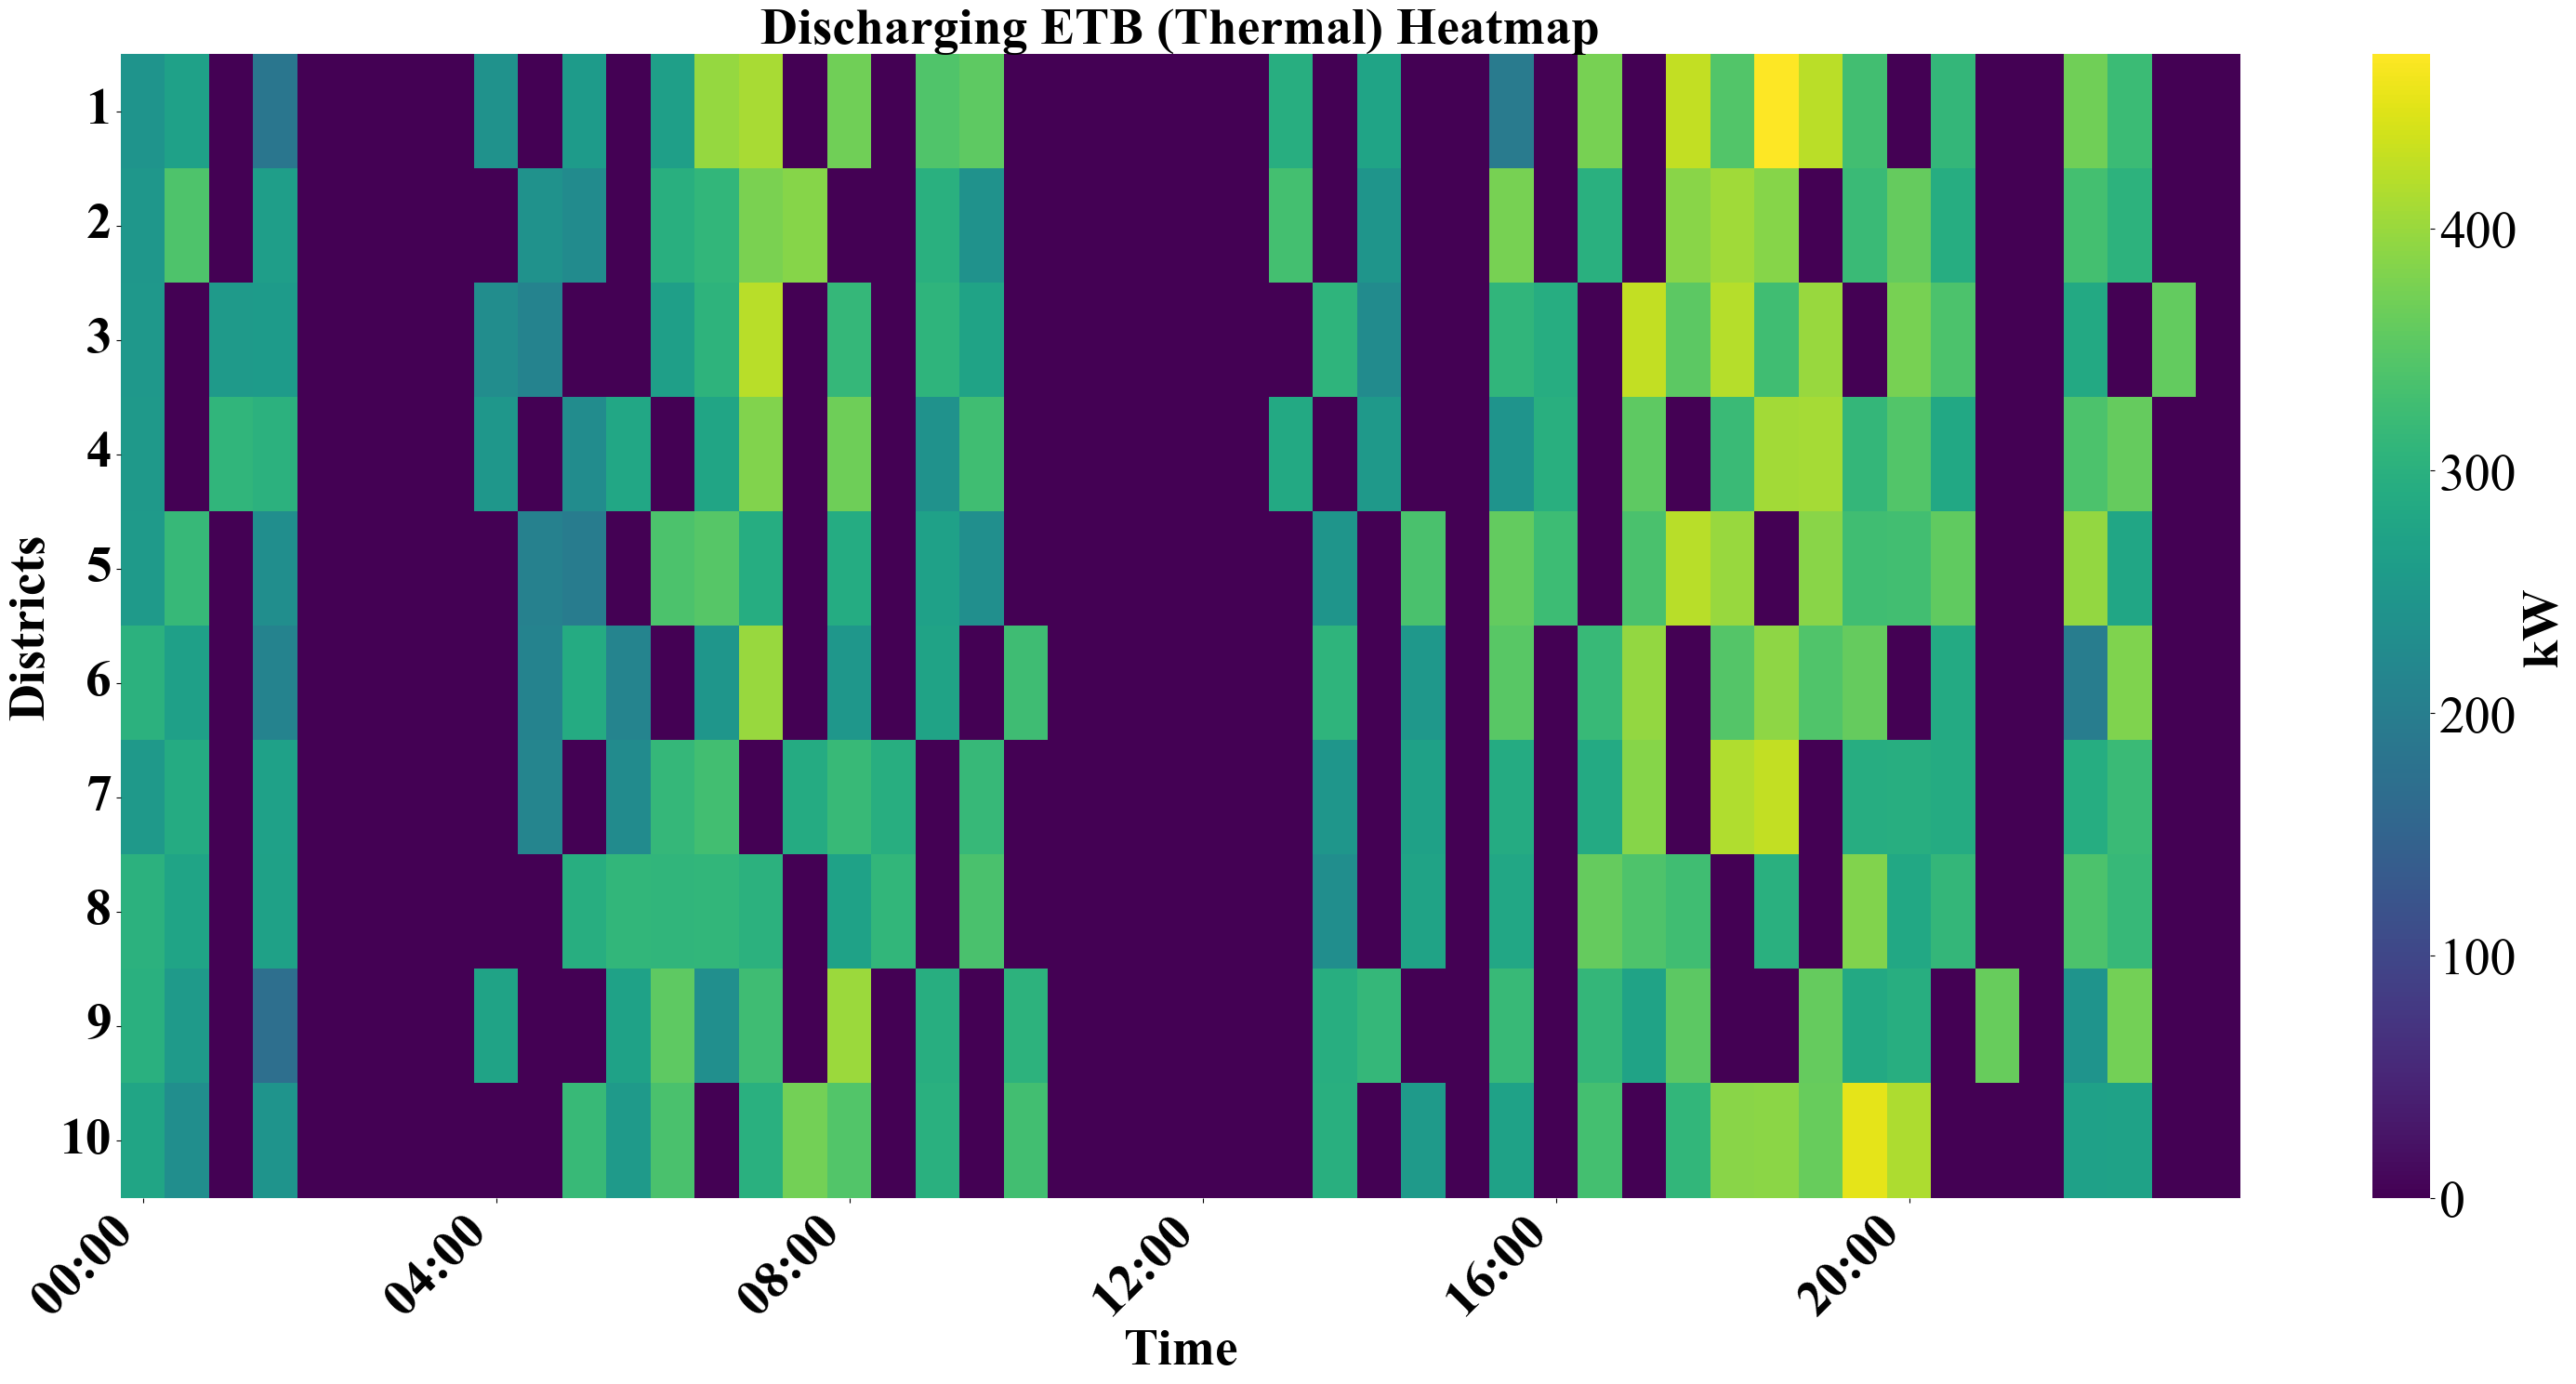

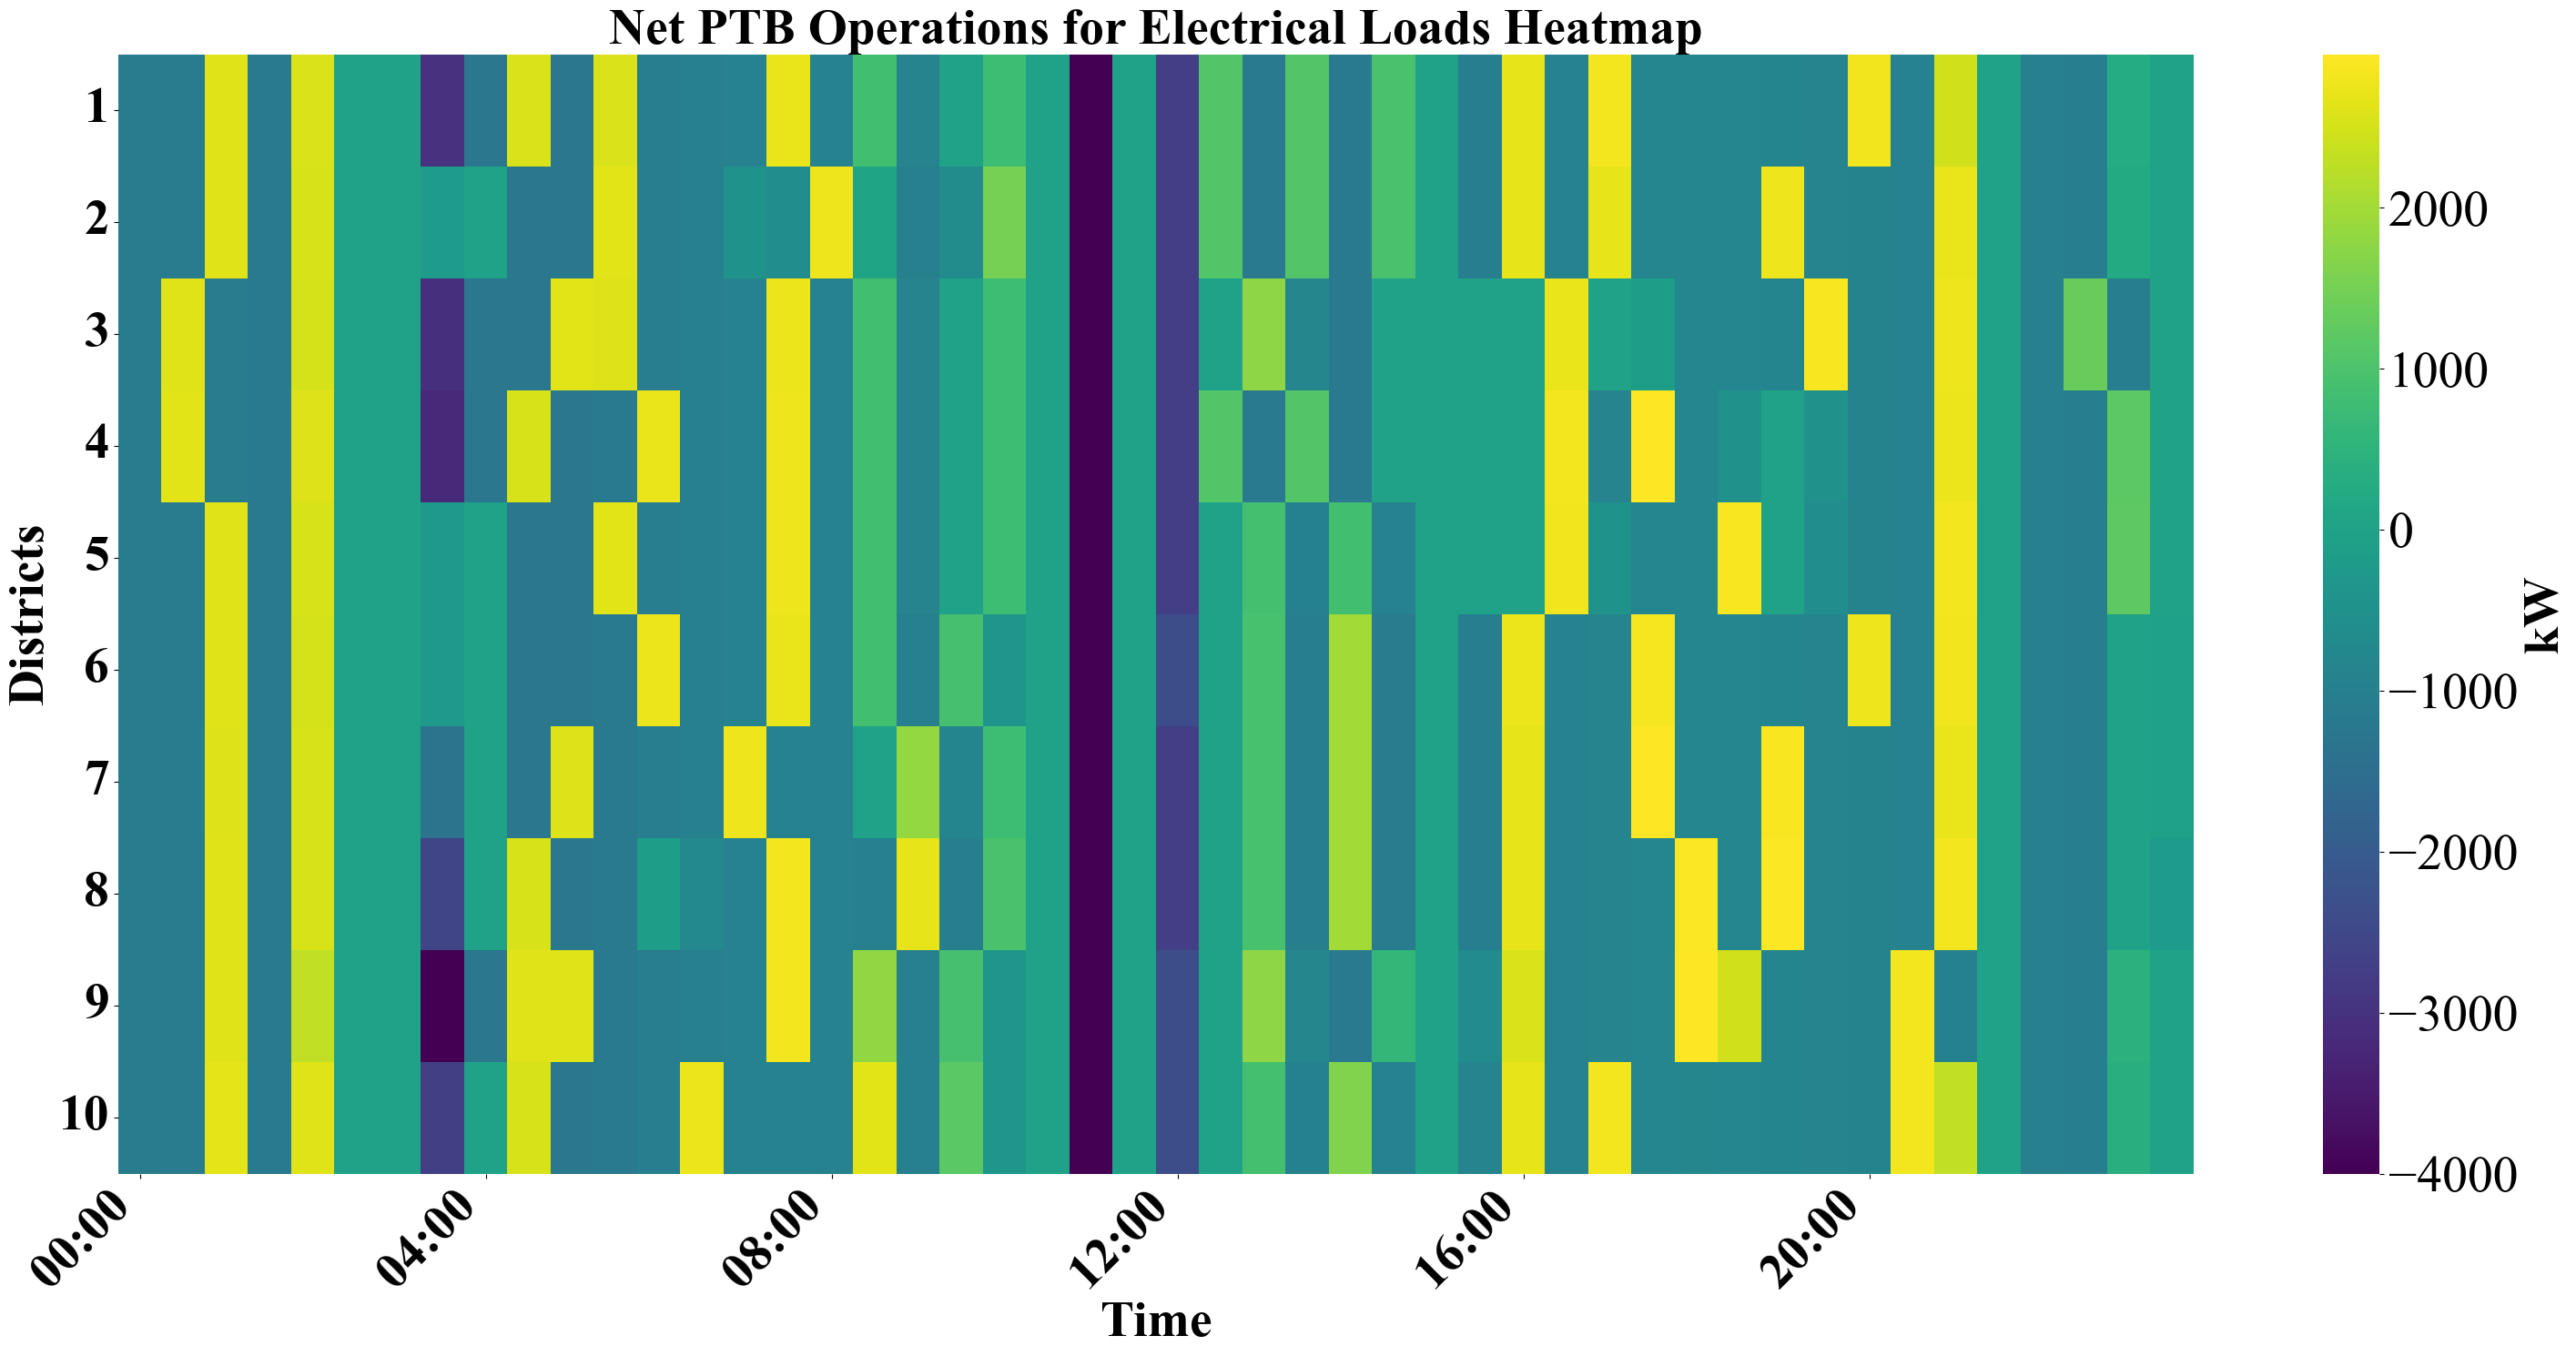

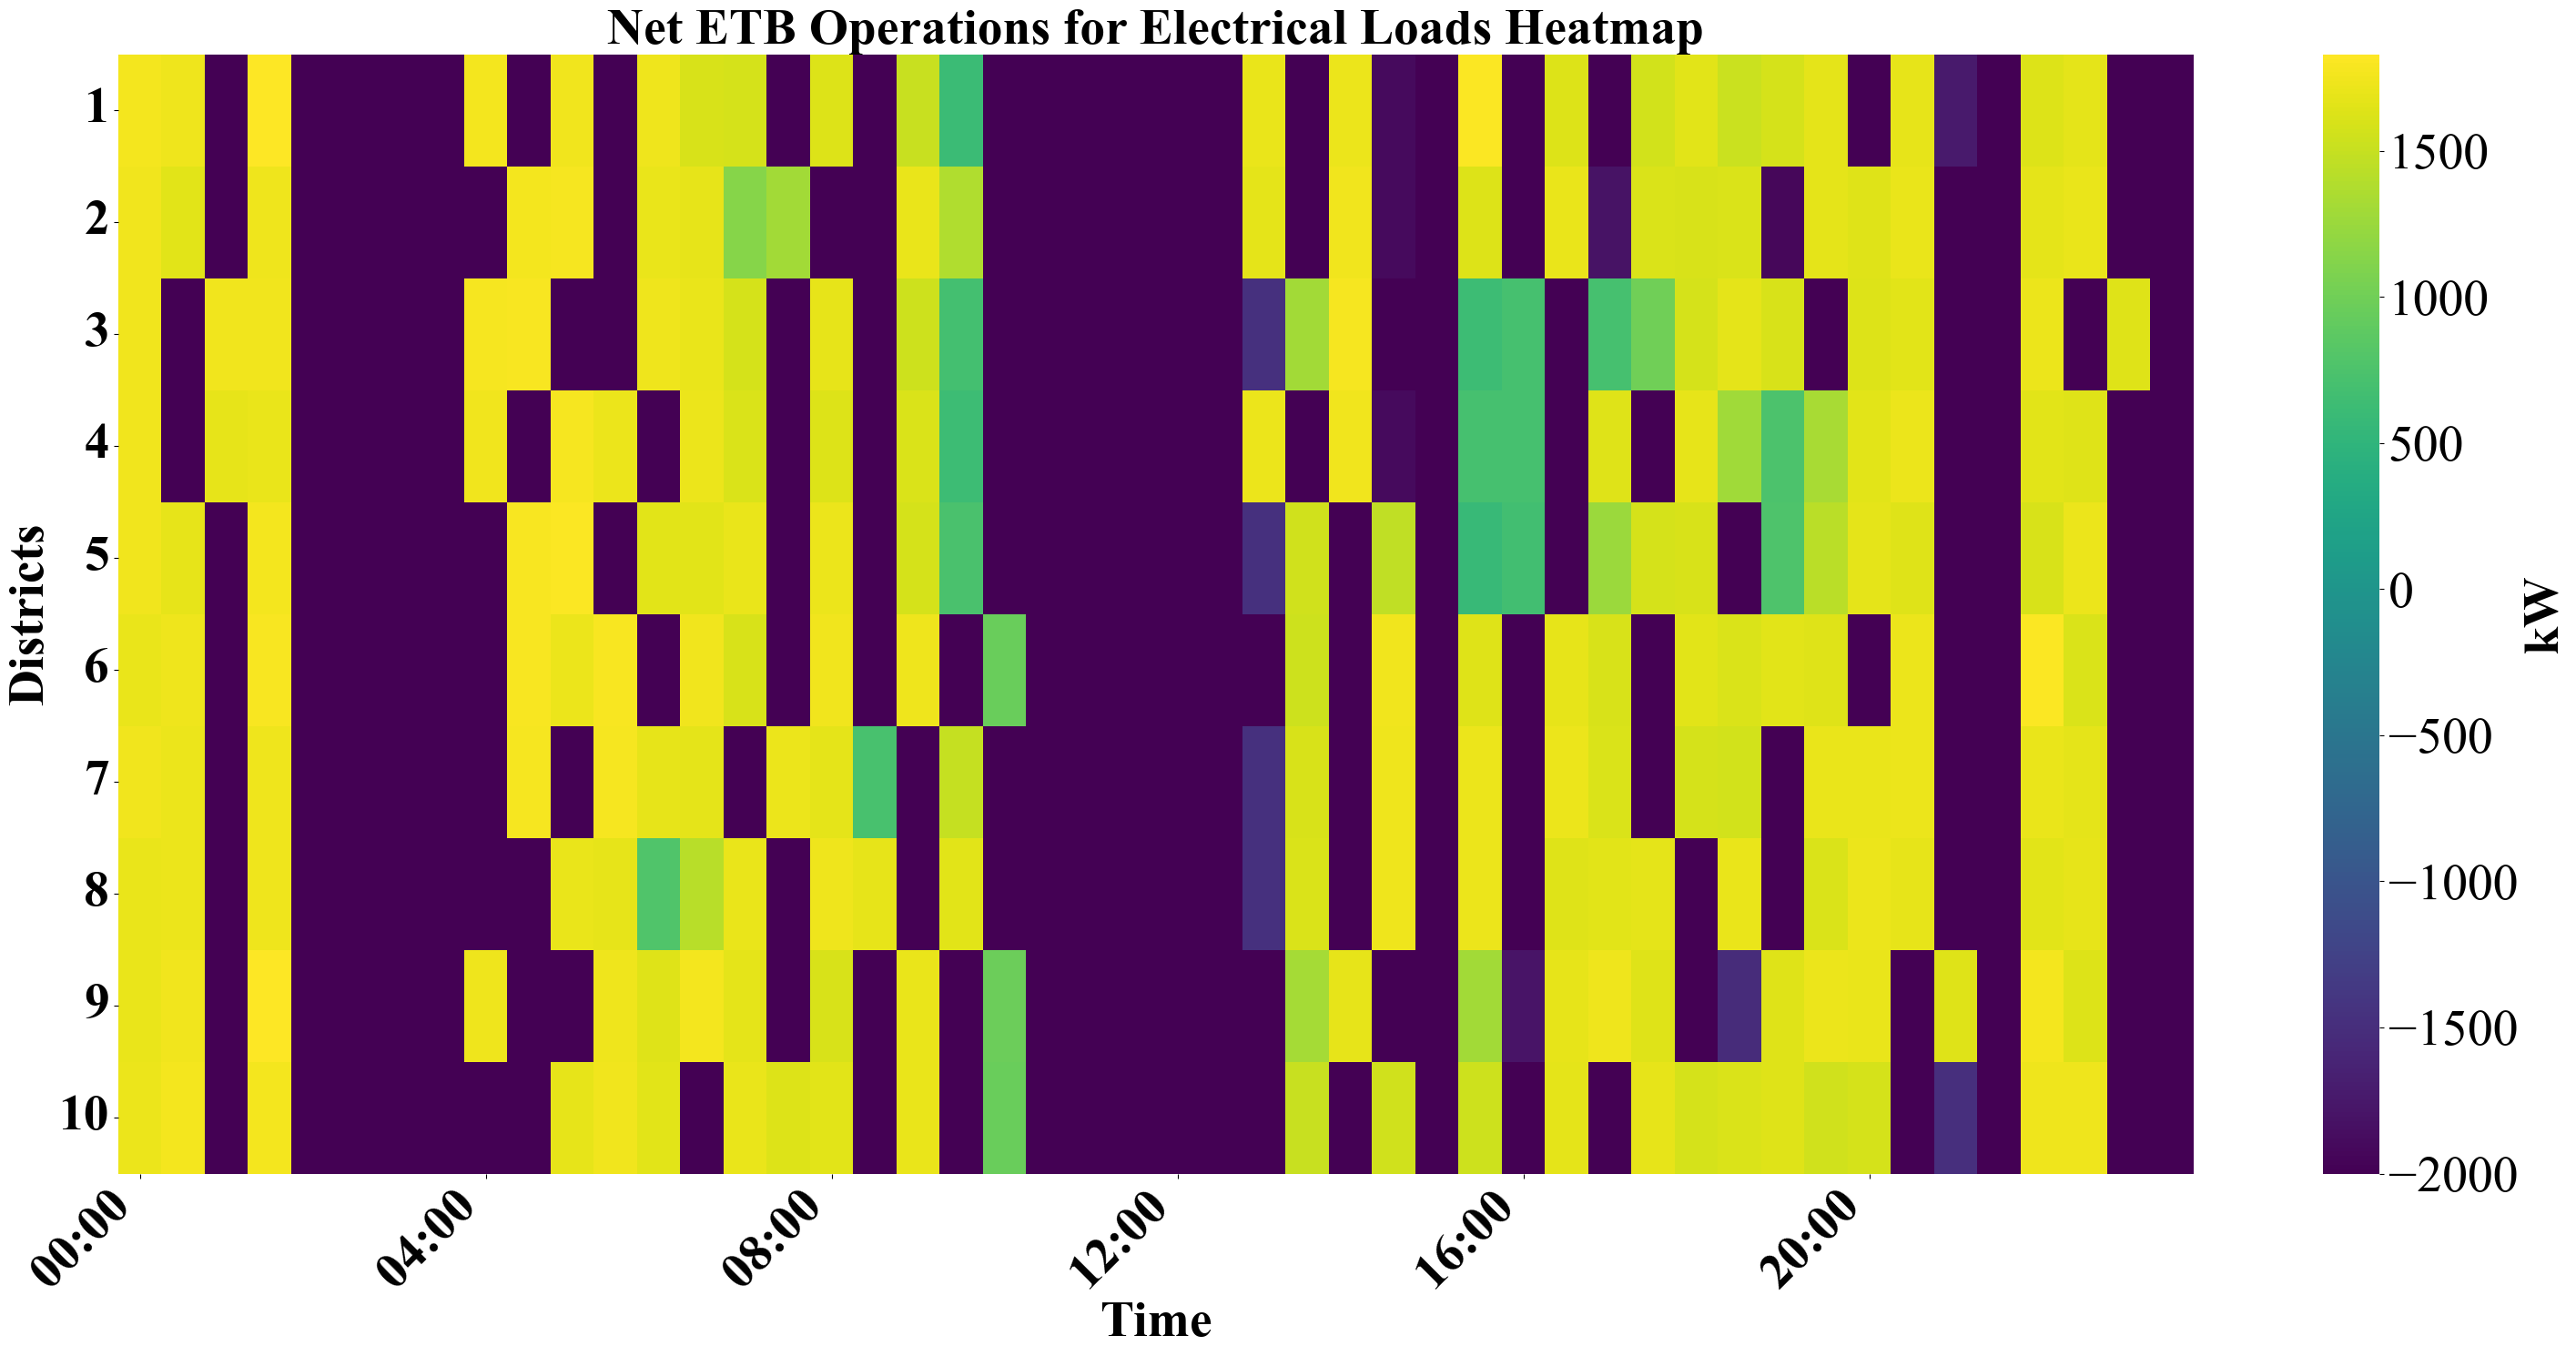

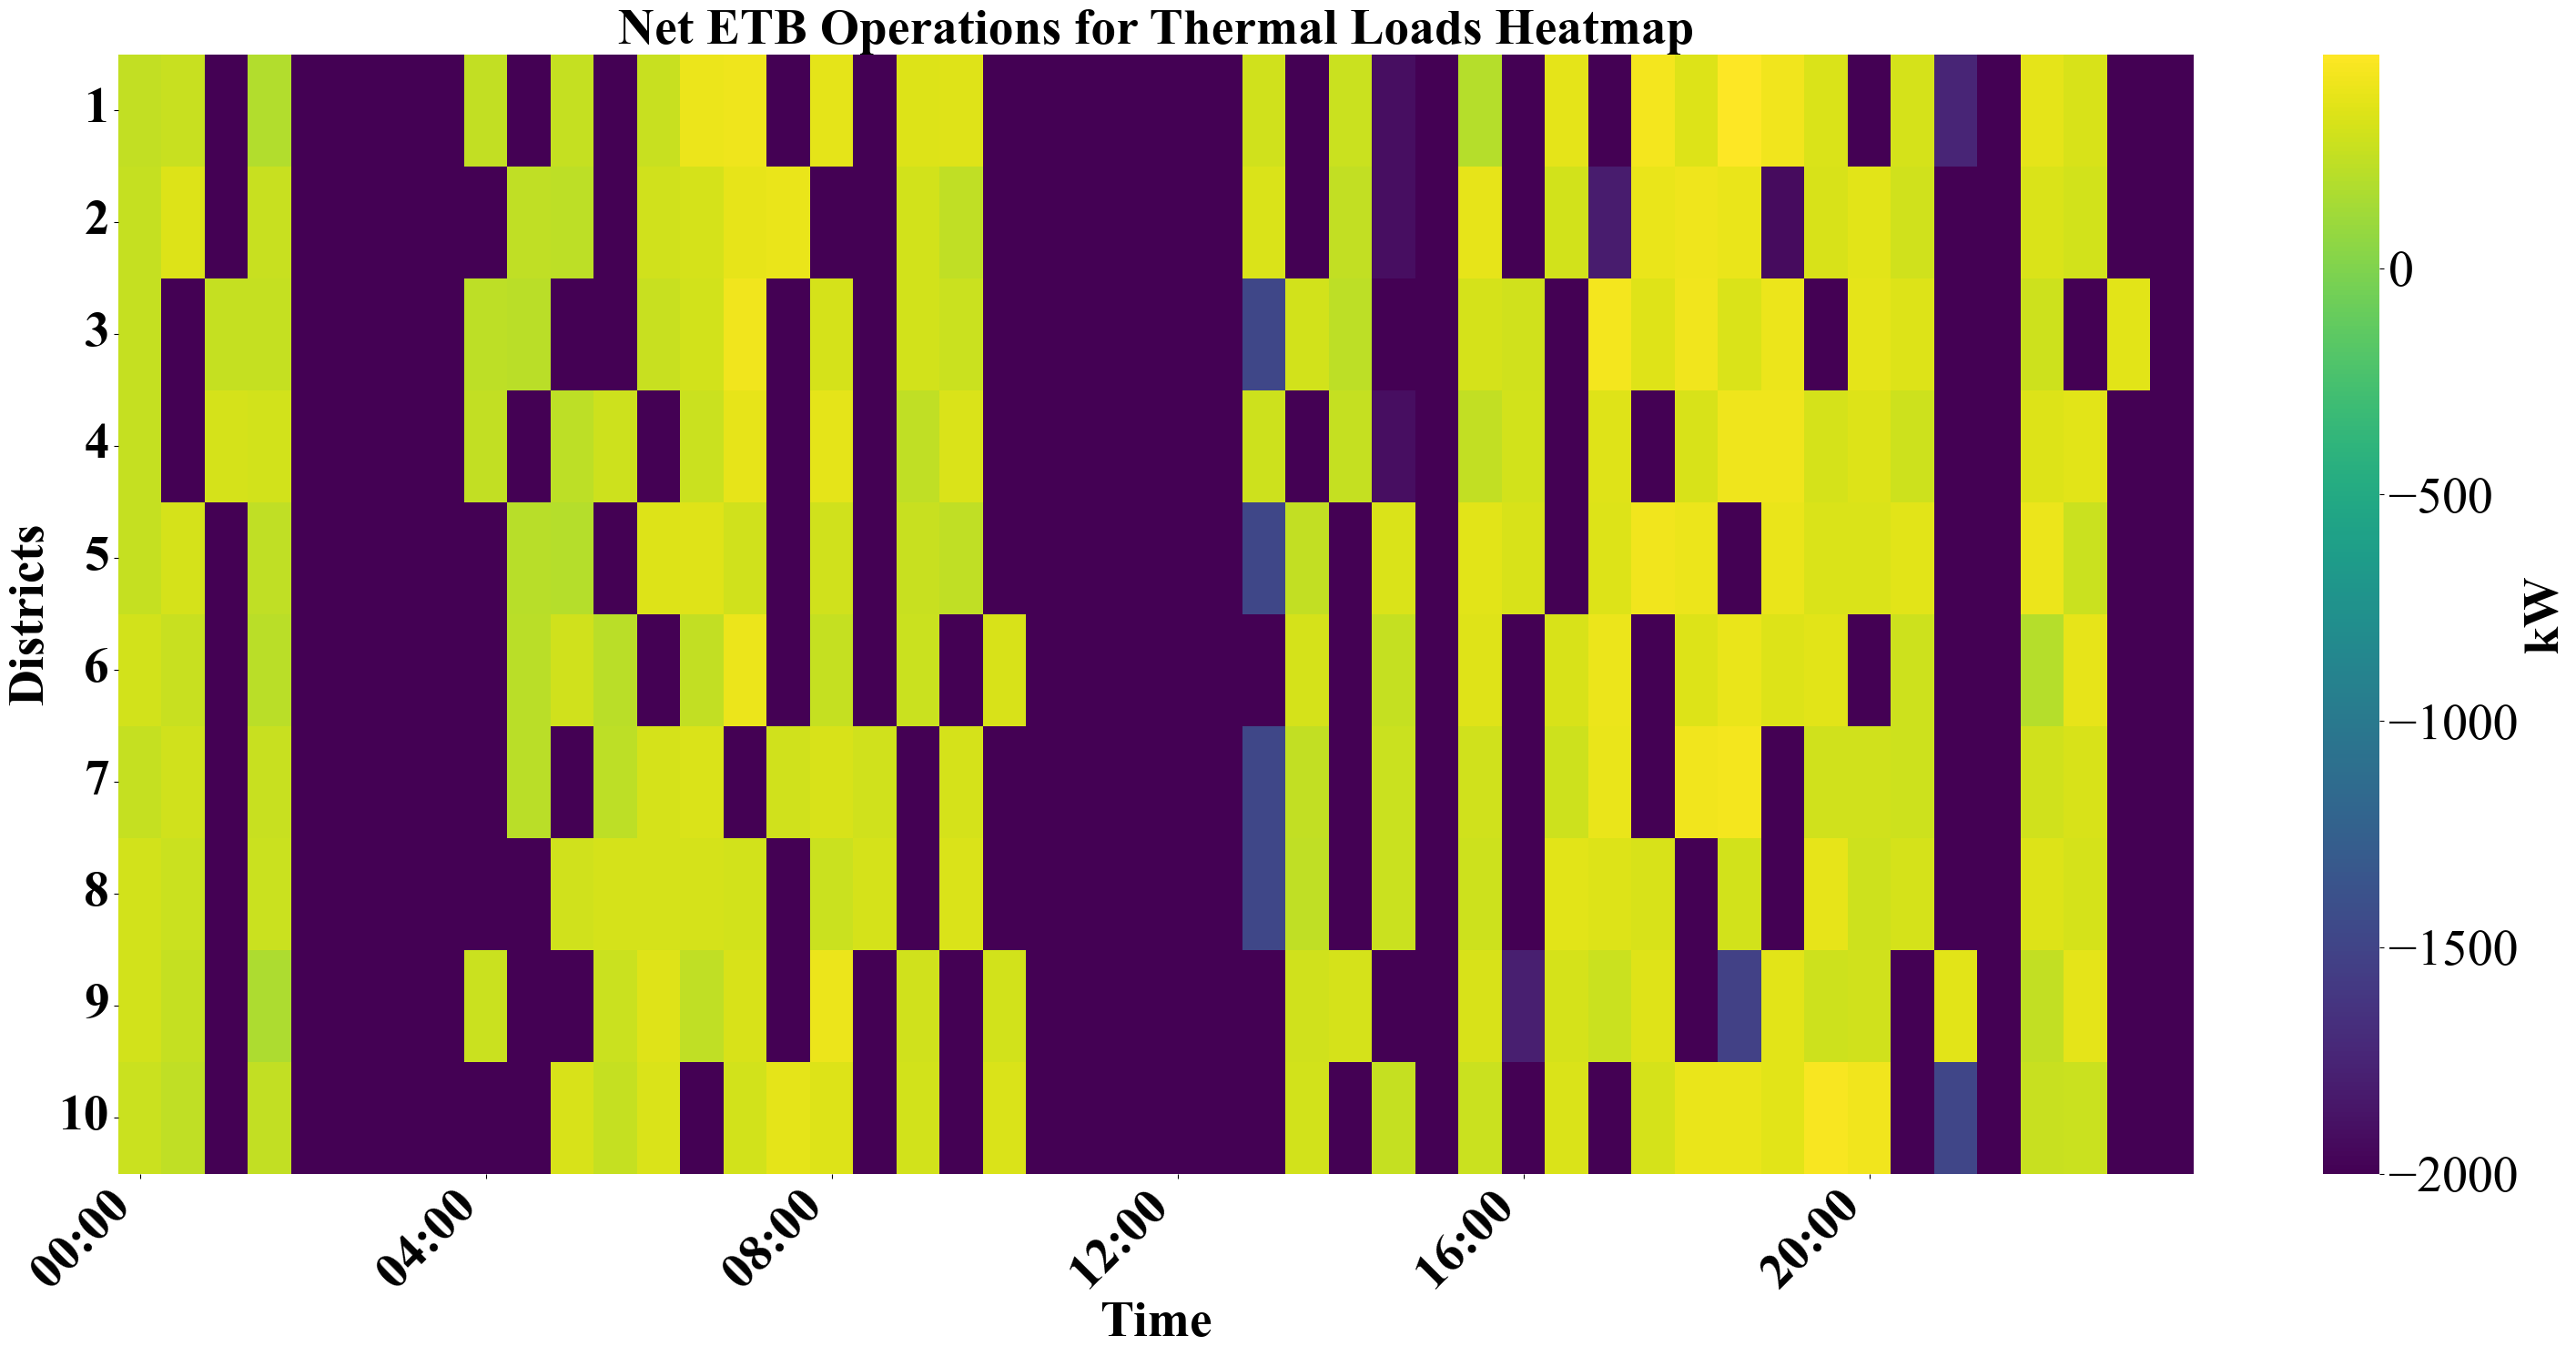

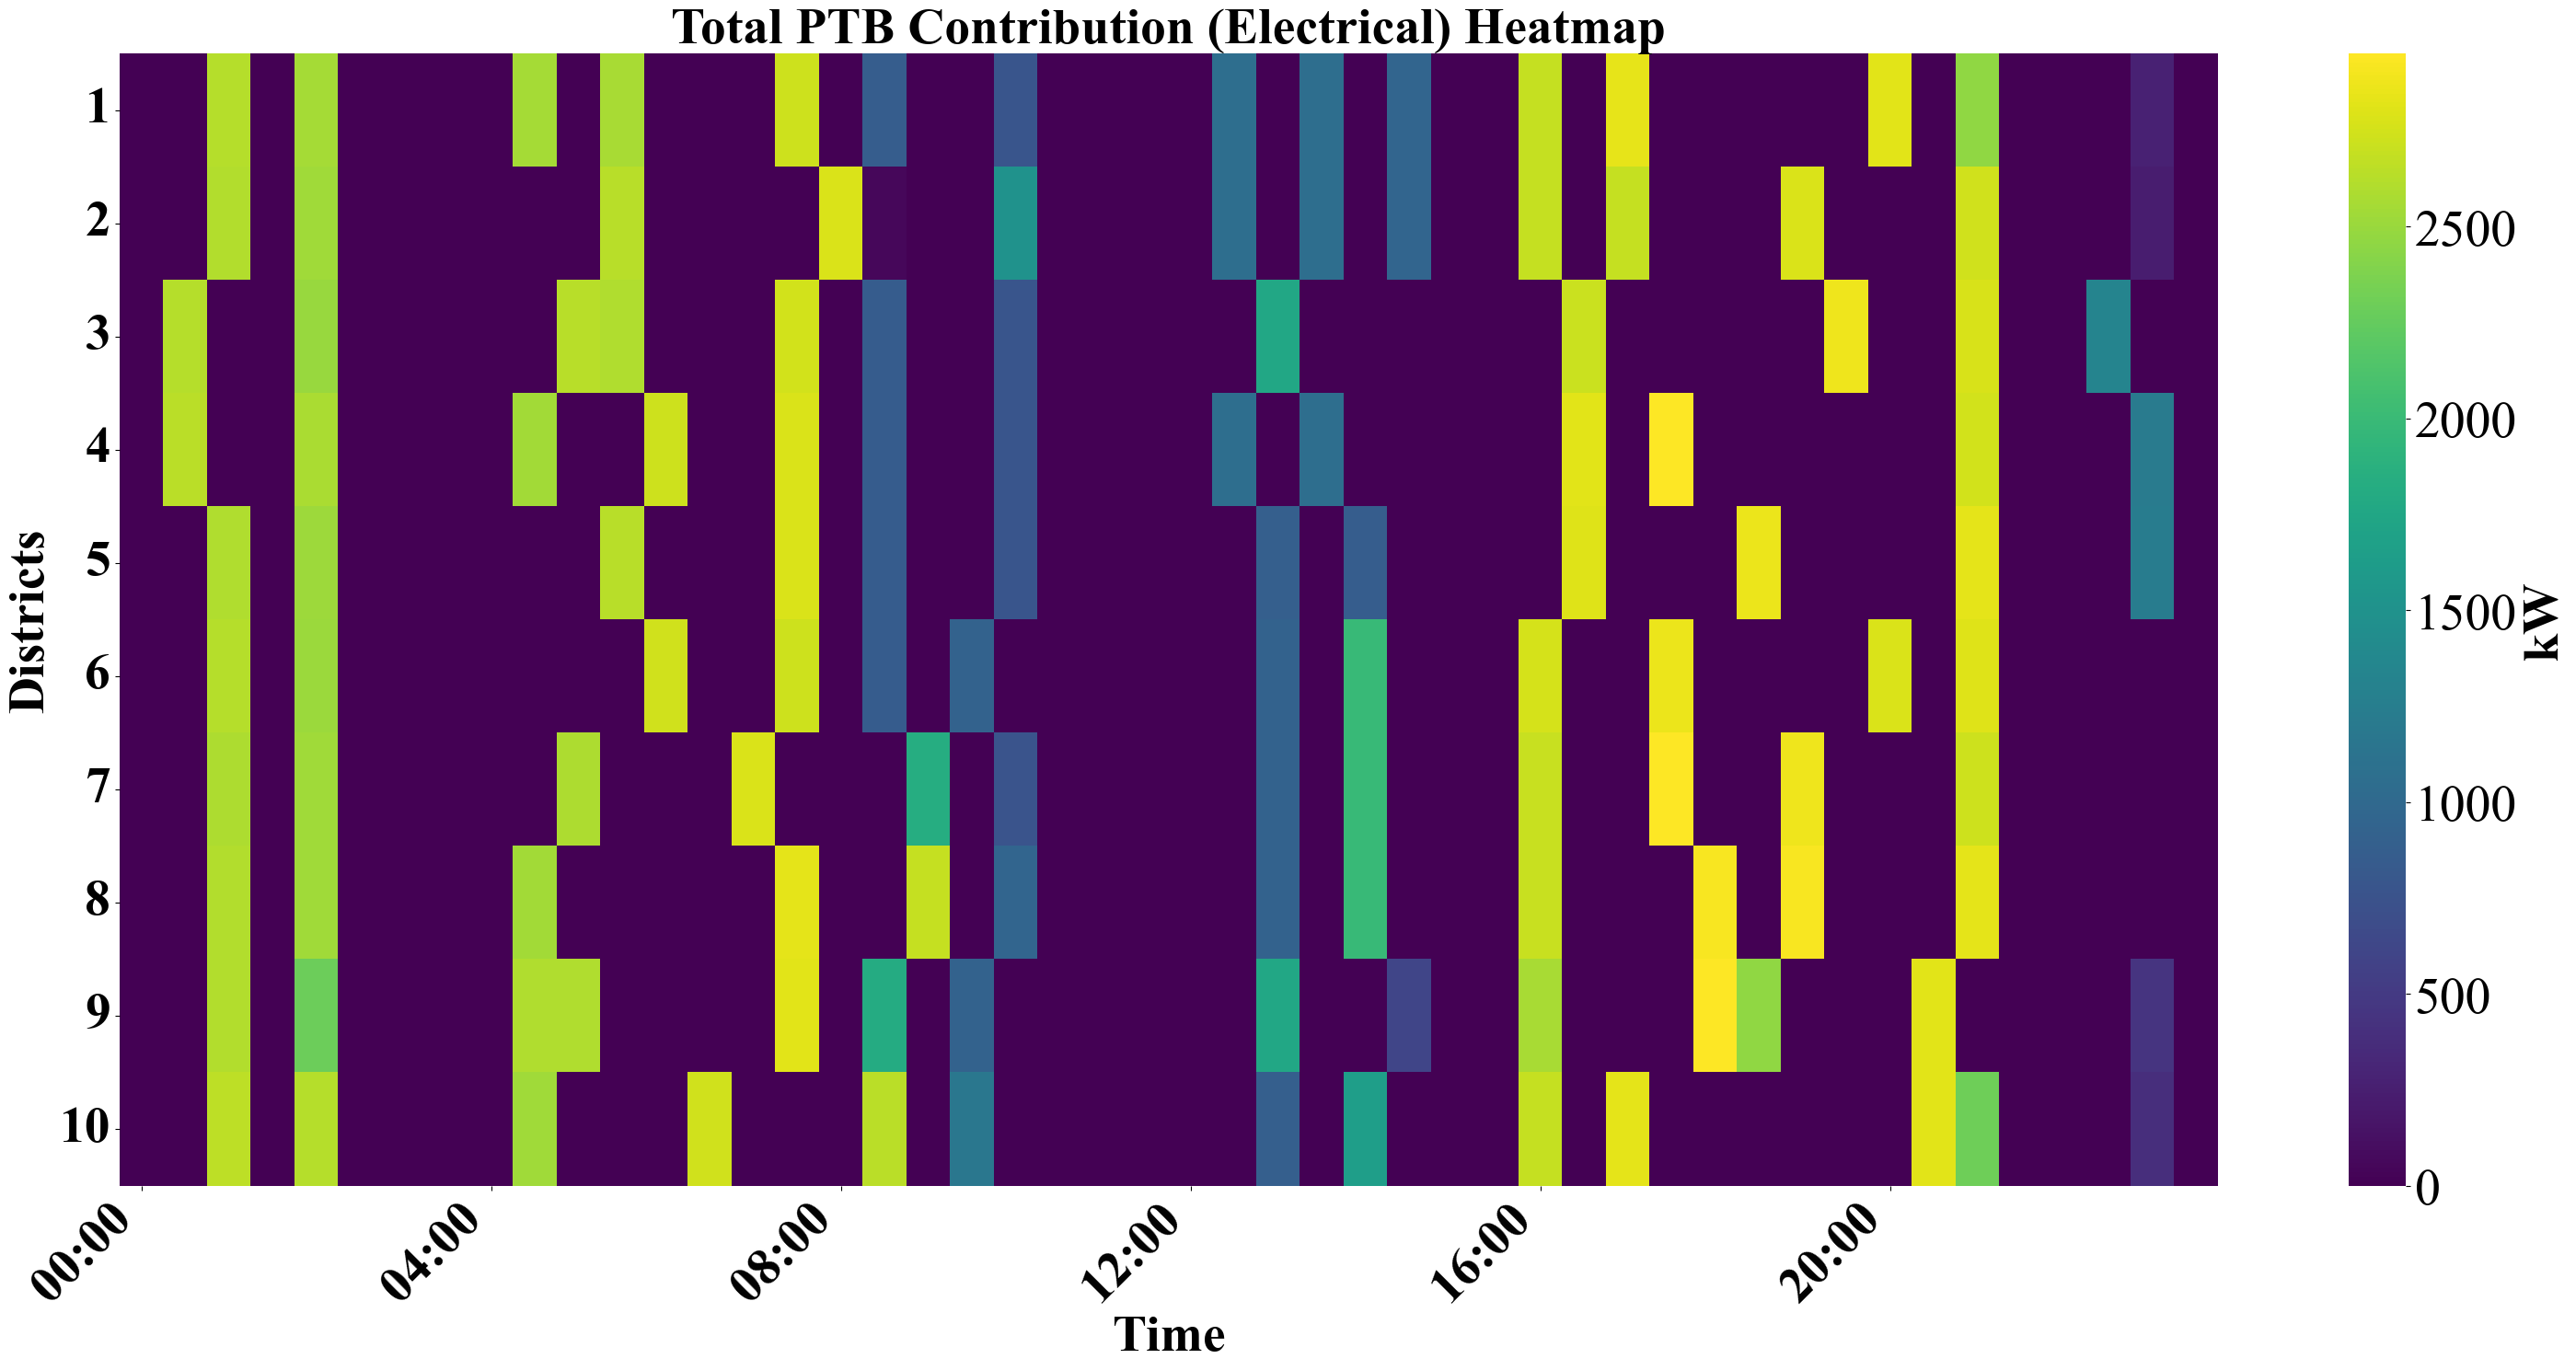

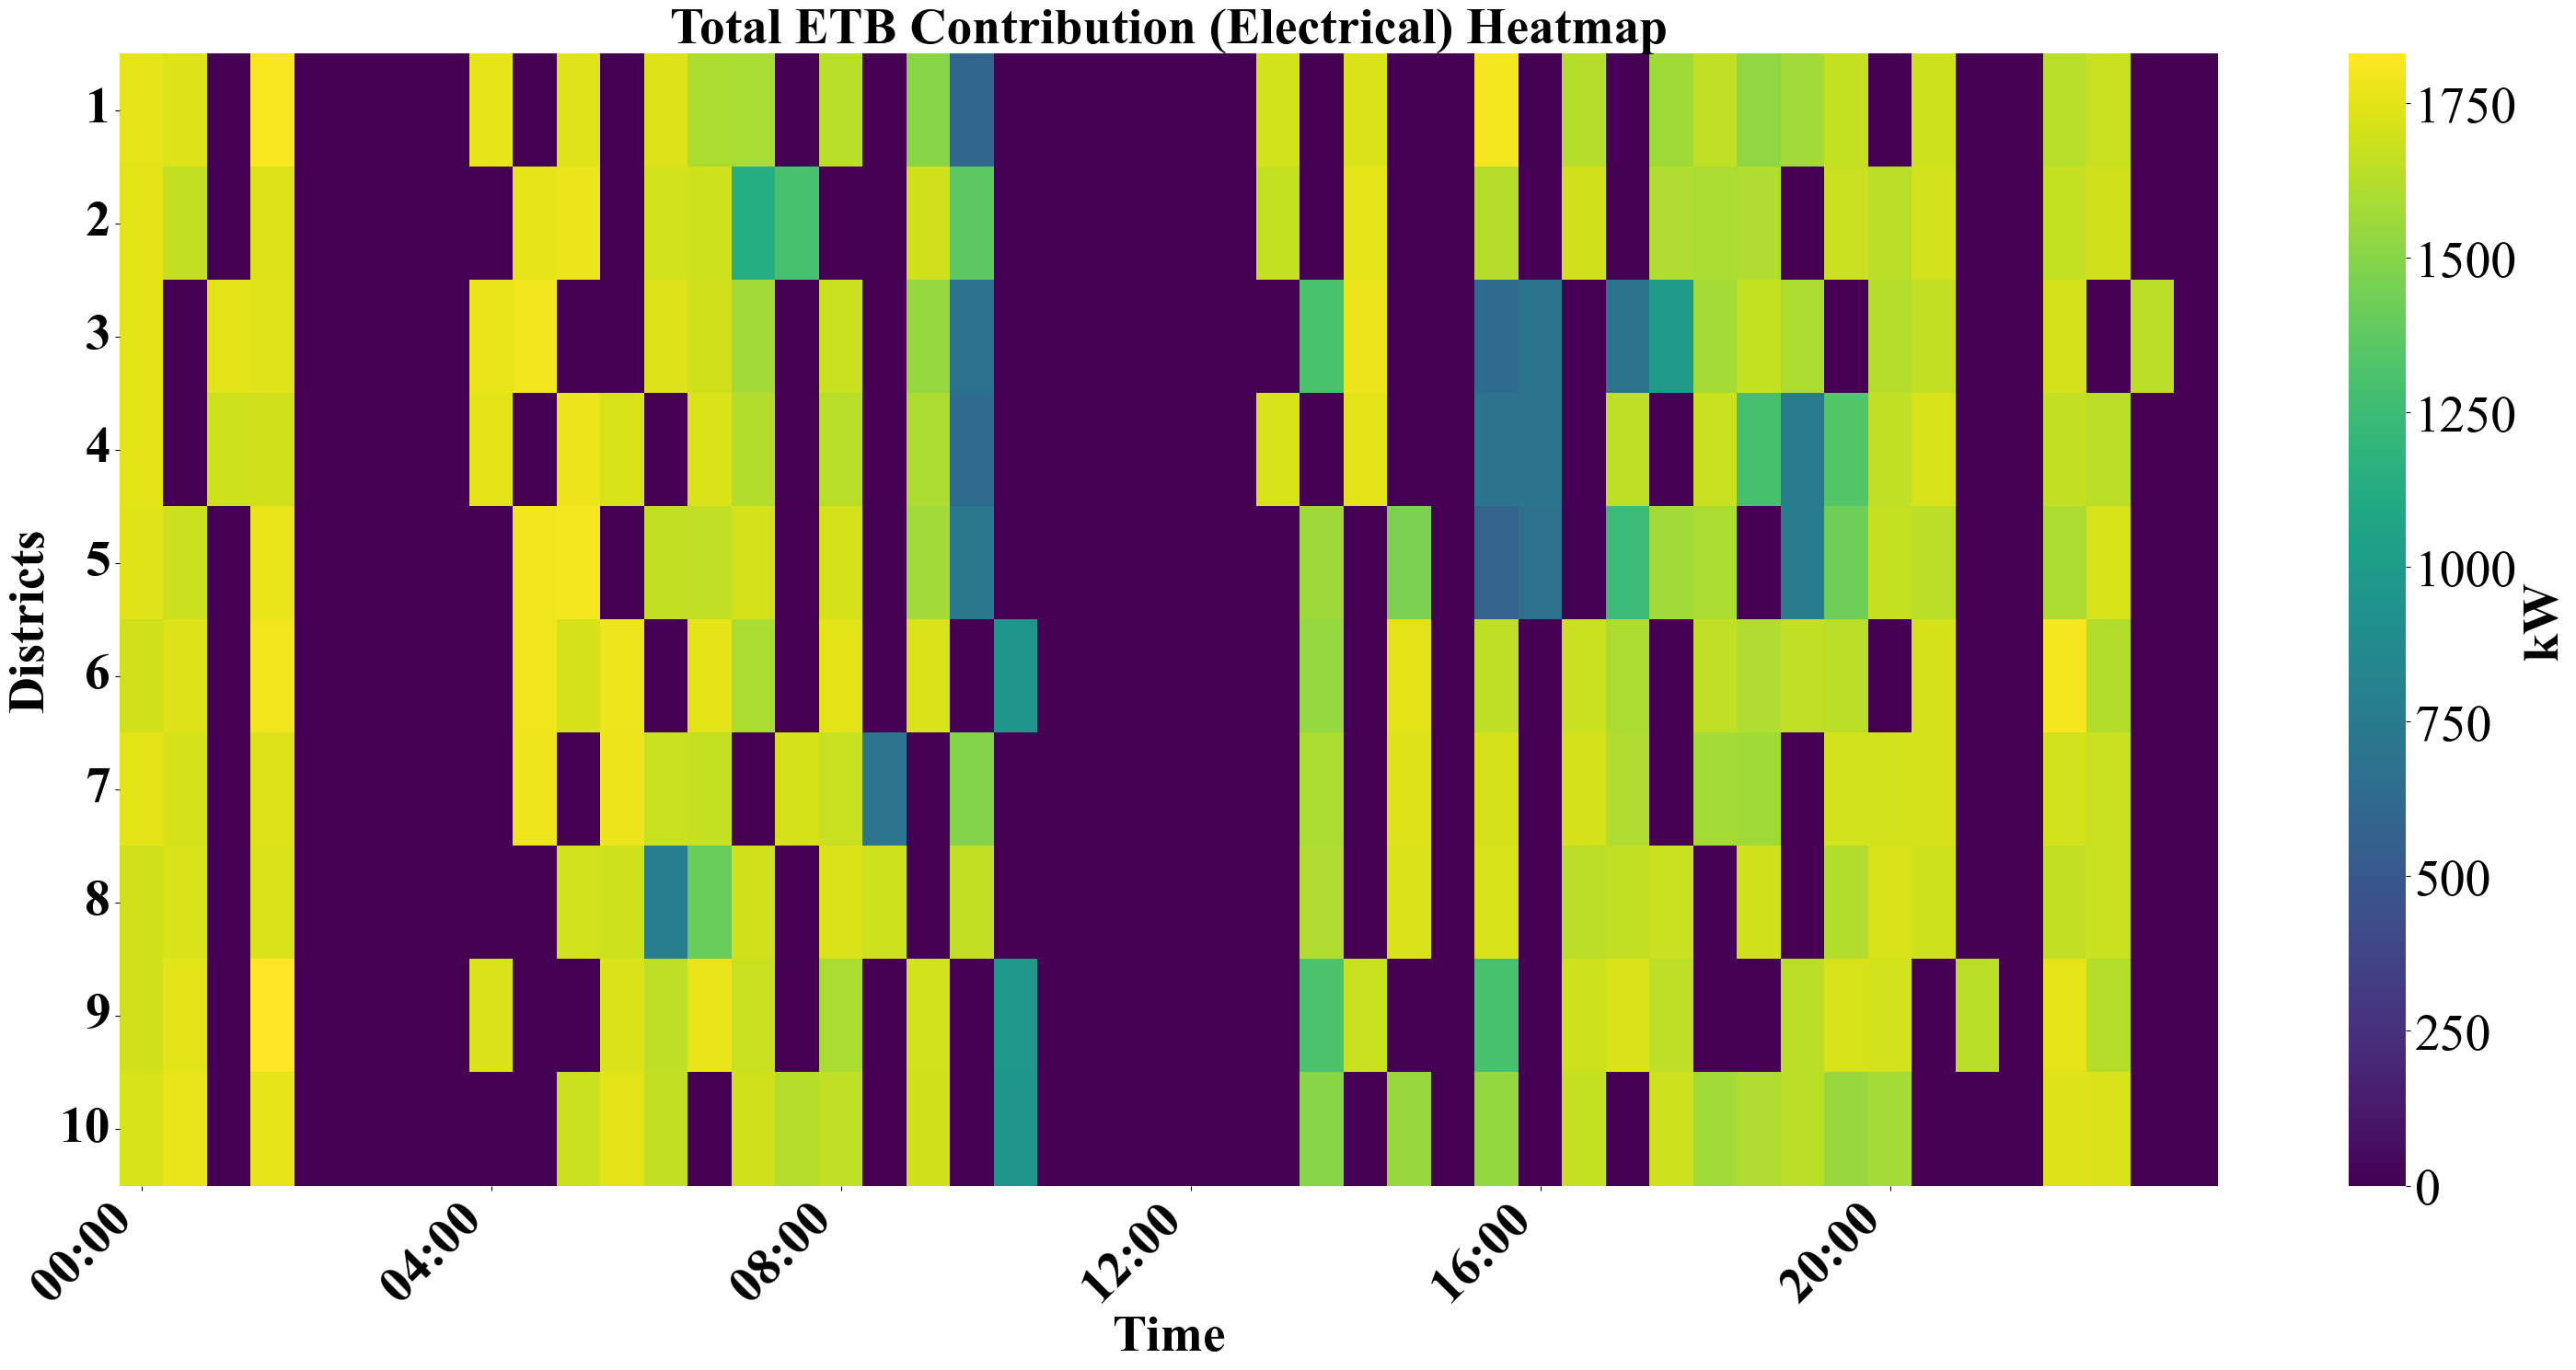

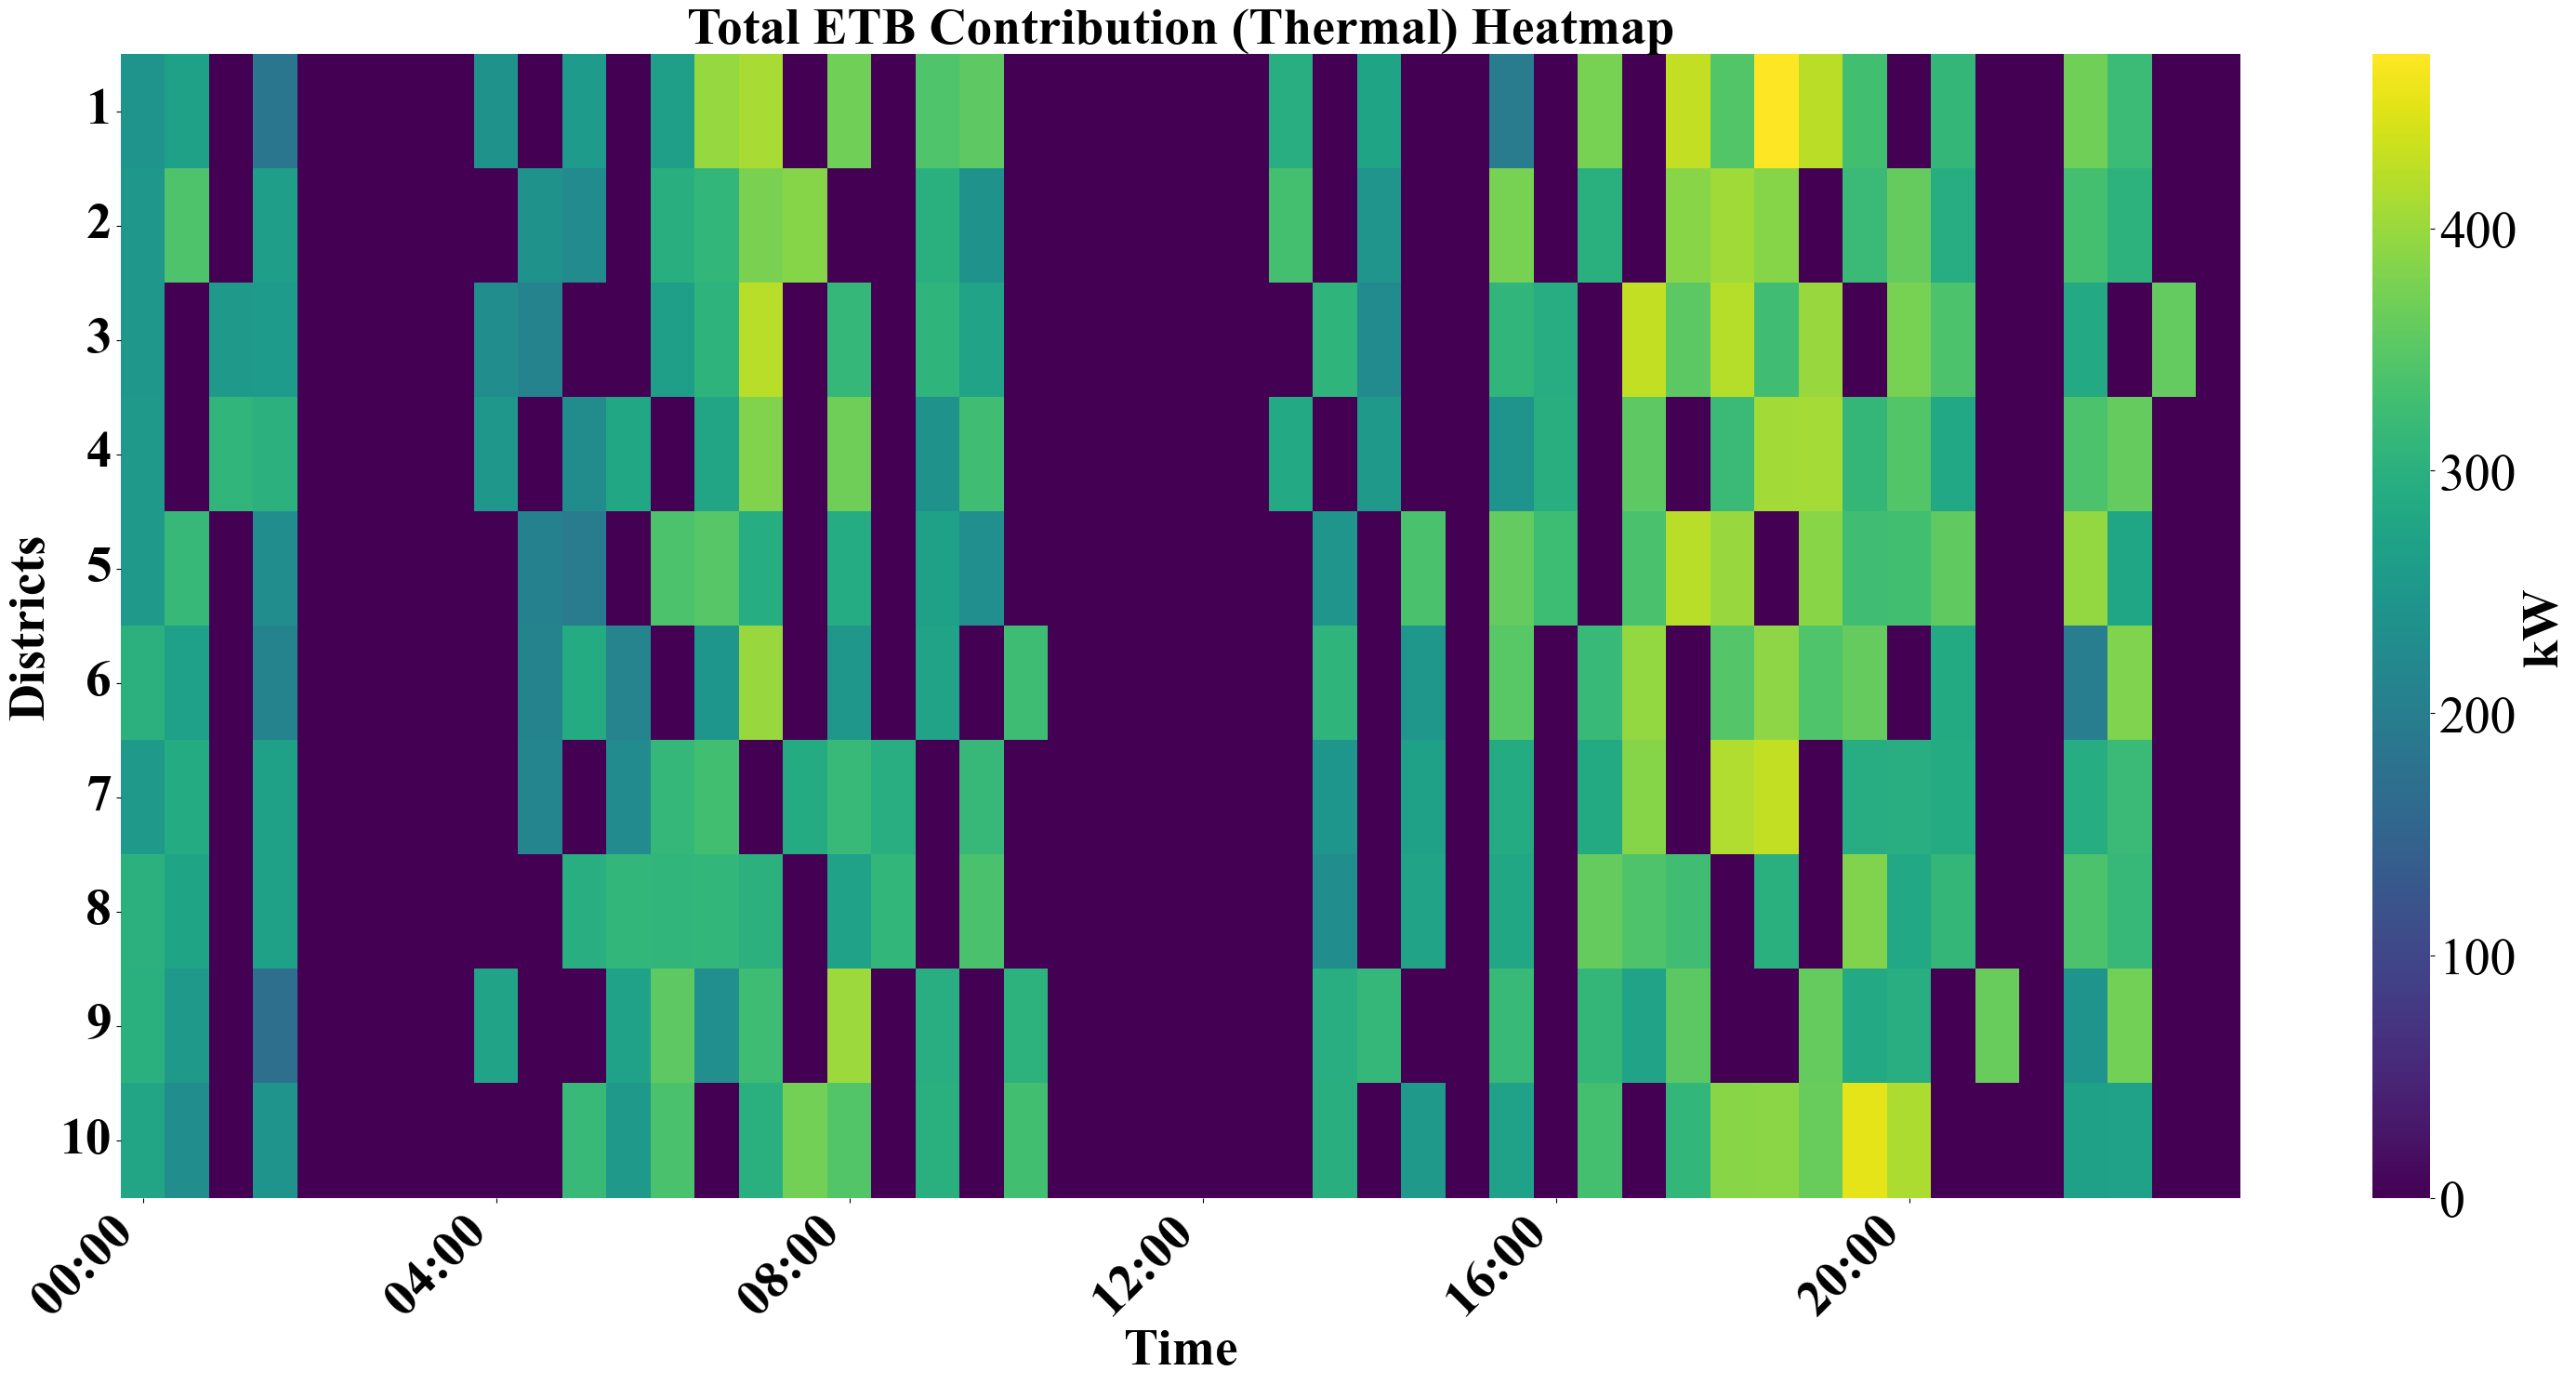

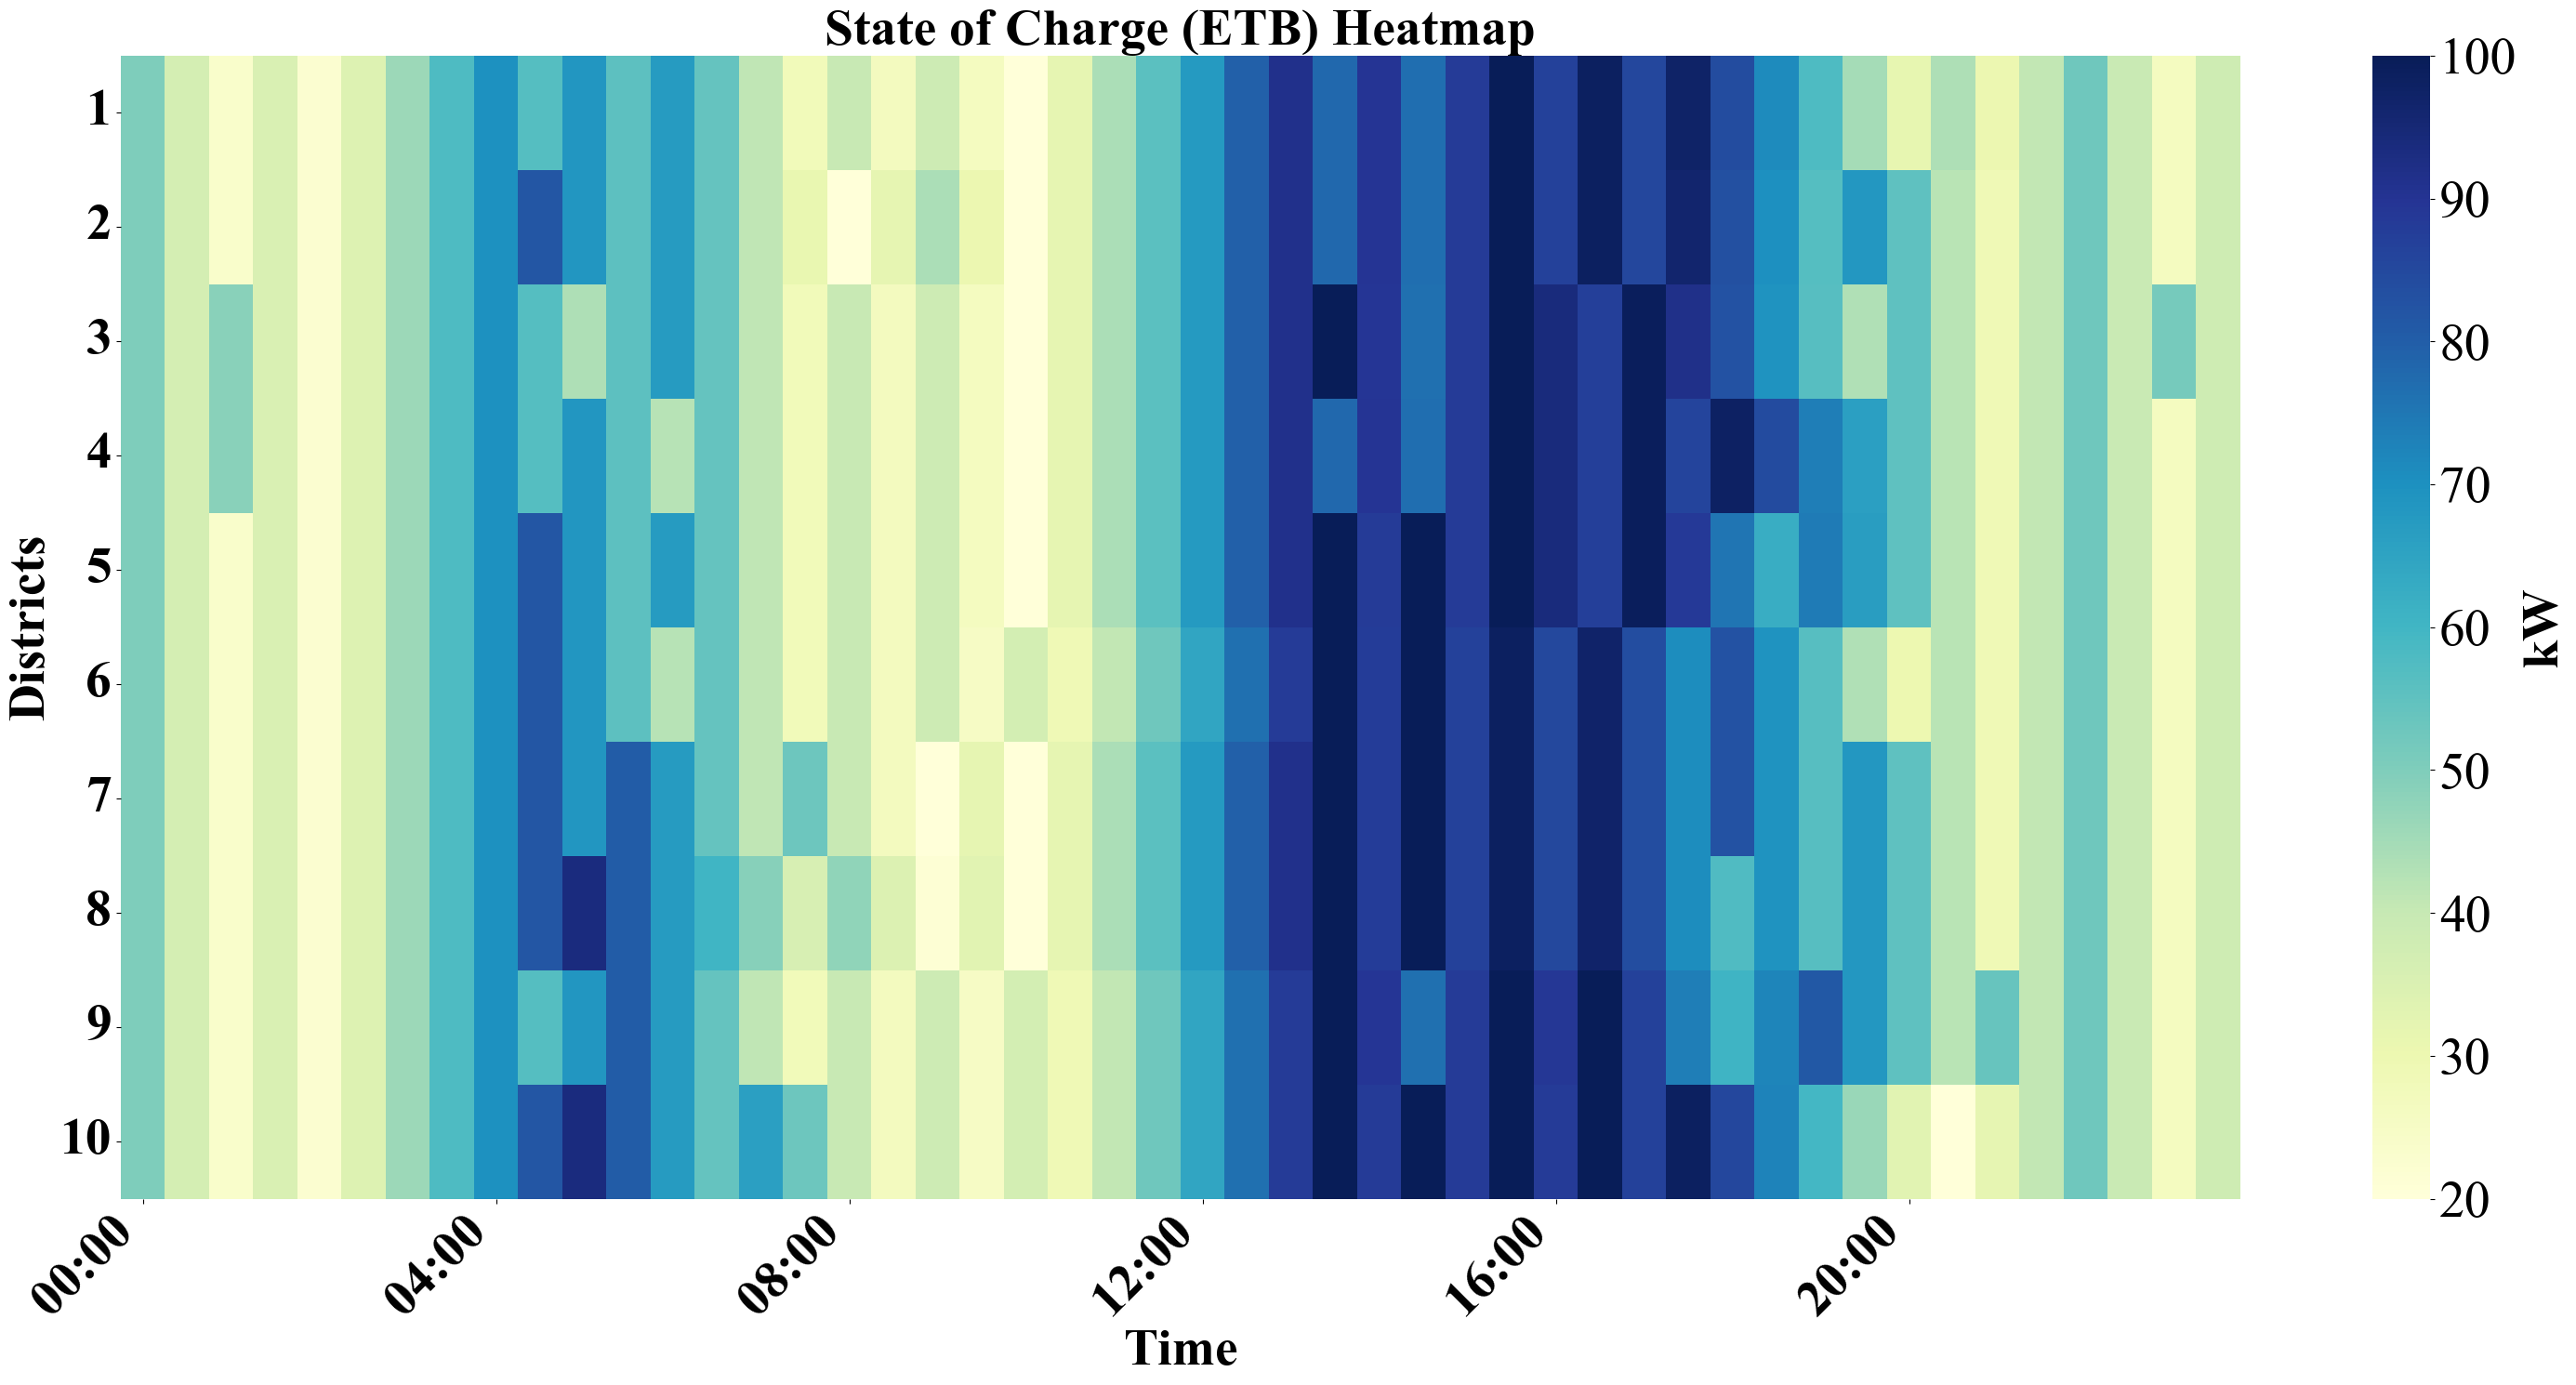

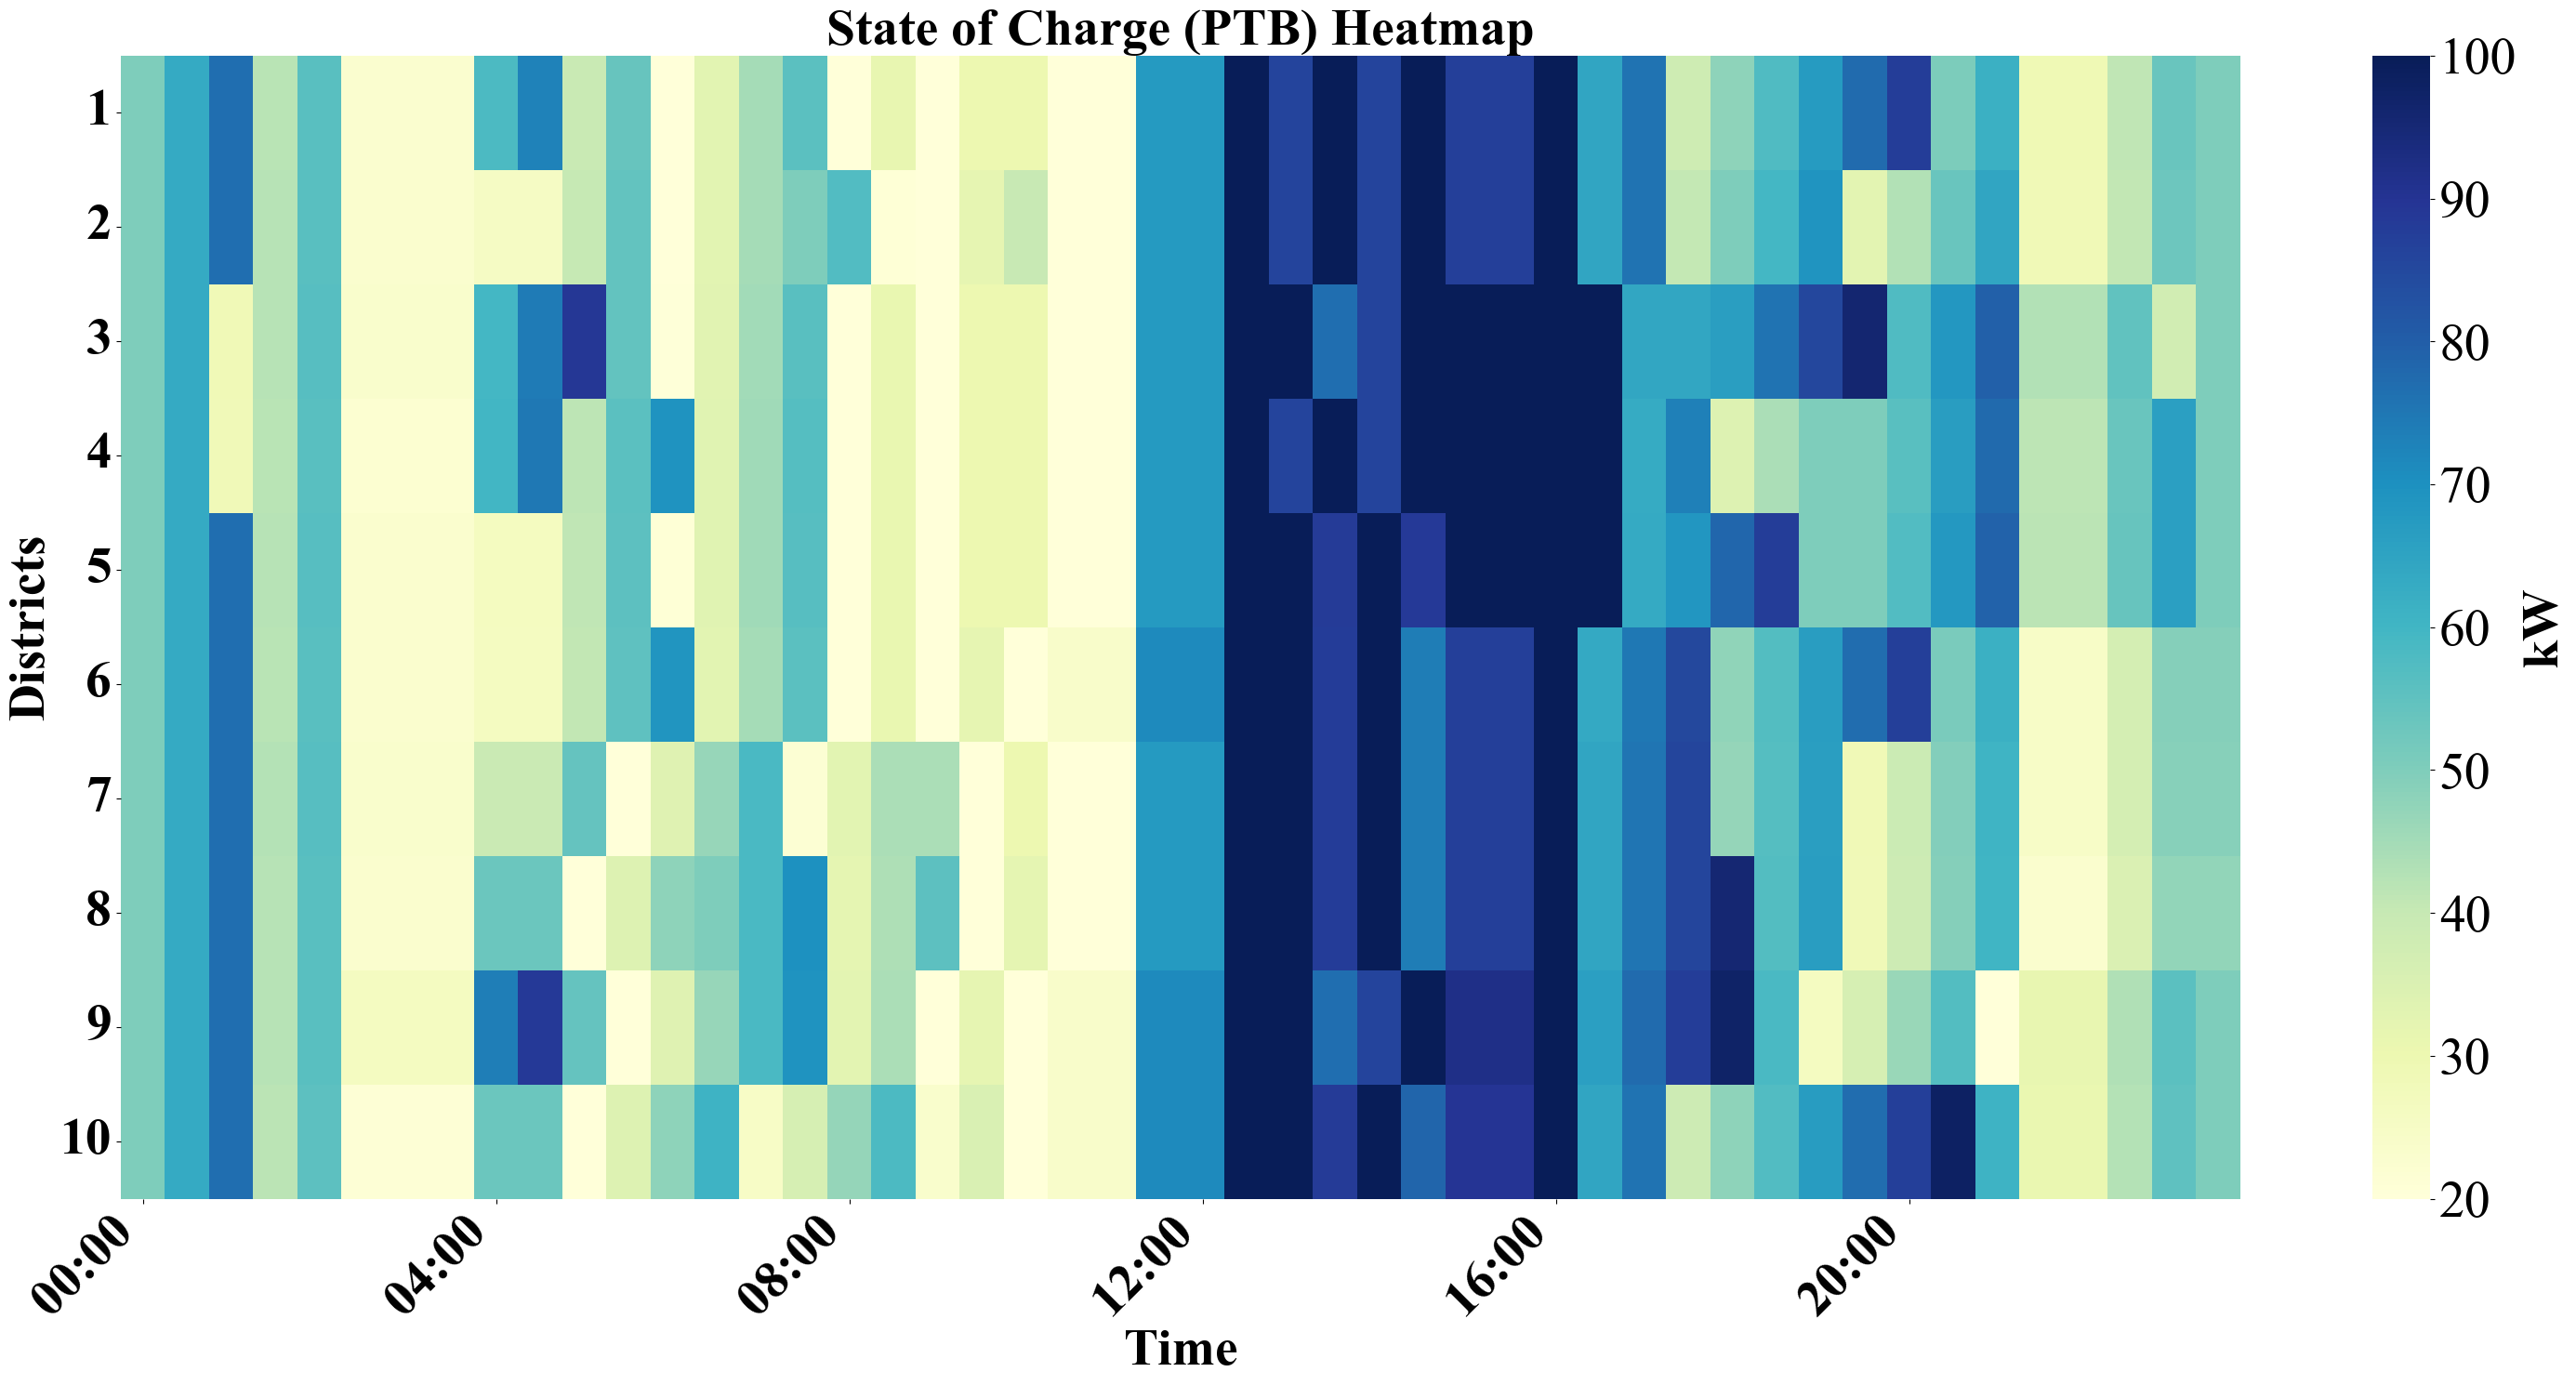

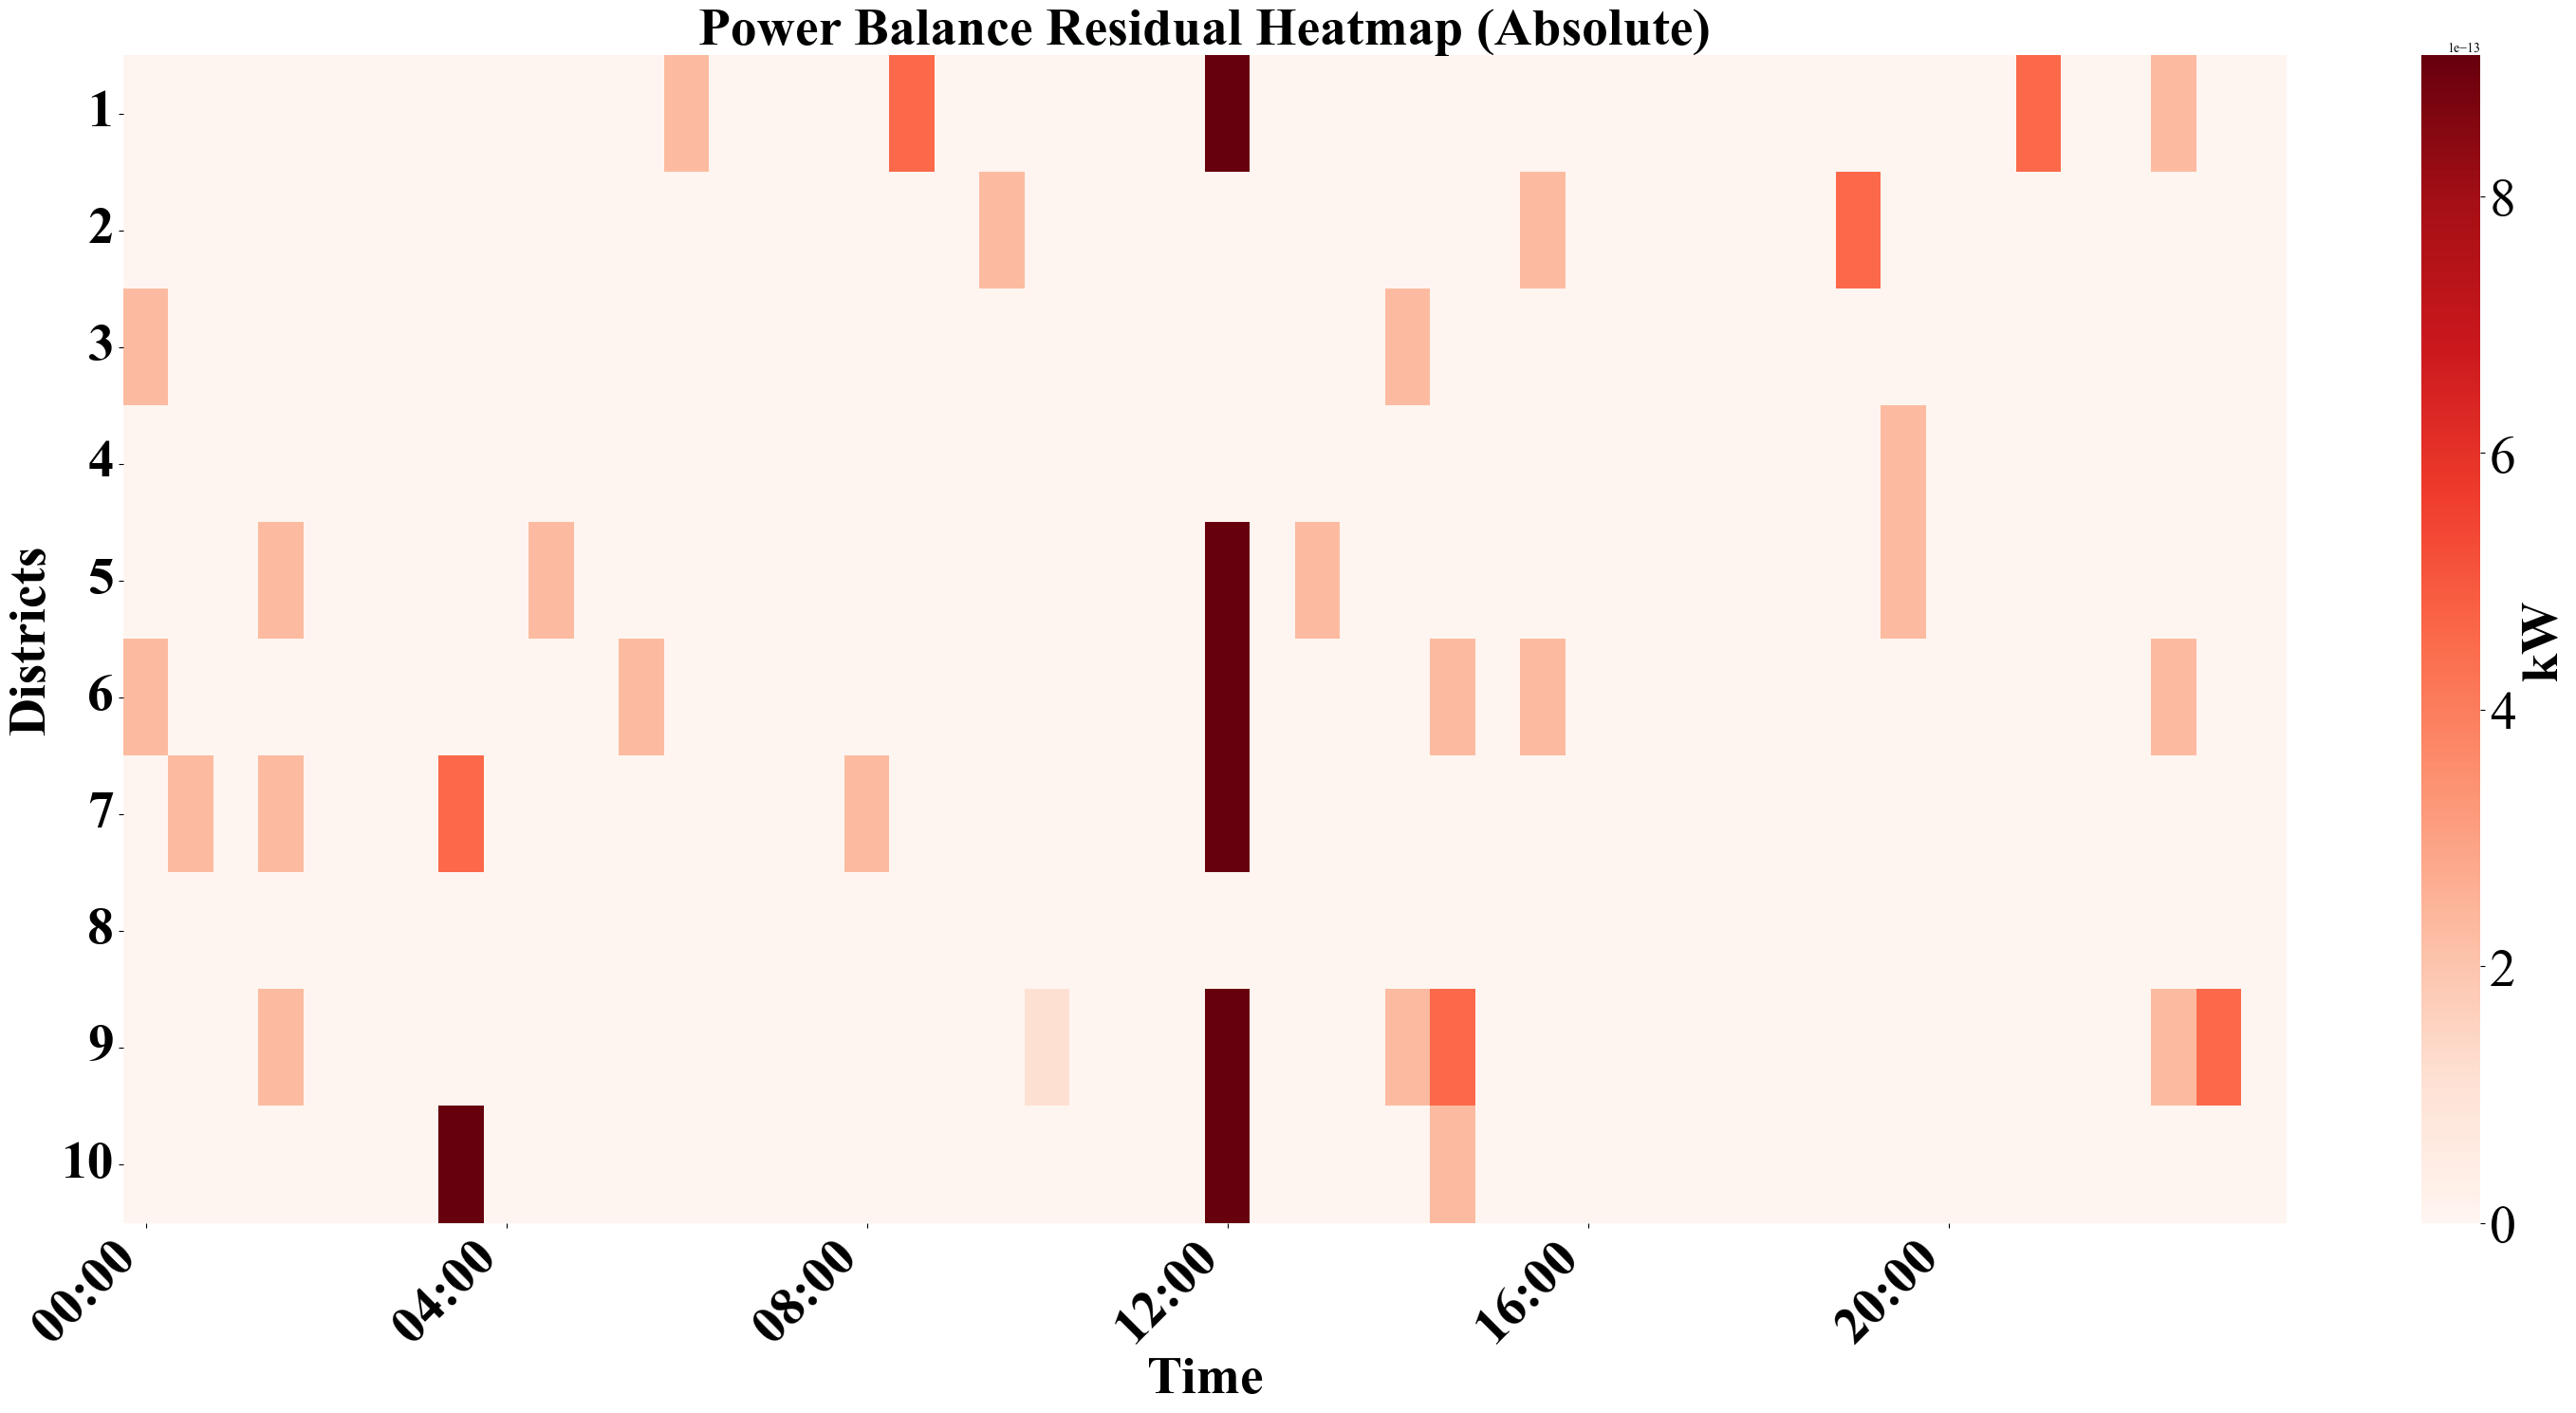

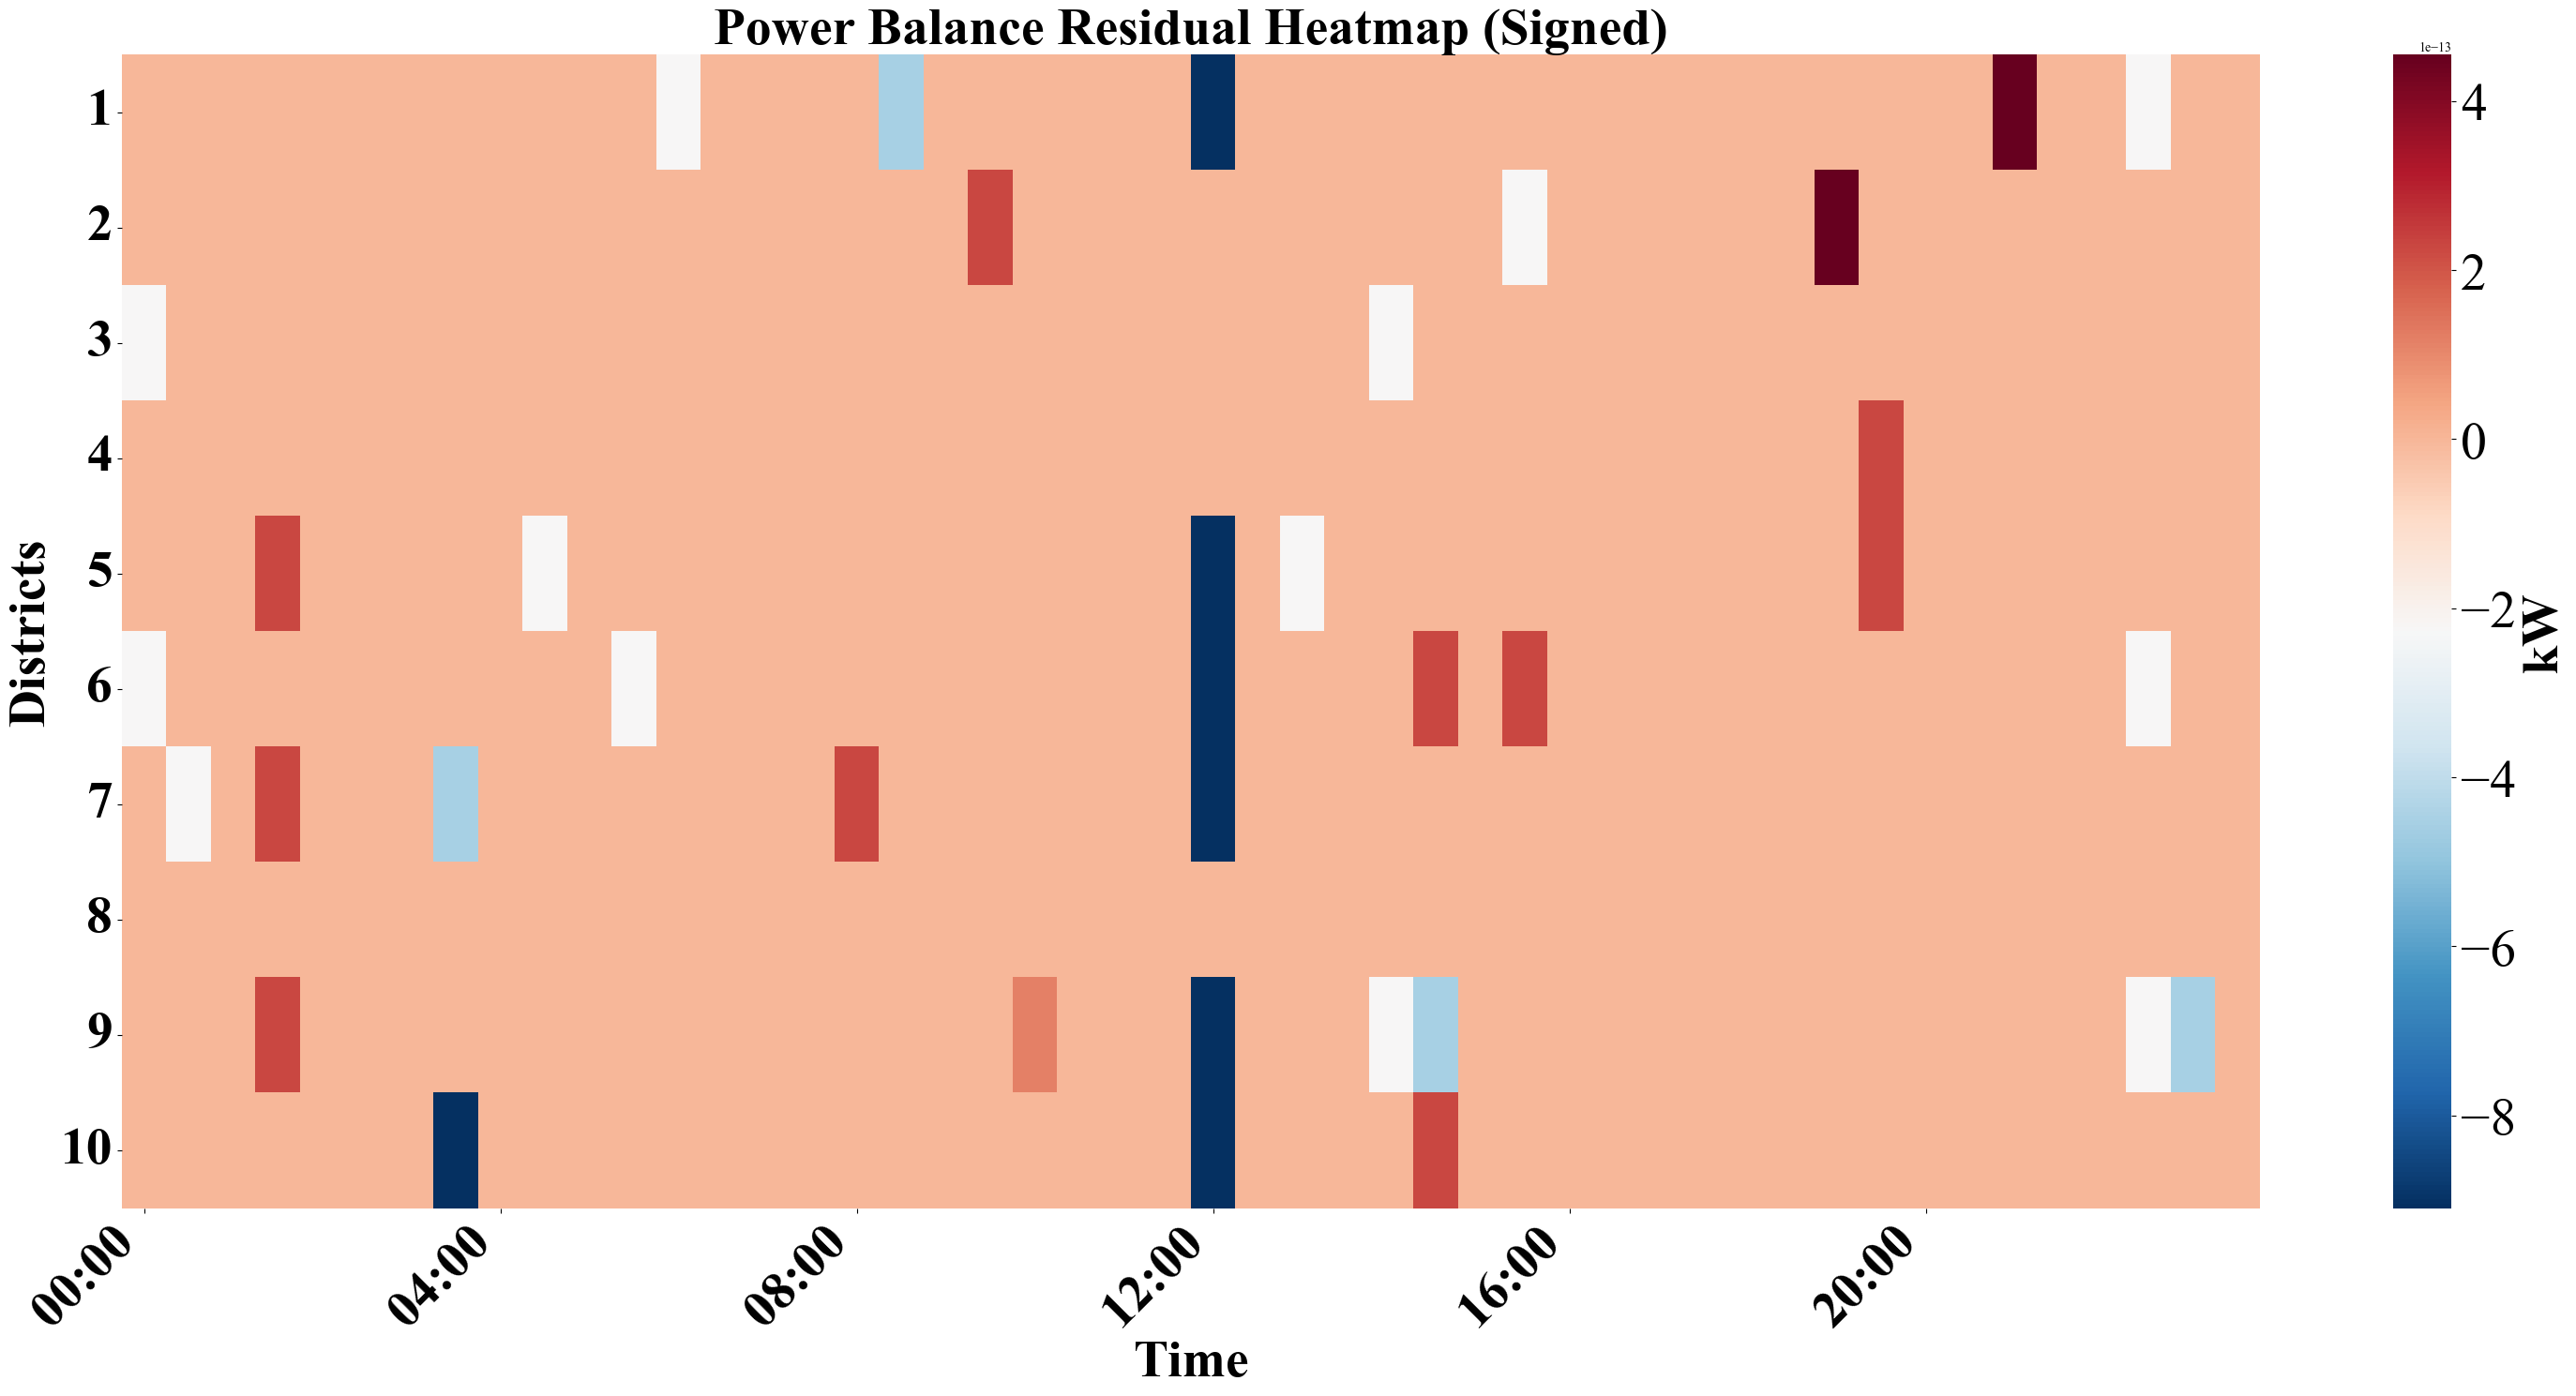

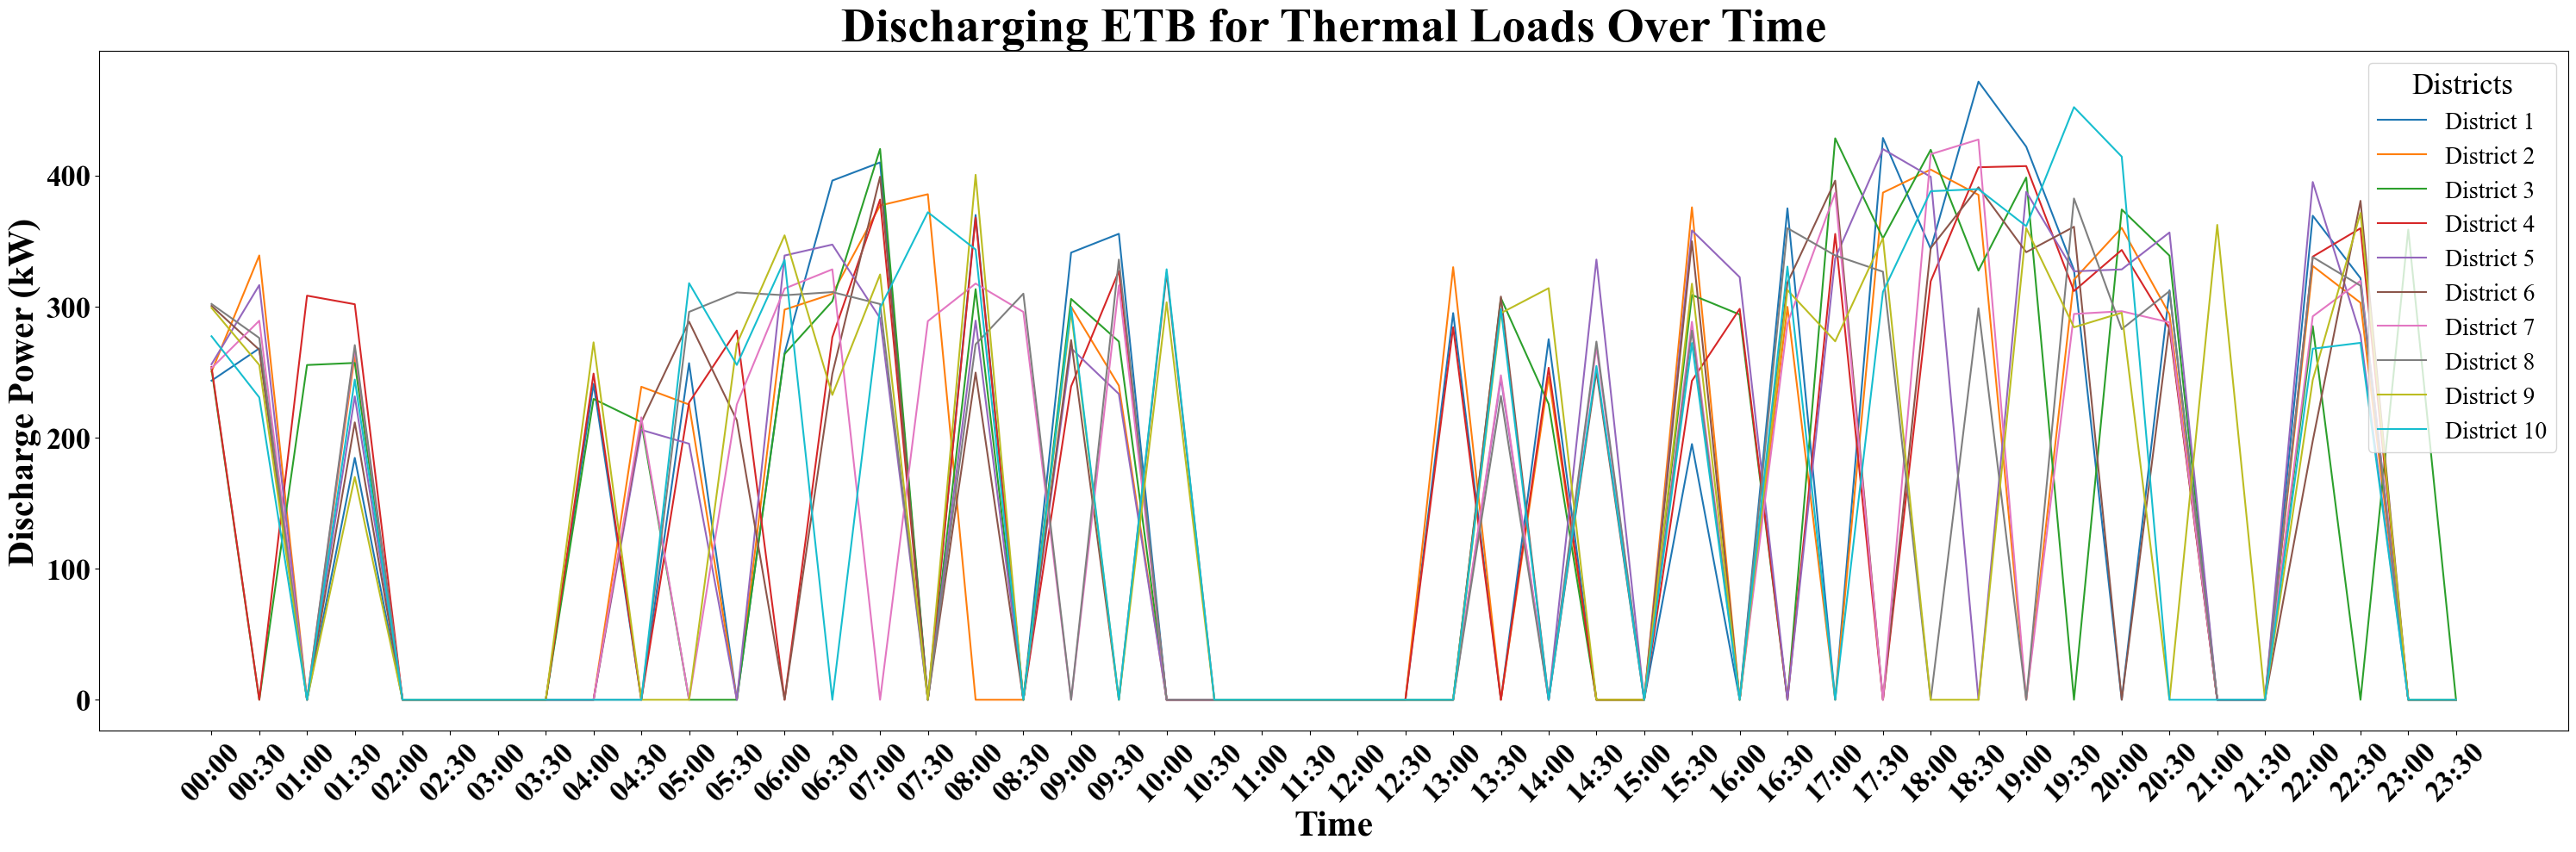

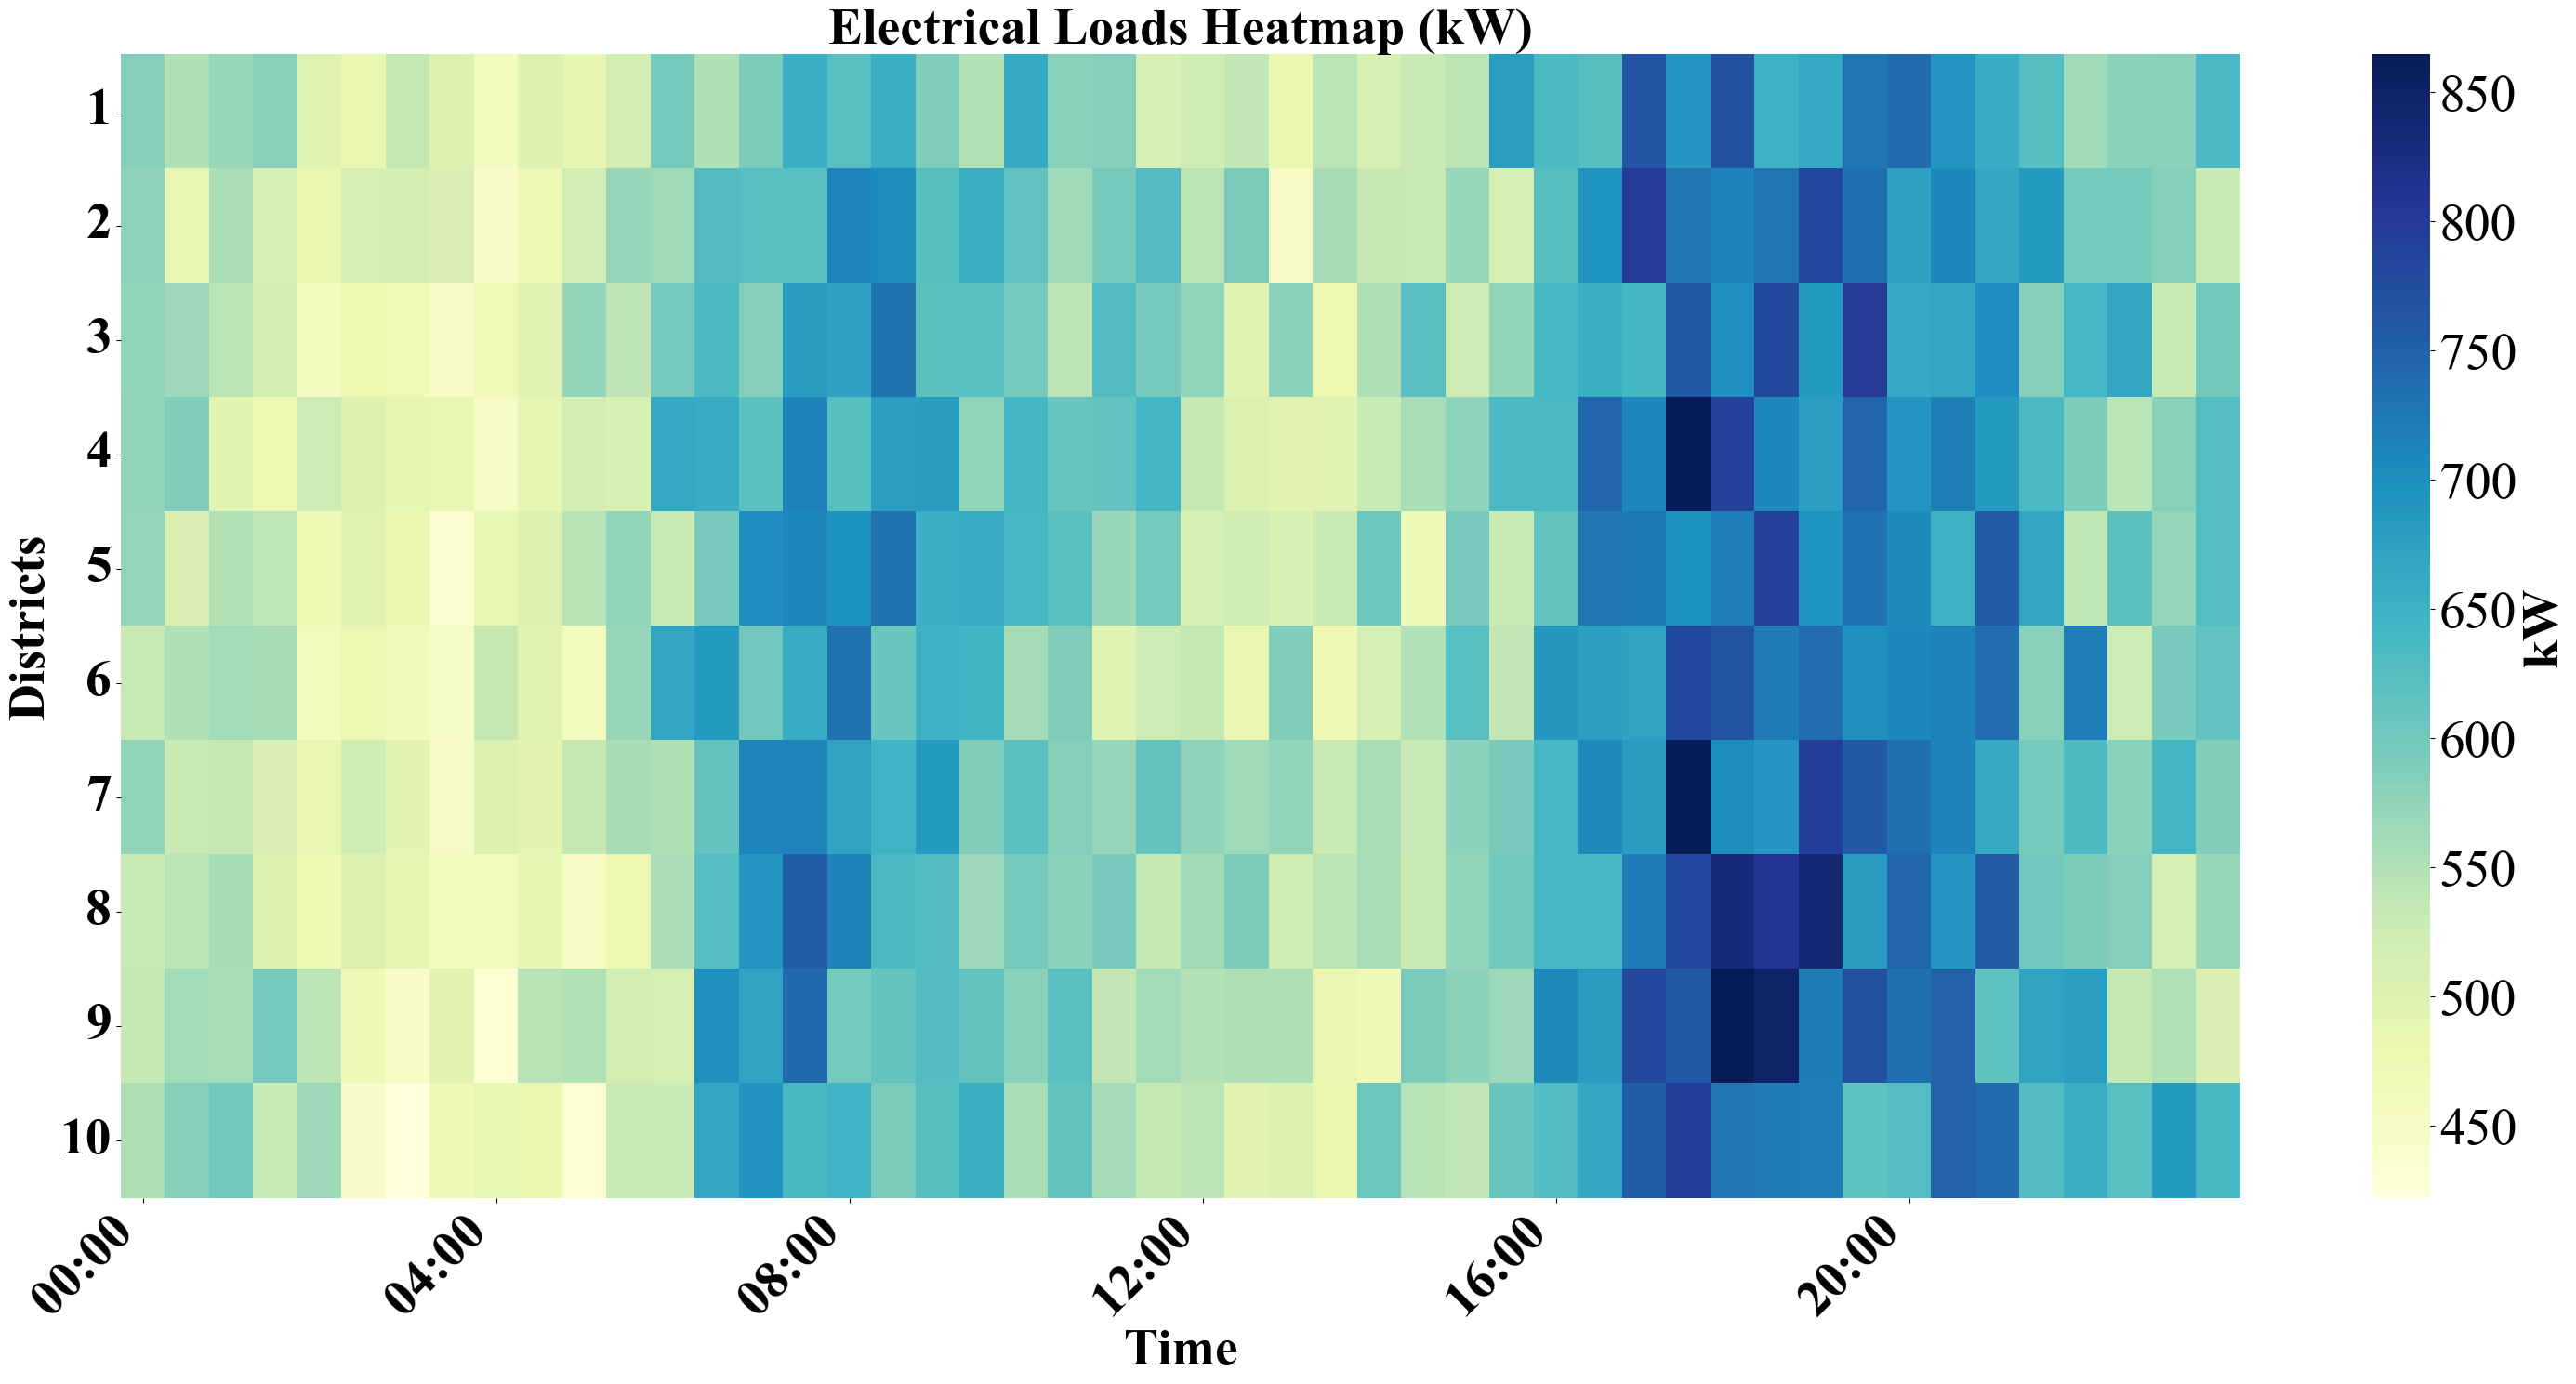

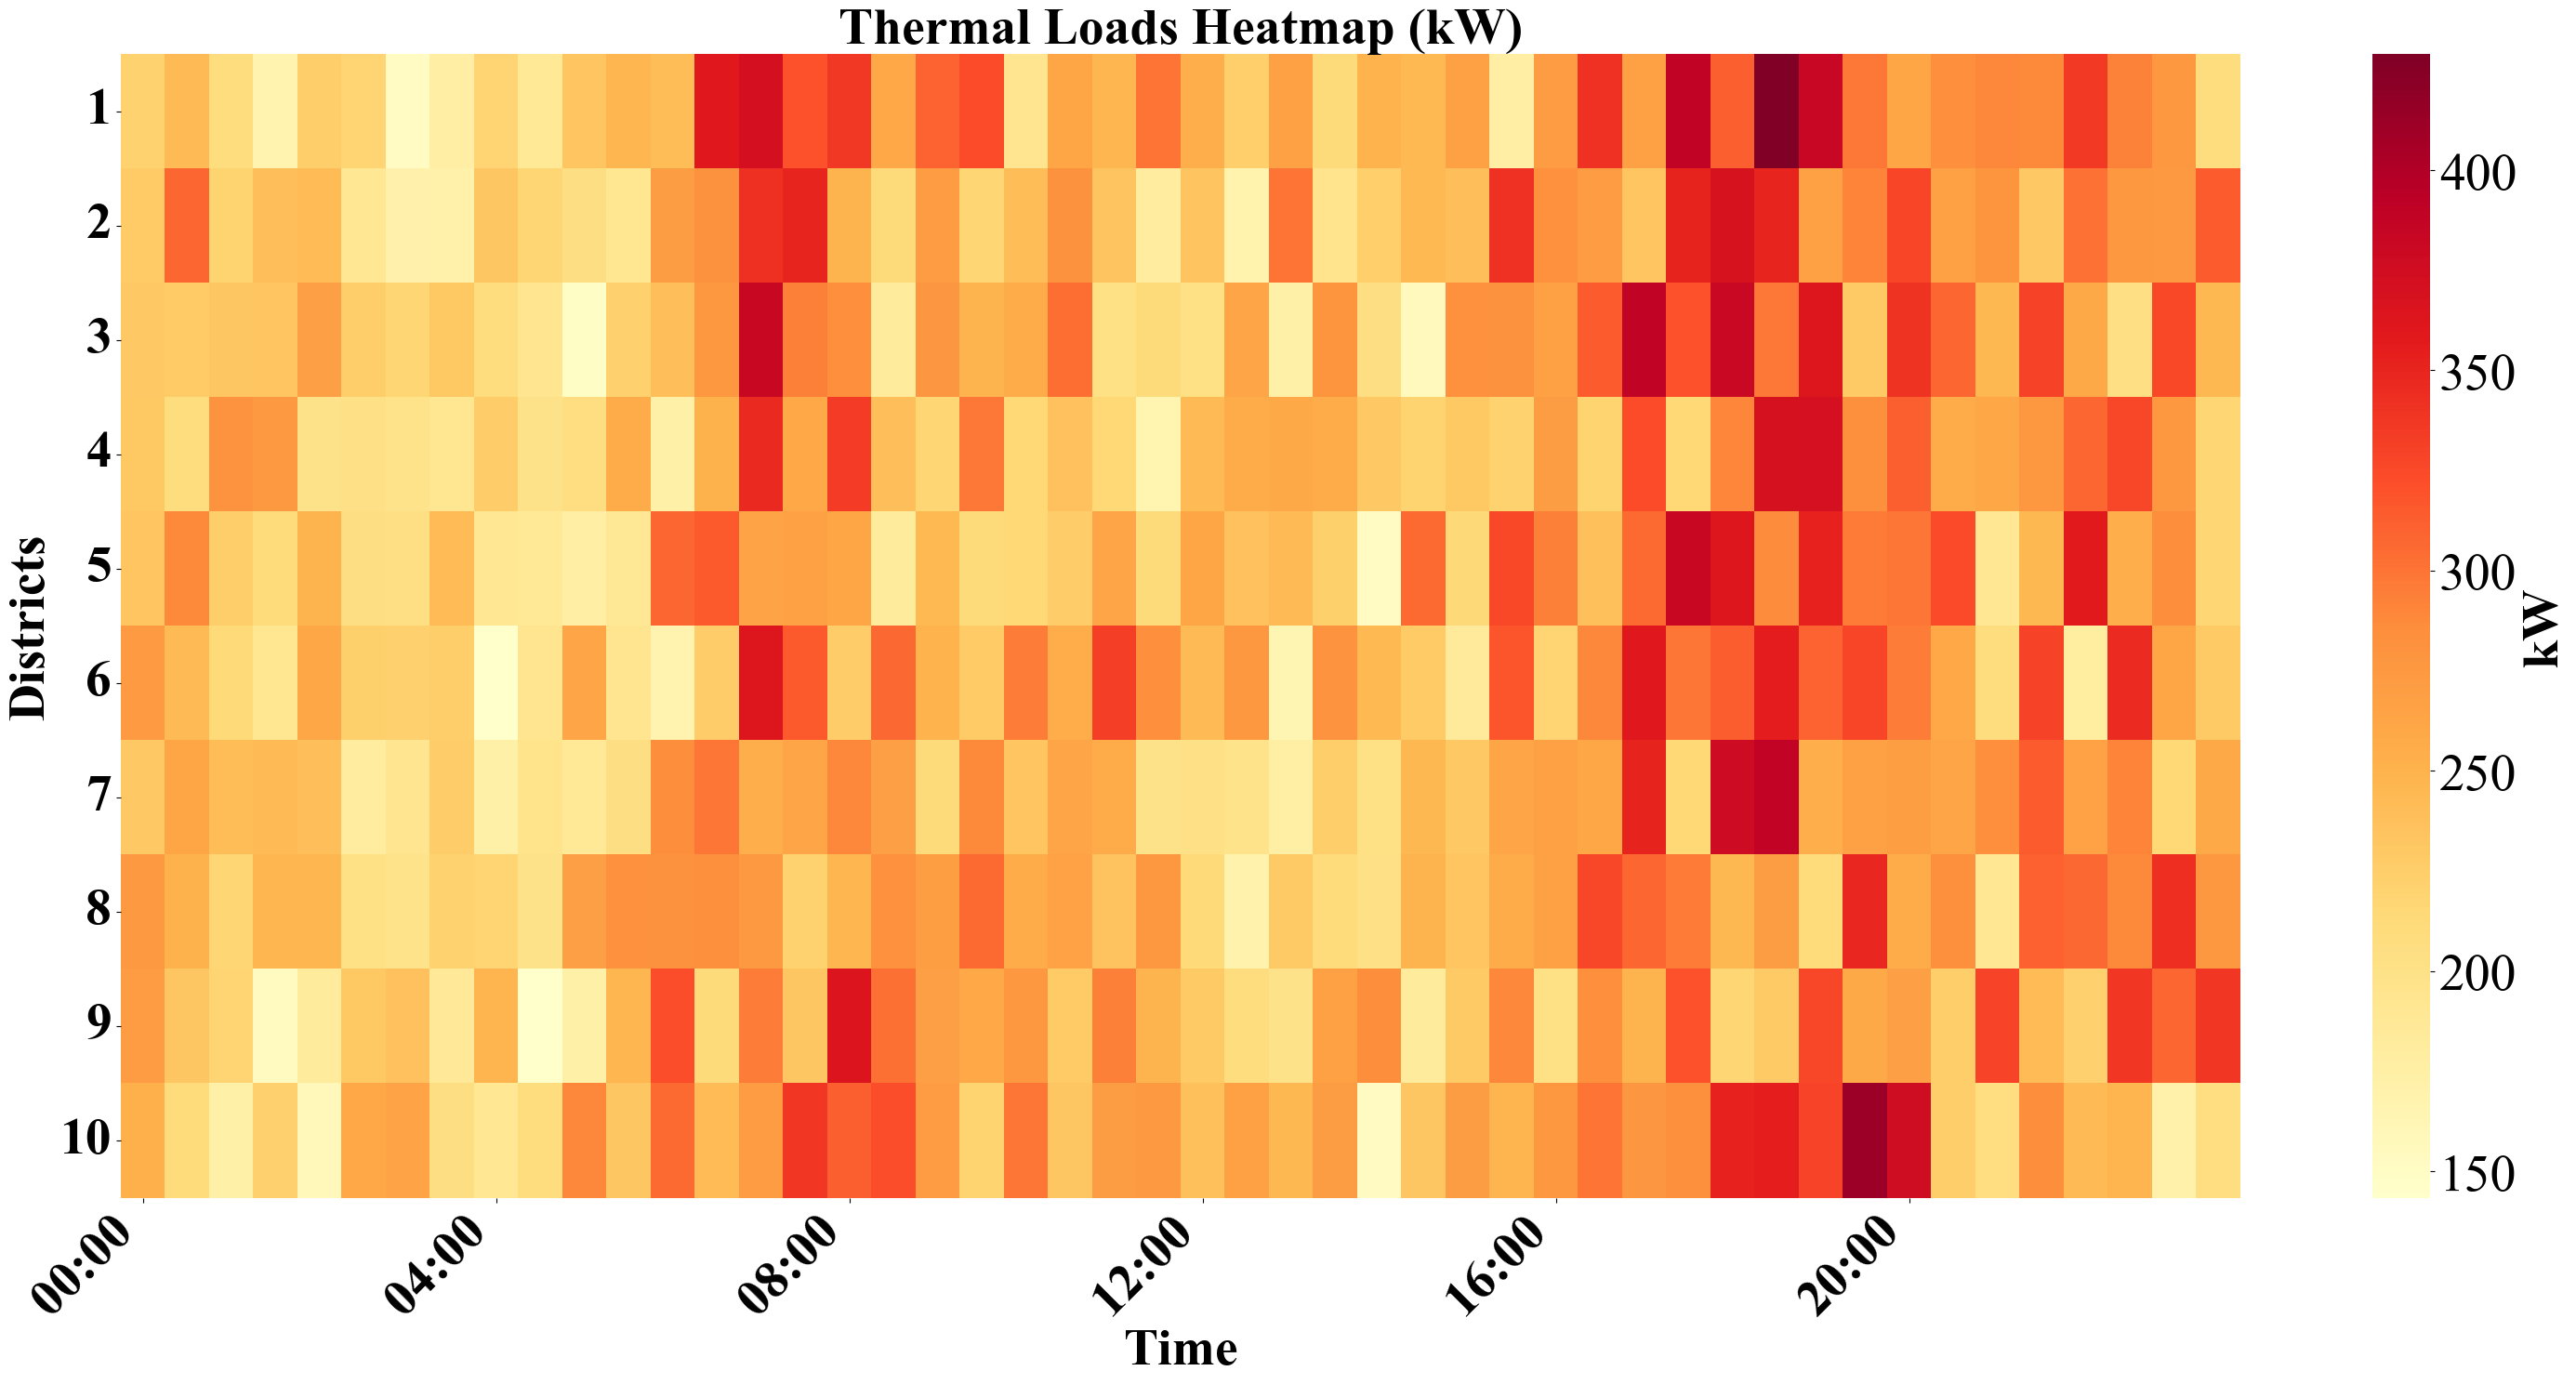

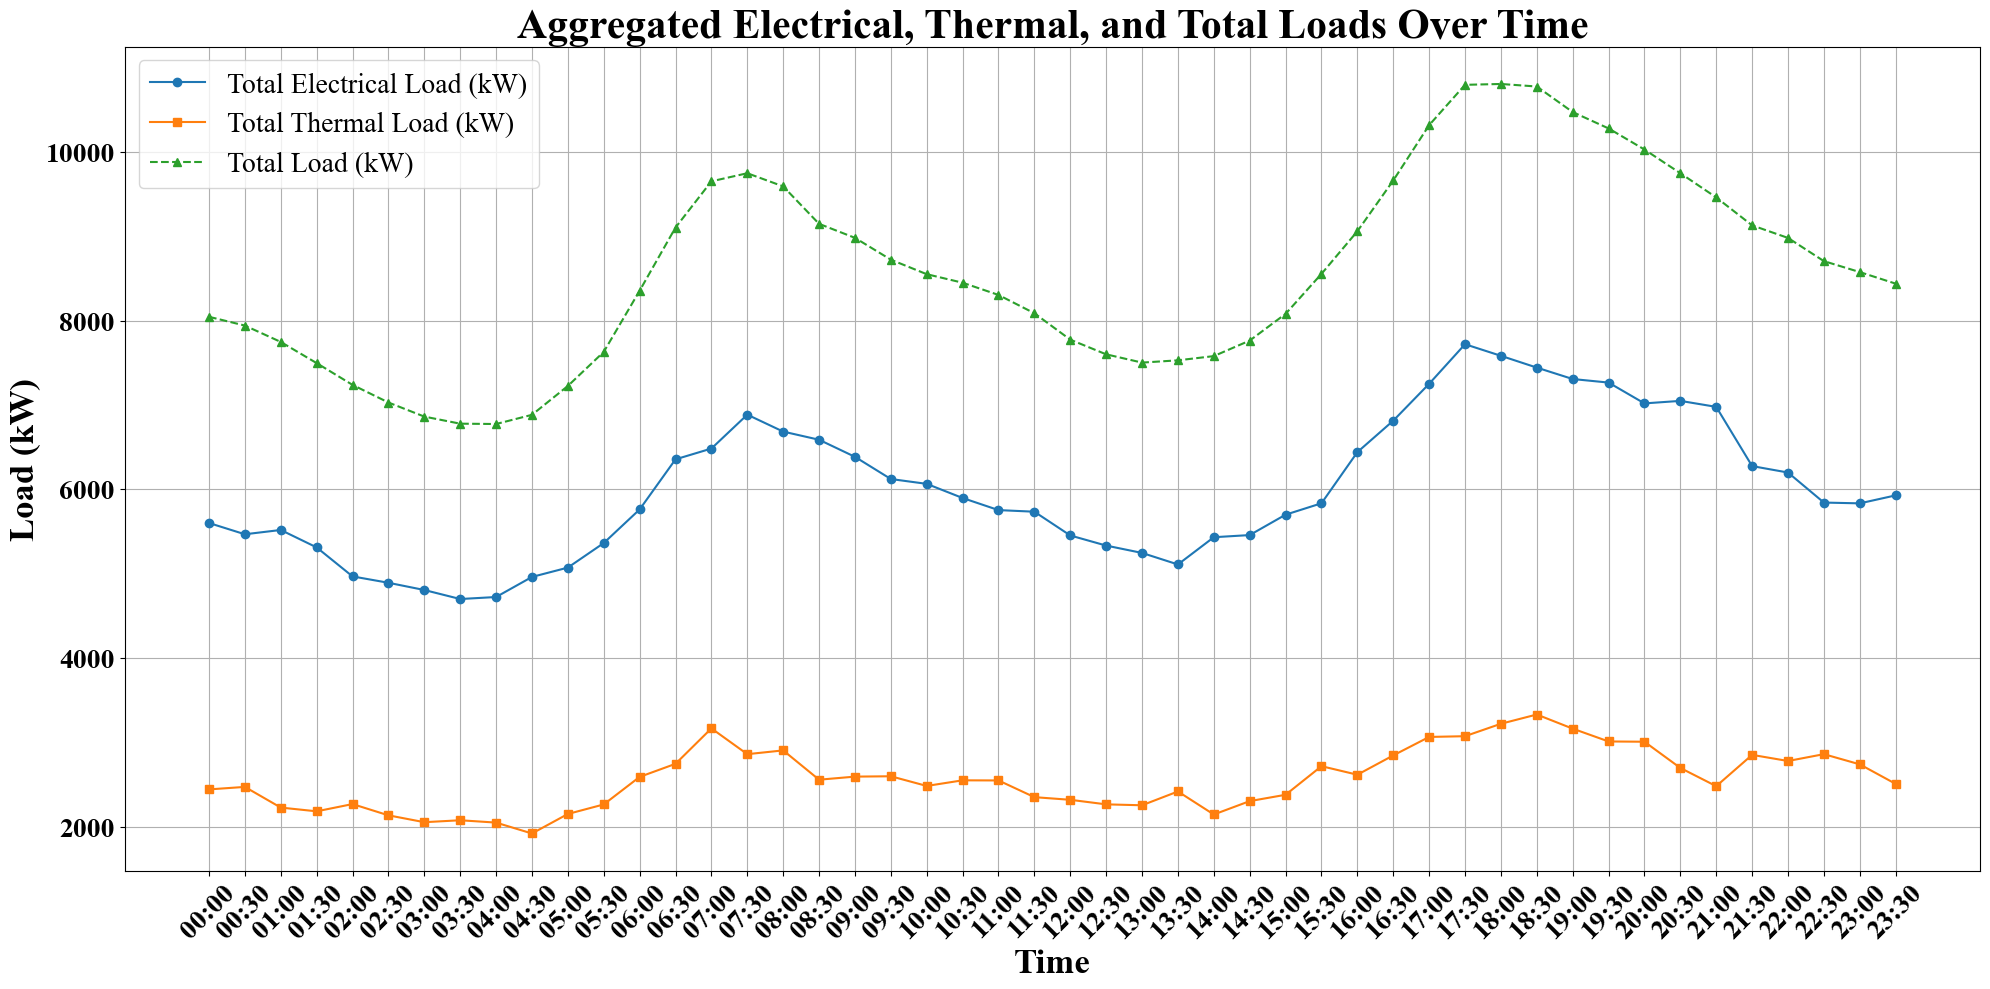

In [25]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported

def load_real_load_profiles_corrected(P_d, districts=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among districts by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each district's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - districts: Number of districts
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - district_elec_loads: numpy array of shape (districts, time_steps) in kW
    - district_therm_loads: numpy array of shape (districts, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    district_elec_loads = np.zeros((districts, time_steps))
    district_therm_loads = np.zeros((districts, time_steps))  # Thermal load

    for d in range(districts):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%

            # Calculate electrical and thermal loads for the district
            P_e = (total_load_kw[t] * elec_ratio) / districts
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / districts

            district_elec_loads[d, t] = P_e
            district_therm_loads[d, t] = P_t

    return district_elec_loads, district_therm_loads

def plot_heatmap(dataframe, title, cmap='viridis', figsize=(30, 15), annot=False, time_labels=None):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - title: Title of the heatmap.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': 'kW'})

    # Customize title, xlabel, ylabel with Times New Roman, size 40, bold
    plt.title(title, fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Districts', fontsize=40, fontweight='bold', fontname='Times New Roman')  # Changed 'Houses' to 'Districts'

    # Customize x-axis and y-axis tick labels with Times New Roman, size 40, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (districts)
    plt.yticks(rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label('kW', fontsize=40, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=40)  # Set colorbar ticks font size

    plt.tight_layout()
    plt.show()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, district_elec_loads, district_therm_loads, districts=10, time_steps=48):
    """
    Visualize electrical and thermal load profiles across districts and time steps.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - district_elec_loads: numpy array of electrical loads per district and time step (in kW)
    - district_therm_loads: numpy array of thermal loads per district and time step (in kW)
    - districts: Number of districts
    - time_steps: Number of time steps
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    district_indices = [f"{d+1}" for d in range(districts)]

    # Create DataFrames
    df_elec = pd.DataFrame(district_elec_loads, index=district_indices, columns=time_labels)
    df_therm = pd.DataFrame(district_therm_loads, index=district_indices, columns=time_labels)

    # Plot Electrical Loads Heatmap
    plot_heatmap(df_elec, 'Electrical Loads Heatmap (kW)', cmap='YlGnBu', time_labels=time_labels)

    # Plot Thermal Loads Heatmap
    plot_heatmap(df_therm, 'Thermal Loads Heatmap (kW)', cmap='YlOrRd', time_labels=time_labels)

    # Aggregate Loads Across Districts
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads
    plt.figure(figsize=(20, 10))
    plt.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o')
    plt.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s')
    plt.plot(time_labels, total_load, label='Total Load (kW)', marker='^', linestyle='--')
    plt.title('Aggregated Electrical, Thermal, and Total Loads Over Time', fontsize=30, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Load (kW)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.xticks(rotation=45, fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.legend(fontsize=20, title_fontsize=25)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Provided Data
    P_d = np.array([
        8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780,
        6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749,
        9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089,
        7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556,
        9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280,
        10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440
    ]) / 1000  # Convert to MW

    Cg_t = np.array([
        99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29,
        81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48,
        92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83,
        56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19,
        151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63,
        154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    districts = 10                         # Number of districts
    time_steps = 48                        # Half-hourly intervals
    scaling_factor_etb = 0.04              # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04              # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per district (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per district (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per district
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per district

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000         # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5       # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000         # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    district_elec_loads, district_therm_loads = load_real_load_profiles_corrected(
        P_d, 
        districts=districts, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # Assuming that the actual load can vary within a certain number of standard deviations
    # For robust optimization, use mean + k * sigma for worst-case
    k = 2  # For approximately 95% confidence interval

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # -----------------------------------
    # 2. Decision Variables
    # -----------------------------------

    # Power Type Battery (PTB) Variables
    ChargePTB = cp.Variable((districts, time_steps), nonneg=True)
    DischargePTB_Elec = cp.Variable((districts, time_steps), nonneg=True)

    # Energy Type Battery (ETB) Variables
    ChargeETB = cp.Variable((districts, time_steps), nonneg=True)
    DischargeETB_Elec = cp.Variable((districts, time_steps), nonneg=True)
    DischargeETB_Therm = cp.Variable((districts, time_steps), nonneg=True)

    # Gas Supply Variable
    GasSupplyTherm = cp.Variable((districts, time_steps), nonneg=True)

    # Grid Power Variables
    GridPowerElec = cp.Variable((districts, time_steps), nonneg=True)

    # State of Charge (SoC) Variables
    SOC_ETB = cp.Variable((districts, time_steps + 1))
    SOC_PTB = cp.Variable((districts, time_steps + 1))

    # **Binary Variables to Prevent Simultaneous Charging and Discharging**
    # PTB Binary Variables
    y_ptb_charge = cp.Variable((districts, time_steps), boolean=True)
    y_ptb_discharge = cp.Variable((districts, time_steps), boolean=True)

    # ETB Binary Variables
    y_etb_charge = cp.Variable((districts, time_steps), boolean=True)
    y_etb_discharge = cp.Variable((districts, time_steps), boolean=True)

    # **SoC Deviation Variables (Linearization)**
    soc_dev_etb_pos = cp.Variable((districts, time_steps + 1), nonneg=True)
    soc_dev_etb_neg = cp.Variable((districts, time_steps + 1), nonneg=True)

    soc_dev_ptb_pos = cp.Variable((districts, time_steps + 1), nonneg=True)
    soc_dev_ptb_neg = cp.Variable((districts, time_steps + 1), nonneg=True)

    # -----------------------------------
    # 3. Constraints
    # -----------------------------------

    # Define target SoC before using it in constraints
    target_soc_etb = 50  # Target SoC in % for ETB
    target_soc_ptb = 50  # Target SoC in % for PTB

    constraints = [
        # Initialize SoC to 50% for all storage systems
        SOC_ETB[:,0] == 50,
        SOC_PTB[:,0] == 50,

        # SoC Deviation Constraints (Linearization)
        SOC_ETB == target_soc_etb + soc_dev_etb_pos - soc_dev_etb_neg,
        SOC_PTB == target_soc_ptb + soc_dev_ptb_pos - soc_dev_ptb_neg
    ]

    for d in range(districts):
        for t in range(time_steps):
            # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
            sigma_elec = 0.05  # 5% standard deviation
            worst_case_elec_load = district_elec_loads[d,t] * (1 + k * sigma_elec)
            constraints += [
                GridPowerElec[d,t] + DischargePTB_Elec[d,t] + DischargeETB_Elec[d,t] == ChargePTB[d,t] + ChargeETB[d,t] + worst_case_elec_load
            ]

            # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
            sigma_therm = 0.05  # 5% standard deviation
            worst_case_therm_load = district_therm_loads[d,t] * (1 + k * sigma_therm)
            # **Modified Thermal Load Balance Constraint**
            constraints += [
                GasSupplyTherm[d,t] + DischargeETB_Therm[d,t] == worst_case_therm_load
            ]

            # **Prevent Simultaneous Charging and Discharging for PTB**
            constraints += [
                ChargePTB[d,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[d,t],
                DischargePTB_Elec[d,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[d,t],
                y_ptb_charge[d,t] + y_ptb_discharge[d,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # **Prevent Simultaneous Charging and Discharging for ETB**
            constraints += [
                ChargeETB[d,t] <= bess_etb_power_capacity_kw * y_etb_charge[d,t],
                DischargeETB_Elec[d,t] + DischargeETB_Therm[d,t] <= bess_etb_power_capacity_kw * y_etb_discharge[d,t],
                y_etb_charge[d,t] + y_etb_discharge[d,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # SoC updates for PTB
            constraints += [
                SOC_PTB[d,t+1] == SOC_PTB[d,t] + (ChargePTB[d,t] * 0.95 - DischargePTB_Elec[d,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
            ]

            # SoC updates for ETB
            constraints += [
                SOC_ETB[d,t+1] == SOC_ETB[d,t] + (ChargeETB[d,t] * 0.95 - (DischargeETB_Elec[d,t] + DischargeETB_Therm[d,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
            ]

            # SoC Limits for PTB and ETB
            constraints += [
                SOC_PTB[d,t+1] >= 20,
                SOC_PTB[d,t+1] <= 100,
                SOC_ETB[d,t+1] >= 20,
                SOC_ETB[d,t+1] <= 100
            ]

    # -----------------------------------
    # 4. Final SoC Constraints
    # -----------------------------------
    # Ensure that all storage systems reach exactly 50% SoC by the end of the day
    constraints += [
        SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
        SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
    ]

    # -----------------------------------
    # 5. Objective Function
    # -----------------------------------

    # Tile Cg_t and Cb_t to match the (districts, time_steps) shape
    Cg_t_matrix = np.tile(Cg_t, (districts, 1))      # Grid electricity tariff ($/kWh)
    Cb_ptb_matrix = np.tile(Cb_ptb, (districts, 1))  # PTB charging cost ($/kWh)
    Cb_etb_matrix = np.tile(Cb_etb, (districts, 1))  # ETB charging cost ($/kWh)

    # Tile the incentives to match the (districts, time_steps) shape
    o_ptb_matrix = np.tile(o_incentive_ptb, (districts, time_steps))          # Charging incentive for PTB ($/kWh)
    o_etb_matrix = np.tile(o_incentive_etb, (districts, time_steps))          # Charging incentive for ETB ($/kWh)
    d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (districts, time_steps))  # PTB discharging incentive ($/kWh)
    d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (districts, time_steps))  # ETB-Elec discharging incentive ($/kWh)
    d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (districts, time_steps))  # ETB-Therm discharging incentive ($/kWh)

    # Define penalty weight for SoC deviation
    soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

    # SoC Deviation Penalty (Linearization using Absolute Deviations)
    soc_penalty = soc_penalty_weight * (
        cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
        cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
    )

    # Charging Incentives
    total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                 cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

    # Incentives from Discharging PTB and ETB
    total_incentives = (
        cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
        cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
        cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
    )

    # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
    total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix))
    total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
    total_battery_cost = (
        cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
        cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
    )

    # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
    objective = cp.Minimize(
        total_grid_cost + 
        total_gas_cost + 
        total_battery_cost - 
        total_incentives - 
        total_charging_incentives + 
        soc_penalty
    )

    # -----------------------------------
    # 6. Define and Solve the Problem
    # -----------------------------------

    prob = cp.Problem(objective, constraints)

    # Set the Gurobi license file path
    os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

    # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
    # Ensure that Gurobi is installed and properly licensed.
    try:
        prob.solve(solver=cp.GUROBI, verbose=True, mip_gap=0.01, threads=4)
    except cp.error.SolverError:
        print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
        # Optionally, you can fallback to another solver here
        try:
            prob.solve(solver=cp.GLPK_MI, verbose=True, mip_gap=0.01)
        except cp.error.SolverError as e:
            print("Both Gurobi and GLPK_MI solvers failed.")
            print(str(e))
            return

    # -----------------------------------
    # 7. Check Solution and Extract Results
    # -----------------------------------
    
    if prob.status not in ["infeasible", "unbounded"]:
        print(f"Optimal Total Cost: ${prob.value:.2f}")
        
        # Extract optimized variables
        charge_ptb_opt = ChargePTB.value
        discharge_ptb_elec_opt = DischargePTB_Elec.value

        charge_etb_opt = ChargeETB.value
        discharge_etb_elec_opt = DischargeETB_Elec.value
        discharge_etb_therm_opt = DischargeETB_Therm.value

        gas_supply_therm_opt = GasSupplyTherm.value
        grid_elec_opt = GridPowerElec.value

        soc_etb_opt = SOC_ETB.value
        soc_ptb_opt = SOC_PTB.value

        soc_dev_etb_pos_opt = soc_dev_etb_pos.value
        soc_dev_etb_neg_opt = soc_dev_etb_neg.value

        soc_dev_ptb_pos_opt = soc_dev_ptb_pos.value
        soc_dev_ptb_neg_opt = soc_dev_ptb_neg.value

        # Define district indices and generate actual time labels
        district_indices = [f"{d+1}" for d in range(districts)]
        time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)

        # Create DataFrames for Visualization
        # 1. Electrical Loads Heatmap
        df_elec_loads = pd.DataFrame(district_elec_loads, index=district_indices, columns=time_labels)

        # 2. Thermal Loads Heatmap
        df_therm_loads = pd.DataFrame(district_therm_loads, index=district_indices, columns=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        df_gas_supply_therm = pd.DataFrame(gas_supply_therm_opt, index=district_indices, columns=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        df_grid_supply_elec = pd.DataFrame(grid_elec_opt, index=district_indices, columns=time_labels)

        # 5. Battery Operations Heatmaps
        df_charge_ptb = pd.DataFrame(charge_ptb_opt, index=district_indices, columns=time_labels)
        df_discharge_ptb_elec = pd.DataFrame(discharge_ptb_elec_opt, index=district_indices, columns=time_labels)

        df_charge_etb = pd.DataFrame(charge_etb_opt, index=district_indices, columns=time_labels)
        df_discharge_etb_elec = pd.DataFrame(discharge_etb_elec_opt, index=district_indices, columns=time_labels)
        df_discharge_etb_therm = pd.DataFrame(discharge_etb_therm_opt, index=district_indices, columns=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        net_ptb_elec = discharge_ptb_elec_opt - charge_ptb_opt  # Positive: net discharge
        df_net_ptb_elec = pd.DataFrame(net_ptb_elec, index=district_indices, columns=time_labels)

        # Net ETB Operations for Electrical Loads
        net_etb_elec = discharge_etb_elec_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_elec = pd.DataFrame(net_etb_elec, index=district_indices, columns=time_labels)

        # Net ETB Operations for Thermal Loads
        net_etb_therm = discharge_etb_therm_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_therm = pd.DataFrame(net_etb_therm, index=district_indices, columns=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        total_ptb_contribution = discharge_ptb_elec_opt
        df_total_ptb_contribution = pd.DataFrame(total_ptb_contribution, index=district_indices, columns=time_labels)

        # Total ETB Contribution (Electrical)
        total_etb_elec_contribution = discharge_etb_elec_opt
        df_total_etb_elec_contribution = pd.DataFrame(total_etb_elec_contribution, index=district_indices, columns=time_labels)

        # Total ETB Contribution (Thermal)
        total_etb_therm_contribution = discharge_etb_therm_opt
        df_total_etb_therm_contribution = pd.DataFrame(total_etb_therm_contribution, index=district_indices, columns=time_labels)

        # 8. State of Charge (SoC) Heatmaps
        # Remove the last column for SoC at t=48 to align with time_steps
        soc_etb_current = soc_etb_opt[:, :-1]  # Shape: (districts, time_steps)
        soc_ptb_current = soc_ptb_opt[:, :-1]  # Shape: (districts, time_steps)
        df_soc_etb = pd.DataFrame(soc_etb_current, index=district_indices, columns=time_labels)
        df_soc_ptb = pd.DataFrame(soc_ptb_current, index=district_indices, columns=time_labels)

        # 9. Power Balance Calculation
        # Recompute worst-case loads
        worst_case_elec_loads = district_elec_loads * (1 + k * sigma_elec)
        worst_case_therm_loads = district_therm_loads * (1 + k * sigma_therm)

        # Recompute total supply and demand
        total_supply_elec = grid_elec_opt + discharge_ptb_elec_opt + discharge_etb_elec_opt
        total_load_elec = charge_ptb_opt + charge_etb_opt + worst_case_elec_loads
        residual_elec = total_supply_elec - total_load_elec  # Should be zero

        total_supply_therm = gas_supply_therm_opt + discharge_etb_therm_opt
        total_load_therm = worst_case_therm_loads  # Updated to exclude ChargeETB
        residual_therm = total_supply_therm - total_load_therm  # Should be zero

        # Combine residuals
        residual_total = residual_elec + residual_therm  # Should be zero
        df_residual_total = pd.DataFrame(residual_total, index=district_indices, columns=time_labels)

        # -----------------------------------
        # 10. Visualization: Plot Heatmaps
        # -----------------------------------

        # Set global font settings for Times New Roman
        rcParams['font.family'] = 'Times New Roman'

        # 1. Electrical Loads Heatmap
        plot_heatmap(df_elec_loads, 'Electrical Loads Heatmap (kW)', cmap='YlGnBu', time_labels=time_labels)

        # 2. Thermal Loads Heatmap
        plot_heatmap(df_therm_loads, 'Thermal Loads Heatmap (kW)', cmap='YlOrRd', time_labels=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        plot_heatmap(df_gas_supply_therm, 'Gas Supply for Thermal Loads Heatmap', time_labels=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        plot_heatmap(df_grid_supply_elec, 'Grid Supply for Electrical Loads Heatmap', time_labels=time_labels)

        # 5. Battery Operations Heatmaps
        # Plot Charging PTB
        plot_heatmap(df_charge_ptb, 'Charging PTB Heatmap', time_labels=time_labels)

        # Plot Discharging PTB for Electrical Loads
        plot_heatmap(df_discharge_ptb_elec, 'Discharging PTB (Electrical) Heatmap', time_labels=time_labels)

        # Plot Charging ETB
        plot_heatmap(df_charge_etb, 'Charging ETB Heatmap', time_labels=time_labels)

        # Plot Discharging ETB for Electrical Loads
        plot_heatmap(df_discharge_etb_elec, 'Discharging ETB (Electrical) Heatmap', time_labels=time_labels)

        # Plot Discharging ETB for Thermal Loads
        plot_heatmap(df_discharge_etb_therm, 'Discharging ETB (Thermal) Heatmap', time_labels=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        plot_heatmap(df_net_ptb_elec, 'Net PTB Operations for Electrical Loads Heatmap', time_labels=time_labels)

        # Net ETB Operations for Electrical Loads
        plot_heatmap(df_net_etb_elec, 'Net ETB Operations for Electrical Loads Heatmap', time_labels=time_labels)

        # Net ETB Operations for Thermal Loads
        plot_heatmap(df_net_etb_therm, 'Net ETB Operations for Thermal Loads Heatmap', time_labels=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        plot_heatmap(df_total_ptb_contribution, 'Total PTB Contribution (Electrical) Heatmap', time_labels=time_labels)

        # Total ETB Contribution (Electrical)
        plot_heatmap(df_total_etb_elec_contribution, 'Total ETB Contribution (Electrical) Heatmap', time_labels=time_labels)

        # Total ETB Contribution (Thermal)
        plot_heatmap(df_total_etb_therm_contribution, 'Total ETB Contribution (Thermal) Heatmap', time_labels=time_labels)

        # 8. State of Charge (SoC) Heatmaps
        # SoC ETB
        plot_heatmap(df_soc_etb, 'State of Charge (ETB) Heatmap', cmap='YlGnBu', time_labels=time_labels)

        # SoC PTB
        plot_heatmap(df_soc_ptb, 'State of Charge (PTB) Heatmap', cmap='YlGnBu', time_labels=time_labels)

        # 9. Power Balance Residuals Heatmap
        # Power Balance Residuals Heatmap (Absolute)
        df_residual_absolute = df_residual_total.abs()
        plot_heatmap(df_residual_absolute, 'Power Balance Residual Heatmap (Absolute)', cmap='Reds', time_labels=time_labels)

        # Power Balance Residuals Heatmap (Signed)
        plot_heatmap(df_residual_total, 'Power Balance Residual Heatmap (Signed)', cmap='RdBu_r', time_labels=time_labels)

        # -----------------------------------
        # 11. Additional Visualization: ETB Operations
        # -----------------------------------
        # Plot Discharging ETB for Thermal Loads
        plt.figure(figsize=(30, 10))
        for d in range(districts):
            plt.plot(time_labels, discharge_etb_therm_opt[d], label=f'District {d+1}')  # Changed 'House' to 'District'
        plt.title('Discharging ETB for Thermal Loads Over Time', fontsize=40, fontweight='bold', fontname='Times New Roman')
        plt.xlabel('Time', fontsize=30, fontweight='bold', fontname='Times New Roman')
        plt.ylabel('Discharge Power (kW)', fontsize=30, fontweight='bold', fontname='Times New Roman')
        plt.xticks(rotation=45, fontsize=25, fontname='Times New Roman', fontweight='bold')
        plt.yticks(fontsize=25, fontname='Times New Roman', fontweight='bold')
        plt.legend(fontsize=20, loc='upper right', title='Districts', title_fontsize=25)  # Changed 'Houses' to 'Districts'
        plt.tight_layout()
        plt.show()

        # -----------------------------------
        # 12. Additional Visualization: Aggregated Load Profiles
        # -----------------------------------
        visualize_load_profiles(P_d, district_elec_loads, district_therm_loads, districts=districts, time_steps=time_steps)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    import sys
    import subprocess
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    main_robust_mpc_corrected()


In [11]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported

def load_real_load_profiles_corrected(P_d, houses=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among houses by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each house's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - houses: Number of houses
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - house_elec_loads: numpy array of shape (houses, time_steps) in kW
    - house_therm_loads: numpy array of shape (houses, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    house_elec_loads = np.zeros((houses, time_steps))
    house_therm_loads = np.zeros((houses, time_steps))  # Thermal load

    for h in range(houses):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the house
            P_e = (total_load_kw[t] * elec_ratio) / houses
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / houses
            
            house_elec_loads[h, t] = P_e
            house_therm_loads[h, t] = P_t

    return house_elec_loads, house_therm_loads

def plot_heatmap(dataframe, save_path, cmap='viridis', figsize=(60, 30), annot=False, time_labels=None, cbar_label='kW'):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps, and saves it as a PDF.

    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - save_path: File path to save the PDF image.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    - cbar_label: Label for the colorbar.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': cbar_label})

    # Customize xlabel and ylabel with Times New Roman, size 150, bold
    plt.xlabel('Time', fontsize=150, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Houses', fontsize=150, fontweight='bold', fontname='Times New Roman')

    # Customize x-axis and y-axis tick labels with Times New Roman, size 150, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (houses)
    plt.yticks(rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_label, fontsize=150, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=150)  # Set colorbar ticks font size

    # Adjust layout to prevent clipping
    plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.15)
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.close()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, Cg_t, houses=10, time_steps=48, plots_dir='plots'):
    """
    Visualize electrical and thermal load profiles across houses and time steps, and save plots as PDFs.
    Additionally, plots the tariff price on a secondary y-axis in the Aggregated Load plot as a dotted line.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)
    - Cg_t: numpy array of tariff prices per time step ($/kWh)
    - houses: Number of houses
    - time_steps: Number of time steps
    - plots_dir: Directory to save the PDF plots
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    house_indices = [f"{h+1}" for h in range(houses)]  # Removed "House " prefix

    # Create DataFrames
    df_elec = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)
    df_therm = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    save_path_elec = os.path.join(plots_dir, 'Electrical_Loads_Heatmap.pdf')
    plot_heatmap(df_elec, save_path_elec, cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    save_path_therm = os.path.join(plots_dir, 'Thermal_Loads_Heatmap.pdf')
    plot_heatmap(df_therm, save_path_therm, cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads with Tariff Price
    fig, ax1 = plt.subplots(figsize=(60, 30))

    # Plot loads on primary y-axis
    ax1.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_load, label='Total Load (kW)', marker='^', markersize=20, linewidth=5, linestyle='--')
    ax1.set_xlabel('Time', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax1.set_ylabel('Load (kW)', fontsize=100, fontweight='bold', fontname='Times New Roman')

    # Calculate Tick Positions and Labels for Every 2 Hours
    step = 4  # Every 2 hours (4 half-hourly intervals)
    xticks_positions = np.arange(0, len(time_labels), step)
    xticks_labels = [time_labels[i] for i in xticks_positions]

    # Update X-ticks to Appear Every 2 Hours
    ax1.set_xticks(xticks_positions)
    ax1.set_xticklabels(xticks_labels, rotation=45, fontsize=100, fontname='Times New Roman', fontweight='bold')

    # Update Y-ticks Font Settings
    ax1.tick_params(axis='y', labelsize=100)

    # Create secondary y-axis for tariff price
    ax2 = ax1.twinx()
    ax2.plot(time_labels, Cg_t, label='Tariff Price ($/kWh)', color='black', linestyle=':', linewidth=5)
    ax2.set_ylabel('Tariff Price ($/kWh)', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax2.tick_params(axis='y', labelsize=100)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=100, title_fontsize=100)

    # Enable grid for better readability
    ax1.grid(True)

    # Adjust layout to prevent clipping
    fig.subplots_adjust(left=0.2, right=0.85, top=0.95, bottom=0.15)
    
    # Apply tight layout for optimal spacing
    plt.tight_layout()

    # Save the Plot as a High-Resolution PDF
    save_path_aggregated = os.path.join(plots_dir, 'Aggregated_Loads_Over_Time.pdf')
    plt.savefig(save_path_aggregated, format='pdf')

    # Close the Plot to Free Memory
    plt.close()

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Ensure the plots directory exists
    plots_dir = 'plots'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    # Provided Data
    P_d = np.array([
        8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780,
        6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749,
        9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089,
        7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556,
        9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280,
        10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440
    ]) / 1000  # Convert to MW

    Cg_t = np.array([
        99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29,
        81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48,
        92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83,
        56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19,
        151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63,
        154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    houses = 10                          # Number of houses
    time_steps = 48                      # Half-hourly intervals
    scaling_factor_etb = 0.04            # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04            # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per house (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per house (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per house
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per house

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000    # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5      # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000    # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    house_elec_loads, house_therm_loads = load_real_load_profiles_corrected(
        P_d, 
        houses=houses, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # Assuming that the actual load can vary within a certain number of standard deviations
    # For robust optimization, use mean + k * sigma for worst-case
    k = 2  # For approximately 95% confidence interval

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # -----------------------------------
    # 2. Decision Variables
    # -----------------------------------

    # Power Type Battery (PTB) Variables
    ChargePTB = cp.Variable((houses, time_steps), nonneg=True)
    DischargePTB_Elec = cp.Variable((houses, time_steps), nonneg=True)

    # Energy Type Battery (ETB) Variables
    ChargeETB = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Elec = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Therm = cp.Variable((houses, time_steps), nonneg=True)

    # Gas Supply Variable
    GasSupplyTherm = cp.Variable((houses, time_steps), nonneg=True)

    # Grid Power Variables
    GridPowerElec = cp.Variable((houses, time_steps), nonneg=True)

    # State of Charge (SoC) Variables
    SOC_ETB = cp.Variable((houses, time_steps + 1))
    SOC_PTB = cp.Variable((houses, time_steps + 1))

    # **Binary Variables to Prevent Simultaneous Charging and Discharging**
    # PTB Binary Variables
    y_ptb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_ptb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # ETB Binary Variables
    y_etb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_etb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # **SoC Deviation Variables (Linearization)**
    soc_dev_etb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_etb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    soc_dev_ptb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_ptb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    # -----------------------------------
    # 3. Constraints
    # -----------------------------------

    # Define target SoC before using it in constraints
    target_soc_etb = 50  # Target SoC in % for ETB
    target_soc_ptb = 50  # Target SoC in % for PTB

    constraints = [
        # Initialize SoC to 50% for all storage systems
        SOC_ETB[:,0] == 50,
        SOC_PTB[:,0] == 50,

        # SoC Deviation Constraints (Linearization)
        SOC_ETB == target_soc_etb + soc_dev_etb_pos - soc_dev_etb_neg,
        SOC_PTB == target_soc_ptb + soc_dev_ptb_pos - soc_dev_ptb_neg
    ]

    for h in range(houses):
        for t in range(time_steps):
            # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
            sigma_elec = 0.05  # 5% standard deviation
            worst_case_elec_load = house_elec_loads[h,t] * (1 + k * sigma_elec)
            constraints += [
                GridPowerElec[h,t] + DischargePTB_Elec[h,t] + DischargeETB_Elec[h,t] == ChargePTB[h,t] + ChargeETB[h,t] + worst_case_elec_load
            ]

            # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
            sigma_therm = 0.05  # 5% standard deviation
            worst_case_therm_load = house_therm_loads[h,t] * (1 + k * sigma_therm)
            # **Modified Thermal Load Balance Constraint**
            constraints += [
                GasSupplyTherm[h,t] + DischargeETB_Therm[h,t] == worst_case_therm_load
            ]

            # **Prevent Simultaneous Charging and Discharging for PTB**
            constraints += [
                ChargePTB[h,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[h,t],
                DischargePTB_Elec[h,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[h,t],
                y_ptb_charge[h,t] + y_ptb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # **Prevent Simultaneous Charging and Discharging for ETB**
            constraints += [
                ChargeETB[h,t] <= bess_etb_power_capacity_kw * y_etb_charge[h,t],
                DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t] <= bess_etb_power_capacity_kw * y_etb_discharge[h,t],
                y_etb_charge[h,t] + y_etb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # SoC updates for PTB
            constraints += [
                SOC_PTB[h,t+1] == SOC_PTB[h,t] + (ChargePTB[h,t] * 0.95 - DischargePTB_Elec[h,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
            ]

            # SoC updates for ETB
            constraints += [
                SOC_ETB[h,t+1] == SOC_ETB[h,t] + (ChargeETB[h,t] * 0.95 - (DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
            ]

            # SoC Limits for PTB and ETB
            constraints += [
                SOC_PTB[h,t+1] >= 20,
                SOC_PTB[h,t+1] <= 100,
                SOC_ETB[h,t+1] >= 20,
                SOC_ETB[h,t+1] <= 100
            ]

    # -----------------------------------
    # 4. Final SoC Constraints
    # -----------------------------------
    # Ensure that all storage systems reach exactly 50% SoC by the end of the day
    constraints += [
        SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
        SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
    ]

    # -----------------------------------
    # 5. Objective Function
    # -----------------------------------

    # Tile Cg_t and Cb_t to match the (houses, time_steps) shape
    Cg_t_matrix = np.tile(Cg_t, (houses, 1))      # Grid electricity tariff ($/kWh)
    Cb_ptb_matrix = np.tile(Cb_ptb, (houses, 1))  # PTB charging cost ($/kWh)
    Cb_etb_matrix = np.tile(Cb_etb, (houses, 1))  # ETB charging cost ($/kWh)

    # Tile the incentives to match the (houses, time_steps) shape
    o_ptb_matrix = np.tile(o_incentive_ptb, (houses, time_steps))          # Charging incentive for PTB ($/kWh)
    o_etb_matrix = np.tile(o_incentive_etb, (houses, time_steps))          # Charging incentive for ETB ($/kWh)
    d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (houses, time_steps))  # PTB discharging incentive ($/kWh)
    d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (houses, time_steps))  # ETB-Elec discharging incentive ($/kWh)
    d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (houses, time_steps))  # ETB-Therm discharging incentive ($/kWh)

    # Define penalty weight for SoC deviation
    soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

    # SoC Deviation Penalty (Linearization using Absolute Deviations)
    soc_penalty = soc_penalty_weight * (
        cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
        cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
    )

    # Charging Incentives
    total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                 cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

    # Incentives from Discharging PTB and ETB
    total_incentives = (
        cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
        cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
        cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
    )

    # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
    total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix))
    total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
    total_battery_cost = (
        cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
        cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
    )

    # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
    objective = cp.Minimize(
        total_grid_cost + 
        total_gas_cost + 
        total_battery_cost - 
        total_incentives - 
        total_charging_incentives + 
        soc_penalty
    )

    # -----------------------------------
    # 6. Define and Solve the Problem
    # -----------------------------------

    prob = cp.Problem(objective, constraints)

    # Set the Gurobi license file path
    os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

    # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
    # Ensure that Gurobi is installed and properly licensed.
    try:
        prob.solve(solver=cp.GUROBI, verbose=True, mip_gap=0.01, threads=4)
    except cp.error.SolverError:
        print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
        # Optionally, you can fallback to another solver here
        try:
            prob.solve(solver=cp.GLPK_MI, verbose=True, mip_gap=0.01)
        except cp.error.SolverError as e:
            print("Both Gurobi and GLPK_MI solvers failed.")
            print(str(e))
            return

    # -----------------------------------
    # 7. Check Solution and Extract Results
    # -----------------------------------
    
    if prob.status not in ["infeasible", "unbounded"]:
        print(f"Optimal Total Cost: ${prob.value:.2f}")
        
        # Extract optimized variables
        charge_ptb_opt = ChargePTB.value
        discharge_ptb_elec_opt = DischargePTB_Elec.value

        charge_etb_opt = ChargeETB.value
        discharge_etb_elec_opt = DischargeETB_Elec.value
        discharge_etb_therm_opt = DischargeETB_Therm.value

        gas_supply_therm_opt = GasSupplyTherm.value
        grid_elec_opt = GridPowerElec.value

        soc_etb_opt = SOC_ETB.value
        soc_ptb_opt = SOC_PTB.value

        soc_dev_etb_pos_opt = soc_dev_etb_pos.value
        soc_dev_etb_neg_opt = soc_dev_etb_neg.value

        soc_dev_ptb_pos_opt = soc_dev_ptb_pos.value
        soc_dev_ptb_neg_opt = soc_dev_ptb_neg.value

        # Define house indices and generate actual time labels
        house_indices = [f"{h+1}" for h in range(houses)]
        time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)

        # Create DataFrames for Visualization
        # 1. Electrical Loads Heatmap
        df_elec_loads = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)

        # 2. Thermal Loads Heatmap
        df_therm_loads = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        df_gas_supply_therm = pd.DataFrame(gas_supply_therm_opt, index=house_indices, columns=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        df_grid_supply_elec = pd.DataFrame(grid_elec_opt, index=house_indices, columns=time_labels)

        # 5. Battery Operations Heatmaps
        df_charge_ptb = pd.DataFrame(charge_ptb_opt, index=house_indices, columns=time_labels)
        df_discharge_ptb_elec = pd.DataFrame(discharge_ptb_elec_opt, index=house_indices, columns=time_labels)

        df_charge_etb = pd.DataFrame(charge_etb_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_elec = pd.DataFrame(discharge_etb_elec_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_therm = pd.DataFrame(discharge_etb_therm_opt, index=house_indices, columns=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        net_ptb_elec = discharge_ptb_elec_opt - charge_ptb_opt  # Positive: net discharge
        df_net_ptb_elec = pd.DataFrame(net_ptb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Electrical Loads
        net_etb_elec = discharge_etb_elec_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_elec = pd.DataFrame(net_etb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Thermal Loads
        net_etb_therm = discharge_etb_therm_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_therm = pd.DataFrame(net_etb_therm, index=house_indices, columns=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        total_ptb_contribution = discharge_ptb_elec_opt
        df_total_ptb_contribution = pd.DataFrame(total_ptb_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Electrical)
        total_etb_elec_contribution = discharge_etb_elec_opt
        df_total_etb_elec_contribution = pd.DataFrame(total_etb_elec_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Thermal)
        total_etb_therm_contribution = discharge_etb_therm_opt
        df_total_etb_therm_contribution = pd.DataFrame(total_etb_therm_contribution, index=house_indices, columns=time_labels)

        # 8. State of Charge (SoC) Heatmaps
        # Remove the last column for SoC at t=48 to align with time_steps
        soc_etb_current = soc_etb_opt[:, :-1]  # Shape: (houses, time_steps)
        soc_ptb_current = soc_ptb_opt[:, :-1]  # Shape: (houses, time_steps)
        df_soc_etb = pd.DataFrame(soc_etb_current, index=house_indices, columns=time_labels)
        df_soc_ptb = pd.DataFrame(soc_ptb_current, index=house_indices, columns=time_labels)

        # 9. Power Balance Calculation
        # Recompute worst-case loads
        worst_case_elec_loads = house_elec_loads * (1 + k * sigma_elec)
        worst_case_therm_loads = house_therm_loads * (1 + k * sigma_therm)

        # Recompute total supply and demand
        total_supply_elec = grid_elec_opt + discharge_ptb_elec_opt + discharge_etb_elec_opt
        total_load_elec = charge_ptb_opt + charge_etb_opt + worst_case_elec_loads
        residual_elec = total_supply_elec - total_load_elec  # Should be zero

        total_supply_therm = gas_supply_therm_opt + discharge_etb_therm_opt
        total_load_therm = worst_case_therm_loads  # Updated to exclude ChargeETB
        residual_therm = total_supply_therm - total_load_therm  # Should be zero

        # Combine residuals
        residual_total = residual_elec + residual_therm  # Should be zero
        df_residual_total = pd.DataFrame(residual_total, index=house_indices, columns=time_labels)

        # -----------------------------------
        # 10. Visualization: Plot Heatmaps
        # -----------------------------------

        # Set global font settings for Times New Roman
        rcParams['font.family'] = 'Times New Roman'

        # 1. Electrical Loads Heatmap
        # Already saved in visualize_load_profiles

        # 2. Thermal Loads Heatmap
        # Already saved in visualize_load_profiles

        # 3. Gas Supply for Thermal Loads Heatmap
        save_path_gas_supply = os.path.join(plots_dir, 'Gas_Supply_for_Thermal_Loads_Heatmap.pdf')
        plot_heatmap(df_gas_supply_therm, save_path_gas_supply, time_labels=time_labels, cbar_label='kW')

        # 4. Grid Supply for Electrical Loads Heatmap
        save_path_grid_supply = os.path.join(plots_dir, 'Grid_Supply_for_Electrical_Loads_Heatmap.pdf')
        plot_heatmap(df_grid_supply_elec, save_path_grid_supply, time_labels=time_labels, cbar_label='kW')

        # 5. Battery Operations Heatmaps
        # Plot Charging PTB
        save_path_charge_ptb = os.path.join(plots_dir, 'Charging_PTB_Heatmap.pdf')
        plot_heatmap(df_charge_ptb, save_path_charge_ptb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging PTB for Electrical Loads
        save_path_discharge_ptb_elec = os.path.join(plots_dir, 'Discharging_PTB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_ptb_elec, save_path_discharge_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Charging ETB
        save_path_charge_etb = os.path.join(plots_dir, 'Charging_ETB_Heatmap.pdf')
        plot_heatmap(df_charge_etb, save_path_charge_etb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Electrical Loads
        save_path_discharge_etb_elec = os.path.join(plots_dir, 'Discharging_ETB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_elec, save_path_discharge_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Thermal Loads
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_therm, save_path_discharge_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        save_path_net_ptb_elec = os.path.join(plots_dir, 'Net_PTB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_ptb_elec, save_path_net_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Electrical Loads
        save_path_net_etb_elec = os.path.join(plots_dir, 'Net_ETB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_elec, save_path_net_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Thermal Loads
        save_path_net_etb_therm = os.path.join(plots_dir, 'Net_ETB_Thermal_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_therm, save_path_net_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        save_path_total_ptb = os.path.join(plots_dir, 'Total_PTB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_ptb_contribution, save_path_total_ptb, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Electrical)
        save_path_total_etb_elec = os.path.join(plots_dir, 'Total_ETB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_elec_contribution, save_path_total_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Thermal)
        save_path_total_etb_therm = os.path.join(plots_dir, 'Total_ETB_Thermal_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_therm_contribution, save_path_total_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 8. State of Charge (SoC) Heatmaps
        # SoC ETB
        save_path_soc_etb = os.path.join(plots_dir, 'State_of_Charge_ETB_Heatmap.pdf')
        plot_heatmap(df_soc_etb, save_path_soc_etb, time_labels=time_labels, cbar_label='%')

        # SoC PTB
        save_path_soc_ptb = os.path.join(plots_dir, 'State_of_Charge_PTB_Heatmap.pdf')
        plot_heatmap(df_soc_ptb, save_path_soc_ptb, time_labels=time_labels, cbar_label='%')

        # 9. Power Balance Residuals Heatmap
        # Power Balance Residuals Heatmap (Absolute)
        df_residual_absolute = df_residual_total.abs()
        save_path_residual_absolute = os.path.join(plots_dir, 'Power_Balance_Residual_Absolute_Heatmap.pdf')
        plot_heatmap(df_residual_absolute, save_path_residual_absolute, time_labels=time_labels, cbar_label='kW')

        # Power Balance Residuals Heatmap (Signed)
        save_path_residual_signed = os.path.join(plots_dir, 'Power_Balance_Residual_Signed_Heatmap.pdf')
        plot_heatmap(df_residual_total, save_path_residual_signed, time_labels=time_labels, cbar_label='kW')

        # -----------------------------------
        # 11. Additional Visualization: ETB Operations
        # -----------------------------------
        # Plot Discharging ETB for Thermal Loads
        plt.figure(figsize=(60, 30))
        for h in range(houses):
            # Removed "House " prefix from legend labels
            plt.plot(time_labels, discharge_etb_therm_opt[h], label=f'{h+1}', linewidth=5, linestyle='-')
        # Title Removed
        plt.xlabel('Time', fontsize=300, fontweight='bold', fontname='Times New Roman')
        plt.ylabel('Discharge Power (kW)', fontsize=300, fontweight='bold', fontname='Times New Roman')  # Unit remains kW
        plt.xticks(rotation=45, fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.yticks(fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.legend(fontsize=300, loc='upper right', title='Houses', title_fontsize=300)  # You might also want to adjust or remove the title if necessary
        plt.grid(True)
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)
        plt.tight_layout()
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Loads_Over_Time.pdf')
        plt.savefig(save_path_discharge_etb_therm, format='pdf')
        plt.close()

        # -----------------------------------
        # 12. Additional Visualization: Aggregated Load Profiles
        # -----------------------------------
        visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, Cg_t, houses=houses, time_steps=time_steps, plots_dir=plots_dir)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    import sys
    import subprocess
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    main_robust_mpc_corrected()


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 29 05:30:05 PM: Your problem has 8220 variables, 6726 constraints, and 0 parameters.
(CVXPY) Dec 29 05:30:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 29 05:30:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 29 05:30:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 29 05:30:05 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 29 05:30:06 PM: Compiling problem (target solver=GUROBI

Optimal Total Cost: $187929.25


C:\Users\Administrator\AppData\Local\Temp\9\ipykernel_82604\573986151.py:681: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 29 05:34:44 PM: Your problem has 8220 variables, 6726 constraints, and 0 parameters.
(CVXPY) Dec 29 05:34:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 29 05:34:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 29 05:34:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 29 05:34:45 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 29 05:34:45 PM: Compiling problem (target solver=GUROBI

Optimal Total Cost: $187929.25


C:\Users\Administrator\AppData\Local\Temp\9\ipykernel_82604\4221468938.py:672: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


NameError: name 'Cg_t' is not defined

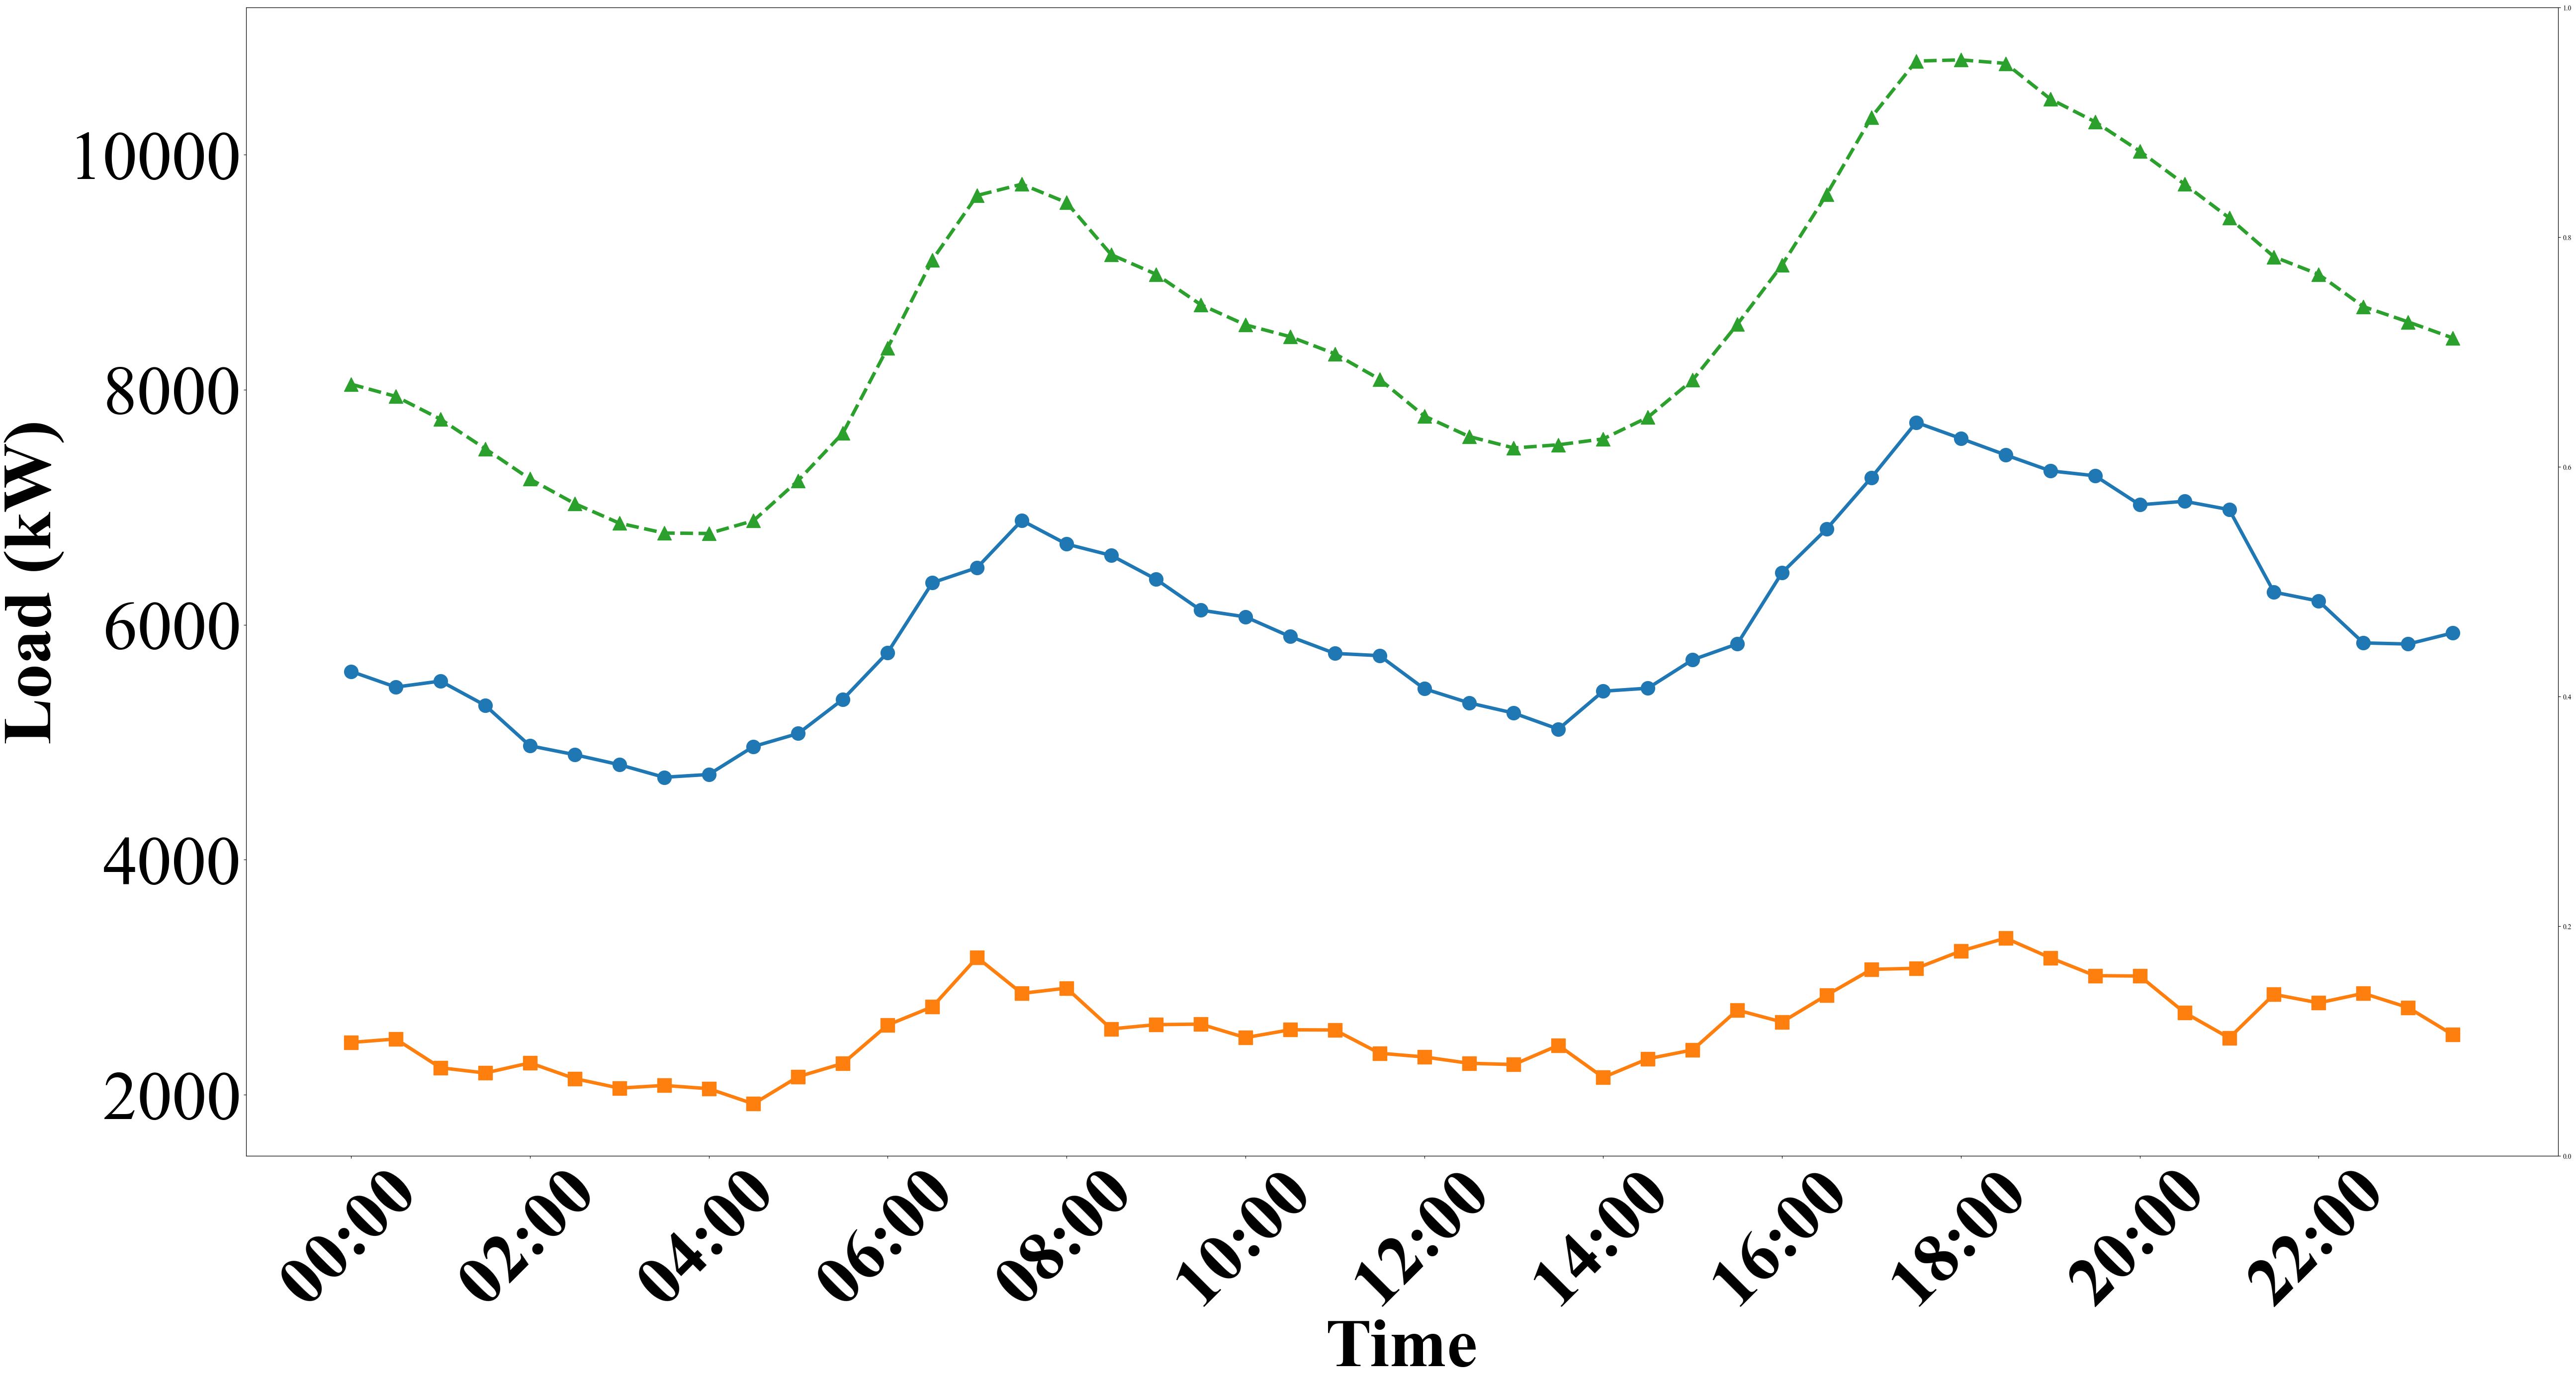

In [13]:
#NSW

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported

def load_real_load_profiles_corrected(P_d, districts=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among districts by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each district's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - districts: Number of districts
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - district_elec_loads: numpy array of shape (districts, time_steps) in kW
    - district_therm_loads: numpy array of shape (districts, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    district_elec_loads = np.zeros((districts, time_steps))
    district_therm_loads = np.zeros((districts, time_steps))  # Thermal load

    for d in range(districts):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the district
            P_e = (total_load_kw[t] * elec_ratio) / districts
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / districts
            
            district_elec_loads[d, t] = P_e
            district_therm_loads[d, t] = P_t

    return district_elec_loads, district_therm_loads

def plot_heatmap(dataframe, save_path, cmap='viridis', figsize=(60, 30), annot=False, time_labels=None, cbar_label='kW'):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps, and saves it as a PDF.

    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - save_path: File path to save the PDF image.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    - cbar_label: Label for the colorbar.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': cbar_label})

    # Customize xlabel and ylabel with Times New Roman, size 150, bold
    plt.xlabel('Time', fontsize=150, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Districts', fontsize=150, fontweight='bold', fontname='Times New Roman')  # Changed 'Houses' to 'Districts'

    # Customize x-axis and y-axis tick labels with Times New Roman, size 150, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (districts)
    plt.yticks(rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_label, fontsize=150, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=150)  # Set colorbar ticks font size

    # Adjust layout to prevent clipping
    plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.15)
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.close()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, district_elec_loads, district_therm_loads, districts=10, time_steps=48, plots_dir='plots'):
    """
    Visualize electrical and thermal load profiles across districts and time steps, and save plots as PDFs.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - district_elec_loads: numpy array of electrical loads per district and time step (in kW)
    - district_therm_loads: numpy array of thermal loads per district and time step (in kW)
    - districts: Number of districts
    - time_steps: Number of time steps
    - plots_dir: Directory to save the PDF plots
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    district_indices = [f"{d+1}" for d in range(districts)]  # Removed "House " prefix

    # Create DataFrames
    df_elec = pd.DataFrame(district_elec_loads, index=district_indices, columns=time_labels)
    df_therm = pd.DataFrame(district_therm_loads, index=district_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    save_path_elec = os.path.join(plots_dir, 'Electrical_Loads_Heatmap.pdf')
    plot_heatmap(df_elec, save_path_elec, cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    save_path_therm = os.path.join(plots_dir, 'Thermal_Loads_Heatmap.pdf')
    plot_heatmap(df_therm, save_path_therm, cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads with Tariff Price
    fig, ax1 = plt.subplots(figsize=(60, 30))

    # Plot loads on primary y-axis
    ax1.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_load, label='Total Load (kW)', marker='^', markersize=20, linewidth=5, linestyle='--')
    ax1.set_xlabel('Time', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax1.set_ylabel('Load (kW)', fontsize=100, fontweight='bold', fontname='Times New Roman')

    # Calculate Tick Positions and Labels for Every 2 Hours
    step = 4  # Every 2 hours (4 half-hourly intervals)
    xticks_positions = np.arange(0, len(time_labels), step)
    xticks_labels = [time_labels[i] for i in xticks_positions]

    # Update X-ticks to Appear Every 2 Hours
    ax1.set_xticks(xticks_positions)
    ax1.set_xticklabels(xticks_labels, rotation=45, fontsize=100, fontname='Times New Roman', fontweight='bold')

    # Update Y-ticks Font Settings
    ax1.tick_params(axis='y', labelsize=100)

    # Create secondary y-axis for tariff price
    ax2 = ax1.twinx()
    ax2.plot(time_labels, Cg_t, label='Tariff Price ($/kWh)', color='black', linestyle=':', linewidth=5)
    ax2.set_ylabel('Tariff Price ($/kWh)', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax2.tick_params(axis='y', labelsize=100)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=100, title_fontsize=100)

    # Enable grid for better readability
    ax1.grid(True)

    # Adjust layout to prevent clipping
    fig.subplots_adjust(left=0.2, right=0.85, top=0.95, bottom=0.15)
    
    # Apply tight layout for optimal spacing
    plt.tight_layout()

    # Save the Plot as a High-Resolution PDF
    save_path_aggregated = os.path.join(plots_dir, 'Aggregated_Loads_Over_Time.pdf')
    plt.savefig(save_path_aggregated, format='pdf')

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Ensure the plots directory exists
    plots_dir = 'plots'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    # Provided Data
    P_d = np.array([
        8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780,
        6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749,
        9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089,
        7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556,
        9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280,
        10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440
    ]) / 1000  # Convert to MW

    Cg_t = np.array([
        99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29,
        81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48,
        92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83,
        56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19,
        151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63,
        154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    districts = 10                          # Number of districts
    time_steps = 48                         # Half-hourly intervals
    scaling_factor_etb = 0.04               # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04               # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per district (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per district (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per district
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per district

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000         # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5       # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000         # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    district_elec_loads, district_therm_loads = load_real_load_profiles_corrected(
        P_d, 
        districts=districts, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # Assuming that the actual load can vary within a certain number of standard deviations
    # For robust optimization, use mean + k * sigma for worst-case
    k = 2  # For approximately 95% confidence interval

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # -----------------------------------
    # 2. Decision Variables
    # -----------------------------------

    # Power Type Battery (PTB) Variables
    ChargePTB = cp.Variable((districts, time_steps), nonneg=True)
    DischargePTB_Elec = cp.Variable((districts, time_steps), nonneg=True)

    # Energy Type Battery (ETB) Variables
    ChargeETB = cp.Variable((districts, time_steps), nonneg=True)
    DischargeETB_Elec = cp.Variable((districts, time_steps), nonneg=True)
    DischargeETB_Therm = cp.Variable((districts, time_steps), nonneg=True)

    # Gas Supply Variable
    GasSupplyTherm = cp.Variable((districts, time_steps), nonneg=True)

    # Grid Power Variables
    GridPowerElec = cp.Variable((districts, time_steps), nonneg=True)

    # State of Charge (SoC) Variables
    SOC_ETB = cp.Variable((districts, time_steps + 1))
    SOC_PTB = cp.Variable((districts, time_steps + 1))

    # **Binary Variables to Prevent Simultaneous Charging and Discharging**
    # PTB Binary Variables
    y_ptb_charge = cp.Variable((districts, time_steps), boolean=True)
    y_ptb_discharge = cp.Variable((districts, time_steps), boolean=True)

    # ETB Binary Variables
    y_etb_charge = cp.Variable((districts, time_steps), boolean=True)
    y_etb_discharge = cp.Variable((districts, time_steps), boolean=True)

    # **SoC Deviation Variables (Linearization)**
    soc_dev_etb_pos = cp.Variable((districts, time_steps + 1), nonneg=True)
    soc_dev_etb_neg = cp.Variable((districts, time_steps + 1), nonneg=True)

    soc_dev_ptb_pos = cp.Variable((districts, time_steps + 1), nonneg=True)
    soc_dev_ptb_neg = cp.Variable((districts, time_steps + 1), nonneg=True)

    # -----------------------------------
    # 3. Constraints
    # -----------------------------------

    # Define target SoC before using it in constraints
    target_soc_etb = 50  # Target SoC in % for ETB
    target_soc_ptb = 50  # Target SoC in % for PTB

    constraints = [
        # Initialize SoC to 50% for all storage systems
        SOC_ETB[:,0] == 50,
        SOC_PTB[:,0] == 50,

        # SoC Deviation Constraints (Linearization)
        SOC_ETB == target_soc_etb + soc_dev_etb_pos - soc_dev_etb_neg,
        SOC_PTB == target_soc_ptb + soc_dev_ptb_pos - soc_dev_ptb_neg
    ]

    for d in range(districts):
        for t in range(time_steps):
            # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
            sigma_elec = 0.05  # 5% standard deviation
            worst_case_elec_load = district_elec_loads[d,t] * (1 + k * sigma_elec)
            constraints += [
                GridPowerElec[d,t] + DischargePTB_Elec[d,t] + DischargeETB_Elec[d,t] == ChargePTB[d,t] + ChargeETB[d,t] + worst_case_elec_load
            ]

            # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
            sigma_therm = 0.05  # 5% standard deviation
            worst_case_therm_load = district_therm_loads[d,t] * (1 + k * sigma_therm)
            # **Modified Thermal Load Balance Constraint**
            constraints += [
                GasSupplyTherm[d,t] + DischargeETB_Therm[d,t] == worst_case_therm_load
            ]

            # **Prevent Simultaneous Charging and Discharging for PTB**
            constraints += [
                ChargePTB[d,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[d,t],
                DischargePTB_Elec[d,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[d,t],
                y_ptb_charge[d,t] + y_ptb_discharge[d,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # **Prevent Simultaneous Charging and Discharging for ETB**
            constraints += [
                ChargeETB[d,t] <= bess_etb_power_capacity_kw * y_etb_charge[d,t],
                DischargeETB_Elec[d,t] + DischargeETB_Therm[d,t] <= bess_etb_power_capacity_kw * y_etb_discharge[d,t],
                y_etb_charge[d,t] + y_etb_discharge[d,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # SoC updates for PTB
            constraints += [
                SOC_PTB[d,t+1] == SOC_PTB[d,t] + (ChargePTB[d,t] * 0.95 - DischargePTB_Elec[d,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
            ]

            # SoC updates for ETB
            constraints += [
                SOC_ETB[d,t+1] == SOC_ETB[d,t] + (ChargeETB[d,t] * 0.95 - (DischargeETB_Elec[d,t] + DischargeETB_Therm[d,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
            ]

            # SoC Limits for PTB and ETB
            constraints += [
                SOC_PTB[d,t+1] >= 20,
                SOC_PTB[d,t+1] <= 100,
                SOC_ETB[d,t+1] >= 20,
                SOC_ETB[d,t+1] <= 100
            ]

    # -----------------------------------
    # 4. Final SoC Constraints
    # -----------------------------------
    # Ensure that all storage systems reach exactly 50% SoC by the end of the day
    constraints += [
        SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
        SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
    ]

    # -----------------------------------
    # 5. Objective Function
    # -----------------------------------

    # Tile Cg_t and Cb_t to match the (districts, time_steps) shape
    Cg_t_matrix = np.tile(Cg_t, (districts, 1))      # Grid electricity tariff ($/kWh)
    Cb_ptb_matrix = np.tile(Cb_ptb, (districts, 1))  # PTB charging cost ($/kWh)
    Cb_etb_matrix = np.tile(Cb_etb, (districts, 1))  # ETB charging cost ($/kWh)

    # Tile the incentives to match the (districts, time_steps) shape
    o_ptb_matrix = np.tile(o_incentive_ptb, (districts, time_steps))          # Charging incentive for PTB ($/kWh)
    o_etb_matrix = np.tile(o_incentive_etb, (districts, time_steps))          # Charging incentive for ETB ($/kWh)
    d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (districts, time_steps))  # PTB discharging incentive ($/kWh)
    d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (districts, time_steps))  # ETB-Elec discharging incentive ($/kWh)
    d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (districts, time_steps))  # ETB-Therm discharging incentive ($/kWh)

    # Define penalty weight for SoC deviation
    soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

    # SoC Deviation Penalty (Linearization using Absolute Deviations)
    soc_penalty = soc_penalty_weight * (
        cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
        cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
    )

    # Charging Incentives
    total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                 cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

    # Incentives from Discharging PTB and ETB
    total_incentives = (
        cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
        cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
        cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
    )

    # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
    total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix))
    total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
    total_battery_cost = (
        cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
        cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
    )

    # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
    objective = cp.Minimize(
        total_grid_cost + 
        total_gas_cost + 
        total_battery_cost - 
        total_incentives - 
        total_charging_incentives + 
        soc_penalty
    )

    # -----------------------------------
    # 6. Define and Solve the Problem
    # -----------------------------------

    prob = cp.Problem(objective, constraints)

    # Set the Gurobi license file path
    os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

    # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
    # Ensure that Gurobi is installed and properly licensed.
    try:
        prob.solve(solver=cp.GUROBI, verbose=True, mip_gap=0.01, threads=4)
    except cp.error.SolverError:
        print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
        # Optionally, you can fallback to another solver here
        try:
            prob.solve(solver=cp.GLPK_MI, verbose=True, mip_gap=0.01)
        except cp.error.SolverError as e:
            print("Both Gurobi and GLPK_MI solvers failed.")
            print(str(e))
            return

    # -----------------------------------
    # 7. Check Solution and Extract Results
    # -----------------------------------
    
    if prob.status not in ["infeasible", "unbounded"]:
        print(f"Optimal Total Cost: ${prob.value:.2f}")
        
        # Extract optimized variables
        charge_ptb_opt = ChargePTB.value
        discharge_ptb_elec_opt = DischargePTB_Elec.value

        charge_etb_opt = ChargeETB.value
        discharge_etb_elec_opt = DischargeETB_Elec.value
        discharge_etb_therm_opt = DischargeETB_Therm.value

        gas_supply_therm_opt = GasSupplyTherm.value
        grid_elec_opt = GridPowerElec.value

        soc_etb_opt = SOC_ETB.value
        soc_ptb_opt = SOC_PTB.value

        soc_dev_etb_pos_opt = soc_dev_etb_pos.value
        soc_dev_etb_neg_opt = soc_dev_etb_neg.value

        soc_dev_ptb_pos_opt = soc_dev_ptb_pos.value
        soc_dev_ptb_neg_opt = soc_dev_ptb_neg.value

        # Define district indices and generate actual time labels
        district_indices = [f"{d+1}" for d in range(districts)]
        time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)

        # Create DataFrames for Visualization
        # 1. Electrical Loads Heatmap
        df_elec_loads = pd.DataFrame(district_elec_loads, index=district_indices, columns=time_labels)

        # 2. Thermal Loads Heatmap
        df_therm_loads = pd.DataFrame(district_therm_loads, index=district_indices, columns=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        df_gas_supply_therm = pd.DataFrame(gas_supply_therm_opt, index=district_indices, columns=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        df_grid_supply_elec = pd.DataFrame(grid_elec_opt, index=district_indices, columns=time_labels)

        # 5. Battery Operations Heatmaps
        df_charge_ptb = pd.DataFrame(charge_ptb_opt, index=district_indices, columns=time_labels)
        df_discharge_ptb_elec = pd.DataFrame(discharge_ptb_elec_opt, index=district_indices, columns=time_labels)

        df_charge_etb = pd.DataFrame(charge_etb_opt, index=district_indices, columns=time_labels)
        df_discharge_etb_elec = pd.DataFrame(discharge_etb_elec_opt, index=district_indices, columns=time_labels)
        df_discharge_etb_therm = pd.DataFrame(discharge_etb_therm_opt, index=district_indices, columns=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        net_ptb_elec = discharge_ptb_elec_opt - charge_ptb_opt  # Positive: net discharge
        df_net_ptb_elec = pd.DataFrame(net_ptb_elec, index=district_indices, columns=time_labels)

        # Net ETB Operations for Electrical Loads
        net_etb_elec = discharge_etb_elec_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_elec = pd.DataFrame(net_etb_elec, index=district_indices, columns=time_labels)

        # Net ETB Operations for Thermal Loads
        net_etb_therm = discharge_etb_therm_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_therm = pd.DataFrame(net_etb_therm, index=district_indices, columns=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        total_ptb_contribution = discharge_ptb_elec_opt
        df_total_ptb_contribution = pd.DataFrame(total_ptb_contribution, index=district_indices, columns=time_labels)

        # Total ETB Contribution (Electrical)
        total_etb_elec_contribution = discharge_etb_elec_opt
        df_total_etb_elec_contribution = pd.DataFrame(total_etb_elec_contribution, index=district_indices, columns=time_labels)

        # Total ETB Contribution (Thermal)
        total_etb_therm_contribution = discharge_etb_therm_opt
        df_total_etb_therm_contribution = pd.DataFrame(total_etb_therm_contribution, index=district_indices, columns=time_labels)

        # 8. State of Charge (SoC) Heatmaps
        # Remove the last column for SoC at t=48 to align with time_steps
        soc_etb_current = soc_etb_opt[:, :-1]  # Shape: (districts, time_steps)
        soc_ptb_current = soc_ptb_opt[:, :-1]  # Shape: (districts, time_steps)
        df_soc_etb = pd.DataFrame(soc_etb_current, index=district_indices, columns=time_labels)
        df_soc_ptb = pd.DataFrame(soc_ptb_current, index=district_indices, columns=time_labels)

        # 9. Power Balance Calculation
        # Recompute worst-case loads
        worst_case_elec_loads = district_elec_loads * (1 + k * sigma_elec)
        worst_case_therm_loads = district_therm_loads * (1 + k * sigma_therm)

        # Recompute total supply and demand
        total_supply_elec = grid_elec_opt + discharge_ptb_elec_opt + discharge_etb_elec_opt
        total_load_elec = charge_ptb_opt + charge_etb_opt + worst_case_elec_loads
        residual_elec = total_supply_elec - total_load_elec  # Should be zero

        total_supply_therm = gas_supply_therm_opt + discharge_etb_therm_opt
        total_load_therm = worst_case_therm_loads  # Updated to exclude ChargeETB
        residual_therm = total_supply_therm - total_load_therm  # Should be zero

        # Combine residuals
        residual_total = residual_elec + residual_therm  # Should be zero
        df_residual_total = pd.DataFrame(residual_total, index=district_indices, columns=time_labels)

        # -----------------------------------
        # 10. Visualization: Plot Heatmaps
        # -----------------------------------

        # Set global font settings for Times New Roman
        rcParams['font.family'] = 'Times New Roman'

        # 3. Gas Supply for Thermal Loads Heatmap
        save_path_gas_supply = os.path.join(plots_dir, 'Gas_Supply_for_Thermal_Loads_Heatmap.pdf')
        plot_heatmap(df_gas_supply_therm, save_path_gas_supply, time_labels=time_labels, cbar_label='kW')

        # 4. Grid Supply for Electrical Loads Heatmap
        save_path_grid_supply = os.path.join(plots_dir, 'Grid_Supply_for_Electrical_Loads_Heatmap.pdf')
        plot_heatmap(df_grid_supply_elec, save_path_grid_supply, time_labels=time_labels, cbar_label='kW')

        # 5. Battery Operations Heatmaps
        # Plot Charging PTB
        save_path_charge_ptb = os.path.join(plots_dir, 'Charging_PTB_Heatmap.pdf')
        plot_heatmap(df_charge_ptb, save_path_charge_ptb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging PTB for Electrical Loads
        save_path_discharge_ptb_elec = os.path.join(plots_dir, 'Discharging_PTB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_ptb_elec, save_path_discharge_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Charging ETB
        save_path_charge_etb = os.path.join(plots_dir, 'Charging_ETB_Heatmap.pdf')
        plot_heatmap(df_charge_etb, save_path_charge_etb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Electrical Loads
        save_path_discharge_etb_elec = os.path.join(plots_dir, 'Discharging_ETB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_elec, save_path_discharge_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Thermal Loads
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_therm, save_path_discharge_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        save_path_net_ptb_elec = os.path.join(plots_dir, 'Net_PTB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_ptb_elec, save_path_net_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Electrical Loads
        save_path_net_etb_elec = os.path.join(plots_dir, 'Net_ETB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_elec, save_path_net_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Thermal Loads
        save_path_net_etb_therm = os.path.join(plots_dir, 'Net_ETB_Thermal_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_therm, save_path_net_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        save_path_total_ptb = os.path.join(plots_dir, 'Total_PTB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_ptb_contribution, save_path_total_ptb, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Electrical)
        save_path_total_etb_elec = os.path.join(plots_dir, 'Total_ETB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_elec_contribution, save_path_total_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Thermal)
        save_path_total_etb_therm = os.path.join(plots_dir, 'Total_ETB_Thermal_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_therm_contribution, save_path_total_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 8. State of Charge (SoC) Heatmaps
        # SoC ETB
        save_path_soc_etb = os.path.join(plots_dir, 'State_of_Charge_ETB_Heatmap.pdf')
        plot_heatmap(df_soc_etb, save_path_soc_etb, time_labels=time_labels, cbar_label='%')

        # SoC PTB
        save_path_soc_ptb = os.path.join(plots_dir, 'State_of_Charge_PTB_Heatmap.pdf')
        plot_heatmap(df_soc_ptb, save_path_soc_ptb, time_labels=time_labels, cbar_label='%')

        # 9. Power Balance Residuals Heatmap
        # Power Balance Residuals Heatmap (Absolute)
        df_residual_absolute = df_residual_total.abs()
        save_path_residual_absolute = os.path.join(plots_dir, 'Power_Balance_Residual_Absolute_Heatmap.pdf')
        plot_heatmap(df_residual_absolute, save_path_residual_absolute, time_labels=time_labels, cbar_label='kW')

        # Power Balance Residuals Heatmap (Signed)
        save_path_residual_signed = os.path.join(plots_dir, 'Power_Balance_Residual_Signed_Heatmap.pdf')
        plot_heatmap(df_residual_total, save_path_residual_signed, time_labels=time_labels, cbar_label='kW')

        # -----------------------------------
        # 11. Additional Visualization: ETB Operations
        # -----------------------------------
        # Plot Discharging ETB for Thermal Loads
        plt.figure(figsize=(60, 30))
        for d in range(districts):
            # Removed "House " prefix from legend labels
            plt.plot(time_labels, discharge_etb_therm_opt[d], label=f'District {d+1}', linewidth=5)
        # Title Removed
        plt.xlabel('Time', fontsize=300, fontweight='bold', fontname='Times New Roman')
        plt.ylabel('Discharge Power (kW)', fontsize=300, fontweight='bold', fontname='Times New Roman')  # Unit remains kW
        plt.xticks(rotation=45, fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.yticks(fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.legend(fontsize=300, loc='upper right', title='Districts', title_fontsize=300)  # Changed 'Houses' to 'Districts'
        plt.grid(True)
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)
        plt.tight_layout()
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Loads_Over_Time.pdf')
        plt.savefig(save_path_discharge_etb_therm, format='pdf')
        plt.close()

        # -----------------------------------
        # 12. Additional Visualization: Aggregated Load Profiles
        # -----------------------------------
        visualize_load_profiles(P_d, district_elec_loads, district_therm_loads, districts=districts, time_steps=time_steps, plots_dir=plots_dir)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    import sys
    import subprocess
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    main_robust_mpc_corrected()


In [8]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported

def load_real_load_profiles_corrected(P_d, houses=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among houses by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each house's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - houses: Number of houses
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - house_elec_loads: numpy array of shape (houses, time_steps) in kW
    - house_therm_loads: numpy array of shape (houses, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    house_elec_loads = np.zeros((houses, time_steps))
    house_therm_loads = np.zeros((houses, time_steps))  # Thermal load

    for h in range(houses):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the house
            P_e = (total_load_kw[t] * elec_ratio) / houses
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / houses
            
            house_elec_loads[h, t] = P_e
            house_therm_loads[h, t] = P_t

    return house_elec_loads, house_therm_loads

def plot_heatmap(dataframe, save_path, cmap='viridis', figsize=(60, 30), annot=False, time_labels=None, cbar_label='kW'):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps, and saves it as a PDF.

    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - save_path: File path to save the PDF image.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    - cbar_label: Label for the colorbar.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': cbar_label})

    # Customize xlabel and ylabel with Times New Roman, size 150, bold
    plt.xlabel('Time', fontsize=150, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Districts', fontsize=150, fontweight='bold', fontname='Times New Roman')  # Changed 'Districts_VIC' to 'Districts'

    # Customize x-axis and y-axis tick labels with Times New Roman, size 150, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (districts)
    plt.yticks(rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_label, fontsize=150, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=150)  # Set colorbar ticks font size

    # Adjust layout to prevent clipping
    plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.15)
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.close()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, Cg_t, houses=10, time_steps=48, plots_dir='plots'):
    """
    Visualize electrical and thermal load profiles across houses and time steps, and save plots as PDFs.
    Additionally, plots the tariff price on a secondary y-axis in the Aggregated Load plot as a dotted line.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)
    - Cg_t: numpy array of tariff prices per time step ($/kWh)
    - houses: Number of houses
    - time_steps: Number of time steps
    - plots_dir: Directory to save the PDF plots
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    house_indices = [f"{h+1}" for h in range(houses)]  # Removed "House " prefix

    # Create DataFrames
    df_elec = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)
    df_therm = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    save_path_elec = os.path.join(plots_dir, 'Electrical_Loads_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
    plot_heatmap(df_elec, save_path_elec, cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    save_path_therm = os.path.join(plots_dir, 'Thermal_Loads_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
    plot_heatmap(df_therm, save_path_therm, cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads with Tariff Price
    fig, ax1 = plt.subplots(figsize=(60, 30))

    # Plot loads on primary y-axis
    ax1.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_load, label='Total Load (kW)', marker='^', markersize=20, linewidth=5, linestyle='--')
    ax1.set_xlabel('Time', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax1.set_ylabel('Load (kW)', fontsize=100, fontweight='bold', fontname='Times New Roman')

    # Calculate Tick Positions and Labels for Every 2 Hours
    step = 4  # Every 2 hours (4 half-hourly intervals)
    xticks_positions = np.arange(0, len(time_labels), step)
    xticks_labels = [time_labels[i] for i in xticks_positions]

    # Update X-ticks to Appear Every 2 Hours
    ax1.set_xticks(xticks_positions)
    ax1.set_xticklabels(xticks_labels, rotation=45, fontsize=100, fontname='Times New Roman', fontweight='bold')

    # Update Y-ticks Font Settings
    ax1.tick_params(axis='y', labelsize=100)

    # Create secondary y-axis for tariff price
    ax2 = ax1.twinx()
    ax2.plot(time_labels, Cg_t, label='Tariff Price ($/kWh)', color='black', linestyle=':', linewidth=5)
    ax2.set_ylabel('Tariff Price ($/kWh)', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax2.tick_params(axis='y', labelsize=100)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=100, title_fontsize=100)

    # Enable grid for better readability
    ax1.grid(True)

    # Adjust layout to prevent clipping
    fig.subplots_adjust(left=0.2, right=0.85, top=0.95, bottom=0.15)
    
    # Apply tight layout for optimal spacing
    plt.tight_layout()

    # Save the Plot as a High-Resolution PDF
    save_path_aggregated = os.path.join(plots_dir, 'Aggregated_Loads_Over_Time_TAS.pdf')  # Changed _VIC to _TAS
    plt.savefig(save_path_aggregated, format='pdf')

    # Close the Plot to Free Memory
    plt.close()

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Ensure the plots directory exists
    plots_dir = 'plots'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
        
    # Provided Data for Tasmania (TAS)
    P_d_TAS = np.array([
        1027, 1014, 1014, 1017, 1006, 1010, 1008, 1018, 1048, 1043, 
        1108, 1195, 1286, 1361, 1451, 1499, 1494, 1479, 1441, 1451, 
        1444, 1411, 1376, 1353, 1336, 1308, 1310, 1291, 1371, 1254, 
        1295, 1367, 1394, 1437, 1465, 1493, 1479, 1458, 1453, 1411, 
        1408, 1371, 1335, 1289, 1242, 1211, 1181, 1160
    ]) / 1000  # Convert to MW

    Cg_t_TAS = np.array([
        22.61, 20.53, 15.97, 13.03, 13.09, 13.15, 19.57, 18.02, 23.94, 
        23.83, 27.29, 33.96, 54.96, 72.37, 65.25, 69.1, 58.78, 54.69, 
        64.42, 60.94, 50.5, 48.35, 47.19, 33.31, 34.7, 29.31, 32.57, 
        36.13, 48.62, 53.47, 177.81, 58.13, 70.26, 69.25, 65.75, 
        53.51, 48.78, 56.82, 53.92, 57.97, 55.19, 52.02, 48.22, 
        38.79, 33.74, 33.15, 30.72, 29.31
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    houses = 10                          # Number of houses
    time_steps = 48                      # Half-hourly intervals
    scaling_factor_etb = 0.04            # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04            # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per house (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per house (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per house
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per house

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000         # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5       # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000         # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    house_elec_loads, house_therm_loads = load_real_load_profiles_corrected(
        P_d_TAS, 
        houses=houses, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # Assuming that the actual load can vary within a certain number of standard deviations
    # For robust optimization, use mean + k * sigma for worst-case
    k = 2  # For approximately 95% confidence interval

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # -----------------------------------
    # 2. Decision Variables
    # -----------------------------------

    # Power Type Battery (PTB) Variables
    ChargePTB = cp.Variable((houses, time_steps), nonneg=True)
    DischargePTB_Elec = cp.Variable((houses, time_steps), nonneg=True)

    # Energy Type Battery (ETB) Variables
    ChargeETB = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Elec = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Therm = cp.Variable((houses, time_steps), nonneg=True)

    # Gas Supply Variable
    GasSupplyTherm = cp.Variable((houses, time_steps), nonneg=True)

    # Grid Power Variables
    GridPowerElec = cp.Variable((houses, time_steps), nonneg=True)

    # State of Charge (SoC) Variables
    SOC_ETB = cp.Variable((houses, time_steps + 1))
    SOC_PTB = cp.Variable((houses, time_steps + 1))

    # **Binary Variables to Prevent Simultaneous Charging and Discharging**
    # PTB Binary Variables
    y_ptb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_ptb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # ETB Binary Variables
    y_etb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_etb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # **SoC Deviation Variables (Linearization)**
    soc_dev_etb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_etb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    soc_dev_ptb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_ptb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    # -----------------------------------
    # 3. Constraints
    # -----------------------------------

    # Define target SoC before using it in constraints
    target_soc_etb = 50  # Target SoC in % for ETB
    target_soc_ptb = 50  # Target SoC in % for PTB

    constraints = [
        # Initialize SoC to 50% for all storage systems
        SOC_ETB[:,0] == 50,
        SOC_PTB[:,0] == 50,

        # SoC Deviation Constraints (Linearization)
        SOC_ETB == target_soc_etb + soc_dev_etb_pos - soc_dev_etb_neg,
        SOC_PTB == target_soc_ptb + soc_dev_ptb_pos - soc_dev_ptb_neg
    ]

    for h in range(houses):
        for t in range(time_steps):
            # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
            sigma_elec = 0.05  # 5% standard deviation
            worst_case_elec_load = house_elec_loads[h,t] * (1 + k * sigma_elec)
            constraints += [
                GridPowerElec[h,t] + DischargePTB_Elec[h,t] + DischargeETB_Elec[h,t] == ChargePTB[h,t] + ChargeETB[h,t] + worst_case_elec_load
            ]

            # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
            sigma_therm = 0.05  # 5% standard deviation
            worst_case_therm_load = house_therm_loads[h,t] * (1 + k * sigma_therm)
            # **Modified Thermal Load Balance Constraint**
            constraints += [
                GasSupplyTherm[h,t] + DischargeETB_Therm[h,t] == worst_case_therm_load
            ]

            # **Prevent Simultaneous Charging and Discharging for PTB**
            constraints += [
                ChargePTB[h,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[h,t],
                DischargePTB_Elec[h,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[h,t],
                y_ptb_charge[h,t] + y_ptb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # **Prevent Simultaneous Charging and Discharging for ETB**
            constraints += [
                ChargeETB[h,t] <= bess_etb_power_capacity_kw * y_etb_charge[h,t],
                DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t] <= bess_etb_power_capacity_kw * y_etb_discharge[h,t],
                y_etb_charge[h,t] + y_etb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # SoC updates for PTB
            constraints += [
                SOC_PTB[h,t+1] == SOC_PTB[h,t] + (ChargePTB[h,t] * 0.95 - DischargePTB_Elec[h,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
            ]

            # SoC updates for ETB
            constraints += [
                SOC_ETB[h,t+1] == SOC_ETB[h,t] + (ChargeETB[h,t] * 0.95 - (DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
            ]

            # SoC Limits for PTB and ETB
            constraints += [
                SOC_PTB[h,t+1] >= 20,
                SOC_PTB[h,t+1] <= 100,
                SOC_ETB[h,t+1] >= 20,
                SOC_ETB[h,t+1] <= 100
            ]

    # -----------------------------------
    # 4. Final SoC Constraints
    # -----------------------------------
    # Ensure that all storage systems reach exactly 50% SoC by the end of the day
    constraints += [
        SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
        SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
    ]

    # -----------------------------------
    # 5. Objective Function
    # -----------------------------------

    # Tile Cg_t and Cb_t to match the (houses, time_steps) shape
    Cg_t_matrix_TAS = np.tile(Cg_t_TAS, (houses, 1))      # Grid electricity tariff ($/kWh)
    Cb_ptb_matrix = np.tile(Cb_ptb, (houses, 1))  # PTB charging cost ($/kWh)
    Cb_etb_matrix = np.tile(Cb_etb, (houses, 1))  # ETB charging cost ($/kWh)

    # Tile the incentives to match the (houses, time_steps) shape
    o_ptb_matrix = np.tile(o_incentive_ptb, (houses, time_steps))          # Charging incentive for PTB ($/kWh)
    o_etb_matrix = np.tile(o_incentive_etb, (houses, time_steps))          # Charging incentive for ETB ($/kWh)
    d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (houses, time_steps))  # PTB discharging incentive ($/kWh)
    d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (houses, time_steps))  # ETB-Elec discharging incentive ($/kWh)
    d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (houses, time_steps))  # ETB-Therm discharging incentive ($/kWh)

    # Define penalty weight for SoC deviation
    soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

    # SoC Deviation Penalty (Linearization using Absolute Deviations)
    soc_penalty = soc_penalty_weight * (
        cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
        cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
    )

    # Charging Incentives
    total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                 cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

    # Incentives from Discharging PTB and ETB
    total_incentives = (
        cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
        cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
        cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
    )

    # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
    total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix_TAS))
    total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
    total_battery_cost = (
        cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
        cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
    )

    # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
    objective = cp.Minimize(
        total_grid_cost + 
        total_gas_cost + 
        total_battery_cost - 
        total_incentives - 
        total_charging_incentives + 
        soc_penalty
    )

    # -----------------------------------
    # 6. Define and Solve the Problem
    # -----------------------------------

    prob = cp.Problem(objective, constraints)

    # Set the Gurobi license file path
    os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

    # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
    # Ensure that Gurobi is installed and properly licensed.
    try:
        prob.solve(solver=cp.GUROBI, verbose=True, mip_gap=0.01, threads=4)
    except cp.error.SolverError:
        print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
        # Optionally, you can fallback to another solver here
        try:
            prob.solve(solver=cp.GLPK_MI, verbose=True, mip_gap=0.01)
        except cp.error.SolverError as e:
            print("Both Gurobi and GLPK_MI solvers failed.")
            print(str(e))
            return

    # -----------------------------------
    # 7. Check Solution and Extract Results
    # -----------------------------------
    
    if prob.status not in ["infeasible", "unbounded"]:
        print(f"Optimal Total Cost: ${prob.value:.2f}")
        
        # Extract optimized variables
        charge_ptb_opt = ChargePTB.value
        discharge_ptb_elec_opt = DischargePTB_Elec.value

        charge_etb_opt = ChargeETB.value
        discharge_etb_elec_opt = DischargeETB_Elec.value
        discharge_etb_therm_opt = DischargeETB_Therm.value

        gas_supply_therm_opt = GasSupplyTherm.value
        grid_elec_opt = GridPowerElec.value

        soc_etb_opt = SOC_ETB.value
        soc_ptb_opt = SOC_PTB.value

        soc_dev_etb_pos_opt = soc_dev_etb_pos.value
        soc_dev_etb_neg_opt = soc_dev_etb_neg.value

        soc_dev_ptb_pos_opt = soc_dev_ptb_pos.value
        soc_dev_ptb_neg_opt = soc_dev_ptb_neg.value

        # Define house indices and generate actual time labels
        house_indices = [f"{h+1}" for h in range(houses)]
        time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)

        # Create DataFrames for Visualization
        # 1. Electrical Loads Heatmap
        df_elec_loads = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)

        # 2. Thermal Loads Heatmap
        df_therm_loads = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        df_gas_supply_therm = pd.DataFrame(gas_supply_therm_opt, index=house_indices, columns=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        df_grid_supply_elec = pd.DataFrame(grid_elec_opt, index=house_indices, columns=time_labels)

        # 5. Battery Operations Heatmaps
        df_charge_ptb = pd.DataFrame(charge_ptb_opt, index=house_indices, columns=time_labels)
        df_discharge_ptb_elec = pd.DataFrame(discharge_ptb_elec_opt, index=house_indices, columns=time_labels)

        df_charge_etb = pd.DataFrame(charge_etb_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_elec = pd.DataFrame(discharge_etb_elec_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_therm = pd.DataFrame(discharge_etb_therm_opt, index=house_indices, columns=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        net_ptb_elec = discharge_ptb_elec_opt - charge_ptb_opt  # Positive: net discharge
        df_net_ptb_elec = pd.DataFrame(net_ptb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Electrical Loads
        net_etb_elec = discharge_etb_elec_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_elec = pd.DataFrame(net_etb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Thermal Loads
        net_etb_therm = discharge_etb_therm_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_therm = pd.DataFrame(net_etb_therm, index=house_indices, columns=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        total_ptb_contribution = discharge_ptb_elec_opt
        df_total_ptb_contribution = pd.DataFrame(total_ptb_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Electrical)
        total_etb_elec_contribution = discharge_etb_elec_opt
        df_total_etb_elec_contribution = pd.DataFrame(total_etb_elec_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Thermal)
        total_etb_therm_contribution = discharge_etb_therm_opt
        df_total_etb_therm_contribution = pd.DataFrame(total_etb_therm_contribution, index=house_indices, columns=time_labels)

        # 8. State of Charge (SoC) Heatmaps
        # Remove the last column for SoC at t=48 to align with time_steps
        soc_etb_current = soc_etb_opt[:, :-1]  # Shape: (houses, time_steps)
        soc_ptb_current = soc_ptb_opt[:, :-1]  # Shape: (houses, time_steps)
        df_soc_etb = pd.DataFrame(soc_etb_current, index=house_indices, columns=time_labels)
        df_soc_ptb = pd.DataFrame(soc_ptb_current, index=house_indices, columns=time_labels)

        # 9. Power Balance Calculation
        # Recompute worst-case loads
        worst_case_elec_loads = house_elec_loads * (1 + k * sigma_elec)
        worst_case_therm_loads = house_therm_loads * (1 + k * sigma_therm)

        # Recompute total supply and demand
        total_supply_elec = grid_elec_opt + discharge_ptb_elec_opt + discharge_etb_elec_opt
        total_load_elec = charge_ptb_opt + charge_etb_opt + worst_case_elec_loads
        residual_elec = total_supply_elec - total_load_elec  # Should be zero

        total_supply_therm = gas_supply_therm_opt + discharge_etb_therm_opt
        total_load_therm = worst_case_therm_loads  # Updated to exclude ChargeETB
        residual_therm = total_supply_therm - total_load_therm  # Should be zero

        # Combine residuals
        residual_total = residual_elec + residual_therm  # Should be zero
        df_residual_total = pd.DataFrame(residual_total, index=house_indices, columns=time_labels)

        # -----------------------------------
        # 10. Visualization: Plot Heatmaps
        # -----------------------------------

        # Set global font settings for Times New Roman
        rcParams['font.family'] = 'Times New Roman'

        # 3. Gas Supply for Thermal Loads Heatmap
        save_path_gas_supply = os.path.join(plots_dir, 'Gas_Supply_for_Thermal_Loads_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_gas_supply_therm, save_path_gas_supply, time_labels=time_labels, cbar_label='kW')

        # 4. Grid Supply for Electrical Loads Heatmap
        save_path_grid_supply = os.path.join(plots_dir, 'Grid_Supply_for_Electrical_Loads_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_grid_supply_elec, save_path_grid_supply, time_labels=time_labels, cbar_label='kW')

        # 5. Battery Operations Heatmaps
        # Plot Charging PTB
        save_path_charge_ptb = os.path.join(plots_dir, 'Charging_PTB_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_charge_ptb, save_path_charge_ptb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging PTB for Electrical Loads
        save_path_discharge_ptb_elec = os.path.join(plots_dir, 'Discharging_PTB_Electrical_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_discharge_ptb_elec, save_path_discharge_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Charging ETB
        save_path_charge_etb = os.path.join(plots_dir, 'Charging_ETB_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_charge_etb, save_path_charge_etb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Electrical Loads
        save_path_discharge_etb_elec = os.path.join(plots_dir, 'Discharging_ETB_Electrical_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_discharge_etb_elec, save_path_discharge_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Thermal Loads
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_discharge_etb_therm, save_path_discharge_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        save_path_net_ptb_elec = os.path.join(plots_dir, 'Net_PTB_Electrical_Operations_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_net_ptb_elec, save_path_net_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Electrical Loads
        save_path_net_etb_elec = os.path.join(plots_dir, 'Net_ETB_Electrical_Operations_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_net_etb_elec, save_path_net_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Thermal Loads
        save_path_net_etb_therm = os.path.join(plots_dir, 'Net_ETB_Thermal_Operations_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_net_etb_therm, save_path_net_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        save_path_total_ptb = os.path.join(plots_dir, 'Total_PTB_Electrical_Contribution_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_total_ptb_contribution, save_path_total_ptb, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Electrical)
        save_path_total_etb_elec = os.path.join(plots_dir, 'Total_ETB_Electrical_Contribution_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_total_etb_elec_contribution, save_path_total_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Thermal)
        save_path_total_etb_therm = os.path.join(plots_dir, 'Total_ETB_Thermal_Contribution_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_total_etb_therm_contribution, save_path_total_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 8. State of Charge (SoC) Heatmaps
        # SoC ETB
        save_path_soc_etb = os.path.join(plots_dir, 'State_of_Charge_ETB_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_soc_etb, save_path_soc_etb, time_labels=time_labels, cbar_label='%')

        # SoC PTB
        save_path_soc_ptb = os.path.join(plots_dir, 'State_of_Charge_PTB_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_soc_ptb, save_path_soc_ptb, time_labels=time_labels, cbar_label='%')

        # 9. Power Balance Residuals Heatmap
        # Power Balance Residuals Heatmap (Absolute)
        df_residual_absolute = df_residual_total.abs()
        save_path_residual_absolute = os.path.join(plots_dir, 'Power_Balance_Residual_Absolute_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_residual_absolute, save_path_residual_absolute, time_labels=time_labels, cbar_label='kW')

        # Power Balance Residuals Heatmap (Signed)
        save_path_residual_signed = os.path.join(plots_dir, 'Power_Balance_Residual_Signed_Heatmap_TAS.pdf')  # Changed _VIC to _TAS
        plot_heatmap(df_residual_total, save_path_residual_signed, time_labels=time_labels, cbar_label='kW')

        # -----------------------------------
        # 11. Additional Visualization: ETB Operations
        # -----------------------------------
        # Plot Discharging ETB for Thermal Loads
        plt.figure(figsize=(60, 30))
        for h in range(houses):
            # Removed "House " prefix from legend labels
            plt.plot(time_labels, discharge_etb_therm_opt[h], label=f'District {h+1}', linewidth=5, linestyle='-')
        # Title Removed
        plt.xlabel('Time', fontsize=300, fontweight='bold', fontname='Times New Roman')
        plt.ylabel('Discharge Power (kW)', fontsize=300, fontweight='bold', fontname='Times New Roman')  # Unit remains kW
        plt.xticks(rotation=45, fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.yticks(fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.legend(fontsize=300, loc='upper right', title='Districts', title_fontsize=300)  # Changed 'Districts_VIC' to 'Districts'
        plt.grid(True)
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)
        plt.tight_layout()
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Loads_Over_Time_TAS.pdf')  # Changed _VIC to _TAS
        plt.savefig(save_path_discharge_etb_therm, format='pdf')
        plt.close()

        # -----------------------------------
        # 12. Additional Visualization: Aggregated Load Profiles
        # -----------------------------------
        visualize_load_profiles(P_d_TAS, house_elec_loads, house_therm_loads, Cg_t_TAS, houses=houses, time_steps=time_steps, plots_dir=plots_dir)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    import sys
    import subprocess
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    main_robust_mpc_corrected()


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 29 05:16:09 PM: Your problem has 8220 variables, 6726 constraints, and 0 parameters.
(CVXPY) Dec 29 05:16:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 29 05:16:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 29 05:16:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 29 05:16:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 29 05:16:10 PM: Compiling problem (target solver=GUROBI

C:\Users\Administrator\AppData\Local\Temp\9\ipykernel_82604\2814227196.py:674: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Processing uncertainty multiplier k=0.1
Processing uncertainty multiplier k=0.2
Processing uncertainty multiplier k=0.3
Processing uncertainty multiplier k=0.4
Processing uncertainty multiplier k=0.5
Processing uncertainty multiplier k=0.6
Processing uncertainty multiplier k=0.7
Processing uncertainty multiplier k=0.8
Processing uncertainty multiplier k=0.9
Processing uncertainty multiplier k=1.0
     k       mu_k  sigma_k     C_p
0  0.1  149618.98    72.98  230.12
1  0.2  149593.74   124.04  135.46
2  0.3  149592.29   210.78   79.72
3  0.4  149580.84   295.92   56.79
4  0.5  149511.17   322.75   52.14
5  0.6  149535.47   446.98   37.63
6  0.7  149482.09   460.63   36.56
7  0.8  149550.85   623.67   26.96
8  0.9  149421.28   603.91   27.92
9  1.0  149397.74   665.69   25.34


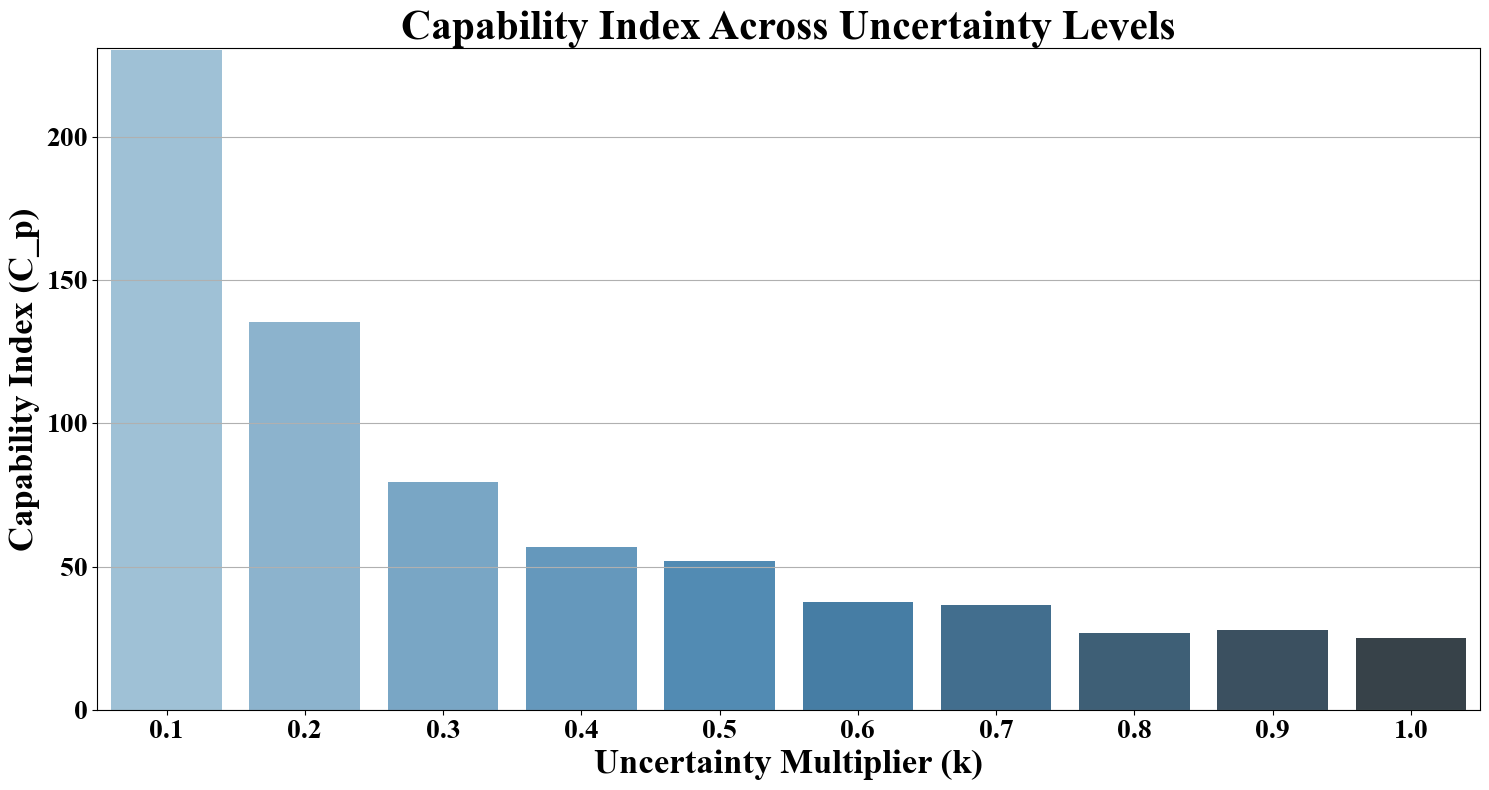

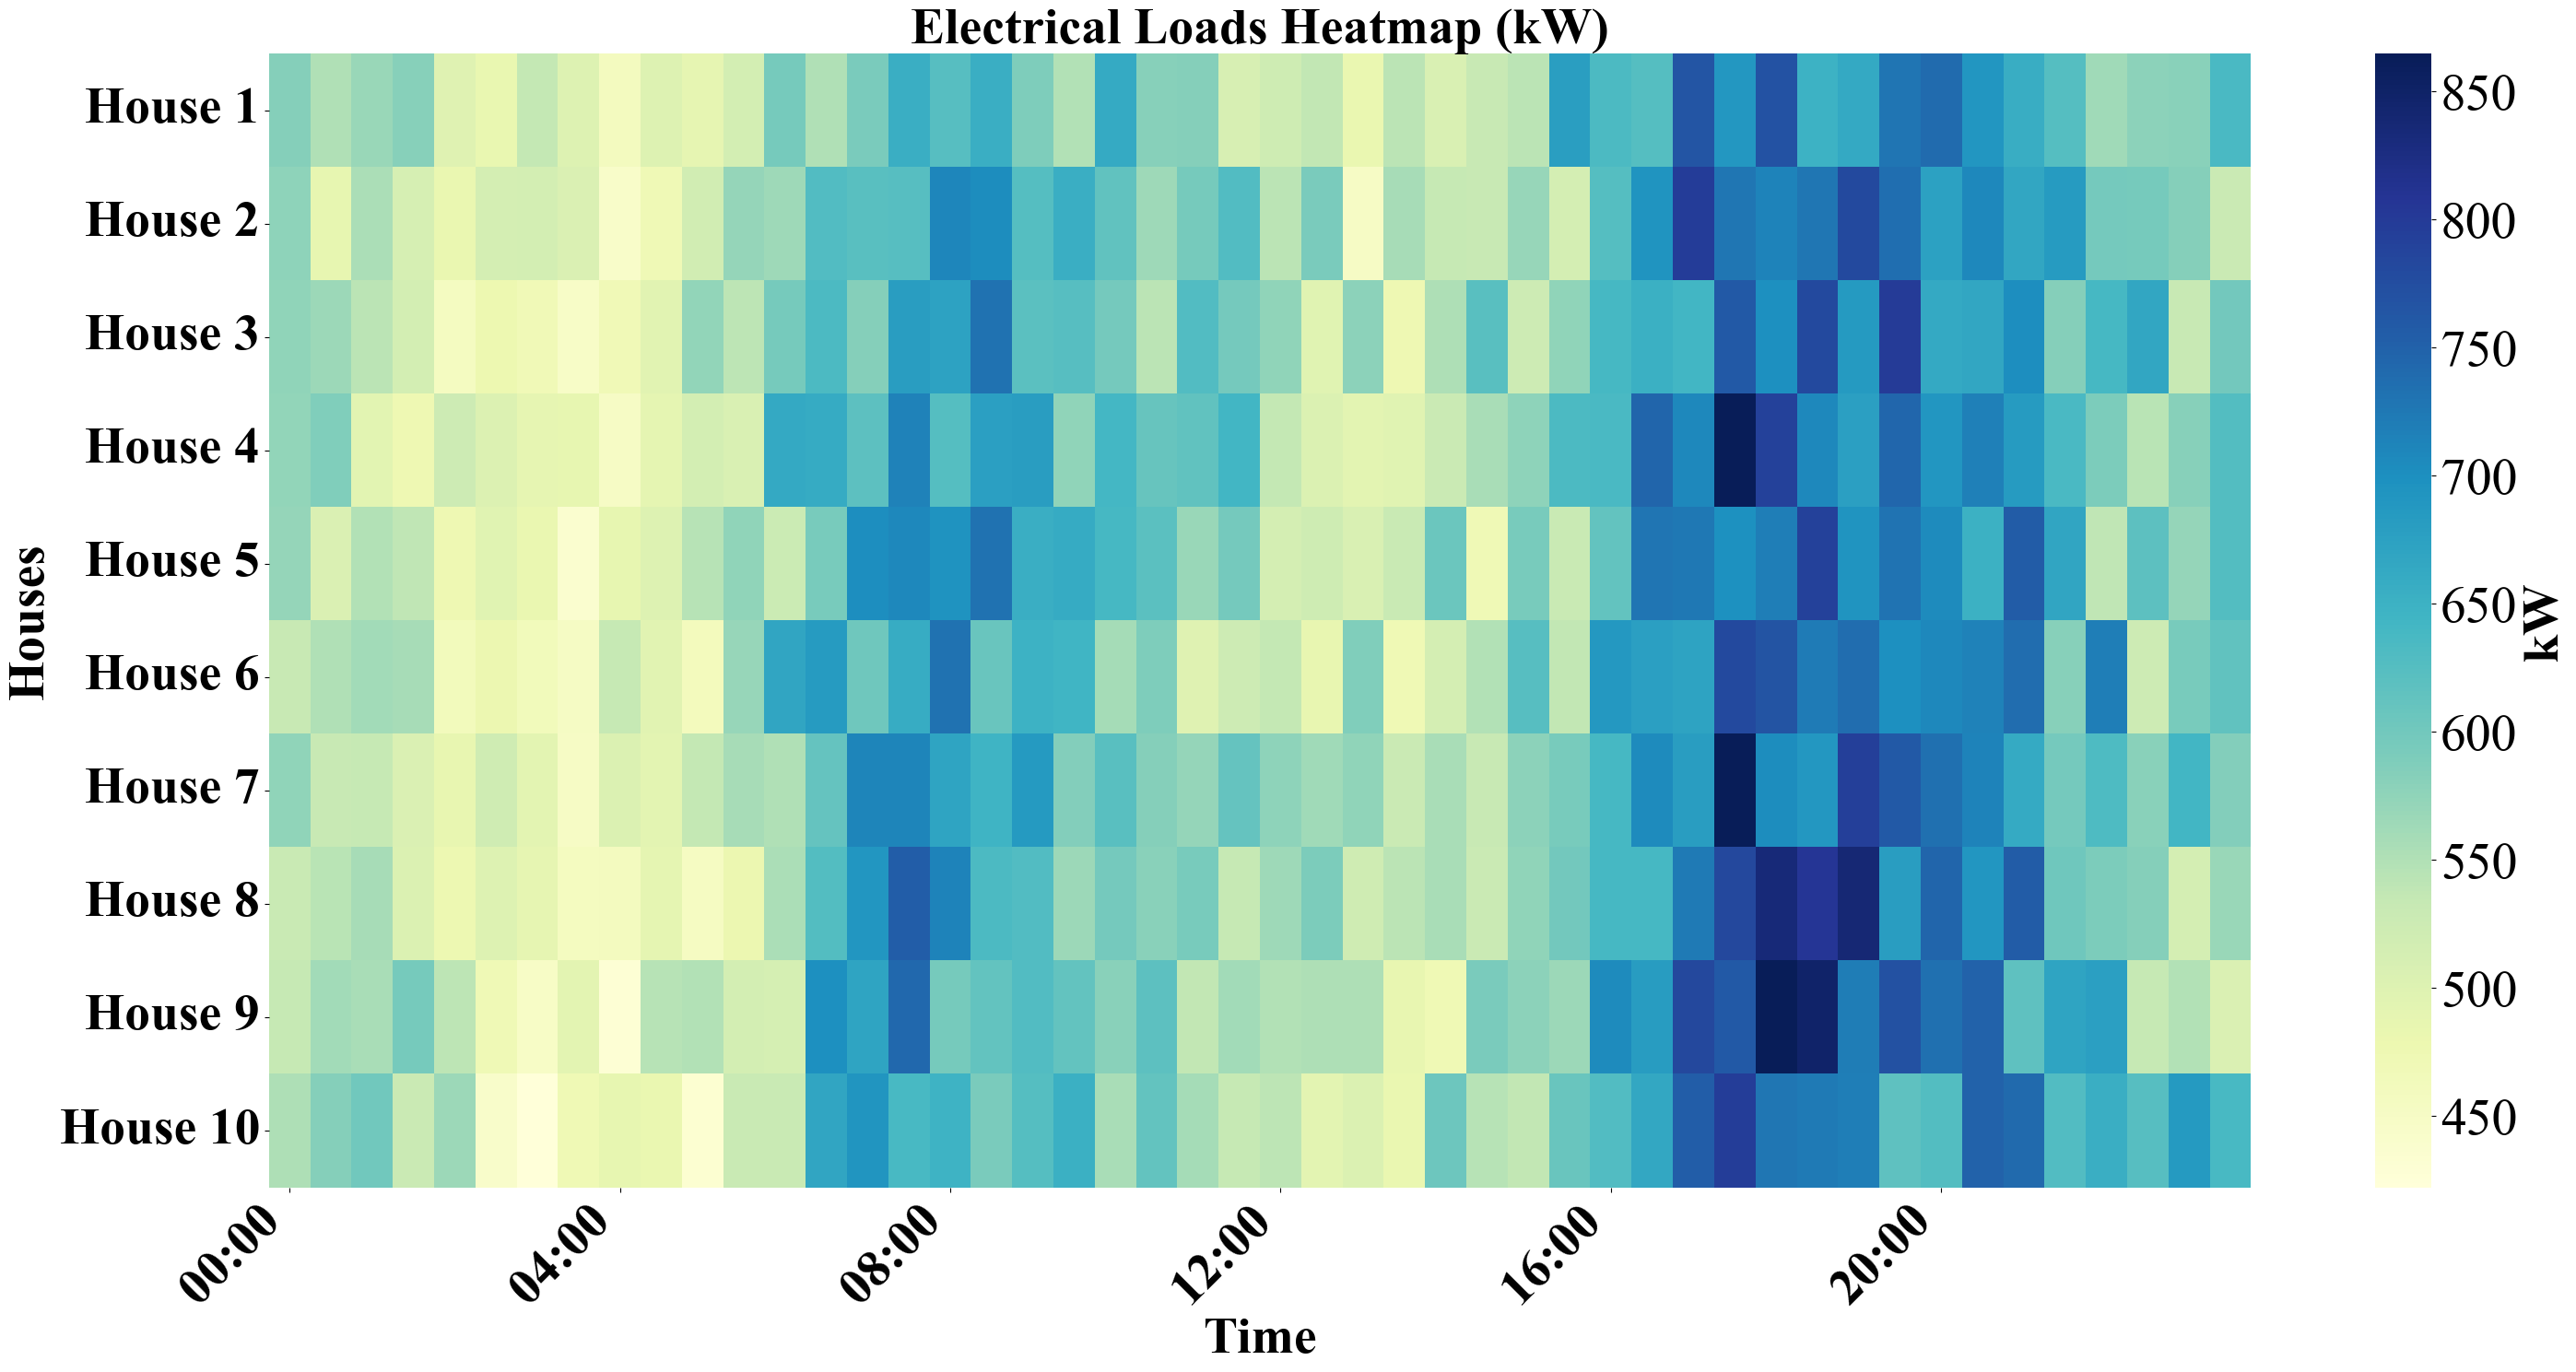

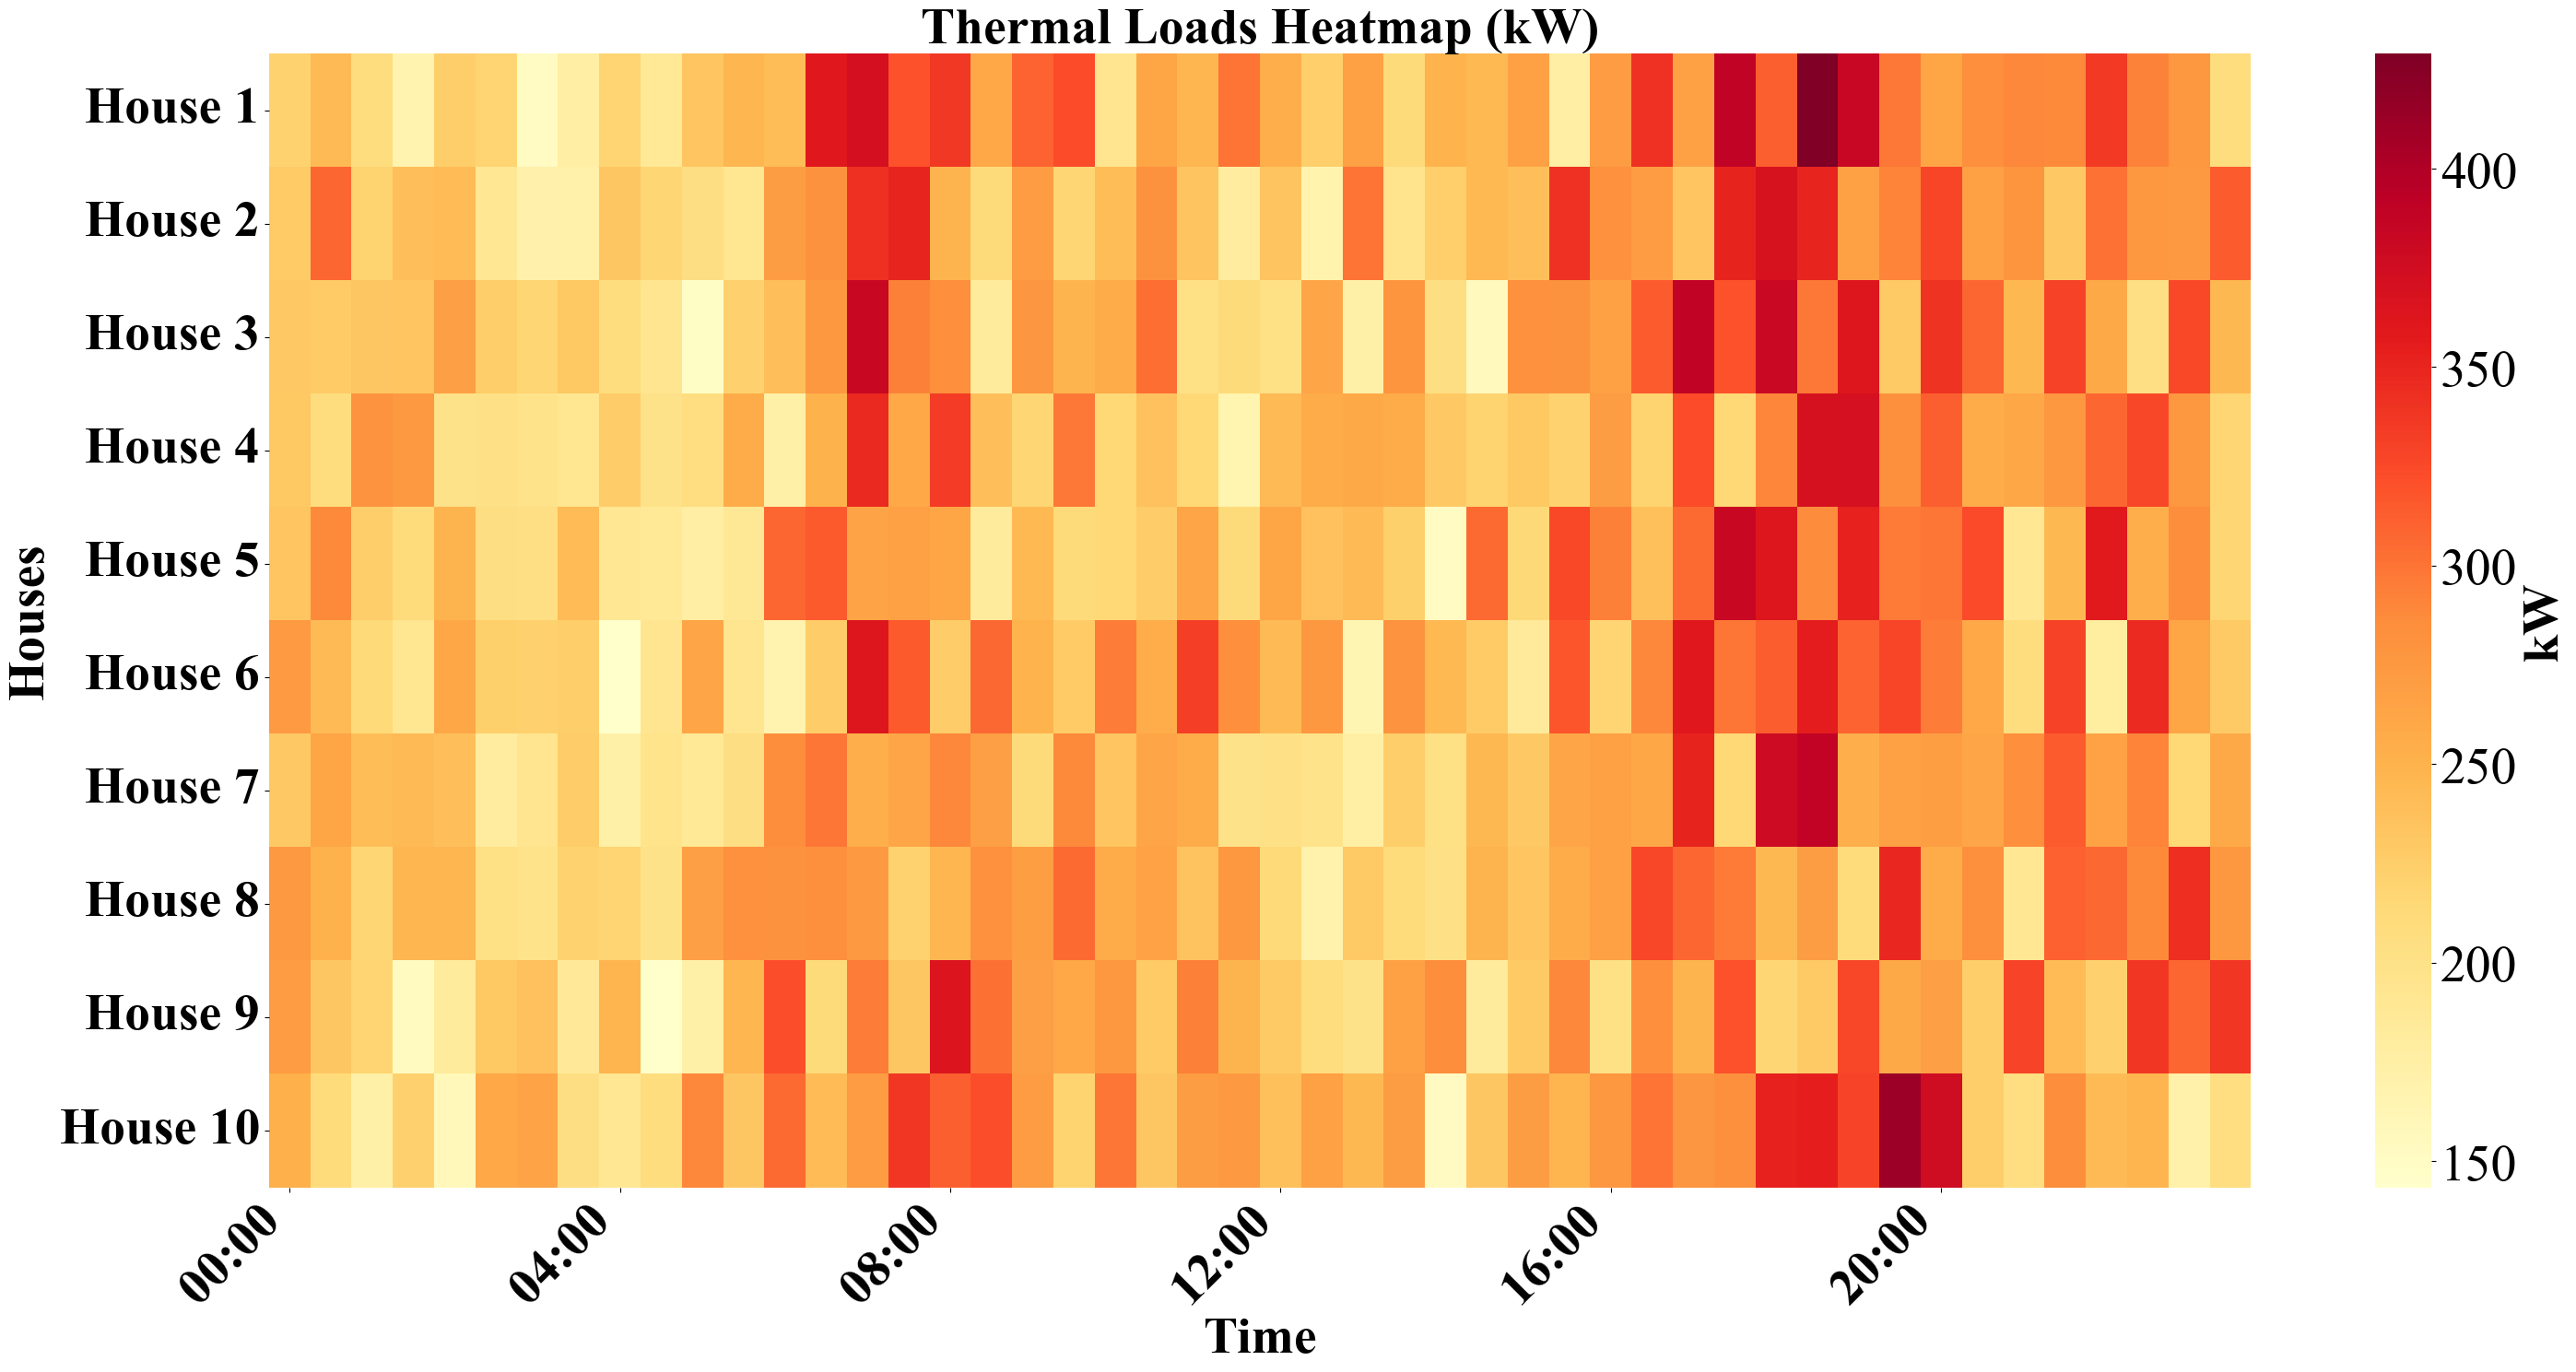

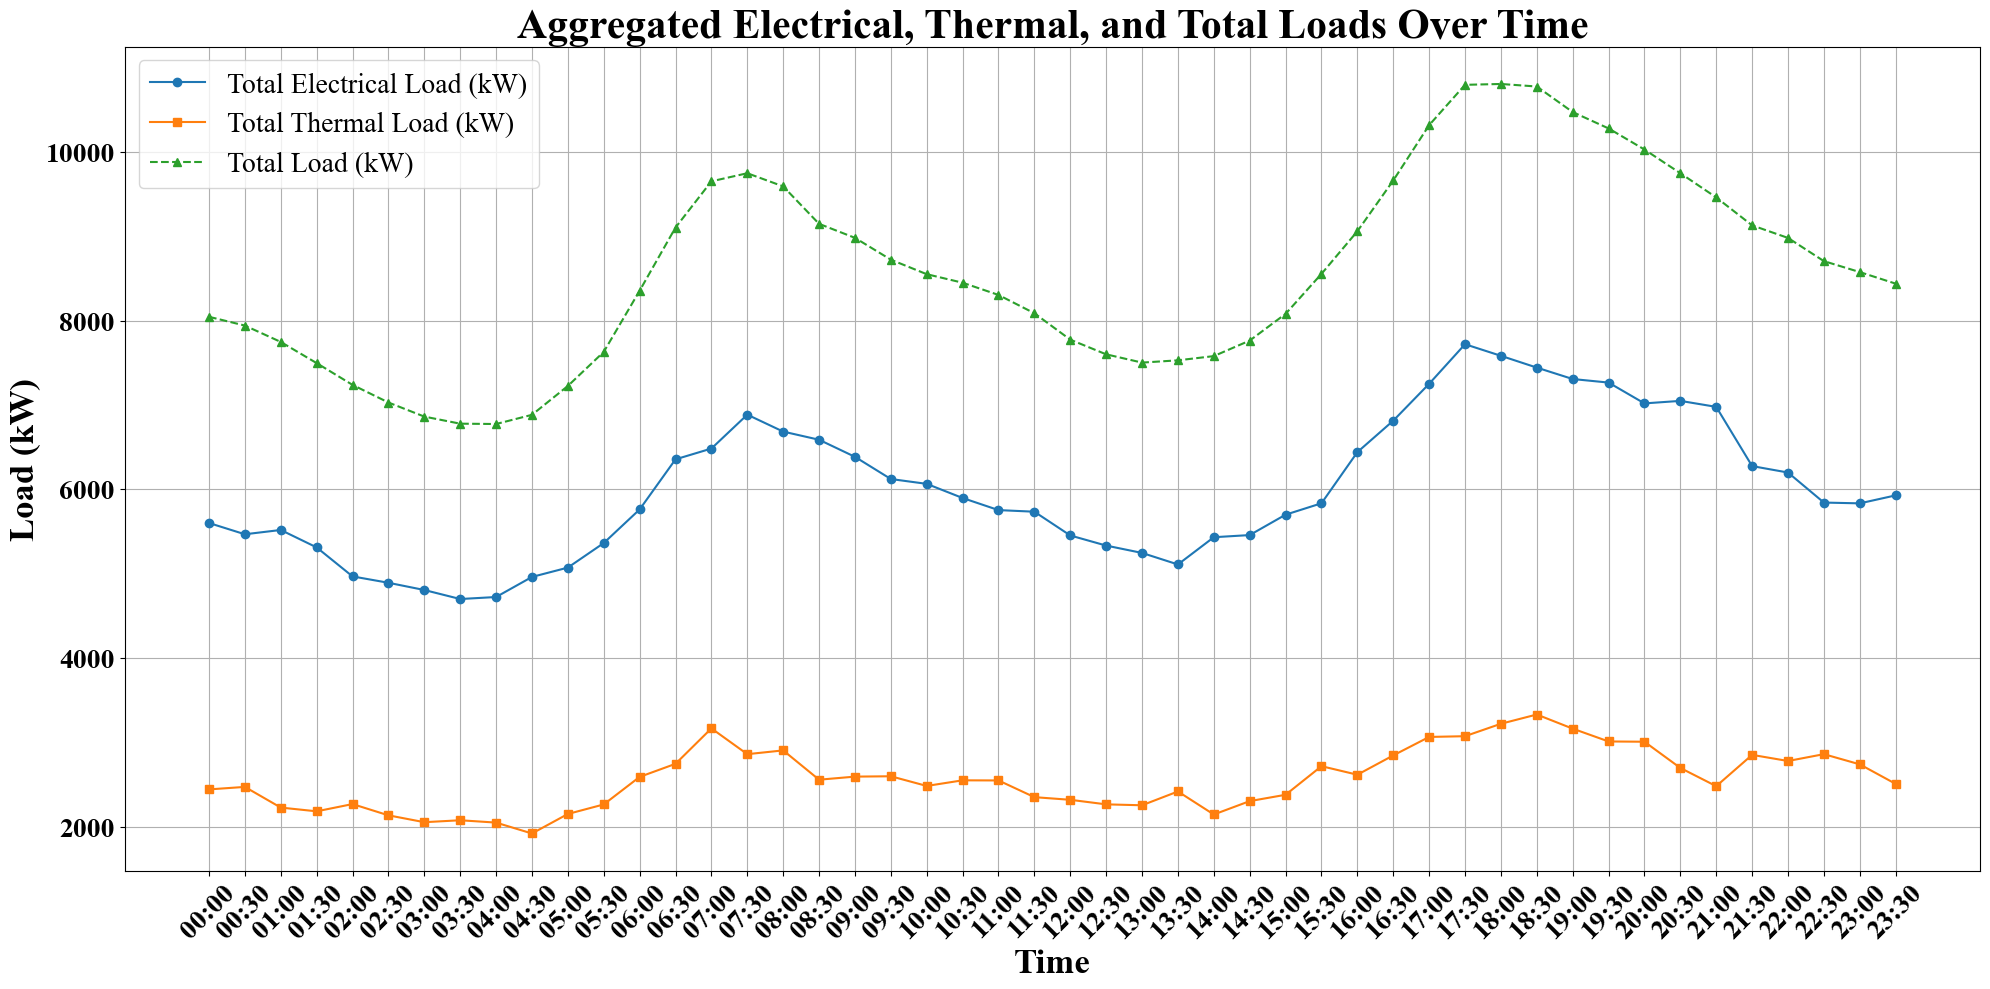

In [27]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported
import sys
import subprocess

def load_real_load_profiles_corrected(P_d, houses=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among houses by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each house's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - houses: Number of houses
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - house_elec_loads: numpy array of shape (houses, time_steps) in kW
    - house_therm_loads: numpy array of shape (houses, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    house_elec_loads = np.zeros((houses, time_steps))
    house_therm_loads = np.zeros((houses, time_steps))  # Thermal load

    for h in range(houses):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the house
            P_e = (total_load_kw[t] * elec_ratio) / houses
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / houses
            
            house_elec_loads[h, t] = P_e
            house_therm_loads[h, t] = P_t

    return house_elec_loads, house_therm_loads

def plot_heatmap(dataframe, title, cmap='viridis', figsize=(30, 15), annot=False, time_labels=None):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - title: Title of the heatmap.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': 'kW'})

    # Customize title, xlabel, ylabel with Times New Roman, size 40, bold
    plt.title(title, fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Houses', fontsize=40, fontweight='bold', fontname='Times New Roman')

    # Customize x-axis and y-axis tick labels with Times New Roman, size 40, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (houses)
    plt.yticks(rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label('kW', fontsize=40, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=40)  # Set colorbar ticks font size

    plt.tight_layout()
    plt.show()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, houses=10, time_steps=48):
    """
    Visualize electrical and thermal load profiles across houses and time steps.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)
    - houses: Number of houses
    - time_steps: Number of time steps
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    house_indices = [f"District {h+1}" for h in range(houses)]
    
    # Create DataFrames
    df_elec = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)
    df_therm = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    plot_heatmap(df_elec, 'Electrical Loads Heatmap (kW)', cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    plot_heatmap(df_therm, 'Thermal Loads Heatmap (kW)', cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads
    plt.figure(figsize=(20, 10))
    plt.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o')
    plt.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s')
    plt.plot(time_labels, total_load, label='Total Load (kW)', marker='^', linestyle='--')
    plt.title('Aggregated Electrical, Thermal, and Total Loads Over Time', fontsize=30, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Load (kW)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.xticks(rotation=45, fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.legend(fontsize=20, title_fontsize=25)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Provided Data
    P_d = np.array([
        8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780,
        6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749,
        9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089,
        7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556,
        9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280,
        10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440
    ]) / 1000  # Convert to MW

    Cg_t = np.array([
        99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29,
        81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48,
        92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83,
        56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19,
        151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63,
        154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    houses = 10                          # Number of houses
    time_steps = 48                      # Half-hourly intervals
    scaling_factor_etb = 0.04            # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04            # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per house (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per house (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per house
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per house

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000    # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5      # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000    # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    house_elec_loads, house_therm_loads = load_real_load_profiles_corrected(
        P_d, 
        houses=houses, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # For capability index, consider multiple uncertainty multipliers
    uncertainty_levels = np.arange(0.1, 1.1, 0.1)  # k from 0.1 to 1.0
    N_simulations = 100  # Number of simulations per uncertainty level

    # Define specified limits for Capability Index
    # Here, assuming specified_limits is a target cost threshold.
    # Adjust as per your actual definition or requirements.
    specified_limits = 200000  # Example value in $

    # Initialize DataFrame to store Capability Index results
    capability_index_results = pd.DataFrame(columns=['k', 'mu_k', 'sigma_k', 'C_p'])

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # Function to solve the optimization problem for given perturbed loads
    def solve_optimization(house_elec_loads_perturbed, house_therm_loads_perturbed):
        # Decision Variables
        ChargePTB = cp.Variable((houses, time_steps), nonneg=True)
        DischargePTB_Elec = cp.Variable((houses, time_steps), nonneg=True)

        ChargeETB = cp.Variable((houses, time_steps), nonneg=True)
        DischargeETB_Elec = cp.Variable((houses, time_steps), nonneg=True)
        DischargeETB_Therm = cp.Variable((houses, time_steps), nonneg=True)

        GasSupplyTherm = cp.Variable((houses, time_steps), nonneg=True)

        GridPowerElec = cp.Variable((houses, time_steps), nonneg=True)

        SOC_ETB = cp.Variable((houses, time_steps + 1))
        SOC_PTB = cp.Variable((houses, time_steps + 1))

        # Binary Variables to Prevent Simultaneous Charging and Discharging
        y_ptb_charge = cp.Variable((houses, time_steps), boolean=True)
        y_ptb_discharge = cp.Variable((houses, time_steps), boolean=True)

        y_etb_charge = cp.Variable((houses, time_steps), boolean=True)
        y_etb_discharge = cp.Variable((houses, time_steps), boolean=True)

        # SoC Deviation Variables (Linearization)
        soc_dev_etb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
        soc_dev_etb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

        soc_dev_ptb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
        soc_dev_ptb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

        constraints = [
            # Initialize SoC to 50% for all storage systems
            SOC_ETB[:,0] == 50,
            SOC_PTB[:,0] == 50,

            # SoC Deviation Constraints (Linearization)
            SOC_ETB == 50 + soc_dev_etb_pos - soc_dev_etb_neg,
            SOC_PTB == 50 + soc_dev_ptb_pos - soc_dev_ptb_neg
        ]

        for h in range(houses):
            for t in range(time_steps):
                # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
                worst_case_elec_load = house_elec_loads_perturbed[h,t]
                constraints += [
                    GridPowerElec[h,t] + DischargePTB_Elec[h,t] + DischargeETB_Elec[h,t] == ChargePTB[h,t] + ChargeETB[h,t] + worst_case_elec_load
                ]

                # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
                worst_case_therm_load = house_therm_loads_perturbed[h,t]
                constraints += [
                    GasSupplyTherm[h,t] + DischargeETB_Therm[h,t] == worst_case_therm_load
                ]

                # Prevent Simultaneous Charging and Discharging for PTB
                constraints += [
                    ChargePTB[h,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[h,t],
                    DischargePTB_Elec[h,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[h,t],
                    y_ptb_charge[h,t] + y_ptb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
                ]

                # Prevent Simultaneous Charging and Discharging for ETB
                constraints += [
                    ChargeETB[h,t] <= bess_etb_power_capacity_kw * y_etb_charge[h,t],
                    DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t] <= bess_etb_power_capacity_kw * y_etb_discharge[h,t],
                    y_etb_charge[h,t] + y_etb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
                ]

                # SoC updates for PTB
                constraints += [
                    SOC_PTB[h,t+1] == SOC_PTB[h,t] + (ChargePTB[h,t] * 0.95 - DischargePTB_Elec[h,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
                ]

                # SoC updates for ETB
                constraints += [
                    SOC_ETB[h,t+1] == SOC_ETB[h,t] + (ChargeETB[h,t] * 0.95 - (DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
                ]

                # SoC Limits for PTB and ETB
                constraints += [
                    SOC_PTB[h,t+1] >= 20,
                    SOC_PTB[h,t+1] <= 100,
                    SOC_ETB[h,t+1] >= 20,
                    SOC_ETB[h,t+1] <= 100
                ]

        # Final SoC Constraints
        constraints += [
            SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
            SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
        ]

        # Objective Function Components
        # Tile Cg_t and Cb_t to match the (houses, time_steps) shape
        Cg_t_matrix = np.tile(Cg_t, (houses, 1))      # Grid electricity tariff ($/kWh)
        Cb_ptb_matrix = np.tile(Cb_ptb, (houses, 1))  # PTB charging cost ($/kWh)
        Cb_etb_matrix = np.tile(Cb_etb, (houses, 1))  # ETB charging cost ($/kWh)

        # Tile the incentives to match the (houses, time_steps) shape
        o_ptb_matrix = np.tile(o_incentive_ptb, (houses, time_steps))          # Charging incentive for PTB ($/kWh)
        o_etb_matrix = np.tile(o_incentive_etb, (houses, time_steps))          # Charging incentive for ETB ($/kWh)
        d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (houses, time_steps))  # PTB discharging incentive ($/kWh)
        d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (houses, time_steps))  # ETB-Elec discharging incentive ($/kWh)
        d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (houses, time_steps))  # ETB-Therm discharging incentive ($/kWh)

        # Define penalty weight for SoC deviation
        soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

        # SoC Deviation Penalty (Linearization using Absolute Deviations)
        soc_penalty = soc_penalty_weight * (
            cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
            cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
        )

        # Charging Incentives
        total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                     cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

        # Incentives from Discharging PTB and ETB
        total_incentives = (
            cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
            cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
            cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
        )

        # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
        total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix))
        total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
        total_battery_cost = (
            cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
            cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
        )

        # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
        objective = cp.Minimize(
            total_grid_cost + 
            total_gas_cost + 
            total_battery_cost - 
            total_incentives - 
            total_charging_incentives + 
            soc_penalty
        )

        # Define and solve the problem
        prob = cp.Problem(objective, constraints)

        # Set the Gurobi license file path
        os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

        # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
        # Ensure that Gurobi is installed and properly licensed.
        try:
            prob.solve(solver=cp.GUROBI, verbose=False, mip_gap=0.01, threads=4)
        except cp.error.SolverError:
            print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
            # Optionally, you can fallback to another solver here
            try:
                prob.solve(solver=cp.GLPK_MI, verbose=False, mip_gap=0.01)
            except cp.error.SolverError as e:
                print("Both Gurobi and GLPK_MI solvers failed.")
                print(str(e))
                return None

        if prob.status not in ["infeasible", "unbounded"]:
            return prob.value
        else:
            return None

    # -----------------------------------
    # 2. Capability Index Computation
    # -----------------------------------

    # Initialize random seed for reproducibility
    np.random.seed(42)

    # Initialize lists to store results
    capability_data = []

    for k in uncertainty_levels:
        print(f"Processing uncertainty multiplier k={k:.1f}")
        costs = []

        for sim in range(N_simulations):
            # Perturb electrical and thermal loads based on k and Gaussian distribution
            perturbed_elec_loads = house_elec_loads * (1 + k * 0.05 * np.random.randn(houses, time_steps))
            perturbed_therm_loads = house_therm_loads * (1 + k * 0.05 * np.random.randn(houses, time_steps))

            # Ensure no negative loads
            perturbed_elec_loads = np.clip(perturbed_elec_loads, 0, None)
            perturbed_therm_loads = np.clip(perturbed_therm_loads, 0, None)

            # Solve the optimization problem
            total_cost = solve_optimization(perturbed_elec_loads, perturbed_therm_loads)

            if total_cost is not None:
                costs.append(total_cost)

        if len(costs) == 0:
            print(f"No feasible solutions found for k={k:.1f}. Skipping Capability Index calculation.")
            continue

        # Calculate mu_k and sigma_k
        mu_k = np.mean(costs)
        sigma_k = np.std(costs)

        # Calculate Capability Index
        C_p = (specified_limits - mu_k) / (3 * sigma_k)

        # Append results
        capability_data.append({
            'k': round(k, 1),
            'mu_k': round(mu_k, 2),
            'sigma_k': round(sigma_k, 2),
            'C_p': round(C_p, 2)
        })

    # Create DataFrame for Capability Index
    capability_df = pd.DataFrame(capability_data)

    # Display Capability Index Results
    print(capability_df)

    # Save Capability Index Results to CSV (optional)
    capability_df.to_csv('capability_index_results.csv', index=False)

    # -----------------------------------
    # 3. Visualization of Capability Index
    # -----------------------------------

    plt.figure(figsize=(15, 8))
    sns.barplot(x='k', y='C_p', data=capability_df, palette='Blues_d')
    plt.title('Capability Index Across Uncertainty Levels', fontsize=30, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Uncertainty Multiplier (k)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Capability Index (C_p)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.xticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.ylim(0, capability_df['C_p'].max() + 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # -----------------------------------
    # 4. Visualization: Plot Heatmaps (Optional)
    # -----------------------------------
    # If desired, you can call visualize_load_profiles here with specific simulation results.

    # Example: Plot for k=0.5 and simulation=0
    # Replace 'simulation=0' with appropriate indices based on your simulation structure

    # -----------------------------------
    # 5. Visualization of Load Profiles (Optional)
    # -----------------------------------
    # You can visualize the original load profiles
    visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, houses=houses, time_steps=time_steps)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    # Optional: Install GLPK_MI if Gurobi is not available
    # install_glpk()

    main_robust_mpc_corrected()


Processing uncertainty multiplier k=0.1
Processing uncertainty multiplier k=0.2
Processing uncertainty multiplier k=0.3
Processing uncertainty multiplier k=0.4
Processing uncertainty multiplier k=0.5
Processing uncertainty multiplier k=0.6
Processing uncertainty multiplier k=0.7
Processing uncertainty multiplier k=0.8
Processing uncertainty multiplier k=0.9
Processing uncertainty multiplier k=1.0
     k       mu_k  sigma_k      C_p
0  0.1 -219512.61   106.04  1318.73
1  0.2 -219518.21   116.06  1204.84
2  0.3 -219524.27   108.00  1294.89
3  0.4 -219533.48   113.88  1228.00
4  0.5 -219531.74   100.47  1391.93
5  0.6 -219515.21   123.61  1131.25
6  0.7 -219523.73   121.46  1151.33
7  0.8 -219543.09   136.26  1026.34
8  0.9 -219514.94   127.48  1096.90
9  1.0 -219527.14   145.64   960.18


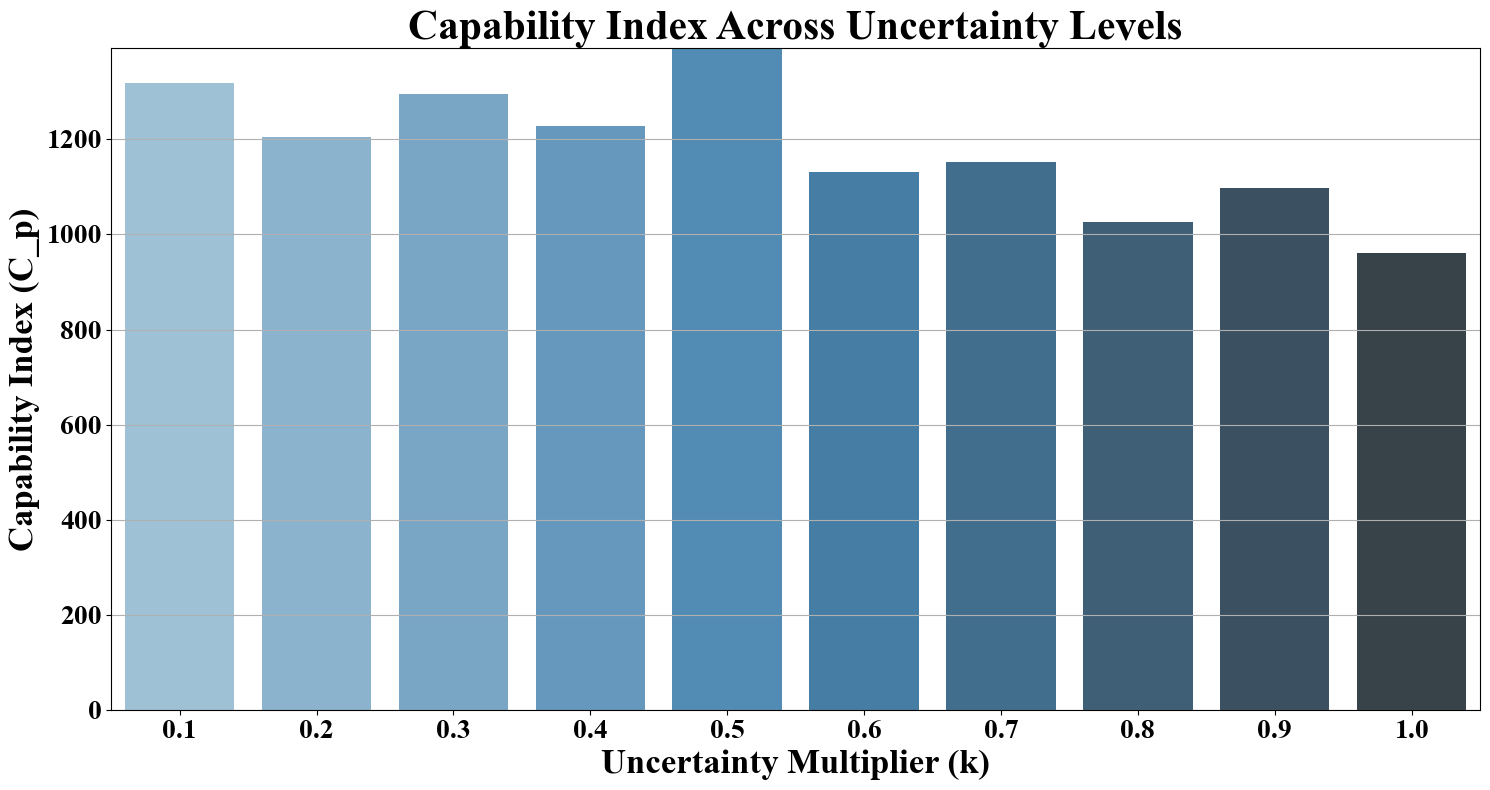

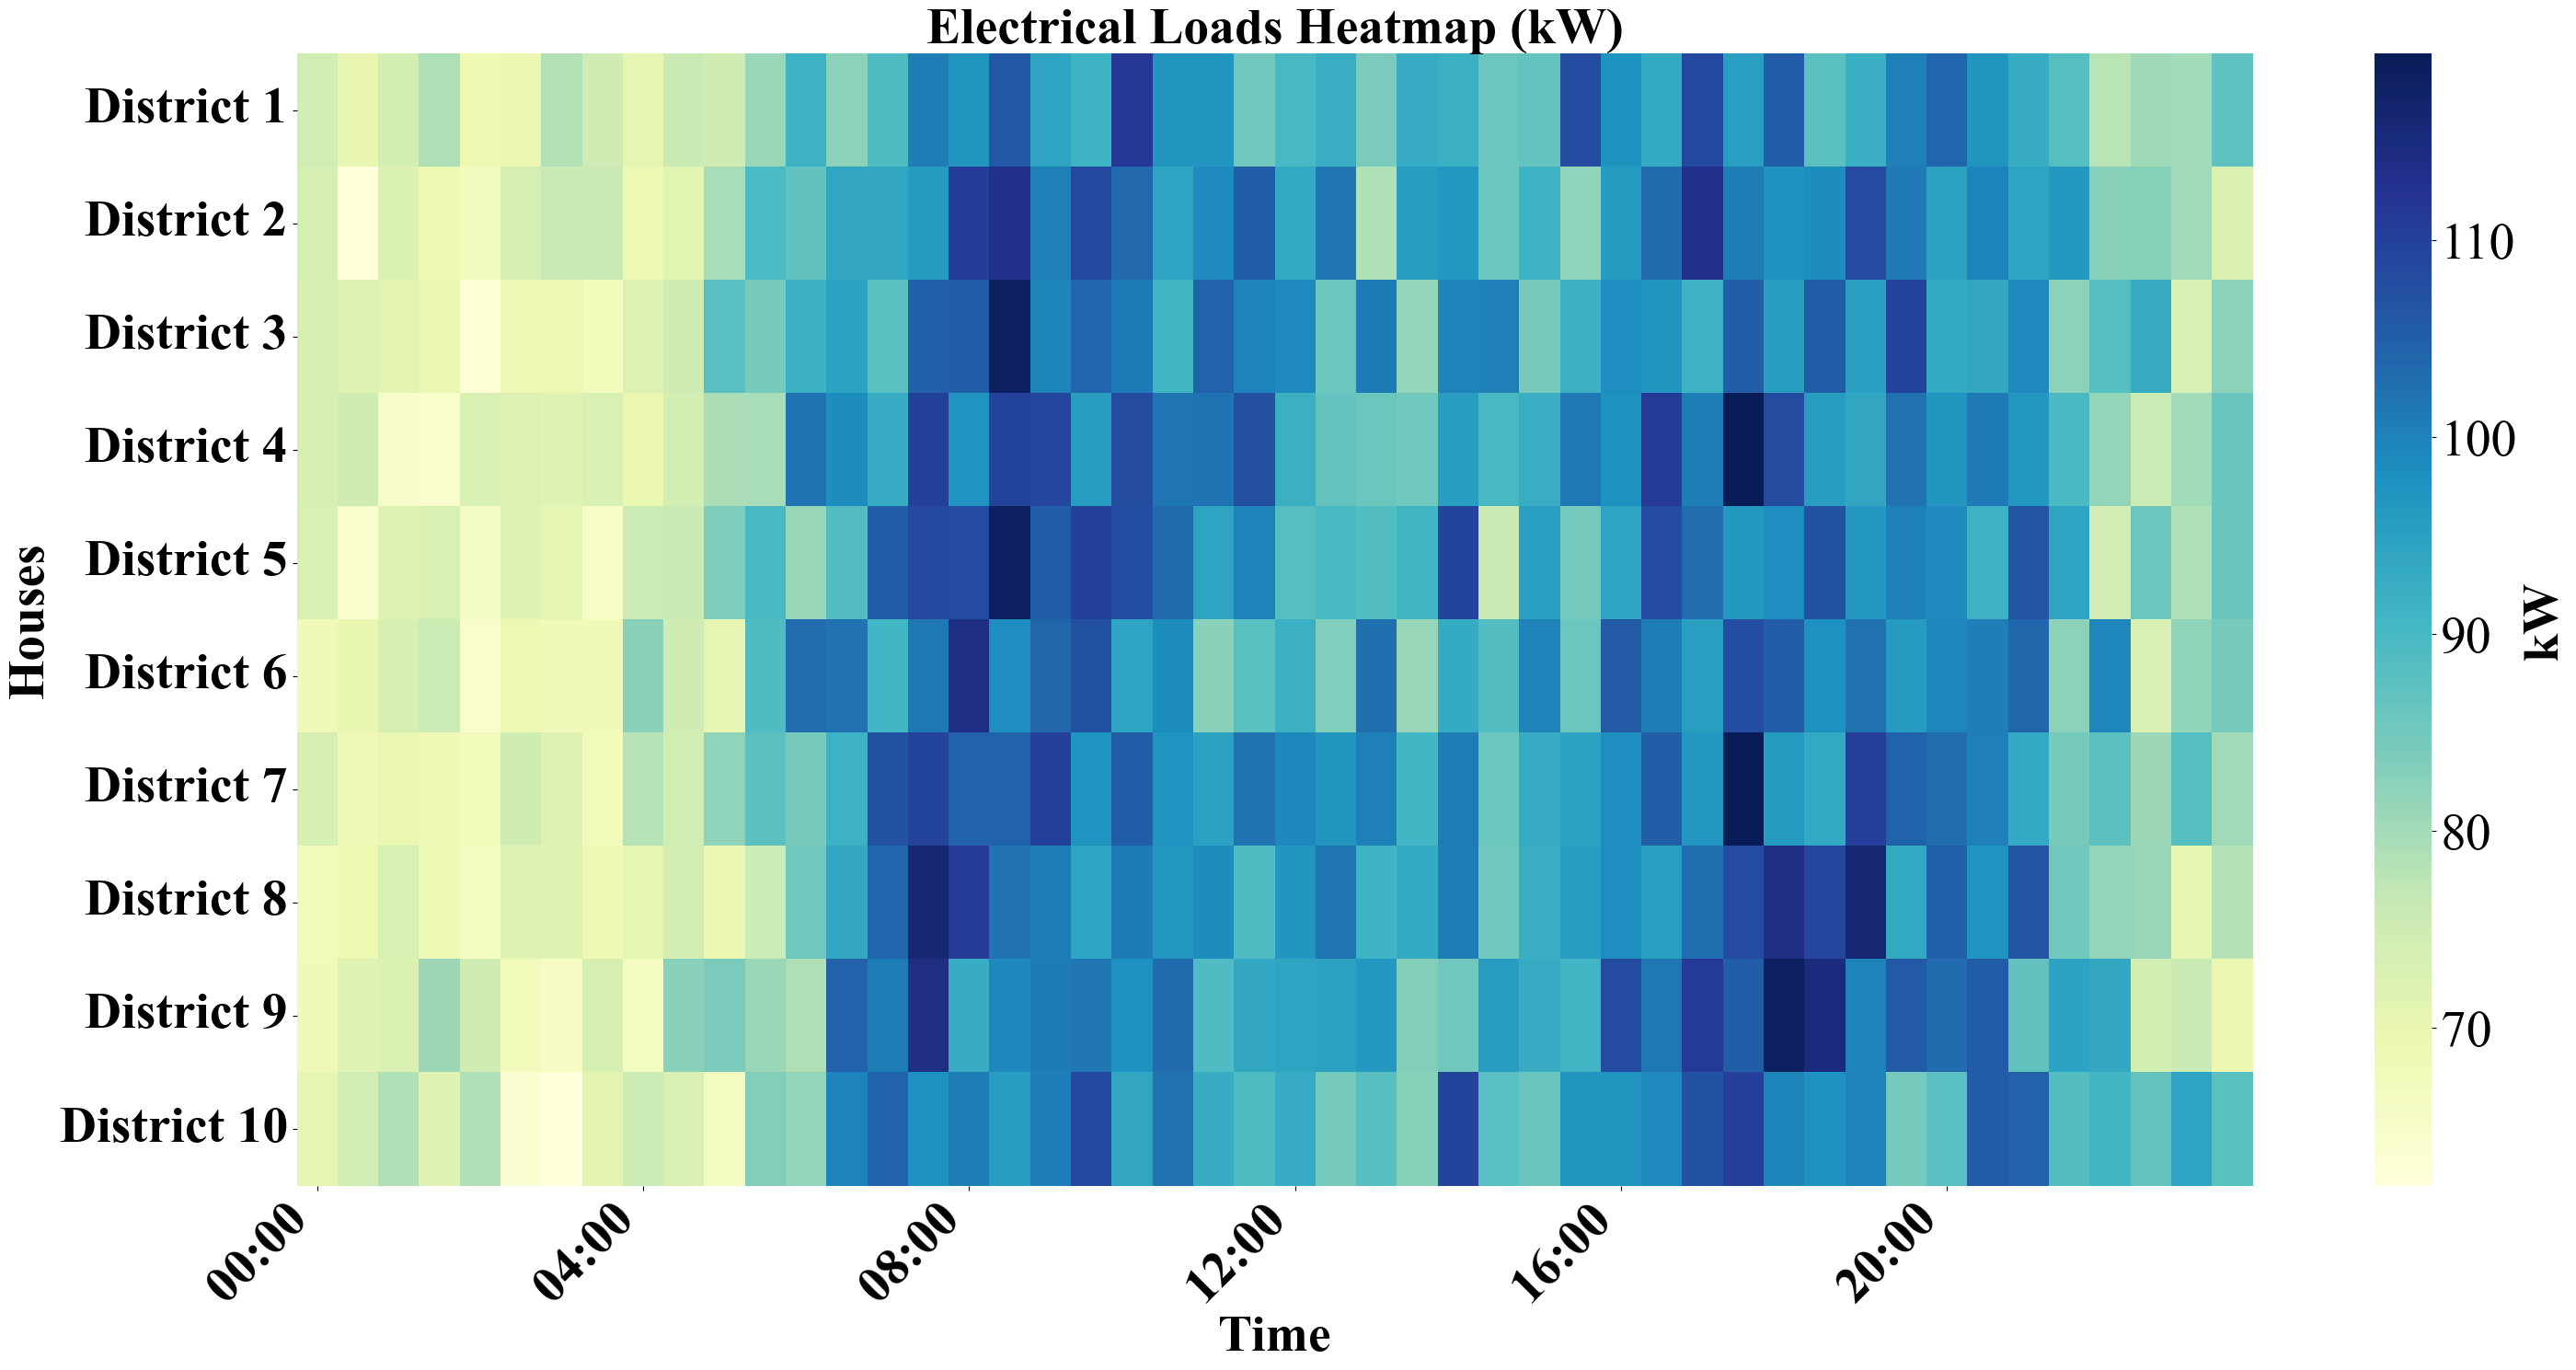

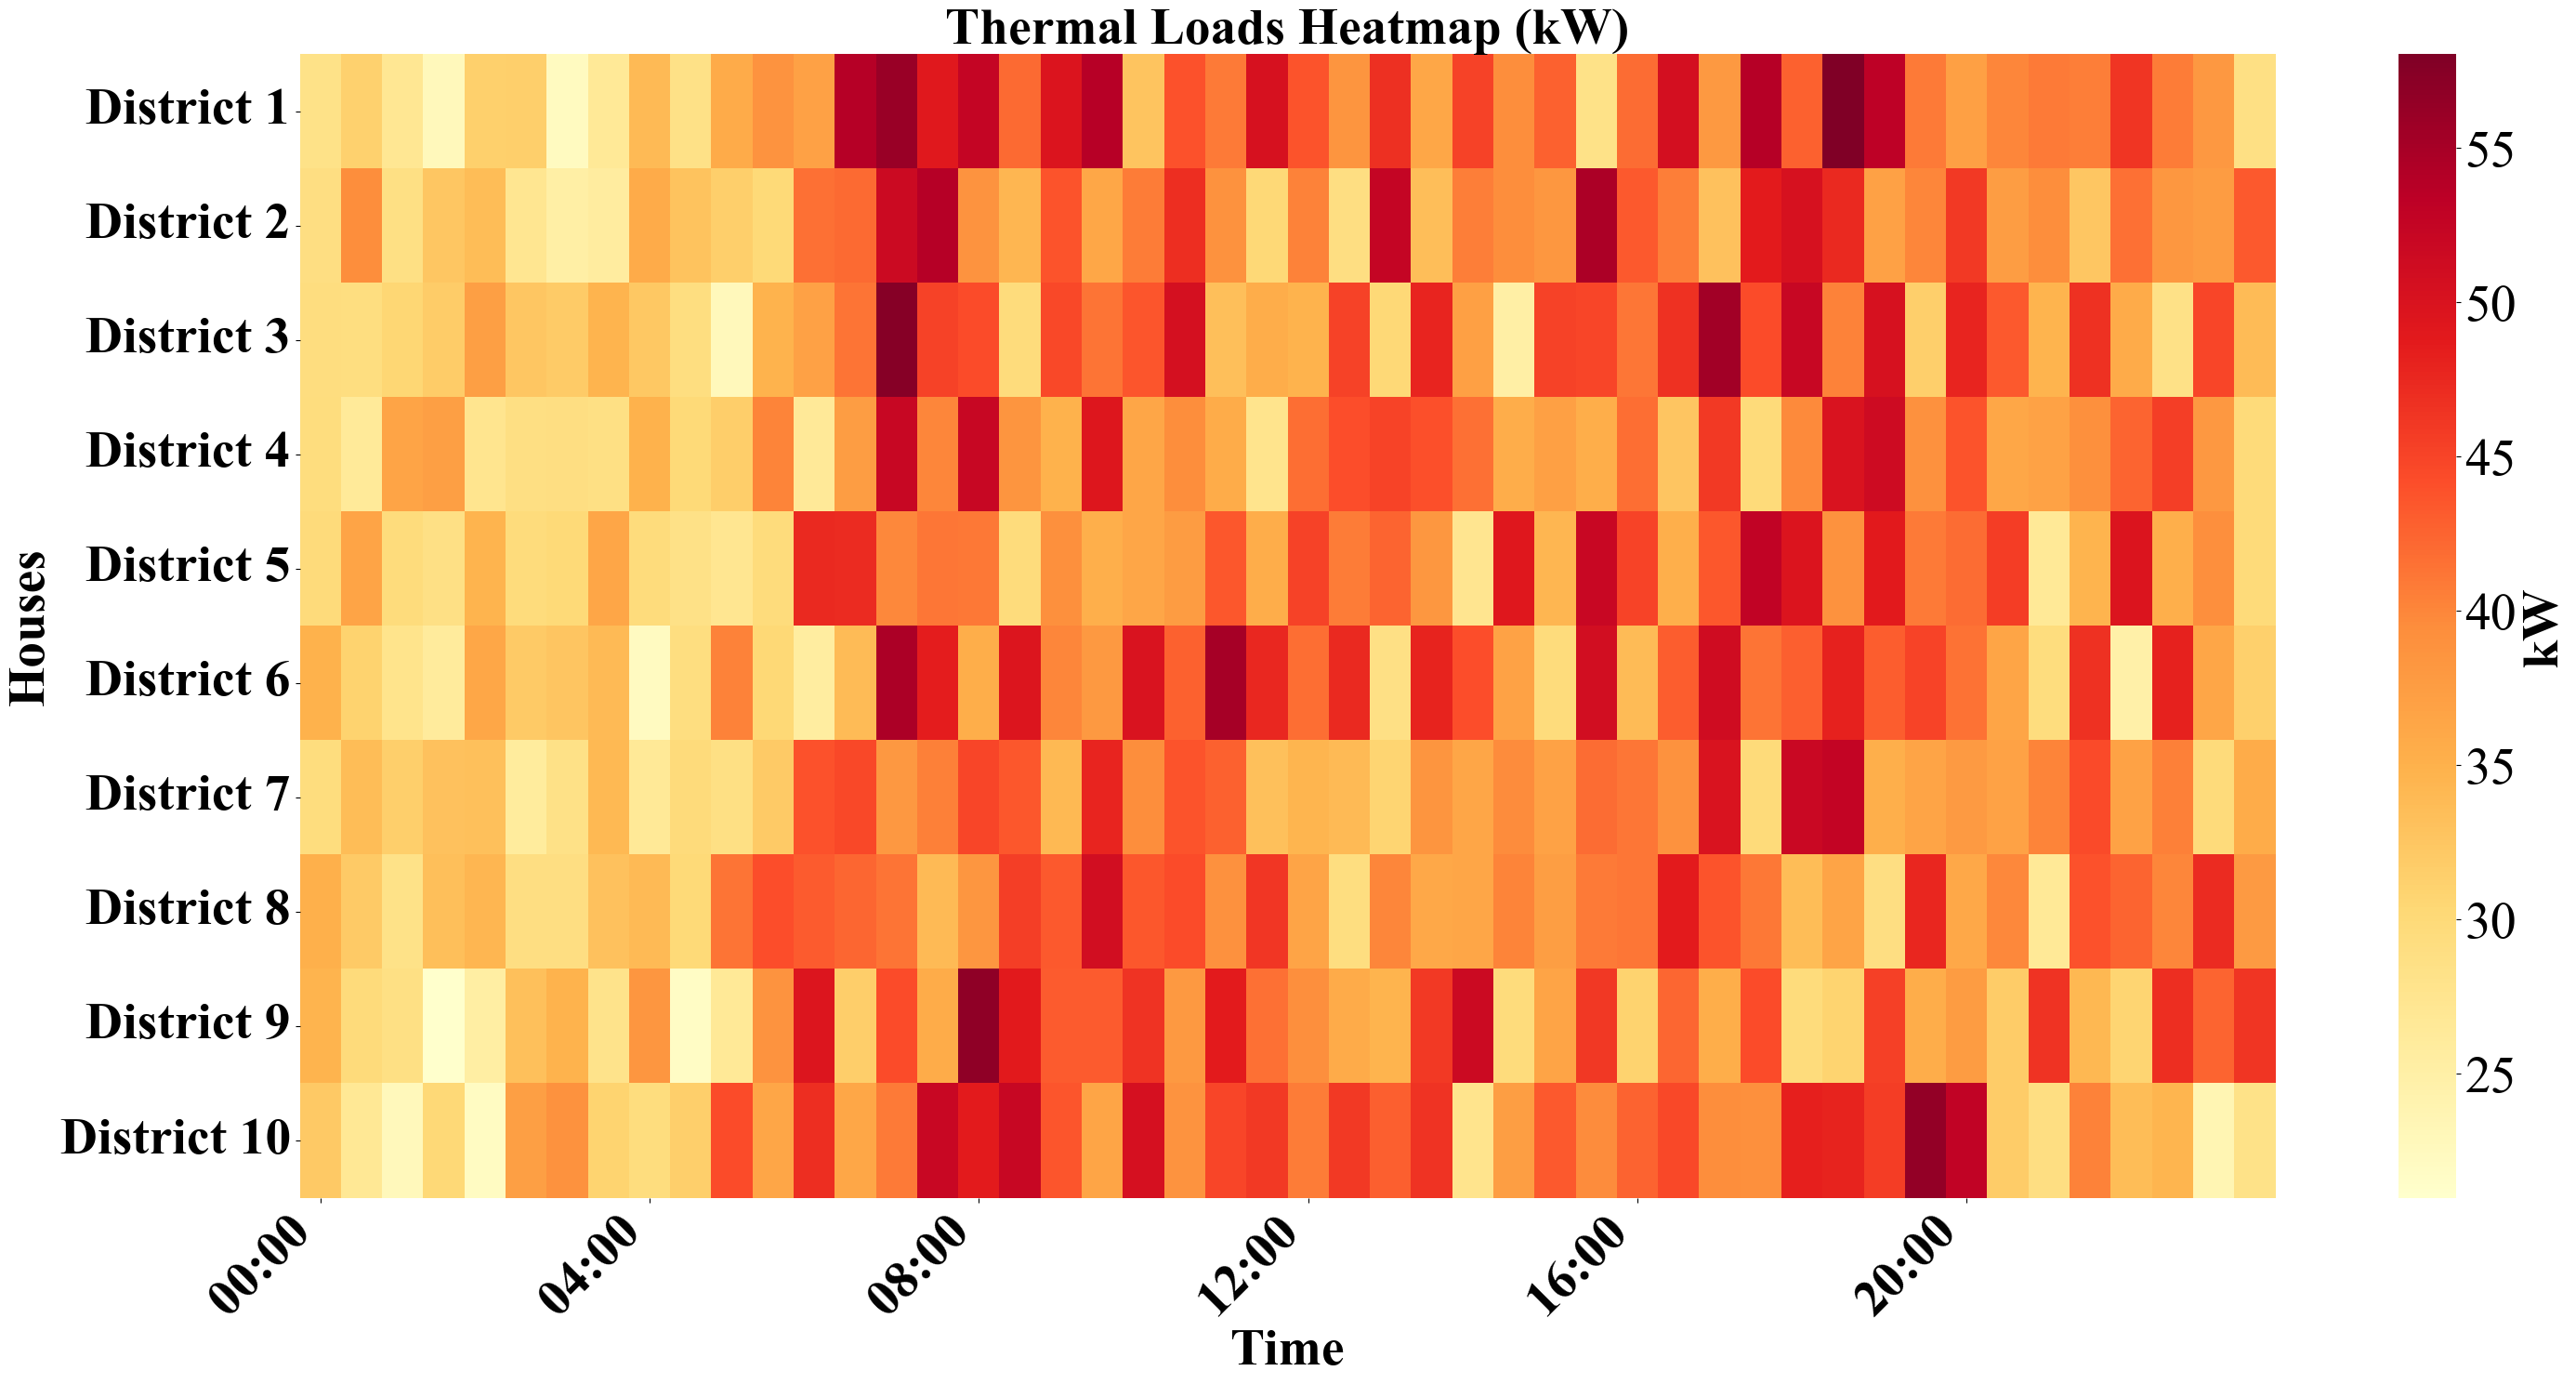

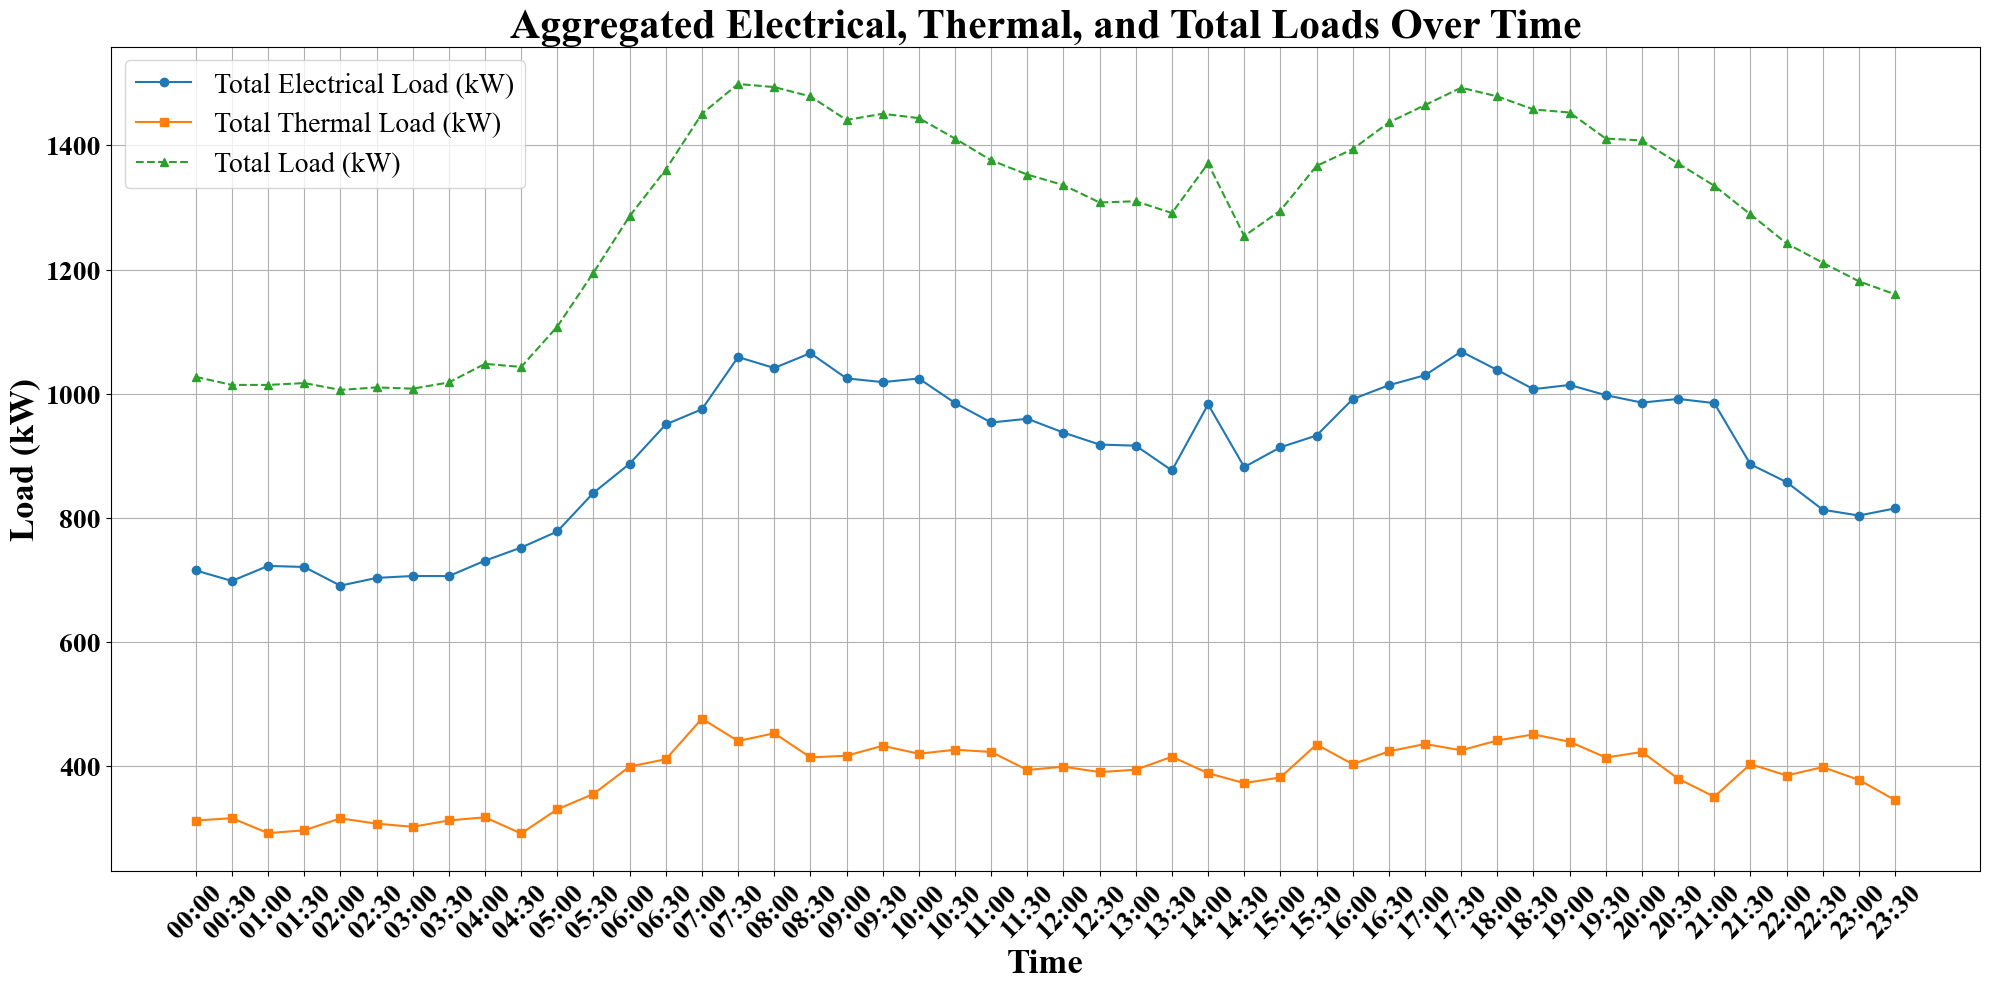

In [18]:
#TAS


import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported
import sys
import subprocess

def load_real_load_profiles_corrected(P_d, houses=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among houses by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each house's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - houses: Number of houses
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - house_elec_loads: numpy array of shape (houses, time_steps) in kW
    - house_therm_loads: numpy array of shape (houses, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    house_elec_loads = np.zeros((houses, time_steps))
    house_therm_loads = np.zeros((houses, time_steps))  # Thermal load

    for h in range(houses):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the house
            P_e = (total_load_kw[t] * elec_ratio) / houses
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / houses
            
            house_elec_loads[h, t] = P_e
            house_therm_loads[h, t] = P_t

    return house_elec_loads, house_therm_loads

def plot_heatmap(dataframe, title, cmap='viridis', figsize=(30, 15), annot=False, time_labels=None):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - title: Title of the heatmap.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': 'kW'})

    # Customize title, xlabel, ylabel with Times New Roman, size 40, bold
    plt.title(title, fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Houses', fontsize=40, fontweight='bold', fontname='Times New Roman')

    # Customize x-axis and y-axis tick labels with Times New Roman, size 40, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (houses)
    plt.yticks(rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label('kW', fontsize=40, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=40)  # Set colorbar ticks font size

    plt.tight_layout()
    plt.show()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, houses=10, time_steps=48):
    """
    Visualize electrical and thermal load profiles across houses and time steps.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)
    - houses: Number of houses
    - time_steps: Number of time steps
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    house_indices = [f"District {h+1}" for h in range(houses)]
    
    # Create DataFrames
    df_elec = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)
    df_therm = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    plot_heatmap(df_elec, 'Electrical Loads Heatmap (kW)', cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    plot_heatmap(df_therm, 'Thermal Loads Heatmap (kW)', cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads
    plt.figure(figsize=(20, 10))
    plt.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o')
    plt.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s')
    plt.plot(time_labels, total_load, label='Total Load (kW)', marker='^', linestyle='--')
    plt.title('Aggregated Electrical, Thermal, and Total Loads Over Time', fontsize=30, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Load (kW)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.xticks(rotation=45, fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.legend(fontsize=20, title_fontsize=25)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Provded Data for Tasmania (TAS)
    P_d = np.array([
        1027, 1014, 1014, 1017, 1006, 1010, 1008, 1018, 1048, 1043, 
        1108, 1195, 1286, 1361, 1451, 1499, 1494, 1479, 1441, 1451, 
        1444, 1411, 1376, 1353, 1336, 1308, 1310, 1291, 1371, 1254, 
        1295, 1367, 1394, 1437, 1465, 1493, 1479, 1458, 1453, 1411, 
        1408, 1371, 1335, 1289, 1242, 1211, 1181, 1160
    ]) / 1000  # Convert to MW

    Cg_t = np.array([
        22.61, 20.53, 15.97, 13.03, 13.09, 13.15, 19.57, 18.02, 23.94, 
        23.83, 27.29, 33.96, 54.96, 72.37, 65.25, 69.1, 58.78, 54.69, 
        64.42, 60.94, 50.5, 48.35, 47.19, 33.31, 34.7, 29.31, 32.57, 
        36.13, 48.62, 53.47, 177.81, 58.13, 70.26, 69.25, 65.75, 
        53.51, 48.78, 56.82, 53.92, 57.97, 55.19, 52.02, 48.22, 
        38.79, 33.74, 33.15, 30.72, 29.31
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    houses = 10                          # Number of houses
    time_steps = 48                      # Half-hourly intervals
    scaling_factor_etb = 0.04            # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04            # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per house (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per house (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per house
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per house

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000    # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5      # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000    # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    house_elec_loads, house_therm_loads = load_real_load_profiles_corrected(
        P_d, 
        houses=houses, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # For capability index, consider multiple uncertainty multipliers
    uncertainty_levels = np.arange(0.1, 1.1, 0.1)  # k from 0.1 to 1.0
    N_simulations = 100  # Number of simulations per uncertainty level

    # Define specified limits for Capability Index
    # Here, assuming specified_limits is a target cost threshold.
    # Adjust as per your actual definition or requirements.
    specified_limits = 200000  # Example value in $

    # Initialize DataFrame to store Capability Index results
    capability_index_results = pd.DataFrame(columns=['k', 'mu_k', 'sigma_k', 'C_p'])

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # Function to solve the optimization problem for given perturbed loads
    def solve_optimization(house_elec_loads_perturbed, house_therm_loads_perturbed):
        # Decision Variables
        ChargePTB = cp.Variable((houses, time_steps), nonneg=True)
        DischargePTB_Elec = cp.Variable((houses, time_steps), nonneg=True)

        ChargeETB = cp.Variable((houses, time_steps), nonneg=True)
        DischargeETB_Elec = cp.Variable((houses, time_steps), nonneg=True)
        DischargeETB_Therm = cp.Variable((houses, time_steps), nonneg=True)

        GasSupplyTherm = cp.Variable((houses, time_steps), nonneg=True)

        GridPowerElec = cp.Variable((houses, time_steps), nonneg=True)

        SOC_ETB = cp.Variable((houses, time_steps + 1))
        SOC_PTB = cp.Variable((houses, time_steps + 1))

        # Binary Variables to Prevent Simultaneous Charging and Discharging
        y_ptb_charge = cp.Variable((houses, time_steps), boolean=True)
        y_ptb_discharge = cp.Variable((houses, time_steps), boolean=True)

        y_etb_charge = cp.Variable((houses, time_steps), boolean=True)
        y_etb_discharge = cp.Variable((houses, time_steps), boolean=True)

        # SoC Deviation Variables (Linearization)
        soc_dev_etb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
        soc_dev_etb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

        soc_dev_ptb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
        soc_dev_ptb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

        constraints = [
            # Initialize SoC to 50% for all storage systems
            SOC_ETB[:,0] == 50,
            SOC_PTB[:,0] == 50,

            # SoC Deviation Constraints (Linearization)
            SOC_ETB == 50 + soc_dev_etb_pos - soc_dev_etb_neg,
            SOC_PTB == 50 + soc_dev_ptb_pos - soc_dev_ptb_neg
        ]

        for h in range(houses):
            for t in range(time_steps):
                # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
                worst_case_elec_load = house_elec_loads_perturbed[h,t]
                constraints += [
                    GridPowerElec[h,t] + DischargePTB_Elec[h,t] + DischargeETB_Elec[h,t] == ChargePTB[h,t] + ChargeETB[h,t] + worst_case_elec_load
                ]

                # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
                worst_case_therm_load = house_therm_loads_perturbed[h,t]
                constraints += [
                    GasSupplyTherm[h,t] + DischargeETB_Therm[h,t] == worst_case_therm_load
                ]

                # Prevent Simultaneous Charging and Discharging for PTB
                constraints += [
                    ChargePTB[h,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[h,t],
                    DischargePTB_Elec[h,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[h,t],
                    y_ptb_charge[h,t] + y_ptb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
                ]

                # Prevent Simultaneous Charging and Discharging for ETB
                constraints += [
                    ChargeETB[h,t] <= bess_etb_power_capacity_kw * y_etb_charge[h,t],
                    DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t] <= bess_etb_power_capacity_kw * y_etb_discharge[h,t],
                    y_etb_charge[h,t] + y_etb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
                ]

                # SoC updates for PTB
                constraints += [
                    SOC_PTB[h,t+1] == SOC_PTB[h,t] + (ChargePTB[h,t] * 0.95 - DischargePTB_Elec[h,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
                ]

                # SoC updates for ETB
                constraints += [
                    SOC_ETB[h,t+1] == SOC_ETB[h,t] + (ChargeETB[h,t] * 0.95 - (DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
                ]

                # SoC Limits for PTB and ETB
                constraints += [
                    SOC_PTB[h,t+1] >= 20,
                    SOC_PTB[h,t+1] <= 100,
                    SOC_ETB[h,t+1] >= 20,
                    SOC_ETB[h,t+1] <= 100
                ]

        # Final SoC Constraints
        constraints += [
            SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
            SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
        ]

        # Objective Function Components
        # Tile Cg_t and Cb_t to match the (houses, time_steps) shape
        Cg_t_matrix = np.tile(Cg_t, (houses, 1))      # Grid electricity tariff ($/kWh)
        Cb_ptb_matrix = np.tile(Cb_ptb, (houses, 1))  # PTB charging cost ($/kWh)
        Cb_etb_matrix = np.tile(Cb_etb, (houses, 1))  # ETB charging cost ($/kWh)

        # Tile the incentives to match the (houses, time_steps) shape
        o_ptb_matrix = np.tile(o_incentive_ptb, (houses, time_steps))          # Charging incentive for PTB ($/kWh)
        o_etb_matrix = np.tile(o_incentive_etb, (houses, time_steps))          # Charging incentive for ETB ($/kWh)
        d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (houses, time_steps))  # PTB discharging incentive ($/kWh)
        d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (houses, time_steps))  # ETB-Elec discharging incentive ($/kWh)
        d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (houses, time_steps))  # ETB-Therm discharging incentive ($/kWh)

        # Define penalty weight for SoC deviation
        soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

        # SoC Deviation Penalty (Linearization using Absolute Deviations)
        soc_penalty = soc_penalty_weight * (
            cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
            cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
        )

        # Charging Incentives
        total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                     cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

        # Incentives from Discharging PTB and ETB
        total_incentives = (
            cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
            cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
            cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
        )

        # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
        total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix))
        total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
        total_battery_cost = (
            cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
            cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
        )

        # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
        objective = cp.Minimize(
            total_grid_cost + 
            total_gas_cost + 
            total_battery_cost - 
            total_incentives - 
            total_charging_incentives + 
            soc_penalty
        )

        # Define and solve the problem
        prob = cp.Problem(objective, constraints)

        # Set the Gurobi license file path
        os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

        # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
        # Ensure that Gurobi is installed and properly licensed.
        try:
            prob.solve(solver=cp.GUROBI, verbose=False, mip_gap=0.01, threads=4)
        except cp.error.SolverError:
            print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
            # Optionally, you can fallback to another solver here
            try:
                prob.solve(solver=cp.GLPK_MI, verbose=False, mip_gap=0.01)
            except cp.error.SolverError as e:
                print("Both Gurobi and GLPK_MI solvers failed.")
                print(str(e))
                return None

        if prob.status not in ["infeasible", "unbounded"]:
            return prob.value
        else:
            return None

    # -----------------------------------
    # 2. Capability Index Computation
    # -----------------------------------

    # Initialize random seed for reproducibility
    np.random.seed(42)

    # Initialize lists to store results
    capability_data = []

    for k in uncertainty_levels:
        print(f"Processing uncertainty multiplier k={k:.1f}")
        costs = []

        for sim in range(N_simulations):
            # Perturb electrical and thermal loads based on k and Gaussian distribution
            perturbed_elec_loads = house_elec_loads * (1 + k * 0.05 * np.random.randn(houses, time_steps))
            perturbed_therm_loads = house_therm_loads * (1 + k * 0.05 * np.random.randn(houses, time_steps))

            # Ensure no negative loads
            perturbed_elec_loads = np.clip(perturbed_elec_loads, 0, None)
            perturbed_therm_loads = np.clip(perturbed_therm_loads, 0, None)

            # Solve the optimization problem
            total_cost = solve_optimization(perturbed_elec_loads, perturbed_therm_loads)

            if total_cost is not None:
                costs.append(total_cost)

        if len(costs) == 0:
            print(f"No feasible solutions found for k={k:.1f}. Skipping Capability Index calculation.")
            continue

        # Calculate mu_k and sigma_k
        mu_k = np.mean(costs)
        sigma_k = np.std(costs)

        # Calculate Capability Index
        C_p = (specified_limits - mu_k) / (3 * sigma_k)

        # Append results
        capability_data.append({
            'k': round(k, 1),
            'mu_k': round(mu_k, 2),
            'sigma_k': round(sigma_k, 2),
            'C_p': round(C_p, 2)
        })

    # Create DataFrame for Capability Index
    capability_df = pd.DataFrame(capability_data)

    # Display Capability Index Results
    print(capability_df)

    # Save Capability Index Results to CSV (optional)
    capability_df.to_csv('capability_index_results.csv', index=False)

    # -----------------------------------
    # 3. Visualization of Capability Index
    # -----------------------------------

    plt.figure(figsize=(15, 8))
    sns.barplot(x='k', y='C_p', data=capability_df, palette='Blues_d')
    plt.title('Capability Index Across Uncertainty Levels', fontsize=30, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Uncertainty Multiplier (k)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Capability Index (C_p)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.xticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.ylim(0, capability_df['C_p'].max() + 1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # -----------------------------------
    # 4. Visualization: Plot Heatmaps (Optional)
    # -----------------------------------
    # If desired, you can call visualize_load_profiles here with specific simulation results.

    # Example: Plot for k=0.5 and simulation=0
    # Replace 'simulation=0' with appropriate indices based on your simulation structure

    # -----------------------------------
    # 5. Visualization of Load Profiles (Optional)
    # -----------------------------------
    # You can visualize the original load profiles
    visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, houses=houses, time_steps=time_steps)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    # Optional: Install GLPK_MI if Gurobi is not available
    # install_glpk()

    main_robust_mpc_corrected()


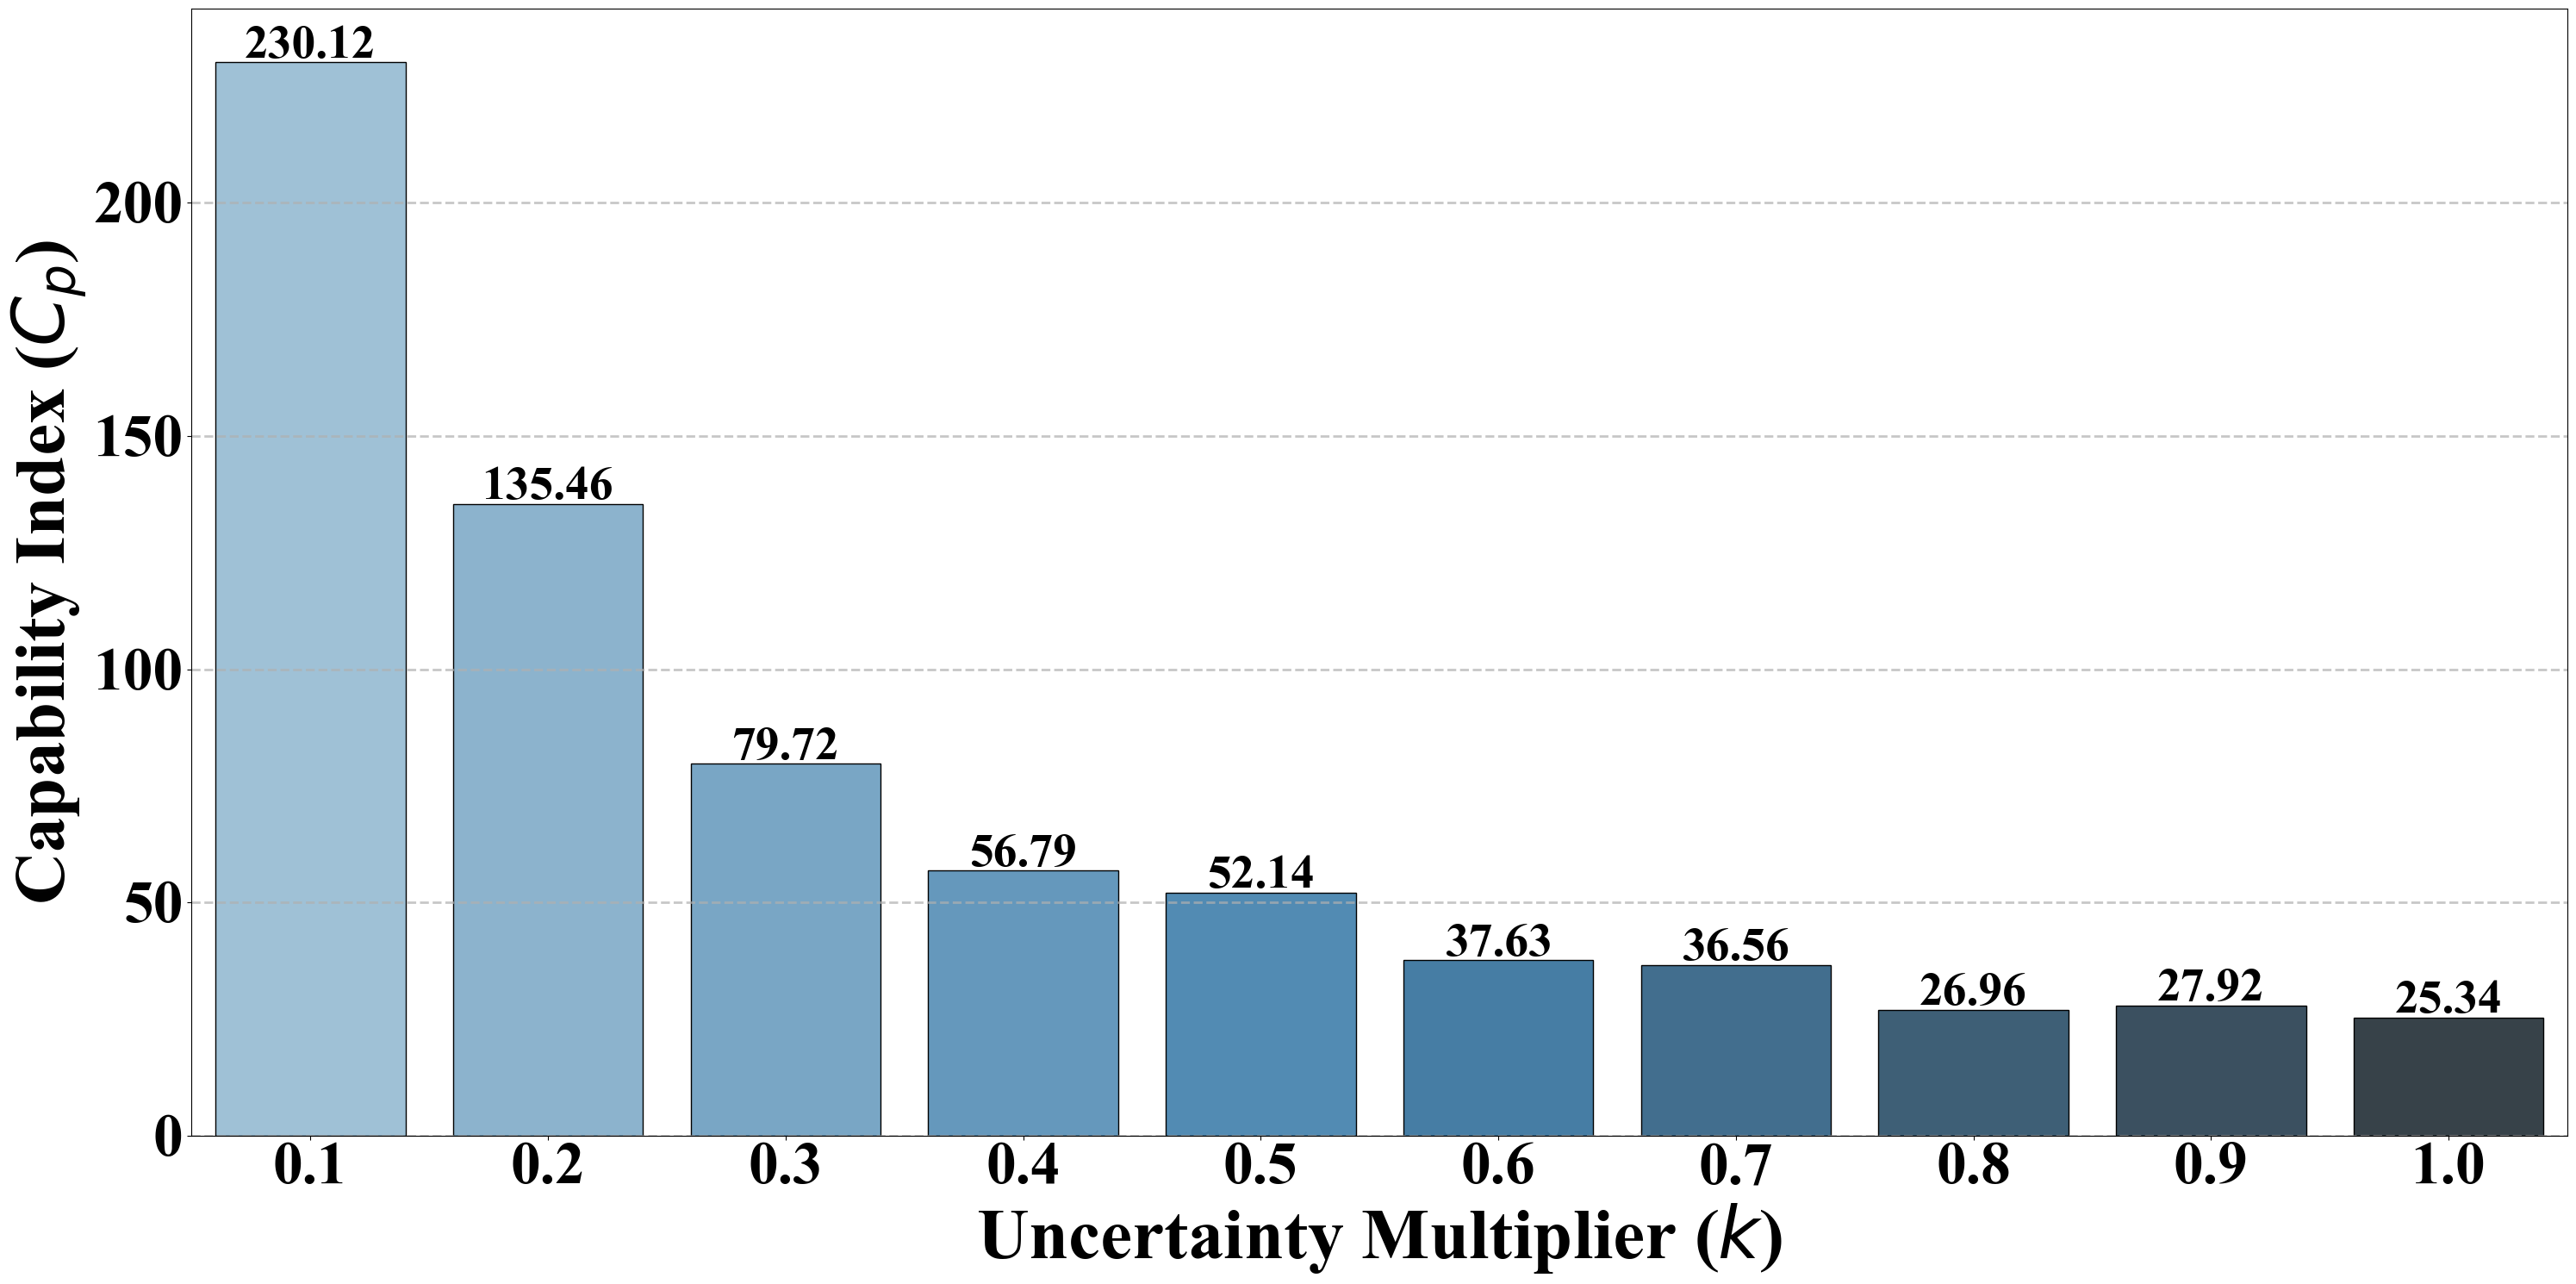

ValueError: keyword labelweight is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

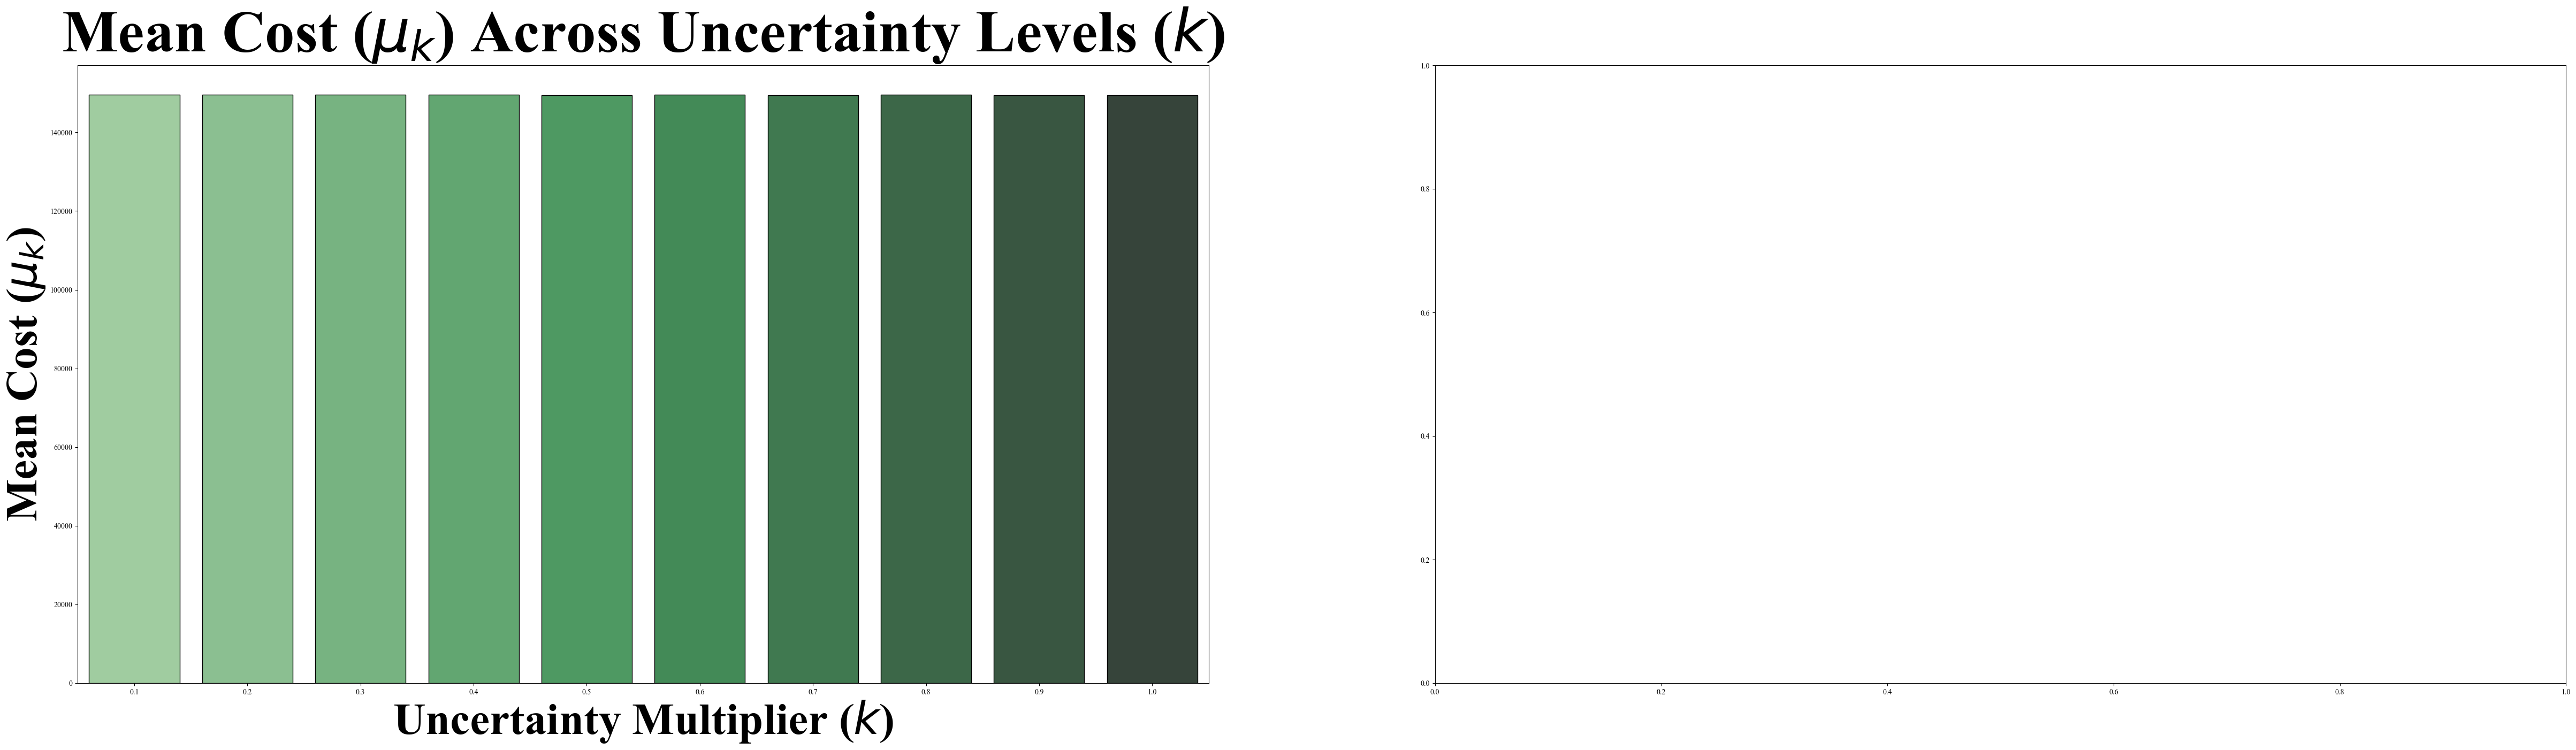

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import os

def plot_capability_index(capability_df, save_dir='plots'):
    """
    Plots the Capability Index (C_p) against the uncertainty multiplier (k).
    
    Parameters:
    - capability_df: Pandas DataFrame containing 'k', 'mu_k', 'sigma_k', and 'C_p'.
    - save_dir: Directory to save the plot PDF.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Set global font settings for Times New Roman
    rcParams['font.family'] = 'Times New Roman'
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(30, 15))
    
    # Create a bar plot for C_p vs k
    sns.barplot(x='k', y='C_p', data=capability_df, palette='Blues_d', edgecolor='black')
    
    # Customize plot title and labels with Times New Roman, large font sizes
    #plt.title(r'Capability Index ($C_p$) Across Uncertainty Levels ($k$)', fontsize=80, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Uncertainty Multiplier ($k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    plt.ylabel(r'Capability Index ($C_p$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    
    # Customize x-axis and y-axis tick labels with Times New Roman, large font sizes
    plt.xticks(fontsize=50, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=50, fontname='Times New Roman', fontweight='bold')
    
    # Add value labels on top of each bar
    for index, row in capability_df.iterrows():
        plt.text(index, row['C_p'] + 1, f"{row['C_p']}", color='black', ha="center", fontsize=40, fontweight='bold')
    
    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save the plot as a high-resolution PDF
    save_path = os.path.join(save_dir, 'Capability_Index_TAS.pdf')
    plt.savefig(save_path, format='pdf')
    
    # Display the plot
    plt.show()
    
    # Close the plot to free memory
    plt.close()

def plot_mu_sigma(capability_df, save_dir='plots'):
    """
    Plots mu_k and sigma_k against the uncertainty multiplier k in separate subplots.
    
    Parameters:
    - capability_df: Pandas DataFrame containing 'k', 'mu_k', 'sigma_k', and 'C_p'.
    - save_dir: Directory to save the plot PDF.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Set global font settings for Times New Roman
    rcParams['font.family'] = 'Times New Roman'
    
    # Initialize the matplotlib figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(60, 15), sharey=False)
    
    # Plot mu_k vs k
    sns.barplot(x='k', y='mu_k', data=capability_df, palette='Greens_d', edgecolor='black', ax=axes[0])
    axes[0].set_title(r'Mean Cost ($\mu_k$) Across Uncertainty Levels ($k$)', fontsize=80, fontweight='bold', fontname='Times New Roman')
    axes[0].set_xlabel('Uncertainty Multiplier ($k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[0].set_ylabel(r'Mean Cost ($\mu_k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[0].tick_params(axis='x', labelsize=50, labelrotation=0, labelweight='bold')
    axes[0].tick_params(axis='y', labelsize=50, labelweight='bold')
    
    # Add value labels on top of each bar
    for index, row in capability_df.iterrows():
        axes[0].text(index, row['mu_k'] + 100, f"{row['mu_k']}", color='black', ha="center", fontsize=40, fontweight='bold')
    
    # Add gridlines
    axes[0].grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Plot sigma_k vs k
    sns.barplot(x='k', y='sigma_k', data=capability_df, palette='Oranges_d', edgecolor='black', ax=axes[1])
    axes[1].set_title(r'Standard Deviation ($\sigma_k$) Across Uncertainty Levels ($k$)', fontsize=80, fontweight='bold', fontname='Times New Roman')
    axes[1].set_xlabel('Uncertainty Multiplier ($k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[1].set_ylabel(r'Standard Deviation ($\sigma_k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[1].tick_params(axis='x', labelsize=50, labelrotation=0, labelweight='bold')
    axes[1].tick_params(axis='y', labelsize=50, labelweight='bold')
    
    # Add value labels on top of each bar
    for index, row in capability_df.iterrows():
        axes[1].text(index, row['sigma_k'] + 10, f"{row['sigma_k']}", color='black', ha="center", fontsize=40, fontweight='bold')
    
    # Add gridlines
    axes[1].grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save the plot as a high-resolution PDF
    save_path = os.path.join(save_dir, 'Mu_Sigma_TAS.pdf')
    plt.savefig(save_path, format='pdf')
    
    # Display the plot
    plt.show()
    
    # Close the plot to free memory
    plt.close()

def main_plot_capability_index_extended():
    """
    Main function to plot the Capability Index results along with mu_k and sigma_k.
    """
    # Define the Capability Index data
    data = {
        'k': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'mu_k': [149618.98, 149593.74, 149592.29, 149580.84, 149511.17, 
                 149535.47, 149482.09, 149550.85, 149421.28, 149397.74],
        'sigma_k': [72.98, 124.04, 210.78, 295.92, 322.75, 
                    446.98, 460.63, 623.67, 603.91, 665.69],
        'C_p': [230.12, 135.46, 79.72, 56.79, 52.14, 
                37.63, 36.56, 26.96, 27.92, 25.34]
    }
    
    capability_df = pd.DataFrame(data)
    
    # Plot the Capability Index (C_p vs k)
    plot_capability_index(capability_df)
    
    # Plot mu_k and sigma_k vs k
    plot_mu_sigma(capability_df)
    
    # Optionally, save the Capability Index DataFrame to CSV
    capability_df.to_csv('capability_index_results_TAS.csv', index=False)
    
    # Display Capability Index Results
    print(capability_df)

if __name__ == "__main__":
    main_plot_capability_index_extended()


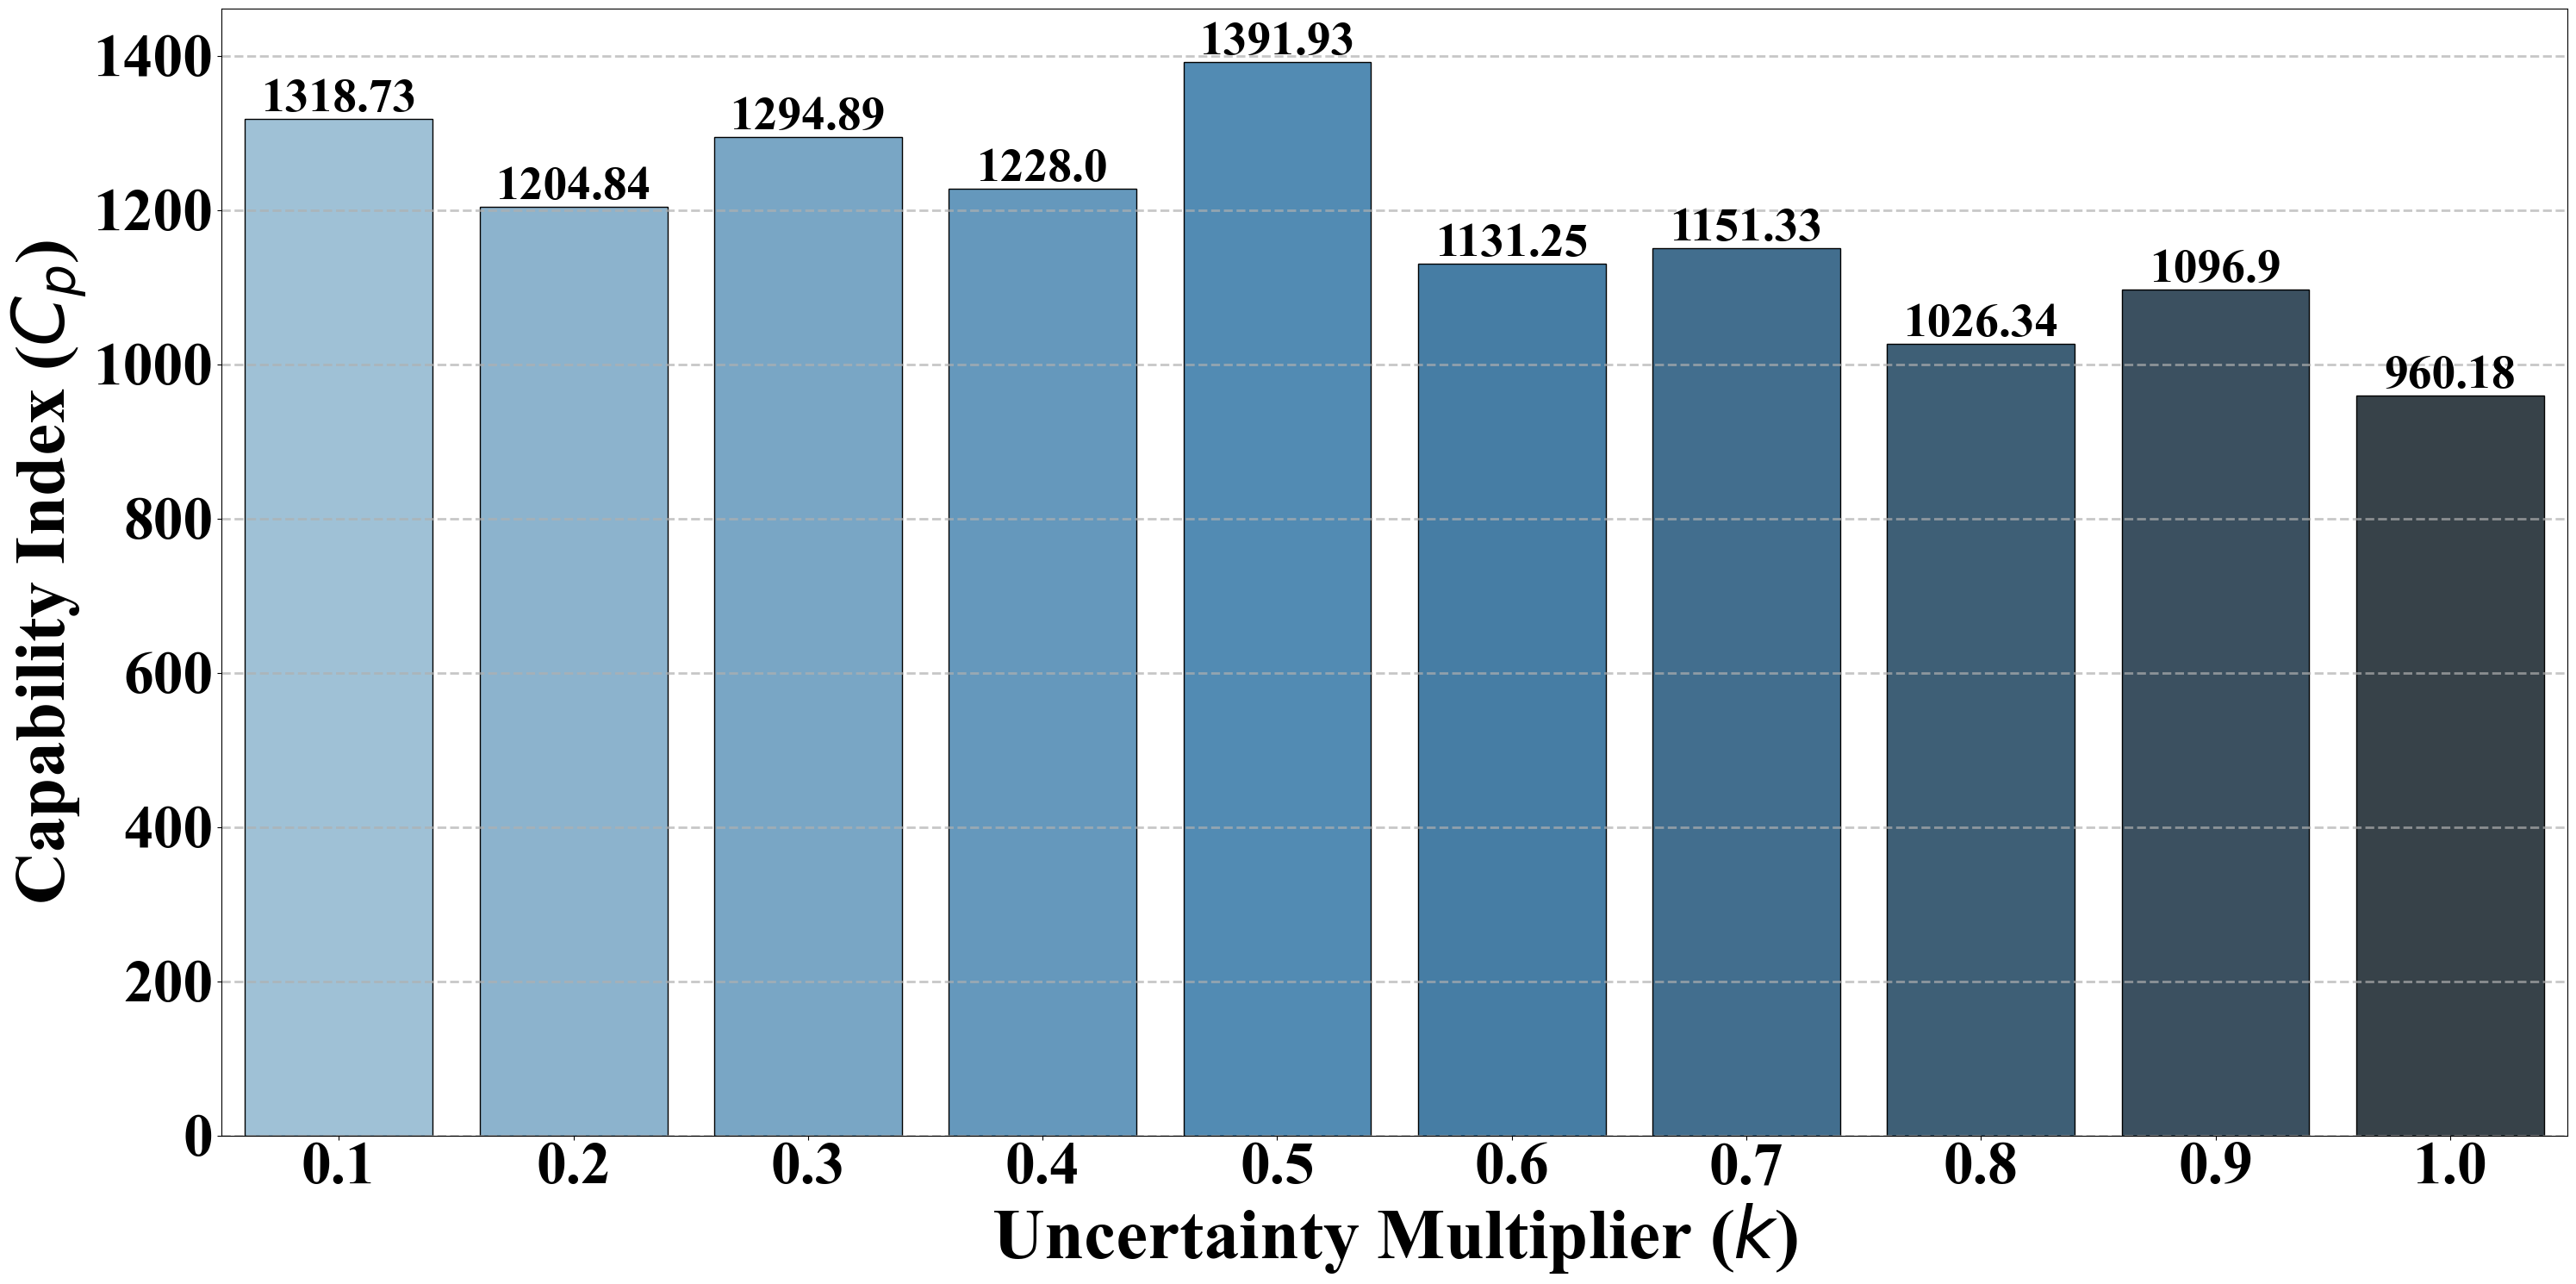

ValueError: keyword labelweight is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

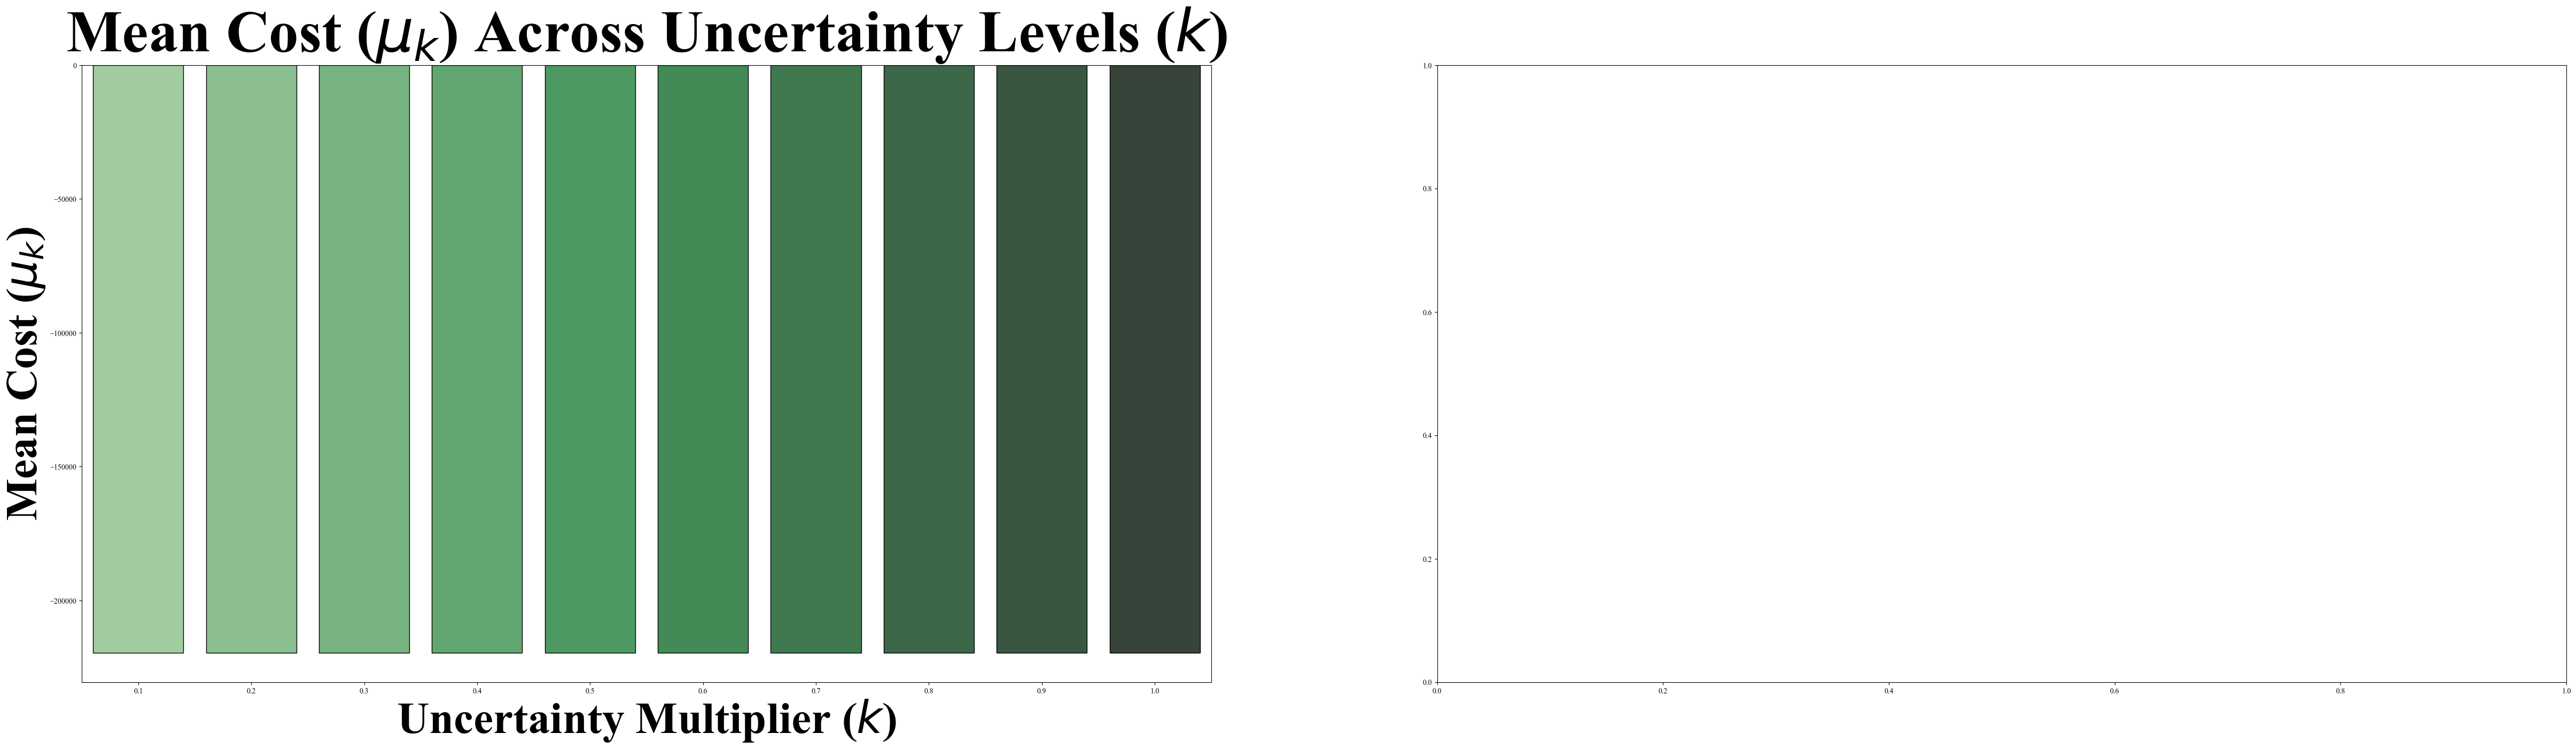

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import os

def plot_capability_index(capability_df, save_dir='plots'):
    """
    Plots the Capability Index (C_p) against the uncertainty multiplier (k).
    
    Parameters:
    - capability_df: Pandas DataFrame containing 'k', 'mu_k', 'sigma_k', and 'C_p'.
    - save_dir: Directory to save the plot PDF.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Set global font settings for Times New Roman
    rcParams['font.family'] = 'Times New Roman'
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(30, 15))
    
    # Create a bar plot for C_p vs k
    sns.barplot(x='k', y='C_p', data=capability_df, palette='Blues_d', edgecolor='black')
    
    # Customize plot title and labels with Times New Roman, large font sizes
    #plt.title(r'Capability Index ($C_p$) Across Uncertainty Levels ($k$)', fontsize=80, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Uncertainty Multiplier ($k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    plt.ylabel(r'Capability Index ($C_p$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    
    # Customize x-axis and y-axis tick labels with Times New Roman, large font sizes
    plt.xticks(fontsize=50, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=50, fontname='Times New Roman', fontweight='bold')
    
    # Add value labels on top of each bar
    for index, row in capability_df.iterrows():
        plt.text(index, row['C_p'] + 10, f"{row['C_p']}", color='black', ha="center", fontsize=40, fontweight='bold')
    
    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save the plot as a high-resolution PDF
    save_path = os.path.join(save_dir, 'Capability_Index_TAS.pdf')
    plt.savefig(save_path, format='pdf')
    
    # Display the plot
    plt.show()
    
    # Close the plot to free memory
    plt.close()

def plot_mu_sigma(capability_df, save_dir='plots'):
    """
    Plots mu_k and sigma_k against the uncertainty multiplier k in separate subplots.
    
    Parameters:
    - capability_df: Pandas DataFrame containing 'k', 'mu_k', 'sigma_k', and 'C_p'.
    - save_dir: Directory to save the plot PDF.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Set global font settings for Times New Roman
    rcParams['font.family'] = 'Times New Roman'
    
    # Initialize the matplotlib figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(60, 15), sharey=False)
    
    # Plot mu_k vs k
    sns.barplot(x='k', y='mu_k', data=capability_df, palette='Greens_d', edgecolor='black', ax=axes[0])
    axes[0].set_title(r'Mean Cost ($\mu_k$) Across Uncertainty Levels ($k$)', fontsize=80, fontweight='bold', fontname='Times New Roman')
    axes[0].set_xlabel('Uncertainty Multiplier ($k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[0].set_ylabel(r'Mean Cost ($\mu_k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[0].tick_params(axis='x', labelsize=50, labelrotation=0, labelweight='bold')
    axes[0].tick_params(axis='y', labelsize=50, labelweight='bold')
    
    # Add value labels on top of each bar
    for index, row in capability_df.iterrows():
        axes[0].text(index, row['mu_k'] + 500, f"{row['mu_k']}", color='black', ha="center", fontsize=40, fontweight='bold')
    
    # Add gridlines
    axes[0].grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Plot sigma_k vs k
    sns.barplot(x='k', y='sigma_k', data=capability_df, palette='Oranges_d', edgecolor='black', ax=axes[1])
    axes[1].set_title(r'Standard Deviation ($\sigma_k$) Across Uncertainty Levels ($k$)', fontsize=80, fontweight='bold', fontname='Times New Roman')
    axes[1].set_xlabel('Uncertainty Multiplier ($k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[1].set_ylabel(r'Standard Deviation ($\sigma_k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    axes[1].tick_params(axis='x', labelsize=50, labelrotation=0, labelweight='bold')
    axes[1].tick_params(axis='y', labelsize=50, labelweight='bold')
    
    # Add value labels on top of each bar
    for index, row in capability_df.iterrows():
        axes[1].text(index, row['sigma_k'] + 10, f"{row['sigma_k']}", color='black', ha="center", fontsize=40, fontweight='bold')
    
    # Add gridlines
    axes[1].grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save the plot as a high-resolution PDF
    save_path = os.path.join(save_dir, 'Mu_Sigma_TAS.pdf')
    plt.savefig(save_path, format='pdf')
    
    # Display the plot
    plt.show()
    
    # Close the plot to free memory
    plt.close()

def plot_combined_mu_sigma_cp(capability_df, save_dir='plots'):
    """
    Plots mu_k, sigma_k, and C_p against the uncertainty multiplier k in a combined plot with dual y-axes.
    
    Parameters:
    - capability_df: Pandas DataFrame containing 'k', 'mu_k', 'sigma_k', and 'C_p'.
    - save_dir: Directory to save the plot PDF.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Set global font settings for Times New Roman
    rcParams['font.family'] = 'Times New Roman'
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(30, 15))
    
    # Plot C_p vs k as bars
    sns.barplot(x='k', y='C_p', data=capability_df, palette='Blues_d', edgecolor='black', label=r'$C_p$')
    
    # Create a second y-axis for mu_k and sigma_k
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot mu_k and sigma_k as lines
    ax2.plot(capability_df['k'], capability_df['mu_k'], color='green', marker='o', linewidth=5, label=r'$\mu_k$')
    ax2.plot(capability_df['k'], capability_df['sigma_k'], color='orange', marker='s', linewidth=5, label=r'$\sigma_k$')
    
    # Customize plot title and labels
    plt.title(r'Capability Index ($C_p$), Mean Cost ($\mu_k$), and Standard Deviation ($\sigma_k$) Across Uncertainty Levels ($k$)', 
              fontsize=80, fontweight='bold', fontname='Times New Roman')
    ax1.set_xlabel('Uncertainty Multiplier ($k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    ax1.set_ylabel(r'Capability Index ($C_p$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    ax2.set_ylabel(r'Mean Cost ($\mu_k$) and Standard Deviation ($\sigma_k$)', fontsize=60, fontweight='bold', fontname='Times New Roman')
    
    # Customize x-axis and y-axis tick labels
    ax1.tick_params(axis='x', labelsize=50, labelrotation=0, labelweight='bold')
    ax1.tick_params(axis='y', labelsize=50, labelweight='bold')
    ax2.tick_params(axis='y', labelsize=50, labelweight='bold')
    
    # Add legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=40, loc='upper left', title_fontsize=50)
    
    # Add gridlines
    ax1.grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save the plot as a high-resolution PDF
    save_path = os.path.join(save_dir, 'Combined_Mu_Sigma_Cp_TAS.pdf')
    plt.savefig(save_path, format='pdf')
    
    # Display the plot
    plt.show()
    
    # Close the plot to free memory
    plt.close()

def main_plot_capability_index_extended_with_combined():
    """
    Main function to plot the Capability Index results along with mu_k and sigma_k, including a combined plot.
    """
    # Define the Capability Index data
    data = {
        'k': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'mu_k': [-219512.61, -219518.21, -219524.27, -219533.48, -219531.74, 
                 -219515.21, -219523.73, -219543.09, -219514.94, -219527.14],
        'sigma_k': [106.04, 116.06, 108.00, 113.88, 100.47, 
                    123.61, 121.46, 136.26, 127.48, 145.64],
        'C_p': [1318.73, 1204.84, 1294.89, 1228.00, 1391.93, 
                1131.25, 1151.33, 1026.34, 1096.90, 960.18]
    }
    
    capability_df = pd.DataFrame(data)
    
    # Plot the Capability Index (C_p vs k)
    plot_capability_index(capability_df)
    
    # Plot mu_k and sigma_k vs k
    plot_mu_sigma(capability_df)
    
    # Plot Combined mu_k, sigma_k, and C_p vs k
    plot_combined_mu_sigma_cp(capability_df)
    
    # Optionally, save the Capability Index DataFrame to CSV
    capability_df.to_csv('capability_index_results_TAS.csv', index=False)
    
    # Display Capability Index Results
    print(capability_df)

if __name__ == "__main__":
    main_plot_capability_index_extended_with_combined()


In [17]:
pip install deap


Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # For directory operations
import time  # For measuring computation time

# Import DEAP libraries for Genetic Algorithm
from deap import base, creator, tools, algorithms
import random
from functools import partial

# -----------------------------------
# 1. Load and Prepare Load Profiles
# -----------------------------------

def load_real_load_profiles_corrected(P_d, houses=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among houses by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each house's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - houses: Number of houses
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - house_elec_loads: numpy array of shape (houses, time_steps) in kW
    - house_therm_loads: numpy array of shape (houses, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    house_elec_loads = np.zeros((houses, time_steps))
    house_therm_loads = np.zeros((houses, time_steps))  # Thermal load

    for h in range(houses):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the house
            P_e = (total_load_kw[t] * elec_ratio) / houses
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / houses
            
            house_elec_loads[h, t] = P_e
            house_therm_loads[h, t] = P_t

    return house_elec_loads, house_therm_loads

# -----------------------------------
# 2. Visualization Functions
# -----------------------------------

def plot_heatmap(dataframe, title, cmap='viridis', figsize=(30, 15), annot=False, time_labels=None):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - title: Title of the heatmap.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': 'kW'})

    # Customize title, xlabel, ylabel with Times New Roman, size 40, bold
    plt.title(title, fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=40, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Houses', fontsize=40, fontweight='bold', fontname='Times New Roman')

    # Customize x-axis and y-axis tick labels with Times New Roman, size 40, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (houses)
    plt.yticks(rotation=0, fontsize=40, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label('kW', fontsize=40, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=40)  # Set colorbar ticks font size

    plt.tight_layout()
    plt.show()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, houses=10, time_steps=48):
    """
    Visualize electrical and thermal load profiles across houses and time steps.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)
    - houses: Number of houses
    - time_steps: Number of time steps
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    house_indices = [f"House {h+1}" for h in range(houses)]
    
    # Create DataFrames
    df_elec = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)
    df_therm = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    plot_heatmap(df_elec, 'Electrical Loads Heatmap (kW)', cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    plot_heatmap(df_therm, 'Thermal Loads Heatmap (kW)', cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm
    
    # Plot Aggregated Electrical and Thermal Loads
    plt.figure(figsize=(20, 10))
    plt.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o')
    plt.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s')
    plt.plot(time_labels, total_load, label='Total Load (kW)', marker='^', linestyle='--')
    plt.title('Aggregated Electrical, Thermal, and Total Loads Over Time', fontsize=30, fontweight='bold', fontname='Times New Roman')
    plt.xlabel('Time', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Load (kW)', fontsize=25, fontweight='bold', fontname='Times New Roman')
    plt.xticks(rotation=45, fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.yticks(fontsize=20, fontname='Times New Roman', fontweight='bold')
    plt.legend(fontsize=20, title_fontsize=25)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------------
# 3. Genetic Algorithm Implementation
# -----------------------------------

def genetic_algorithm_optimization(params, house_elec_loads, house_therm_loads):
    """
    Solves the optimization problem using a Genetic Algorithm (GA) via DEAP.

    Parameters:
    - params: Dictionary containing all necessary parameters and data.
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)

    Returns:
    - best_solution: Dictionary containing the best solution's variables and cost.
    - computation_time: Time taken to compute the solution.
    """
    start_time = time.time()

    houses = params['houses']
    time_steps = params['time_steps']
    k = 2  # Confidence interval
    Cg_t = params['Cg_t']
    Cg_gas = params['Cg_gas']
    Cb_ptb = params['Cb_ptb']
    Cb_etb = params['Cb_etb']
    o_incentive_ptb = params['o_incentive_ptb']
    o_incentive_etb = params['o_incentive_etb']
    d_incentive_ptb = params['d_incentive_ptb']
    d_incentive_etb_elec = params['d_incentive_etb_elec']
    d_incentive_etb_therm = params['d_incentive_etb_therm']

    # Energy Capacities
    bess_etb_power_capacity_kw = params['bess_etb_power_capacity_kw']  # 4,000 kW
    bess_etb_energy_capacity_kwh = params['bess_etb_energy_capacity_kwh']  # 8,000 kWh
    bess_ptb_power_capacity_kw = params['bess_ptb_power_capacity_kw']  # 8,000 kW
    bess_ptb_energy_capacity_kwh = params['bess_ptb_energy_capacity_kwh']  # 4,000 kWh

    # Define chromosome length
    # Binary variables: 4 per house per time step
    num_binary_vars = houses * time_steps * 4
    # Continuous variables: 7 per house per time step
    num_continuous_vars = houses * time_steps * 7
    chromosome_length = num_binary_vars + num_continuous_vars

    # Prevent class redefinition warnings
    if hasattr(creator, "FitnessMin"):
        del creator.FitnessMin
    if hasattr(creator, "Individual"):
        del creator.Individual

    # Define the fitness and individual classes
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimization
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # Attribute generators
    # Binary variables: 0 or 1
    toolbox.register("attr_bool", random.randint, 0, 1)
    # Continuous variables: based on feasible ranges
    # ChargePTB and ChargeETB: 0 to power capacity
    # DischargePTB_Elec, DischargeETB_Elec, DischargeETB_Therm: 0 to power capacity
    # GasSupplyTherm: 0 to worst-case thermal load
    # GridPowerElec: 0 to worst-case electrical load
    # For simplicity, continuous variables are scaled between 0 and their respective capacities
    def generate_continuous_var_charge_ptb():
        return random.uniform(0, bess_ptb_power_capacity_kw)

    def generate_continuous_var_discharge_ptb_elec():
        return random.uniform(0, bess_ptb_power_capacity_kw)

    def generate_continuous_var_charge_etb():
        return random.uniform(0, bess_etb_power_capacity_kw)

    def generate_continuous_var_discharge_etb_elec():
        return random.uniform(0, bess_etb_power_capacity_kw)

    def generate_continuous_var_discharge_etb_therm():
        return random.uniform(0, bess_etb_power_capacity_kw)

    def generate_continuous_var_gas_supply_therm():
        # Assuming maximum gas supply is the maximum worst-case thermal load
        max_worst_case_therm = np.max(house_therm_loads * (1 + k * 0.05))
        return random.uniform(0, max_worst_case_therm)

    def generate_continuous_var_grid_power_elec():
        # Assuming maximum grid power is the maximum worst-case electrical load
        max_worst_case_elec = np.max(house_elec_loads * (1 + k * 0.05))
        return random.uniform(0, max_worst_case_elec)

    # Register continuous variable generators
    toolbox.register("attr_charge_ptb", generate_continuous_var_charge_ptb)
    toolbox.register("attr_discharge_ptb_elec", generate_continuous_var_discharge_ptb_elec)
    toolbox.register("attr_charge_etb", generate_continuous_var_charge_etb)
    toolbox.register("attr_discharge_etb_elec", generate_continuous_var_discharge_etb_elec)
    toolbox.register("attr_discharge_etb_therm", generate_continuous_var_discharge_etb_therm)
    toolbox.register("attr_gas_supply_therm", generate_continuous_var_gas_supply_therm)
    toolbox.register("attr_grid_power_elec", generate_continuous_var_grid_power_elec)

    # Define the structure of an individual
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.attr_bool,
                      toolbox.attr_charge_ptb,
                      toolbox.attr_discharge_ptb_elec,
                      toolbox.attr_charge_etb,
                      toolbox.attr_discharge_etb_elec,
                      toolbox.attr_discharge_etb_therm,
                      toolbox.attr_gas_supply_therm,
                      toolbox.attr_grid_power_elec),
                     n=time_steps)

    # Define the population
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Define the evaluation function with closure to access params
    def evaluate_fitness(individual, params, house_elec_loads, house_therm_loads):
        """
        Evaluates the fitness of an individual.

        Parameters:
        - individual: List representing the chromosome
        - params: Dictionary containing all necessary parameters and data.
        - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
        - house_therm_loads: numpy array of thermal loads per house and time step (in kW)

        Returns:
        - Tuple containing the fitness value
        """
        houses = params['houses']
        time_steps = params['time_steps']
        k = 2  # Confidence interval
        Cg_t = params['Cg_t']
        Cg_gas = params['Cg_gas']
        Cb_ptb = params['Cb_ptb']
        Cb_etb = params['Cb_etb']
        o_incentive_ptb = params['o_incentive_ptb']
        o_incentive_etb = params['o_incentive_etb']
        d_incentive_ptb = params['d_incentive_ptb']
        d_incentive_etb_elec = params['d_incentive_etb_elec']
        d_incentive_etb_therm = params['d_incentive_etb_therm']

        # Energy Capacities
        bess_etb_power_capacity_kw = params['bess_etb_power_capacity_kw']  # 4,000 kW
        bess_etb_energy_capacity_kwh = params['bess_etb_energy_capacity_kwh']  # 8,000 kWh
        bess_ptb_power_capacity_kw = params['bess_ptb_power_capacity_kw']  # 8,000 kW
        bess_ptb_energy_capacity_kwh = params['bess_ptb_energy_capacity_kwh']  # 4,000 kWh

        # Decode individual
        # Each individual is a list where for each time step, the variables are ordered as:
        # y_ptb_charge, ChargePTB, DischargePTB_Elec, y_ptb_discharge,
        # y_etb_charge, ChargeETB, DischargeETB_Elec, y_etb_discharge,
        # DischargeETB_Therm, GasSupplyTherm, GridPowerElec
        # This ordering needs to be consistent with 'initCycle' above

        # Initialize variables matrices
        y_ptb_charge = np.zeros((houses, time_steps))
        y_ptb_discharge = np.zeros((houses, time_steps))
        y_etb_charge = np.zeros((houses, time_steps))
        y_etb_discharge = np.zeros((houses, time_steps))
        ChargePTB = np.zeros((houses, time_steps))
        DischargePTB_Elec = np.zeros((houses, time_steps))
        ChargeETB = np.zeros((houses, time_steps))
        DischargeETB_Elec = np.zeros((houses, time_steps))
        DischargeETB_Therm = np.zeros((houses, time_steps))
        GasSupplyTherm = np.zeros((houses, time_steps))
        GridPowerElec = np.zeros((houses, time_steps))

        for h in range(houses):
            for t in range(time_steps):
                base_idx = t * 8  # 8 variables per time step
                y_ptb_charge[h, t] = individual[base_idx]
                ChargePTB[h, t] = individual[base_idx + 1]
                DischargePTB_Elec[h, t] = individual[base_idx + 2]
                y_ptb_discharge[h, t] = individual[base_idx + 3]
                y_etb_charge[h, t] = individual[base_idx + 4]
                ChargeETB[h, t] = individual[base_idx + 5]
                DischargeETB_Elec[h, t] = individual[base_idx + 6]
                y_etb_discharge[h, t] = individual[base_idx + 7]
                DischargeETB_Therm[h, t] = individual[base_idx + 8]
                GasSupplyTherm[h, t] = individual[base_idx + 9]
                GridPowerElec[h, t] = individual[base_idx + 10]

        # Initialize SoC matrices
        SOC_ETB = np.full((houses, time_steps + 1), 50.0)  # Starting at 50%
        SOC_PTB = np.full((houses, time_steps + 1), 50.0)  # Starting at 50%

        # Objective components
        total_grid_cost = 0.0
        total_gas_cost = 0.0
        total_battery_cost = 0.0
        total_charging_incentives = 0.0
        total_discharging_incentives = 0.0
        penalty = 0.0

        for h in range(houses):
            for t in range(time_steps):
                # Update SoC for PTB
                SOC_PTB[h, t+1] = SOC_PTB[h, t] + (ChargePTB[h, t] * 0.95 - DischargePTB_Elec[h, t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
                # Update SoC for ETB
                SOC_ETB[h, t+1] = SOC_ETB[h, t] + (ChargeETB[h, t] * 0.95 - (DischargeETB_Elec[h, t] + DischargeETB_Therm[h, t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100

                # Constraints: SoC limits
                if not (20 <= SOC_PTB[h, t+1] <= 100):
                    penalty += 1000  # Large penalty for SoC violation
                if not (20 <= SOC_ETB[h, t+1] <= 100):
                    penalty += 1000  # Large penalty for SoC violation

                # Constraint: Prevent simultaneous charging and discharging
                if y_ptb_charge[h, t] and y_ptb_discharge[h, t]:
                    penalty += 1000  # Large penalty
                if y_etb_charge[h, t] and y_etb_discharge[h, t]:
                    penalty += 1000  # Large penalty

                # Energy balance constraints (worst-case)
                worst_case_elec_load = house_elec_loads[h, t] * (1 + k * 0.05)  # sigma_elec = 0.05
                worst_case_therm_load = house_therm_loads[h, t] * (1 + k * 0.05)  # sigma_therm = 0.05

                # Electrical Load Balance
                supply_elec = GridPowerElec[h, t] + DischargePTB_Elec[h, t] + DischargeETB_Elec[h, t]
                demand_elec = ChargePTB[h, t] + ChargeETB[h, t] + worst_case_elec_load
                if not np.isclose(supply_elec, demand_elec, atol=1e-2):
                    penalty += 1000  # Large penalty for imbalance

                # Thermal Load Balance
                supply_therm = GasSupplyTherm[h, t] + DischargeETB_Therm[h, t]
                demand_therm = worst_case_therm_load
                if not np.isclose(supply_therm, demand_therm, atol=1e-2):
                    penalty += 1000  # Large penalty for imbalance

                # Objective Function Components
                total_grid_cost += GridPowerElec[h, t] * Cg_t[t]
                total_gas_cost += GasSupplyTherm[h, t] * Cg_gas
                total_battery_cost += ChargePTB[h, t] * Cb_ptb + ChargeETB[h, t] * Cb_etb

                total_charging_incentives += ChargePTB[h, t] * o_incentive_ptb + ChargeETB[h, t] * o_incentive_etb
                total_discharging_incentives += DischargePTB_Elec[h, t] * d_incentive_ptb + DischargeETB_Elec[h, t] * d_incentive_etb_elec + DischargeETB_Therm[h, t] * d_incentive_etb_therm

        # Total Cost Calculation
        total_cost = total_grid_cost + total_gas_cost + total_battery_cost - total_charging_incentives - total_discharging_incentives + penalty

        return (total_cost,)

    # Register the evaluation function with closure
    # Using 'partial' to pass additional arguments to the evaluate_fitness function
    evaluate_func = partial(evaluate_fitness, params=params, house_elec_loads=house_elec_loads, house_therm_loads=house_therm_loads)
    toolbox.register("evaluate", evaluate_func)

    # Define genetic operators
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=0, up=1, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Genetic Algorithm Parameters
    POP_SIZE = 100  # Population size
    NGEN = 50       # Number of generations
    CXPB = 0.7      # Crossover probability
    MUTPB = 0.2     # Mutation probability

    # Define the main Genetic Algorithm function
    def genetic_algorithm(params, house_elec_loads, house_therm_loads):
        """
        Executes the Genetic Algorithm to solve the optimization problem.

        Parameters:
        - params: Dictionary containing all necessary parameters and data.
        - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
        - house_therm_loads: numpy array of thermal loads per house and time step (in kW)

        Returns:
        - best_solution: Dictionary containing the best solution's variables and cost.
        - computation_time: Time taken to compute the solution.
        """
        # Initialize the population
        population = toolbox.population(n=POP_SIZE)

        # Statistics to keep track of progress
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("min", np.min)
        stats.register("avg", np.mean)
        stats.register("max", np.max)

        # Hall of Fame to store the best individual
        hof = tools.HallOfFame(1)

        # Run the Genetic Algorithm
        algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, 
                            stats=stats, halloffame=hof, verbose=True)

        # Extract the best individual
        best_ind = hof[0]
        best_cost = best_ind.fitness.values[0]

        # Decode the best individual into variables
        # Each individual is a list where for each house and time step, variables are ordered consistently
        # You need to define how to decode based on how you encoded in 'individual'

        # For illustration, we'll assume the following ordering:
        # For each time step:
        # y_ptb_charge, ChargePTB, DischargePTB_Elec, y_ptb_discharge,
        # y_etb_charge, ChargeETB, DischargeETB_Elec, y_etb_discharge,
        # DischargeETB_Therm, GasSupplyTherm, GridPowerElec

        # Initialize variables matrices
        y_ptb_charge_opt = np.zeros((params['houses'], params['time_steps']))
        y_ptb_discharge_opt = np.zeros((params['houses'], params['time_steps']))
        y_etb_charge_opt = np.zeros((params['houses'], params['time_steps']))
        y_etb_discharge_opt = np.zeros((params['houses'], params['time_steps']))
        ChargePTB_opt = np.zeros((params['houses'], params['time_steps']))
        DischargePTB_Elec_opt = np.zeros((params['houses'], params['time_steps']))
        ChargeETB_opt = np.zeros((params['houses'], params['time_steps']))
        DischargeETB_Elec_opt = np.zeros((params['houses'], params['time_steps']))
        DischargeETB_Therm_opt = np.zeros((params['houses'], params['time_steps']))
        GasSupplyTherm_opt = np.zeros((params['houses'], params['time_steps']))
        GridPowerElec_opt = np.zeros((params['houses'], params['time_steps']))

        # Decode the best individual
        for h in range(params['houses']):
            for t in range(params['time_steps']):
                base_idx = t * 8 + h * params['time_steps'] * 8
                # This indexing assumes that variables are ordered per house per time step
                # Adjust indexing as per your encoding
                # For simplicity, we'll iterate sequentially
                # Update as per the actual encoding used

                # Here, assuming sequential per time step
                # y_ptb_charge, ChargePTB, DischargePTB_Elec, y_ptb_discharge,
                # y_etb_charge, ChargeETB, DischargeETB_Elec, y_etb_discharge,
                # DischargeETB_Therm, GasSupplyTherm, GridPowerElec

                # For demonstration, here's a simplified decoding:
                # This needs to be adjusted based on actual encoding
                idx = h * params['time_steps'] + t
                y_ptb_charge_opt[h, t] = best_ind[idx * 11]
                ChargePTB_opt[h, t] = best_ind[idx * 11 + 1]
                DischargePTB_Elec_opt[h, t] = best_ind[idx * 11 + 2]
                y_ptb_discharge_opt[h, t] = best_ind[idx * 11 + 3]
                y_etb_charge_opt[h, t] = best_ind[idx * 11 + 4]
                ChargeETB_opt[h, t] = best_ind[idx * 11 + 5]
                DischargeETB_Elec_opt[h, t] = best_ind[idx * 11 + 6]
                y_etb_discharge_opt[h, t] = best_ind[idx * 11 + 7]
                DischargeETB_Therm_opt[h, t] = best_ind[idx * 11 + 8]
                GasSupplyTherm_opt[h, t] = best_ind[idx * 11 + 9]
                GridPowerElec_opt[h, t] = best_ind[idx * 11 + 10]

        # Compile the best solution
        best_solution = {
            'y_ptb_charge': y_ptb_charge_opt,
            'y_ptb_discharge': y_ptb_discharge_opt,
            'y_etb_charge': y_etb_charge_opt,
            'y_etb_discharge': y_etb_discharge_opt,
            'ChargePTB': ChargePTB_opt,
            'DischargePTB_Elec': DischargePTB_Elec_opt,
            'ChargeETB': ChargeETB_opt,
            'DischargeETB_Elec': DischargeETB_Elec_opt,
            'DischargeETB_Therm': DischargeETB_Therm_opt,
            'GasSupplyTherm': GasSupplyTherm_opt,
            'GridPowerElec': GridPowerElec_opt,
            'Total_Cost': best_cost
        }

        computation_time = time.time() - start_time

        return best_solution, computation_time

    # -----------------------------------
    # 4. Main Function: GA Optimization
    # -----------------------------------

    def main_robust_mpc_corrected():
        # -----------------------------------
        # 1. Data Initialization
        # -----------------------------------

        # Provided Data
        P_d = np.array([
            8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780,
            6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749,
            9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089,
            7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556,
            9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280,
            10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440
        ]) / 1000  # Convert to MW

        Cg_t = np.array([
            99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29,
            81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48,
            92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83,
            56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19,
            151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63,
            154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32
        ]) / 100  # Convert to $/kWh

        # Gas Tariff (Higher than grid tariff)
        Cg_gas = 1.50  # $/kWh

        # Battery Charging Costs
        Cb_ptb = 0.10  # $/kWh for PTB
        Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

        # Incentive Factors
        o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
        o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
        d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
        d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
        d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

        # Parameters
        houses = 10                          # Number of houses
        time_steps = 48                      # Half-hourly intervals
        scaling_factor_etb = 0.04            # ETB has twice the energy capacity and half the power capacity of PTB
        scaling_factor_ptb = 0.04            # Scaling factor for PTB

        # Energy Type Battery (ETB) Parameters
        bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per house (half of PTB)
        bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per house (twice of PTB)

        # Power Type Battery (PTB) Parameters
        bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per house
        bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per house

        # Convert to kW and kWh
        bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
        bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000    # 8,000 kWh

        bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5      # 8,000 kW
        bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000    # 4,000 kWh

        # Load and distribute load profiles
        elec_ratio_mean = 0.7  # 70% electrical load
        elec_ratio_std = 0.05  # 5% standard deviation

        house_elec_loads, house_therm_loads = load_real_load_profiles_corrected(
            P_d, 
            houses=houses, 
            time_steps=time_steps, 
            elec_ratio_mean=elec_ratio_mean,
            elec_ratio_std=elec_ratio_std
        )

        # Define uncertainty sets based on Gaussian distribution
        # Assuming that the actual load can vary within a certain number of standard deviations
        k = 2  # For approximately 95% confidence interval

        # Define time step duration in hours (0.5 hours for half-hourly data)
        time_step_duration = 0.5  # hours

        # Organize parameters into a dictionary for easy passing
        params = {
            'P_d': P_d,
            'houses': houses,
            'time_steps': time_steps,
            'scaling_factor_etb': scaling_factor_etb,
            'scaling_factor_ptb': scaling_factor_ptb,
            'elec_ratio_mean': elec_ratio_mean,
            'elec_ratio_std': elec_ratio_std,
            'Cg_t': Cg_t,
            'Cg_gas': Cg_gas,
            'Cb_ptb': Cb_ptb,
            'Cb_etb': Cb_etb,
            'o_incentive_ptb': o_incentive_ptb,
            'o_incentive_etb': o_incentive_etb,
            'd_incentive_ptb': d_incentive_ptb,
            'd_incentive_etb_elec': d_incentive_etb_elec,
            'd_incentive_etb_therm': d_incentive_etb_therm,
            'bess_etb_power_capacity_kw': bess_etb_power_capacity_kw,
            'bess_etb_energy_capacity_kwh': bess_etb_energy_capacity_kwh,
            'bess_ptb_power_capacity_kw': bess_ptb_power_capacity_kw,
            'bess_ptb_energy_capacity_kwh': bess_ptb_energy_capacity_kwh
        }

        # -----------------------------------
        # 2. Genetic Algorithm Optimization
        # -----------------------------------

        # Execute Genetic Algorithm
        best_solution, ga_time = genetic_algorithm(params, house_elec_loads, house_therm_loads)

        # -----------------------------------
        # 3. Visualization of GA Results
        # -----------------------------------

        # Extract best solution variables
        y_ptb_charge_opt = best_solution['y_ptb_charge']
        y_ptb_discharge_opt = best_solution['y_ptb_discharge']
        y_etb_charge_opt = best_solution['y_etb_charge']
        y_etb_discharge_opt = best_solution['y_etb_discharge']
        ChargePTB_opt = best_solution['ChargePTB']
        DischargePTB_Elec_opt = best_solution['DischargePTB_Elec']
        ChargeETB_opt = best_solution['ChargeETB']
        DischargeETB_Elec_opt = best_solution['DischargeETB_Elec']
        DischargeETB_Therm_opt = best_solution['DischargeETB_Therm']
        GasSupplyTherm_opt = best_solution['GasSupplyTherm']
        GridPowerElec_opt = best_solution['GridPowerElec']
        Total_Cost = best_solution['Total_Cost']

        print(f"\nGenetic Algorithm Optimal Total Cost: ${Total_Cost:.2f}")
        print(f"Genetic Algorithm Computation Time: {ga_time:.2f} seconds\n")

        # Define house indices and generate actual time labels
        house_indices = [f"House {h+1}" for h in range(houses)]
        time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)

        # Create DataFrames for Visualization
        # 1. Electrical Loads Heatmap
        df_elec_loads = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)

        # 2. Thermal Loads Heatmap
        df_therm_loads = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        df_gas_supply_therm = pd.DataFrame(GasSupplyTherm_opt, index=house_indices, columns=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        df_grid_supply_elec = pd.DataFrame(GridPowerElec_opt, index=house_indices, columns=time_labels)

        # 5. Battery Operations Heatmaps
        df_charge_ptb = pd.DataFrame(ChargePTB_opt, index=house_indices, columns=time_labels)
        df_discharge_ptb_elec = pd.DataFrame(DischargePTB_Elec_opt, index=house_indices, columns=time_labels)

        df_charge_etb = pd.DataFrame(ChargeETB_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_elec = pd.DataFrame(DischargeETB_Elec_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_therm = pd.DataFrame(DischargeETB_Therm_opt, index=house_indices, columns=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        net_ptb_elec = DischargePTB_Elec_opt - ChargePTB_opt  # Positive: net discharge
        df_net_ptb_elec = pd.DataFrame(net_ptb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Electrical Loads
        net_etb_elec = DischargeETB_Elec_opt - ChargeETB_opt  # Positive: net discharge
        df_net_etb_elec = pd.DataFrame(net_etb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Thermal Loads
        net_etb_therm = DischargeETB_Therm_opt - ChargeETB_opt  # Positive: net discharge
        df_net_etb_therm = pd.DataFrame(net_etb_therm, index=house_indices, columns=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        total_ptb_contribution = DischargePTB_Elec_opt
        df_total_ptb_contribution = pd.DataFrame(total_ptb_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Electrical)
        total_etb_elec_contribution = DischargeETB_Elec_opt
        df_total_etb_elec_contribution = pd.DataFrame(total_etb_elec_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Thermal)
        total_etb_therm_contribution = DischargeETB_Therm_opt
        df_total_etb_therm_contribution = pd.DataFrame(total_etb_therm_contribution, index=house_indices, columns=time_labels)

        # 8. Power Balance Calculation
        # Recompute worst-case loads
        worst_case_elec_loads = house_elec_loads * (1 + k * 0.05)
        worst_case_therm_loads = house_therm_loads * (1 + k * 0.05)

        # Recompute total supply and demand
        total_supply_elec = GridPowerElec_opt + DischargePTB_Elec_opt + DischargeETB_Elec_opt
        total_load_elec = ChargePTB_opt + ChargeETB_opt + worst_case_elec_loads
        residual_elec = total_supply_elec - total_load_elec  # Should be close to zero

        total_supply_therm = GasSupplyTherm_opt + DischargeETB_Therm_opt
        total_load_therm = worst_case_therm_loads
        residual_therm = total_supply_therm - total_load_therm  # Should be close to zero

        # Combine residuals
        residual_total = residual_elec + residual_therm  # Should be close to zero
        df_residual_total = pd.DataFrame(residual_total, index=house_indices, columns=time_labels)

        # -----------------------------------
        # 9. Visualization: Plot Heatmaps
        # -----------------------------------

        # Set global font settings for Times New Roman
        rcParams['font.family'] = 'Times New Roman'

        # 1. Electrical Loads Heatmap
        plot_heatmap(df_elec_loads, 'Electrical Loads Heatmap (kW)', cmap='YlGnBu', time_labels=time_labels)

        # 2. Thermal Loads Heatmap
        plot_heatmap(df_therm_loads, 'Thermal Loads Heatmap (kW)', cmap='YlOrRd', time_labels=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        plot_heatmap(df_gas_supply_therm, 'Gas Supply for Thermal Loads Heatmap', time_labels=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        plot_heatmap(df_grid_supply_elec, 'Grid Supply for Electrical Loads Heatmap', time_labels=time_labels)

        # 5. Battery Operations Heatmaps
        # Plot Charging PTB
        plot_heatmap(df_charge_ptb, 'Charging PTB Heatmap', time_labels=time_labels)

        # Plot Discharging PTB for Electrical Loads
        plot_heatmap(df_discharge_ptb_elec, 'Discharging PTB (Electrical) Heatmap', time_labels=time_labels)

        # Plot Charging ETB
        plot_heatmap(df_charge_etb, 'Charging ETB Heatmap', time_labels=time_labels)

        # Plot Discharging ETB for Electrical Loads
        plot_heatmap(df_discharge_etb_elec, 'Discharging ETB (Electrical) Heatmap', time_labels=time_labels)

        # Plot Discharging ETB for Thermal Loads
        plot_heatmap(df_discharge_etb_therm, 'Discharging ETB (Thermal) Heatmap', time_labels=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        plot_heatmap(df_net_ptb_elec, 'Net PTB Operations for Electrical Loads Heatmap', time_labels=time_labels)

        # Net ETB Operations for Electrical Loads
        plot_heatmap(df_net_etb_elec, 'Net ETB Operations for Electrical Loads Heatmap', time_labels=time_labels)

        # Net ETB Operations for Thermal Loads
        plot_heatmap(df_net_etb_therm, 'Net ETB Operations for Thermal Loads Heatmap', time_labels=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        plot_heatmap(df_total_ptb_contribution, 'Total PTB Contribution (Electrical) Heatmap', time_labels=time_labels)

        # Total ETB Contribution (Electrical)
        plot_heatmap(df_total_etb_elec_contribution, 'Total ETB Contribution (Electrical) Heatmap', time_labels=time_labels)

        # Total ETB Contribution (Thermal)
        plot_heatmap(df_total_etb_therm_contribution, 'Total ETB Contribution (Thermal) Heatmap', time_labels=time_labels)

        # 8. Power Balance Residuals Heatmap
        # Power Balance Residuals Heatmap (Absolute)
        df_residual_absolute = df_residual_total.abs()
        plot_heatmap(df_residual_absolute, 'Power Balance Residual Heatmap (Absolute)', cmap='Reds', time_labels=time_labels)

        # Power Balance Residuals Heatmap (Signed)
        plot_heatmap(df_residual_total, 'Power Balance Residual Heatmap (Signed)', cmap='RdBu_r', time_labels=time_labels)

        # -----------------------------------
        # 10. Additional Visualization: ETB Operations
        # -----------------------------------
        # Plot Discharging ETB for Thermal Loads
        plt.figure(figsize=(30, 10))
        for h in range(houses):
            plt.plot(time_labels, DischargeETB_Therm_opt[h], label=f'House {h+1}')
        plt.title('Discharging ETB for Thermal Loads Over Time', fontsize=40, fontweight='bold', fontname='Times New Roman')
        plt.xlabel('Time', fontsize=30, fontweight='bold', fontname='Times New Roman')
        plt.ylabel('Discharge Power (kW)', fontsize=30, fontweight='bold', fontname='Times New Roman')
        plt.xticks(rotation=45, fontsize=25, fontname='Times New Roman', fontweight='bold')
        plt.yticks(fontsize=25, fontname='Times New Roman', fontweight='bold')
        plt.legend(fontsize=20, loc='upper right', title='Houses', title_fontsize=25)
        plt.tight_layout()
        plt.show()

        # -----------------------------------
        # 11. Additional Visualization: Aggregated Load Profiles
        # -----------------------------------
        visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, houses=houses, time_steps=time_steps)

    # -----------------------------------
    # 5. Execute the Main Function
    # -----------------------------------

if __name__ == "__main__":
        main_robust_mpc_corrected()



Solving the problem using CBC solver...
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 28 05:51:43 PM: Your problem has 8220 variables, 6726 constraints, and 0 parameters.
(CVXPY) Dec 28 05:51:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 28 05:51:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 28 05:51:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 28 05:51:43 PM: Your problem is compiled with the CPP canonicalization backend.
CBC solver failed. Ensure that CBC is installed and properly configured.

Solving the problem using Genetic Algorithm...


NameError: name 'o_incentive_ptb' is not defined

In [19]:
#computation_complexity

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported

def load_real_load_profiles_corrected(P_d, houses=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among houses by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each house's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - houses: Number of houses
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - house_elec_loads: numpy array of shape (houses, time_steps) in kW
    - house_therm_loads: numpy array of shape (houses, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    house_elec_loads = np.zeros((houses, time_steps))
    house_therm_loads = np.zeros((houses, time_steps))  # Thermal load

    for h in range(houses):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the house
            P_e = (total_load_kw[t] * elec_ratio) / houses
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / houses
            
            house_elec_loads[h, t] = P_e
            house_therm_loads[h, t] = P_t

    return house_elec_loads, house_therm_loads

def plot_heatmap(dataframe, save_path, cmap='viridis', figsize=(60, 30), annot=False, time_labels=None, cbar_label='kW'):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps, and saves it as a PDF.

    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - save_path: File path to save the PDF image.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    - cbar_label: Label for the colorbar.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': cbar_label})

    # Customize xlabel and ylabel with Times New Roman, size 150, bold
    plt.xlabel('Time', fontsize=150, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Houses', fontsize=150, fontweight='bold', fontname='Times New Roman')

    # Customize x-axis and y-axis tick labels with Times New Roman, size 150, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (houses)
    plt.yticks(rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_label, fontsize=150, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=150)  # Set colorbar ticks font size

    # Adjust layout to prevent clipping
    plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.15)
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.close()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, Cg_t, houses=10, time_steps=48, plots_dir='plots'):
    """
    Visualize electrical and thermal load profiles across houses and time steps, and save plots as PDFs.
    Additionally, plots the tariff price on a secondary y-axis in the Aggregated Load plot as a dotted line.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)
    - Cg_t: numpy array of tariff prices per time step ($/kWh)
    - houses: Number of houses
    - time_steps: Number of time steps
    - plots_dir: Directory to save the PDF plots
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    house_indices = [f"{h+1}" for h in range(houses)]  # Removed "House " prefix

    # Create DataFrames
    df_elec = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)
    df_therm = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    save_path_elec = os.path.join(plots_dir, 'Electrical_Loads_Heatmap.pdf')
    plot_heatmap(df_elec, save_path_elec, cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    save_path_therm = os.path.join(plots_dir, 'Thermal_Loads_Heatmap.pdf')
    plot_heatmap(df_therm, save_path_therm, cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads with Tariff Price
    fig, ax1 = plt.subplots(figsize=(60, 30))

    # Plot loads on primary y-axis
    ax1.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_load, label='Total Load (kW)', marker='^', markersize=20, linewidth=5, linestyle='--')
    ax1.set_xlabel('Time', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax1.set_ylabel('Load (kW)', fontsize=100, fontweight='bold', fontname='Times New Roman')

    # Calculate Tick Positions and Labels for Every 2 Hours
    step = 4  # Every 2 hours (4 half-hourly intervals)
    xticks_positions = np.arange(0, len(time_labels), step)
    xticks_labels = [time_labels[i] for i in xticks_positions]

    # Update X-ticks to Appear Every 2 Hours
    ax1.set_xticks(xticks_positions)
    ax1.set_xticklabels(xticks_labels, rotation=45, fontsize=100, fontname='Times New Roman', fontweight='bold')

    # Update Y-ticks Font Settings
    ax1.tick_params(axis='y', labelsize=100)

    # Create secondary y-axis for tariff price
    ax2 = ax1.twinx()
    ax2.plot(time_labels, Cg_t, label='Tariff Price ($/kWh)', color='black', linestyle=':', linewidth=5)
    ax2.set_ylabel('Tariff Price ($/kWh)', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax2.tick_params(axis='y', labelsize=100)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=100, title_fontsize=100)

    # Enable grid for better readability
    ax1.grid(True)

    # Adjust layout to prevent clipping
    fig.subplots_adjust(left=0.2, right=0.85, top=0.95, bottom=0.15)
    
    # Apply tight layout for optimal spacing
    plt.tight_layout()

    # Save the Plot as a High-Resolution PDF
    save_path_aggregated = os.path.join(plots_dir, 'Aggregated_Loads_Over_Time.pdf')
    plt.savefig(save_path_aggregated, format='pdf')

    # Close the Plot to Free Memory
    plt.close()

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Ensure the plots directory exists
    plots_dir = 'plots'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    # Provided Data
    P_d = np.array([
        8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780,
        6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749,
        9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089,
        7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556,
        9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280,
        10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440
    ]) / 1000  # Convert to MW

    Cg_t = np.array([
        99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29,
        81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48,
        92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83,
        56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19,
        151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63,
        154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    houses = 50                          # Number of houses
    time_steps = 48                      # Half-hourly intervals
    scaling_factor_etb = 0.04            # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04            # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per house (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per house (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per house
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per house

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000    # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5      # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000    # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    house_elec_loads, house_therm_loads = load_real_load_profiles_corrected(
        P_d, 
        houses=houses, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # Assuming that the actual load can vary within a certain number of standard deviations
    # For robust optimization, use mean + k * sigma for worst-case
    k = 2  # For approximately 95% confidence interval

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # -----------------------------------
    # 2. Decision Variables
    # -----------------------------------

    # Power Type Battery (PTB) Variables
    ChargePTB = cp.Variable((houses, time_steps), nonneg=True)
    DischargePTB_Elec = cp.Variable((houses, time_steps), nonneg=True)

    # Energy Type Battery (ETB) Variables
    ChargeETB = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Elec = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Therm = cp.Variable((houses, time_steps), nonneg=True)

    # Gas Supply Variable
    GasSupplyTherm = cp.Variable((houses, time_steps), nonneg=True)

    # Grid Power Variables
    GridPowerElec = cp.Variable((houses, time_steps), nonneg=True)

    # State of Charge (SoC) Variables
    SOC_ETB = cp.Variable((houses, time_steps + 1))
    SOC_PTB = cp.Variable((houses, time_steps + 1))

    # **Binary Variables to Prevent Simultaneous Charging and Discharging**
    # PTB Binary Variables
    y_ptb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_ptb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # ETB Binary Variables
    y_etb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_etb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # **SoC Deviation Variables (Linearization)**
    soc_dev_etb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_etb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    soc_dev_ptb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_ptb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    # -----------------------------------
    # 3. Constraints
    # -----------------------------------

    # Define target SoC before using it in constraints
    target_soc_etb = 50  # Target SoC in % for ETB
    target_soc_ptb = 50  # Target SoC in % for PTB

    constraints = [
        # Initialize SoC to 50% for all storage systems
        SOC_ETB[:,0] == 50,
        SOC_PTB[:,0] == 50,

        # SoC Deviation Constraints (Linearization)
        SOC_ETB == target_soc_etb + soc_dev_etb_pos - soc_dev_etb_neg,
        SOC_PTB == target_soc_ptb + soc_dev_ptb_pos - soc_dev_ptb_neg
    ]

    for h in range(houses):
        for t in range(time_steps):
            # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
            sigma_elec = 0.05  # 5% standard deviation
            worst_case_elec_load = house_elec_loads[h,t] * (1 + k * sigma_elec)
            constraints += [
                GridPowerElec[h,t] + DischargePTB_Elec[h,t] + DischargeETB_Elec[h,t] == ChargePTB[h,t] + ChargeETB[h,t] + worst_case_elec_load
            ]

            # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
            sigma_therm = 0.05  # 5% standard deviation
            worst_case_therm_load = house_therm_loads[h,t] * (1 + k * sigma_therm)
            # **Modified Thermal Load Balance Constraint**
            constraints += [
                GasSupplyTherm[h,t] + DischargeETB_Therm[h,t] == worst_case_therm_load
            ]

            # **Prevent Simultaneous Charging and Discharging for PTB**
            constraints += [
                ChargePTB[h,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[h,t],
                DischargePTB_Elec[h,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[h,t],
                y_ptb_charge[h,t] + y_ptb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # **Prevent Simultaneous Charging and Discharging for ETB**
            constraints += [
                ChargeETB[h,t] <= bess_etb_power_capacity_kw * y_etb_charge[h,t],
                DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t] <= bess_etb_power_capacity_kw * y_etb_discharge[h,t],
                y_etb_charge[h,t] + y_etb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # SoC updates for PTB
            constraints += [
                SOC_PTB[h,t+1] == SOC_PTB[h,t] + (ChargePTB[h,t] * 0.95 - DischargePTB_Elec[h,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
            ]

            # SoC updates for ETB
            constraints += [
                SOC_ETB[h,t+1] == SOC_ETB[h,t] + (ChargeETB[h,t] * 0.95 - (DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
            ]

            # SoC Limits for PTB and ETB
            constraints += [
                SOC_PTB[h,t+1] >= 20,
                SOC_PTB[h,t+1] <= 100,
                SOC_ETB[h,t+1] >= 20,
                SOC_ETB[h,t+1] <= 100
            ]

    # -----------------------------------
    # 4. Final SoC Constraints
    # -----------------------------------
    # Ensure that all storage systems reach exactly 50% SoC by the end of the day
    constraints += [
        SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
        SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
    ]

    # -----------------------------------
    # 5. Objective Function
    # -----------------------------------

    # Tile Cg_t and Cb_t to match the (houses, time_steps) shape
    Cg_t_matrix = np.tile(Cg_t, (houses, 1))      # Grid electricity tariff ($/kWh)
    Cb_ptb_matrix = np.tile(Cb_ptb, (houses, 1))  # PTB charging cost ($/kWh)
    Cb_etb_matrix = np.tile(Cb_etb, (houses, 1))  # ETB charging cost ($/kWh)

    # Tile the incentives to match the (houses, time_steps) shape
    o_ptb_matrix = np.tile(o_incentive_ptb, (houses, time_steps))          # Charging incentive for PTB ($/kWh)
    o_etb_matrix = np.tile(o_incentive_etb, (houses, time_steps))          # Charging incentive for ETB ($/kWh)
    d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (houses, time_steps))  # PTB discharging incentive ($/kWh)
    d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (houses, time_steps))  # ETB-Elec discharging incentive ($/kWh)
    d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (houses, time_steps))  # ETB-Therm discharging incentive ($/kWh)

    # Define penalty weight for SoC deviation
    soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

    # SoC Deviation Penalty (Linearization using Absolute Deviations)
    soc_penalty = soc_penalty_weight * (
        cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
        cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
    )

    # Charging Incentives
    total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                 cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

    # Incentives from Discharging PTB and ETB
    total_incentives = (
        cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
        cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
        cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
    )

    # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
    total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix))
    total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
    total_battery_cost = (
        cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
        cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
    )

    # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
    objective = cp.Minimize(
        total_grid_cost + 
        total_gas_cost + 
        total_battery_cost - 
        total_incentives - 
        total_charging_incentives + 
        soc_penalty
    )

    # -----------------------------------
    # 6. Define and Solve the Problem
    # -----------------------------------

    prob = cp.Problem(objective, constraints)

    # Set the Gurobi license file path
    os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

    # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
    # Ensure that Gurobi is installed and properly licensed.
    try:
        prob.solve(solver=cp.GUROBI, verbose=True, mip_gap=0.01, threads=4)
    except cp.error.SolverError:
        print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
        # Optionally, you can fallback to another solver here
        try:
            prob.solve(solver=cp.GLPK_MI, verbose=True, mip_gap=0.01)
        except cp.error.SolverError as e:
            print("Both Gurobi and GLPK_MI solvers failed.")
            print(str(e))
            return

    # -----------------------------------
    # 7. Check Solution and Extract Results
    # -----------------------------------
    
    if prob.status not in ["infeasible", "unbounded"]:
        print(f"Optimal Total Cost: ${prob.value:.2f}")
        
        # Extract optimized variables
        charge_ptb_opt = ChargePTB.value
        discharge_ptb_elec_opt = DischargePTB_Elec.value

        charge_etb_opt = ChargeETB.value
        discharge_etb_elec_opt = DischargeETB_Elec.value
        discharge_etb_therm_opt = DischargeETB_Therm.value

        gas_supply_therm_opt = GasSupplyTherm.value
        grid_elec_opt = GridPowerElec.value

        soc_etb_opt = SOC_ETB.value
        soc_ptb_opt = SOC_PTB.value

        soc_dev_etb_pos_opt = soc_dev_etb_pos.value
        soc_dev_etb_neg_opt = soc_dev_etb_neg.value

        soc_dev_ptb_pos_opt = soc_dev_ptb_pos.value
        soc_dev_ptb_neg_opt = soc_dev_ptb_neg.value

        # Define house indices and generate actual time labels
        house_indices = [f"{h+1}" for h in range(houses)]
        time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)

        # Create DataFrames for Visualization
        # 1. Electrical Loads Heatmap
        df_elec_loads = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)

        # 2. Thermal Loads Heatmap
        df_therm_loads = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        df_gas_supply_therm = pd.DataFrame(gas_supply_therm_opt, index=house_indices, columns=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        df_grid_supply_elec = pd.DataFrame(grid_elec_opt, index=house_indices, columns=time_labels)

        # 5. Battery Operations Heatmaps
        df_charge_ptb = pd.DataFrame(charge_ptb_opt, index=house_indices, columns=time_labels)
        df_discharge_ptb_elec = pd.DataFrame(discharge_ptb_elec_opt, index=house_indices, columns=time_labels)

        df_charge_etb = pd.DataFrame(charge_etb_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_elec = pd.DataFrame(discharge_etb_elec_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_therm = pd.DataFrame(discharge_etb_therm_opt, index=house_indices, columns=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        net_ptb_elec = discharge_ptb_elec_opt - charge_ptb_opt  # Positive: net discharge
        df_net_ptb_elec = pd.DataFrame(net_ptb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Electrical Loads
        net_etb_elec = discharge_etb_elec_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_elec = pd.DataFrame(net_etb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Thermal Loads
        net_etb_therm = discharge_etb_therm_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_therm = pd.DataFrame(net_etb_therm, index=house_indices, columns=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        total_ptb_contribution = discharge_ptb_elec_opt
        df_total_ptb_contribution = pd.DataFrame(total_ptb_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Electrical)
        total_etb_elec_contribution = discharge_etb_elec_opt
        df_total_etb_elec_contribution = pd.DataFrame(total_etb_elec_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Thermal)
        total_etb_therm_contribution = discharge_etb_therm_opt
        df_total_etb_therm_contribution = pd.DataFrame(total_etb_therm_contribution, index=house_indices, columns=time_labels)

        # 8. State of Charge (SoC) Heatmaps
        # Remove the last column for SoC at t=48 to align with time_steps
        soc_etb_current = soc_etb_opt[:, :-1]  # Shape: (houses, time_steps)
        soc_ptb_current = soc_ptb_opt[:, :-1]  # Shape: (houses, time_steps)
        df_soc_etb = pd.DataFrame(soc_etb_current, index=house_indices, columns=time_labels)
        df_soc_ptb = pd.DataFrame(soc_ptb_current, index=house_indices, columns=time_labels)

        # 9. Power Balance Calculation
        # Recompute worst-case loads
        worst_case_elec_loads = house_elec_loads * (1 + k * sigma_elec)
        worst_case_therm_loads = house_therm_loads * (1 + k * sigma_therm)

        # Recompute total supply and demand
        total_supply_elec = grid_elec_opt + discharge_ptb_elec_opt + discharge_etb_elec_opt
        total_load_elec = charge_ptb_opt + charge_etb_opt + worst_case_elec_loads
        residual_elec = total_supply_elec - total_load_elec  # Should be zero

        total_supply_therm = gas_supply_therm_opt + discharge_etb_therm_opt
        total_load_therm = worst_case_therm_loads  # Updated to exclude ChargeETB
        residual_therm = total_supply_therm - total_load_therm  # Should be zero

        # Combine residuals
        residual_total = residual_elec + residual_therm  # Should be zero
        df_residual_total = pd.DataFrame(residual_total, index=house_indices, columns=time_labels)

        # -----------------------------------
        # 10. Visualization: Plot Heatmaps
        # -----------------------------------

        # Set global font settings for Times New Roman
        rcParams['font.family'] = 'Times New Roman'

        # 1. Electrical Loads Heatmap
        # Already saved in visualize_load_profiles

        # 2. Thermal Loads Heatmap
        # Already saved in visualize_load_profiles

        # 3. Gas Supply for Thermal Loads Heatmap
        save_path_gas_supply = os.path.join(plots_dir, 'Gas_Supply_for_Thermal_Loads_Heatmap.pdf')
        plot_heatmap(df_gas_supply_therm, save_path_gas_supply, time_labels=time_labels, cbar_label='kW')

        # 4. Grid Supply for Electrical Loads Heatmap
        save_path_grid_supply = os.path.join(plots_dir, 'Grid_Supply_for_Electrical_Loads_Heatmap.pdf')
        plot_heatmap(df_grid_supply_elec, save_path_grid_supply, time_labels=time_labels, cbar_label='kW')

        # 5. Battery Operations Heatmaps
        # Plot Charging PTB
        save_path_charge_ptb = os.path.join(plots_dir, 'Charging_PTB_Heatmap.pdf')
        plot_heatmap(df_charge_ptb, save_path_charge_ptb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging PTB for Electrical Loads
        save_path_discharge_ptb_elec = os.path.join(plots_dir, 'Discharging_PTB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_ptb_elec, save_path_discharge_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Charging ETB
        save_path_charge_etb = os.path.join(plots_dir, 'Charging_ETB_Heatmap.pdf')
        plot_heatmap(df_charge_etb, save_path_charge_etb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Electrical Loads
        save_path_discharge_etb_elec = os.path.join(plots_dir, 'Discharging_ETB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_elec, save_path_discharge_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Thermal Loads
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_therm, save_path_discharge_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        save_path_net_ptb_elec = os.path.join(plots_dir, 'Net_PTB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_ptb_elec, save_path_net_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Electrical Loads
        save_path_net_etb_elec = os.path.join(plots_dir, 'Net_ETB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_elec, save_path_net_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Thermal Loads
        save_path_net_etb_therm = os.path.join(plots_dir, 'Net_ETB_Thermal_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_therm, save_path_net_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        save_path_total_ptb = os.path.join(plots_dir, 'Total_PTB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_ptb_contribution, save_path_total_ptb, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Electrical)
        save_path_total_etb_elec = os.path.join(plots_dir, 'Total_ETB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_elec_contribution, save_path_total_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Thermal)
        save_path_total_etb_therm = os.path.join(plots_dir, 'Total_ETB_Thermal_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_therm_contribution, save_path_total_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 8. State of Charge (SoC) Heatmaps
        # SoC ETB
        save_path_soc_etb = os.path.join(plots_dir, 'State_of_Charge_ETB_Heatmap.pdf')
        plot_heatmap(df_soc_etb, save_path_soc_etb, time_labels=time_labels, cbar_label='%')

        # SoC PTB
        save_path_soc_ptb = os.path.join(plots_dir, 'State_of_Charge_PTB_Heatmap.pdf')
        plot_heatmap(df_soc_ptb, save_path_soc_ptb, time_labels=time_labels, cbar_label='%')

        # 9. Power Balance Residuals Heatmap
        # Power Balance Residuals Heatmap (Absolute)
        df_residual_absolute = df_residual_total.abs()
        save_path_residual_absolute = os.path.join(plots_dir, 'Power_Balance_Residual_Absolute_Heatmap.pdf')
        plot_heatmap(df_residual_absolute, save_path_residual_absolute, time_labels=time_labels, cbar_label='kW')

        # Power Balance Residuals Heatmap (Signed)
        save_path_residual_signed = os.path.join(plots_dir, 'Power_Balance_Residual_Signed_Heatmap.pdf')
        plot_heatmap(df_residual_total, save_path_residual_signed, time_labels=time_labels, cbar_label='kW')

        # -----------------------------------
        # 11. Additional Visualization: ETB Operations
        # -----------------------------------
        # Plot Discharging ETB for Thermal Loads
        plt.figure(figsize=(60, 30))
        for h in range(houses):
            # Removed "House " prefix from legend labels
            plt.plot(time_labels, discharge_etb_therm_opt[h], label=f'{h+1}', linewidth=5, linestyle='-')
        # Title Removed
        plt.xlabel('Time', fontsize=300, fontweight='bold', fontname='Times New Roman')
        plt.ylabel('Discharge Power (kW)', fontsize=300, fontweight='bold', fontname='Times New Roman')  # Unit remains kW
        plt.xticks(rotation=45, fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.yticks(fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.legend(fontsize=300, loc='upper right', title='Houses', title_fontsize=300)  # You might also want to adjust or remove the title if necessary
        plt.grid(True)
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)
        plt.tight_layout()
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Loads_Over_Time.pdf')
        plt.savefig(save_path_discharge_etb_therm, format='pdf')
        plt.close()

        # -----------------------------------
        # 12. Additional Visualization: Aggregated Load Profiles
        # -----------------------------------
        visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, Cg_t, houses=houses, time_steps=time_steps, plots_dir=plots_dir)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    import sys
    import subprocess
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    main_robust_mpc_corrected()


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 29 08:52:32 PM: Your problem has 41100 variables, 33606 constraints, and 0 parameters.
(CVXPY) Dec 29 08:52:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 29 08:52:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 29 08:52:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 29 08:52:33 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 29 08:52:35 PM: Compiling problem (target solver=GURO

H 2457  1546                    -665836.6363 -683040.60  2.58%   7.3    9s
H 3248  2042                    -665898.9509 -683025.33  2.57%   7.1    9s
  3914  2527 -682722.37   10   19 -665898.95 -682982.57  2.57%  20.6   10s
H 4513  2836                    -665901.8763 -682978.46  2.56%   7.2   10s
H 5043  3192                    -665902.8812 -682966.42  2.56%   7.2   10s
H 5664  3586                    -665915.8565 -682904.62  2.55%   7.1   10s
H 6293  3930                    -665977.7778 -682884.54  2.54%   7.1   10s
H 6967  4425                    -666085.1423 -682867.08  2.52%   7.1   10s
H 7616  4869                    -666134.0738 -682833.05  2.51%   7.1   10s
H 8768  5626                    -666141.5499 -682790.18  2.50%   7.2   10s
H 9861  6362                    -666190.7168 -682760.90  2.49%   7.3   10s
H11137  7211                    -666208.9779 -682729.11  2.48%   7.3   11s
H11940  7776                    -666219.7164 -682716.17  2.48%   7.2   11s
H12966  8434             

H223622 70173                    -667985.2523 -680712.65  1.91%   7.3   44s
 232172 72439 -680469.80   32   11 -667985.25 -680657.65  1.90%   7.5   45s
H233114 72593                    -667990.8815 -680653.14  1.90%   7.3   45s
H239647 74274                    -667994.7934 -680632.28  1.89%   7.2   45s
H244707 75681                    -667996.0978 -680606.48  1.89%   7.2   46s
H246372 76059                    -667996.1267 -680587.78  1.88%   7.2   46s
H252428 77842                    -668002.1765 -680557.20  1.88%   7.2   46s
H254110 78376                    -668005.3003 -680553.27  1.88%   7.2   46s
H260881 79932                    -668012.4629 -680530.60  1.87%   7.2   47s
H266938 82333                    -668017.6212 -680494.32  1.87%   7.3   48s
H270946 83760                    -668018.0800 -680481.41  1.87%   7.3   48s
H272909 84313                    -668018.6642 -680463.04  1.86%   7.3   48s
H282075 87122                    -668036.9297 -680427.54  1.85%   7.3   49s
 286711 8931

 2296082 440880 -677433.01   66    5 -668222.86 -677454.79  1.38%   7.9  305s
H2321132 445137                    -668224.8331 -677429.71  1.38%   7.9  307s
 2350915 450652 -677174.87   57    3 -668224.83 -677349.12  1.37%   7.9  310s
 2406871 462005     cutoff   66      -668224.83 -677249.27  1.35%   7.9  315s
 2465561 471937 -677205.96   38   24 -668224.83 -677210.99  1.34%   7.9  320s
 2517131 483117 -677093.41   49   20 -668224.83 -677133.18  1.33%   7.9  325s
 2572926 495562 -677047.02   43   15 -668224.83 -677050.72  1.32%   7.9  330s
 2622766 503877     cutoff   53      -668224.83 -676961.61  1.31%   7.9  335s
 2682152 522502     cutoff   50      -668224.83 -676937.27  1.30%   7.9  340s
 2738893 535443 -676791.84   54    3 -668224.83 -676850.81  1.29%   7.9  345s
 2792324 548961 -676782.13   51   17 -668224.83 -676784.81  1.28%   8.0  350s
 2852605 564597 -676731.07   53    7 -668224.83 -676738.56  1.27%   8.0  355s
 2910548 581816 -676571.48   47    7 -668224.83 -676699.69  1.27

C:\Users\Administrator\AppData\Local\Temp\9\ipykernel_82604\2850543372.py:683: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


In [23]:
#computation_complexity

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import os  # Ensure os is imported

def load_real_load_profiles_corrected(P_d, houses=10, time_steps=48, 
                                      elec_ratio_mean=0.7, elec_ratio_std=0.05, 
                                      seed=42):
    """
    Distribute total demand among houses by separating into electrical and thermal loads.
    Electrical loads constitute a higher portion, with Gaussian variability introduced
    to differentiate each house's load profile.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - houses: Number of houses
    - time_steps: Number of time steps (48 for half-hourly data)
    - elec_ratio_mean: Mean ratio for electrical load division
    - elec_ratio_std: Standard deviation for electrical load division
    - seed: Random seed for reproducibility

    Returns:
    - house_elec_loads: numpy array of shape (houses, time_steps) in kW
    - house_therm_loads: numpy array of shape (houses, time_steps) in kW
    """
    np.random.seed(seed)  # For reproducibility
    total_load_kw = P_d * 1000  # Convert MW to kW

    house_elec_loads = np.zeros((houses, time_steps))
    house_therm_loads = np.zeros((houses, time_steps))  # Thermal load

    for h in range(houses):
        for t in range(time_steps):
            # Generate electrical ratio with Gaussian variability
            elec_ratio = np.random.normal(elec_ratio_mean, elec_ratio_std)
            elec_ratio = np.clip(elec_ratio, 0.6, 0.8)  # Ensure electrical load is between 60% and 80%
            
            # Calculate electrical and thermal loads for the house
            P_e = (total_load_kw[t] * elec_ratio) / houses
            P_t = (total_load_kw[t] * (1 - elec_ratio)) / houses
            
            house_elec_loads[h, t] = P_e
            house_therm_loads[h, t] = P_t

    return house_elec_loads, house_therm_loads

def plot_heatmap(dataframe, save_path, cmap='viridis', figsize=(60, 30), annot=False, time_labels=None, cbar_label='kW'):
    """
    Plots a heatmap using Seaborn with customized fonts and timestamps, and saves it as a PDF.

    Parameters:
    - dataframe: Pandas DataFrame containing the data to plot.
    - save_path: File path to save the PDF image.
    - cmap: Colormap for the heatmap.
    - figsize: Size of the figure.
    - annot: Whether to annotate the heatmap cells with data values.
    - time_labels: List of time labels for x-axis ticks.
    - cbar_label: Label for the colorbar.
    """
    plt.figure(figsize=figsize)
    ax = sns.heatmap(dataframe, cmap=cmap, annot=annot, fmt=".2f", cbar_kws={'label': cbar_label})

    # Customize xlabel and ylabel with Times New Roman, size 150, bold
    plt.xlabel('Time', fontsize=150, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Houses', fontsize=150, fontweight='bold', fontname='Times New Roman')

    # Customize x-axis and y-axis tick labels with Times New Roman, size 150, bold
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set x-ticks every 8 timesteps (i.e., every 4 hours)
    if time_labels is not None:
        step = 8  # Display every 8 timesteps
        xticks_positions = np.arange(0, len(time_labels), step)
        xticks_labels = [time_labels[i] for i in xticks_positions]
        ax.set_xticks(xticks_positions + 0.5)  # +0.5 to center the label
        ax.set_xticklabels(xticks_labels, rotation=45, ha='right', fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Set y-ticks (houses)
    plt.yticks(rotation=0, fontsize=150, fontname='Times New Roman', fontweight='bold')

    # Customize colorbar label font
    cbar = ax.collections[0].colorbar
    cbar.set_label(cbar_label, fontsize=150, fontweight='bold', fontname='Times New Roman')  # Directly set label
    cbar.ax.tick_params(labelsize=150)  # Set colorbar ticks font size

    # Adjust layout to prevent clipping
    plt.subplots_adjust(left=0.3, right=0.95, top=0.95, bottom=0.15)
    plt.tight_layout()
    plt.savefig(save_path, format='pdf')
    plt.close()

def generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30):
    """
    Generates a list of time labels from start_time to end_time with specified intervals.
    
    Parameters:
    - start_time: Start time in 'HH:MM' format.
    - end_time: End time in 'HH:MM' format.
    - interval_minutes: Interval between time labels in minutes.
    
    Returns:
    - time_labels: List of time labels as strings.
    """
    start = pd.to_datetime(start_time, format='%H:%M')
    end = pd.to_datetime(end_time, format='%H:%M')
    time_range = pd.date_range(start, end, freq=f'{interval_minutes}T')
    time_labels = [time.strftime('%H:%M') for time in time_range]
    return time_labels

def visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, Cg_t, houses=10, time_steps=48, plots_dir='plots'):
    """
    Visualize electrical and thermal load profiles across houses and time steps, and save plots as PDFs.
    Additionally, plots the tariff price on a secondary y-axis in the Aggregated Load plot as a dotted line.

    Parameters:
    - P_d: numpy array of total demand per time step (in MW)
    - house_elec_loads: numpy array of electrical loads per house and time step (in kW)
    - house_therm_loads: numpy array of thermal loads per house and time step (in kW)
    - Cg_t: numpy array of tariff prices per time step ($/kWh)
    - houses: Number of houses
    - time_steps: Number of time steps
    - plots_dir: Directory to save the PDF plots
    """
    time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)
    house_indices = [f"{h+1}" for h in range(houses)]  # Removed "House " prefix

    # Create DataFrames
    df_elec = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)
    df_therm = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)
    
    # Plot Electrical Loads Heatmap
    save_path_elec = os.path.join(plots_dir, 'Electrical_Loads_Heatmap.pdf')
    plot_heatmap(df_elec, save_path_elec, cmap='YlGnBu', time_labels=time_labels)
    
    # Plot Thermal Loads Heatmap
    save_path_therm = os.path.join(plots_dir, 'Thermal_Loads_Heatmap.pdf')
    plot_heatmap(df_therm, save_path_therm, cmap='YlOrRd', time_labels=time_labels)
    
    # Aggregate Loads Across Houses
    total_elec = df_elec.sum(axis=0)
    total_therm = df_therm.sum(axis=0)
    total_load = total_elec + total_therm

    # Plot Aggregated Electrical and Thermal Loads with Tariff Price
    fig, ax1 = plt.subplots(figsize=(60, 30))

    # Plot loads on primary y-axis
    ax1.plot(time_labels, total_elec, label='Total Electrical Load (kW)', marker='o', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_therm, label='Total Thermal Load (kW)', marker='s', markersize=20, linewidth=5)
    ax1.plot(time_labels, total_load, label='Total Load (kW)', marker='^', markersize=20, linewidth=5, linestyle='--')
    ax1.set_xlabel('Time', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax1.set_ylabel('Load (kW)', fontsize=100, fontweight='bold', fontname='Times New Roman')

    # Calculate Tick Positions and Labels for Every 2 Hours
    step = 4  # Every 2 hours (4 half-hourly intervals)
    xticks_positions = np.arange(0, len(time_labels), step)
    xticks_labels = [time_labels[i] for i in xticks_positions]

    # Update X-ticks to Appear Every 2 Hours
    ax1.set_xticks(xticks_positions)
    ax1.set_xticklabels(xticks_labels, rotation=45, fontsize=100, fontname='Times New Roman', fontweight='bold')

    # Update Y-ticks Font Settings
    ax1.tick_params(axis='y', labelsize=100)

    # Create secondary y-axis for tariff price
    ax2 = ax1.twinx()
    ax2.plot(time_labels, Cg_t, label='Tariff Price ($/kWh)', color='black', linestyle=':', linewidth=5)
    ax2.set_ylabel('Tariff Price ($/kWh)', fontsize=100, fontweight='bold', fontname='Times New Roman')
    ax2.tick_params(axis='y', labelsize=100)

    # Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=100, title_fontsize=100)

    # Enable grid for better readability
    ax1.grid(True)

    # Adjust layout to prevent clipping
    fig.subplots_adjust(left=0.2, right=0.85, top=0.95, bottom=0.15)
    
    # Apply tight layout for optimal spacing
    plt.tight_layout()

    # Save the Plot as a High-Resolution PDF
    save_path_aggregated = os.path.join(plots_dir, 'Aggregated_Loads_Over_Time.pdf')
    plt.savefig(save_path_aggregated, format='pdf')

    # Close the Plot to Free Memory
    plt.close()

def main_robust_mpc_corrected():
    # -----------------------------------
    # 1. Data Initialization
    # -----------------------------------

    # Ensure the plots directory exists
    plots_dir = 'plots'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    # Provided Data
    P_d = np.array([
        8047, 7943, 7749, 7498, 7240, 7031, 6864, 6780,
        6776, 6885, 7227, 7631, 8356, 9105, 9653, 9749,
        9593, 9149, 8983, 8724, 8552, 8451, 8306, 8089,
        7776, 7602, 7504, 7531, 7581, 7765, 8082, 8556,
        9061, 9663, 10319, 10797, 10807, 10777, 10474, 10280,
        10030, 9749, 9462, 9131, 8982, 8707, 8577, 8440
    ]) / 1000  # Convert to MW

    Cg_t = np.array([
        99.34, 95.51, 88.41, 87.9, 82.77, 80.29, 78.36, 75.29,
        81.26, 87, 92.83, 91.46, 122.65, 172.54, 153.32, 128.48,
        92.38, 76.01, 79.65, 72.44, 63.66, 60.05, 56.5, 59.83,
        56.57, 62.71, 74.45, 74.71, 76.89, 76.76, 76.67, 102.19,
        151.03, 175.66, 600, 600, 377.38, 196.43, 154.77, 162.63,
        154.79, 138.49, 126.93, 103.93, 109.45, 108.73, 107.64, 101.32
    ]) / 100  # Convert to $/kWh

    # Gas Tariff (Higher than grid tariff)
    Cg_gas = 1.50  # $/kWh

    # Battery Charging Costs
    Cb_ptb = 0.10  # $/kWh for PTB
    Cb_etb = 0.05  # $/kWh for ETB (Lower to incentivize ETB charging)

    # Incentive Factors
    o_incentive_ptb = 0.05               # Charging incentive for PTB ($/kWh)
    o_incentive_etb = 0.10               # Charging incentive for ETB ($/kWh) (Higher to incentivize ETB charging)
    d_incentive_ptb = 0.07               # Discharging incentive for PTB ($/kWh)
    d_incentive_etb_therm = 0.50         # Discharging incentive for ETB to Thermal loads ($/kWh)
    d_incentive_etb_elec = 0.50          # Discharging incentive for ETB to Electrical loads ($/kWh)

    # Parameters
    houses = 100                          # Number of houses
    time_steps = 48                      # Half-hourly intervals
    scaling_factor_etb = 0.04            # ETB has twice the energy capacity and half the power capacity of PTB
    scaling_factor_ptb = 0.04            # Scaling factor for PTB

    # Energy Type Battery (ETB) Parameters
    # ETB has twice the energy capacity and half the power capacity of PTB
    bess_etb_power_capacity_mw = 100 * scaling_factor_etb      # 4 MW per house (half of PTB)
    bess_etb_energy_capacity_mwh = 200 * scaling_factor_etb     # 8 MWh per house (twice of PTB)

    # Power Type Battery (PTB) Parameters
    bess_ptb_power_capacity_mw = 200 * scaling_factor_ptb      # 8 MW per house
    bess_ptb_energy_capacity_mwh = 100 * scaling_factor_ptb     # 4 MWh per house

    # Convert to kW and kWh
    bess_etb_power_capacity_kw = bess_etb_power_capacity_mw * 1000 * 0.5     # 4,000 kW
    bess_etb_energy_capacity_kwh = bess_etb_energy_capacity_mwh * 1000    # 8,000 kWh

    bess_ptb_power_capacity_kw = bess_ptb_power_capacity_mw * 1000 * 0.5      # 8,000 kW
    bess_ptb_energy_capacity_kwh = bess_ptb_energy_capacity_mwh * 1000    # 4,000 kWh

    # Load and distribute load profiles
    # Electrical ratio parameters
    elec_ratio_mean = 0.7  # 70% electrical load
    elec_ratio_std = 0.05  # 5% standard deviation

    house_elec_loads, house_therm_loads = load_real_load_profiles_corrected(
        P_d, 
        houses=houses, 
        time_steps=time_steps, 
        elec_ratio_mean=elec_ratio_mean,
        elec_ratio_std=elec_ratio_std
    )

    # Define uncertainty sets based on Gaussian distribution
    # Assuming that the actual load can vary within a certain number of standard deviations
    # For robust optimization, use mean + k * sigma for worst-case
    k = 2  # For approximately 95% confidence interval

    # Define time step duration in hours (0.5 hours for half-hourly data)
    time_step_duration = 0.5  # hours

    # -----------------------------------
    # 2. Decision Variables
    # -----------------------------------

    # Power Type Battery (PTB) Variables
    ChargePTB = cp.Variable((houses, time_steps), nonneg=True)
    DischargePTB_Elec = cp.Variable((houses, time_steps), nonneg=True)

    # Energy Type Battery (ETB) Variables
    ChargeETB = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Elec = cp.Variable((houses, time_steps), nonneg=True)
    DischargeETB_Therm = cp.Variable((houses, time_steps), nonneg=True)

    # Gas Supply Variable
    GasSupplyTherm = cp.Variable((houses, time_steps), nonneg=True)

    # Grid Power Variables
    GridPowerElec = cp.Variable((houses, time_steps), nonneg=True)

    # State of Charge (SoC) Variables
    SOC_ETB = cp.Variable((houses, time_steps + 1))
    SOC_PTB = cp.Variable((houses, time_steps + 1))

    # **Binary Variables to Prevent Simultaneous Charging and Discharging**
    # PTB Binary Variables
    y_ptb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_ptb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # ETB Binary Variables
    y_etb_charge = cp.Variable((houses, time_steps), boolean=True)
    y_etb_discharge = cp.Variable((houses, time_steps), boolean=True)

    # **SoC Deviation Variables (Linearization)**
    soc_dev_etb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_etb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    soc_dev_ptb_pos = cp.Variable((houses, time_steps + 1), nonneg=True)
    soc_dev_ptb_neg = cp.Variable((houses, time_steps + 1), nonneg=True)

    # -----------------------------------
    # 3. Constraints
    # -----------------------------------

    # Define target SoC before using it in constraints
    target_soc_etb = 50  # Target SoC in % for ETB
    target_soc_ptb = 50  # Target SoC in % for PTB

    constraints = [
        # Initialize SoC to 50% for all storage systems
        SOC_ETB[:,0] == 50,
        SOC_PTB[:,0] == 50,

        # SoC Deviation Constraints (Linearization)
        SOC_ETB == target_soc_etb + soc_dev_etb_pos - soc_dev_etb_neg,
        SOC_PTB == target_soc_ptb + soc_dev_ptb_pos - soc_dev_ptb_neg
    ]

    for h in range(houses):
        for t in range(time_steps):
            # Energy balance for Electrical Load (worst-case based on Gaussian uncertainty)
            sigma_elec = 0.05  # 5% standard deviation
            worst_case_elec_load = house_elec_loads[h,t] * (1 + k * sigma_elec)
            constraints += [
                GridPowerElec[h,t] + DischargePTB_Elec[h,t] + DischargeETB_Elec[h,t] == ChargePTB[h,t] + ChargeETB[h,t] + worst_case_elec_load
            ]

            # Energy balance for Thermal Load (worst-case based on Gaussian uncertainty)
            sigma_therm = 0.05  # 5% standard deviation
            worst_case_therm_load = house_therm_loads[h,t] * (1 + k * sigma_therm)
            # **Modified Thermal Load Balance Constraint**
            constraints += [
                GasSupplyTherm[h,t] + DischargeETB_Therm[h,t] == worst_case_therm_load
            ]

            # **Prevent Simultaneous Charging and Discharging for PTB**
            constraints += [
                ChargePTB[h,t] <= bess_ptb_power_capacity_kw * y_ptb_charge[h,t],
                DischargePTB_Elec[h,t] <= bess_ptb_power_capacity_kw * y_ptb_discharge[h,t],
                y_ptb_charge[h,t] + y_ptb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # **Prevent Simultaneous Charging and Discharging for ETB**
            constraints += [
                ChargeETB[h,t] <= bess_etb_power_capacity_kw * y_etb_charge[h,t],
                DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t] <= bess_etb_power_capacity_kw * y_etb_discharge[h,t],
                y_etb_charge[h,t] + y_etb_discharge[h,t] <= 1  # Cannot charge and discharge simultaneously
            ]

            # SoC updates for PTB
            constraints += [
                SOC_PTB[h,t+1] == SOC_PTB[h,t] + (ChargePTB[h,t] * 0.95 - DischargePTB_Elec[h,t] / 0.95) * time_step_duration / bess_ptb_energy_capacity_kwh * 100
            ]

            # SoC updates for ETB
            constraints += [
                SOC_ETB[h,t+1] == SOC_ETB[h,t] + (ChargeETB[h,t] * 0.95 - (DischargeETB_Elec[h,t] + DischargeETB_Therm[h,t]) / 0.95) * time_step_duration / bess_etb_energy_capacity_kwh * 100
            ]

            # SoC Limits for PTB and ETB
            constraints += [
                SOC_PTB[h,t+1] >= 20,
                SOC_PTB[h,t+1] <= 100,
                SOC_ETB[h,t+1] >= 20,
                SOC_ETB[h,t+1] <= 100
            ]

    # -----------------------------------
    # 4. Final SoC Constraints
    # -----------------------------------
    # Ensure that all storage systems reach exactly 50% SoC by the end of the day
    constraints += [
        SOC_ETB[:, time_steps] == 50,    # ETB must be at 50% at the end
        SOC_PTB[:, time_steps] == 50     # PTB must be at 50% at the end
    ]

    # -----------------------------------
    # 5. Objective Function
    # -----------------------------------

    # Tile Cg_t and Cb_t to match the (houses, time_steps) shape
    Cg_t_matrix = np.tile(Cg_t, (houses, 1))      # Grid electricity tariff ($/kWh)
    Cb_ptb_matrix = np.tile(Cb_ptb, (houses, 1))  # PTB charging cost ($/kWh)
    Cb_etb_matrix = np.tile(Cb_etb, (houses, 1))  # ETB charging cost ($/kWh)

    # Tile the incentives to match the (houses, time_steps) shape
    o_ptb_matrix = np.tile(o_incentive_ptb, (houses, time_steps))          # Charging incentive for PTB ($/kWh)
    o_etb_matrix = np.tile(o_incentive_etb, (houses, time_steps))          # Charging incentive for ETB ($/kWh)
    d_incentive_ptb_matrix = np.tile(d_incentive_ptb, (houses, time_steps))  # PTB discharging incentive ($/kWh)
    d_incentive_etb_elec_matrix = np.tile(d_incentive_etb_elec, (houses, time_steps))  # ETB-Elec discharging incentive ($/kWh)
    d_incentive_etb_therm_matrix = np.tile(d_incentive_etb_therm, (houses, time_steps))  # ETB-Therm discharging incentive ($/kWh)

    # Define penalty weight for SoC deviation
    soc_penalty_weight = 0.02  # Further reduced from 0.05 to allow more flexibility

    # SoC Deviation Penalty (Linearization using Absolute Deviations)
    soc_penalty = soc_penalty_weight * (
        cp.sum(soc_dev_etb_pos + soc_dev_etb_neg) + 
        cp.sum(soc_dev_ptb_pos + soc_dev_ptb_neg)
    )

    # Charging Incentives
    total_charging_incentives = cp.sum(cp.multiply(ChargePTB, o_ptb_matrix)) + \
                                 cp.sum(cp.multiply(ChargeETB, o_etb_matrix))

    # Incentives from Discharging PTB and ETB
    total_incentives = (
        cp.sum(cp.multiply(d_incentive_ptb_matrix, DischargePTB_Elec)) + 
        cp.sum(cp.multiply(d_incentive_etb_elec_matrix, DischargeETB_Elec)) +
        cp.sum(cp.multiply(d_incentive_etb_therm_matrix, DischargeETB_Therm))
    )

    # Objective Function: Minimize grid costs + gas costs + battery charging costs - discharging incentives - charging incentives + SoC deviation penalty
    total_grid_cost = cp.sum(cp.multiply(GridPowerElec, Cg_t_matrix))
    total_gas_cost = cp.sum(cp.multiply(GasSupplyTherm, Cg_gas))  # Gas tariff applied to gas supply
    total_battery_cost = (
        cp.sum(cp.multiply(ChargePTB, Cb_ptb_matrix)) + 
        cp.sum(cp.multiply(ChargeETB, Cb_etb_matrix))
    )

    # Objective: Minimize grid and gas costs, battery charging costs, penalize discharging incentives, incentivize charging
    objective = cp.Minimize(
        total_grid_cost + 
        total_gas_cost + 
        total_battery_cost - 
        total_incentives - 
        total_charging_incentives + 
        soc_penalty
    )

    # -----------------------------------
    # 6. Define and Solve the Problem
    # -----------------------------------

    prob = cp.Problem(objective, constraints)

    # Set the Gurobi license file path
    os.environ['GRB_LICENSE_FILE'] = r'C:\Users\Alaa\gurobi.lic'  # Update this path as needed

    # Solve the problem using Gurobi solver for Mixed-Integer Linear Programming
    # Ensure that Gurobi is installed and properly licensed.
    try:
        prob.solve(solver=cp.GUROBI, verbose=True, mip_gap=0.01, threads=4)
    except cp.error.SolverError:
        print("Gurobi solver failed. Ensure that Gurobi is installed and properly licensed.")
        # Optionally, you can fallback to another solver here
        try:
            prob.solve(solver=cp.GLPK_MI, verbose=True, mip_gap=0.01)
        except cp.error.SolverError as e:
            print("Both Gurobi and GLPK_MI solvers failed.")
            print(str(e))
            return

    # -----------------------------------
    # 7. Check Solution and Extract Results
    # -----------------------------------
    
    if prob.status not in ["infeasible", "unbounded"]:
        print(f"Optimal Total Cost: ${prob.value:.2f}")
        
        # Extract optimized variables
        charge_ptb_opt = ChargePTB.value
        discharge_ptb_elec_opt = DischargePTB_Elec.value

        charge_etb_opt = ChargeETB.value
        discharge_etb_elec_opt = DischargeETB_Elec.value
        discharge_etb_therm_opt = DischargeETB_Therm.value

        gas_supply_therm_opt = GasSupplyTherm.value
        grid_elec_opt = GridPowerElec.value

        soc_etb_opt = SOC_ETB.value
        soc_ptb_opt = SOC_PTB.value

        soc_dev_etb_pos_opt = soc_dev_etb_pos.value
        soc_dev_etb_neg_opt = soc_dev_etb_neg.value

        soc_dev_ptb_pos_opt = soc_dev_ptb_pos.value
        soc_dev_ptb_neg_opt = soc_dev_ptb_neg.value

        # Define house indices and generate actual time labels
        house_indices = [f"{h+1}" for h in range(houses)]
        time_labels = generate_time_labels(start_time='00:00', end_time='23:30', interval_minutes=30)

        # Create DataFrames for Visualization
        # 1. Electrical Loads Heatmap
        df_elec_loads = pd.DataFrame(house_elec_loads, index=house_indices, columns=time_labels)

        # 2. Thermal Loads Heatmap
        df_therm_loads = pd.DataFrame(house_therm_loads, index=house_indices, columns=time_labels)

        # 3. Gas Supply for Thermal Loads Heatmap
        df_gas_supply_therm = pd.DataFrame(gas_supply_therm_opt, index=house_indices, columns=time_labels)

        # 4. Grid Supply for Electrical Loads Heatmap
        df_grid_supply_elec = pd.DataFrame(grid_elec_opt, index=house_indices, columns=time_labels)

        # 5. Battery Operations Heatmaps
        df_charge_ptb = pd.DataFrame(charge_ptb_opt, index=house_indices, columns=time_labels)
        df_discharge_ptb_elec = pd.DataFrame(discharge_ptb_elec_opt, index=house_indices, columns=time_labels)

        df_charge_etb = pd.DataFrame(charge_etb_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_elec = pd.DataFrame(discharge_etb_elec_opt, index=house_indices, columns=time_labels)
        df_discharge_etb_therm = pd.DataFrame(discharge_etb_therm_opt, index=house_indices, columns=time_labels)

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        net_ptb_elec = discharge_ptb_elec_opt - charge_ptb_opt  # Positive: net discharge
        df_net_ptb_elec = pd.DataFrame(net_ptb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Electrical Loads
        net_etb_elec = discharge_etb_elec_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_elec = pd.DataFrame(net_etb_elec, index=house_indices, columns=time_labels)

        # Net ETB Operations for Thermal Loads
        net_etb_therm = discharge_etb_therm_opt - charge_etb_opt  # Positive: net discharge
        df_net_etb_therm = pd.DataFrame(net_etb_therm, index=house_indices, columns=time_labels)

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        total_ptb_contribution = discharge_ptb_elec_opt
        df_total_ptb_contribution = pd.DataFrame(total_ptb_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Electrical)
        total_etb_elec_contribution = discharge_etb_elec_opt
        df_total_etb_elec_contribution = pd.DataFrame(total_etb_elec_contribution, index=house_indices, columns=time_labels)

        # Total ETB Contribution (Thermal)
        total_etb_therm_contribution = discharge_etb_therm_opt
        df_total_etb_therm_contribution = pd.DataFrame(total_etb_therm_contribution, index=house_indices, columns=time_labels)

        # 8. State of Charge (SoC) Heatmaps
        # Remove the last column for SoC at t=48 to align with time_steps
        soc_etb_current = soc_etb_opt[:, :-1]  # Shape: (houses, time_steps)
        soc_ptb_current = soc_ptb_opt[:, :-1]  # Shape: (houses, time_steps)
        df_soc_etb = pd.DataFrame(soc_etb_current, index=house_indices, columns=time_labels)
        df_soc_ptb = pd.DataFrame(soc_ptb_current, index=house_indices, columns=time_labels)

        # 9. Power Balance Calculation
        # Recompute worst-case loads
        worst_case_elec_loads = house_elec_loads * (1 + k * sigma_elec)
        worst_case_therm_loads = house_therm_loads * (1 + k * sigma_therm)

        # Recompute total supply and demand
        total_supply_elec = grid_elec_opt + discharge_ptb_elec_opt + discharge_etb_elec_opt
        total_load_elec = charge_ptb_opt + charge_etb_opt + worst_case_elec_loads
        residual_elec = total_supply_elec - total_load_elec  # Should be zero

        total_supply_therm = gas_supply_therm_opt + discharge_etb_therm_opt
        total_load_therm = worst_case_therm_loads  # Updated to exclude ChargeETB
        residual_therm = total_supply_therm - total_load_therm  # Should be zero

        # Combine residuals
        residual_total = residual_elec + residual_therm  # Should be zero
        df_residual_total = pd.DataFrame(residual_total, index=house_indices, columns=time_labels)

        # -----------------------------------
        # 10. Visualization: Plot Heatmaps
        # -----------------------------------

        # Set global font settings for Times New Roman
        rcParams['font.family'] = 'Times New Roman'

        # 1. Electrical Loads Heatmap
        # Already saved in visualize_load_profiles

        # 2. Thermal Loads Heatmap
        # Already saved in visualize_load_profiles

        # 3. Gas Supply for Thermal Loads Heatmap
        save_path_gas_supply = os.path.join(plots_dir, 'Gas_Supply_for_Thermal_Loads_Heatmap.pdf')
        plot_heatmap(df_gas_supply_therm, save_path_gas_supply, time_labels=time_labels, cbar_label='kW')

        # 4. Grid Supply for Electrical Loads Heatmap
        save_path_grid_supply = os.path.join(plots_dir, 'Grid_Supply_for_Electrical_Loads_Heatmap.pdf')
        plot_heatmap(df_grid_supply_elec, save_path_grid_supply, time_labels=time_labels, cbar_label='kW')

        # 5. Battery Operations Heatmaps
        # Plot Charging PTB
        save_path_charge_ptb = os.path.join(plots_dir, 'Charging_PTB_Heatmap.pdf')
        plot_heatmap(df_charge_ptb, save_path_charge_ptb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging PTB for Electrical Loads
        save_path_discharge_ptb_elec = os.path.join(plots_dir, 'Discharging_PTB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_ptb_elec, save_path_discharge_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Charging ETB
        save_path_charge_etb = os.path.join(plots_dir, 'Charging_ETB_Heatmap.pdf')
        plot_heatmap(df_charge_etb, save_path_charge_etb, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Electrical Loads
        save_path_discharge_etb_elec = os.path.join(plots_dir, 'Discharging_ETB_Electrical_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_elec, save_path_discharge_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Plot Discharging ETB for Thermal Loads
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Heatmap.pdf')
        plot_heatmap(df_discharge_etb_therm, save_path_discharge_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 6. Net Operations Heatmaps
        # Net PTB Operations for Electrical Loads
        save_path_net_ptb_elec = os.path.join(plots_dir, 'Net_PTB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_ptb_elec, save_path_net_ptb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Electrical Loads
        save_path_net_etb_elec = os.path.join(plots_dir, 'Net_ETB_Electrical_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_elec, save_path_net_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Net ETB Operations for Thermal Loads
        save_path_net_etb_therm = os.path.join(plots_dir, 'Net_ETB_Thermal_Operations_Heatmap.pdf')
        plot_heatmap(df_net_etb_therm, save_path_net_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 7. Total Battery Contributions Heatmaps
        # Total PTB Contribution (Electrical)
        save_path_total_ptb = os.path.join(plots_dir, 'Total_PTB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_ptb_contribution, save_path_total_ptb, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Electrical)
        save_path_total_etb_elec = os.path.join(plots_dir, 'Total_ETB_Electrical_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_elec_contribution, save_path_total_etb_elec, time_labels=time_labels, cbar_label='kW')

        # Total ETB Contribution (Thermal)
        save_path_total_etb_therm = os.path.join(plots_dir, 'Total_ETB_Thermal_Contribution_Heatmap.pdf')
        plot_heatmap(df_total_etb_therm_contribution, save_path_total_etb_therm, time_labels=time_labels, cbar_label='kW')

        # 8. State of Charge (SoC) Heatmaps
        # SoC ETB
        save_path_soc_etb = os.path.join(plots_dir, 'State_of_Charge_ETB_Heatmap.pdf')
        plot_heatmap(df_soc_etb, save_path_soc_etb, time_labels=time_labels, cbar_label='%')

        # SoC PTB
        save_path_soc_ptb = os.path.join(plots_dir, 'State_of_Charge_PTB_Heatmap.pdf')
        plot_heatmap(df_soc_ptb, save_path_soc_ptb, time_labels=time_labels, cbar_label='%')

        # 9. Power Balance Residuals Heatmap
        # Power Balance Residuals Heatmap (Absolute)
        df_residual_absolute = df_residual_total.abs()
        save_path_residual_absolute = os.path.join(plots_dir, 'Power_Balance_Residual_Absolute_Heatmap.pdf')
        plot_heatmap(df_residual_absolute, save_path_residual_absolute, time_labels=time_labels, cbar_label='kW')

        # Power Balance Residuals Heatmap (Signed)
        save_path_residual_signed = os.path.join(plots_dir, 'Power_Balance_Residual_Signed_Heatmap.pdf')
        plot_heatmap(df_residual_total, save_path_residual_signed, time_labels=time_labels, cbar_label='kW')

        # -----------------------------------
        # 11. Additional Visualization: ETB Operations
        # -----------------------------------
        # Plot Discharging ETB for Thermal Loads
        plt.figure(figsize=(60, 30))
        for h in range(houses):
            # Removed "House " prefix from legend labels
            plt.plot(time_labels, discharge_etb_therm_opt[h], label=f'{h+1}', linewidth=5, linestyle='-')
        # Title Removed
        plt.xlabel('Time', fontsize=300, fontweight='bold', fontname='Times New Roman')
        plt.ylabel('Discharge Power (kW)', fontsize=300, fontweight='bold', fontname='Times New Roman')  # Unit remains kW
        plt.xticks(rotation=45, fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.yticks(fontsize=300, fontname='Times New Roman', fontweight='bold')
        plt.legend(fontsize=300, loc='upper right', title='Houses', title_fontsize=300)  # You might also want to adjust or remove the title if necessary
        plt.grid(True)
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.15)
        plt.tight_layout()
        save_path_discharge_etb_therm = os.path.join(plots_dir, 'Discharging_ETB_Thermal_Loads_Over_Time.pdf')
        plt.savefig(save_path_discharge_etb_therm, format='pdf')
        plt.close()

        # -----------------------------------
        # 12. Additional Visualization: Aggregated Load Profiles
        # -----------------------------------
        visualize_load_profiles(P_d, house_elec_loads, house_therm_loads, Cg_t, houses=houses, time_steps=time_steps, plots_dir=plots_dir)

def install_glpk():
    """
    Function to install GLPK_MI if not already installed.
    Note: This function is for illustration. Installation typically requires terminal access.
    """
    import sys
    import subprocess
    try:
        import glpk
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pyglpk"])
        print("Installed GLPK_MI. Please ensure GLPK is installed on your system.")

if __name__ == "__main__":
    main_robust_mpc_corrected()


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Dec 29 09:09:24 PM: Your problem has 82200 variables, 67206 constraints, and 0 parameters.
(CVXPY) Dec 29 09:09:27 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 29 09:09:27 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 29 09:09:27 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 29 09:09:27 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 29 09:09:30 PM: Compiling problem (target solver=GURO

H    0     0                    -1616840.336 -1710891.6  5.82%     -   22s
H    0     0                    -1617329.212 -1710891.6  5.78%     -   22s
H    0     0                    -1617827.452 -1710891.6  5.75%     -   22s
H    0     0                    -1619034.161 -1710891.6  5.67%     -   22s
H    0     0                    -1619969.691 -1710891.6  5.61%     -   23s
H    0     0                    -1620386.692 -1710891.6  5.59%     -   23s
H    0     0                    -1621989.530 -1710891.6  5.48%     -   23s
H    0     0                    -1623472.161 -1710891.6  5.38%     -   23s
H    0     0                    -1624413.341 -1710891.6  5.32%     -   23s
H    0     0                    -1625506.618 -1710891.6  5.25%     -   23s
H    0     0                    -1626730.204 -1710891.6  5.17%     -   23s
H    0     0                    -1627357.042 -1710891.6  5.13%     -   23s
H    0     0                    -1627960.057 -1710891.6  5.09%     -   24s
H    0     0             

H57386 38692                    -1677099.037 -1708683.5  1.88%   7.4   42s
H58088 39144                    -1677108.642 -1708665.0  1.88%   7.4   42s
H59971 40383                    -1677243.373 -1708598.2  1.87%   7.4   42s
H61281 41273                    -1677250.025 -1708550.3  1.87%   7.4   43s
H62042 41748                    -1677310.602 -1708532.8  1.86%   7.4   43s
H64831 43666                    -1677348.209 -1708430.7  1.85%   7.4   43s
H65583 44190                    -1677464.134 -1708397.5  1.84%   7.4   43s
H66345 44670                    -1677466.958 -1708380.7  1.84%   7.4   43s
H66904 45067                    -1677556.507 -1708350.4  1.84%   7.4   43s
H67609 45564                    -1677560.732 -1708316.9  1.83%   7.4   44s
H68388 46097                    -1677607.318 -1708300.7  1.83%   7.4   44s
H69252 46327                    -1677726.117 -1708294.4  1.82%   7.4   44s
H70921 47188                    -1677747.401 -1708288.7  1.82%   7.3   44s
H72572 48059             

H199356 100664                    -1679088.582 -1707780.8  1.71%   7.2   71s
H200515 101067                    -1679094.631 -1707774.5  1.71%   7.2   71s
H202572 101736                    -1679101.985 -1707765.3  1.71%   7.2   72s
H205194 102538                    -1679118.189 -1707757.1  1.71%   7.2   73s
H206322 102742                    -1679142.327 -1707756.0  1.70%   7.2   73s
H209490 103709                    -1679157.423 -1707754.8  1.70%   7.2   74s
 209514 103728 -1707754.8   16   30 -1679157.4 -1707754.8  1.70%   7.6   75s
H211285 104212                    -1679159.031 -1707753.5  1.70%   7.2   75s
H212210 104471                    -1679178.739 -1707744.3  1.70%   7.2   75s
H214299 105007                    -1679186.690 -1707739.9  1.70%   7.3   76s
H215407 105366                    -1679190.959 -1707725.0  1.70%   7.3   77s
H216291 105609                    -1679200.413 -1707724.6  1.70%   7.3   77s
 222162 107409 -1707701.6   12   51 -1679200.4 -1707701.6  1.70%   7.7   80s

H499608 172850                    -1679552.411 -1706641.3  1.61%   7.4  115s
H504553 174440                    -1679564.358 -1706580.9  1.61%   7.4  116s
H506194 174967                    -1679564.729 -1706578.7  1.61%   7.4  116s
H509576 176086                    -1679565.215 -1706559.8  1.61%   7.4  116s
H522661 180550                    -1679569.973 -1706496.4  1.60%   7.4  117s
H526103 181827                    -1679571.253 -1706486.3  1.60%   7.4  118s
H527716 182414                    -1679571.398 -1706485.0  1.60%   7.4  118s
H533275 184678                    -1679573.699 -1706448.9  1.60%   7.4  118s
H535670 185677                    -1679577.538 -1706426.5  1.60%   7.4  119s
H537628 186460                    -1679578.034 -1706425.3  1.60%   7.4  119s
 542572 188554 -1706217.8   33    8 -1679578.0 -1706380.4  1.60%   7.5  120s
H543758 189010                    -1679579.800 -1706378.6  1.60%   7.4  120s
H545922 189938                    -1679582.317 -1706358.6  1.59%   7.4  120s

H1159492 452825                    -1679860.433 -1704136.2  1.45%   7.3  181s
 1197456 469096     cutoff   43      -1679860.4 -1704038.2  1.44%   7.4  185s
H1218402 477286                    -1679860.799 -1704004.4  1.44%   7.3  187s
H1245484 488854                    -1679861.076 -1703941.6  1.43%   7.3  189s
 1248567 490653 -1703688.7   35    6 -1679861.1 -1703939.1  1.43%   7.4  190s
H1277343 501671                    -1679862.690 -1703888.8  1.43%   7.3  192s
H1298101 511131                    -1679865.162 -1703810.2  1.43%   7.3  194s
 1305750 514534 -1703754.9   25   15 -1679865.2 -1703792.4  1.42%   7.4  195s
H1311215 516655                    -1679867.927 -1703772.3  1.42%   7.3  195s
H1338561 527378                    -1679871.423 -1703672.6  1.42%   7.3  197s
 1362074 538119 -1703435.0   46    4 -1679871.4 -1703567.4  1.41%   7.4  200s
H1384279 547021                    -1679871.522 -1703538.2  1.41%   7.3  202s
H1398071 551546                    -1679874.910 -1703467.5  1.40

 2270850 843706 -1702004.3   22   36 -1679994.2 -1702004.3  1.31%   7.5  446s
 2280388 846529 -1701986.7   22   45 -1679994.2 -1701986.7  1.31%   7.5  450s
H2288941 848182                    -1679994.282 -1701971.6  1.31%   7.5  453s
 2291784 849364 -1701969.3   30   37 -1679994.3 -1701969.3  1.31%   7.5  455s
 2307120 854029     cutoff   33      -1679994.3 -1701966.1  1.31%   7.5  460s
 2315372 856642 -1701731.2   46    5 -1679994.3 -1701964.6  1.31%   7.5  465s
 2331330 861844 -1701961.8   22   44 -1679994.3 -1701961.8  1.31%   7.5  471s
 2342036 865878 -1701955.4   22   49 -1679994.3 -1701955.4  1.31%   7.5  475s
 2352066 868779 -1701949.4   22   37 -1679994.3 -1701949.4  1.31%   7.5  480s
H2354963 869314                    -1679994.529 -1701949.4  1.31%   7.5  480s
H2376468 871497                    -1679994.576 -1701944.1  1.31%   7.5  482s
 2398618 873997     cutoff   37      -1679994.6 -1701847.3  1.30%   7.5  485s
H2405159 873534                    -1679995.099 -1701847.3  1.30

 5010137 1199963 -1698697.2   52    5 -1680050.1 -1698717.9  1.11%   7.8  760s
H5019560 1202522                    -1680050.264 -1698715.6  1.11%   7.8  760s
 5059141 1213181 -1698643.7   53    8 -1680050.3 -1698688.9  1.11%   7.8  765s
 5106113 1223020 -1698646.9   39    9 -1680050.3 -1698651.5  1.11%   7.8  770s
 5154785 1231433     cutoff   58      -1680050.3 -1698606.9  1.10%   7.8  775s
H5174681 1235580                    -1680052.027 -1698605.0  1.10%   7.8  777s
 5202463 1243168 -1698562.4   43    5 -1680052.0 -1698563.6  1.10%   7.8  780s
H5245053 1257742                    -1680052.234 -1698553.0  1.10%   7.8  784s
 5251416 1260017 -1698546.0   48    4 -1680052.2 -1698551.8  1.10%   7.8  785s
 5299726 1277181 -1698538.8   52    3 -1680052.2 -1698543.9  1.10%   7.8  790s
 5348438 1294178 -1698535.2   50    7 -1680052.2 -1698536.3  1.10%   7.8  795s
 5398198 1312003     cutoff   59      -1680052.2 -1698526.7  1.10%   7.8  800s
 5444916 1328064 -1698370.3   51    5 -1680052.2 -16

 9195507 2567382 -1697412.7   48    7 -1680066.5 -1697425.4  1.03%   7.8 1230s
 9234713 2579279 -1697419.4   60    6 -1680066.5 -1697422.6  1.03%   7.8 1235s
 9275716 2593211 -1697208.3   42   11 -1680066.5 -1697417.4  1.03%   7.8 1240s
 9315639 2604536 -1697362.3   42   14 -1680066.5 -1697400.1  1.03%   7.8 1245s
 9350077 2614979 -1697387.3   48    5 -1680066.5 -1697397.0  1.03%   7.8 1250s
 9388462 2625693 -1697388.2   52    7 -1680066.5 -1697393.5  1.03%   7.8 1255s
 9425754 2637109     cutoff   34      -1680066.5 -1697389.8  1.03%   7.8 1260s
 9464377 2648347 -1697324.1   53    5 -1680066.5 -1697386.8  1.03%   7.8 1265s
 9503289 2660515 -1697230.4   55    4 -1680066.5 -1697383.4  1.03%   7.8 1270s
 9540784 2671881 -1697241.0   55    3 -1680066.5 -1697380.8  1.03%   7.8 1275s
 9572458 2682212 -1697376.2   47    9 -1680066.5 -1697377.6  1.03%   7.8 1280s
 9607518 2690731 -1697365.4   51    9 -1680066.5 -1697371.3  1.03%   7.8 1285s
 9643759 2702488 -1697366.8   47    9 -1680066.5 -16

 12426386 3533279 -1696990.0   49    7 -1680083.6 -1696991.9  1.01%   7.9 1715s
 12449837 3537584 -1696866.0   49    5 -1680083.6 -1696988.1  1.01%   7.9 1720s
 12476535 3545602     cutoff   56      -1680083.6 -1696986.5  1.01%   7.9 1725s
 12500107 3552664 -1696911.6   47    7 -1680083.6 -1696985.0  1.01%   7.9 1730s
 12525279 3559936 -1696960.1   55    3 -1680083.6 -1696983.7  1.01%   7.9 1735s
 12549201 3566354     cutoff   60      -1680083.6 -1696982.5  1.01%   7.9 1740s
 12576723 3574180 -1696937.9   58    5 -1680083.6 -1696980.9  1.01%   7.9 1745s
 12605172 3583198 -1696824.8   51    3 -1680083.6 -1696979.3  1.01%   7.9 1750s
 12632739 3591890 -1696974.4   45    5 -1680083.6 -1696976.4  1.01%   7.9 1755s
 12657055 3599228 -1696955.7   57    5 -1680083.6 -1696973.8  1.01%   7.9 1760s
 12675179 3604957 -1696878.9   41   17 -1680083.6 -1696972.2  1.01%   7.9 1765s
 12699320 3611946     cutoff   57      -1680083.6 -1696970.1  1.01%   7.9 1770s
 12723209 3618787 -1696840.1   58    3 -

C:\Users\Administrator\AppData\Local\Temp\9\ipykernel_82604\4023759342.py:683: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


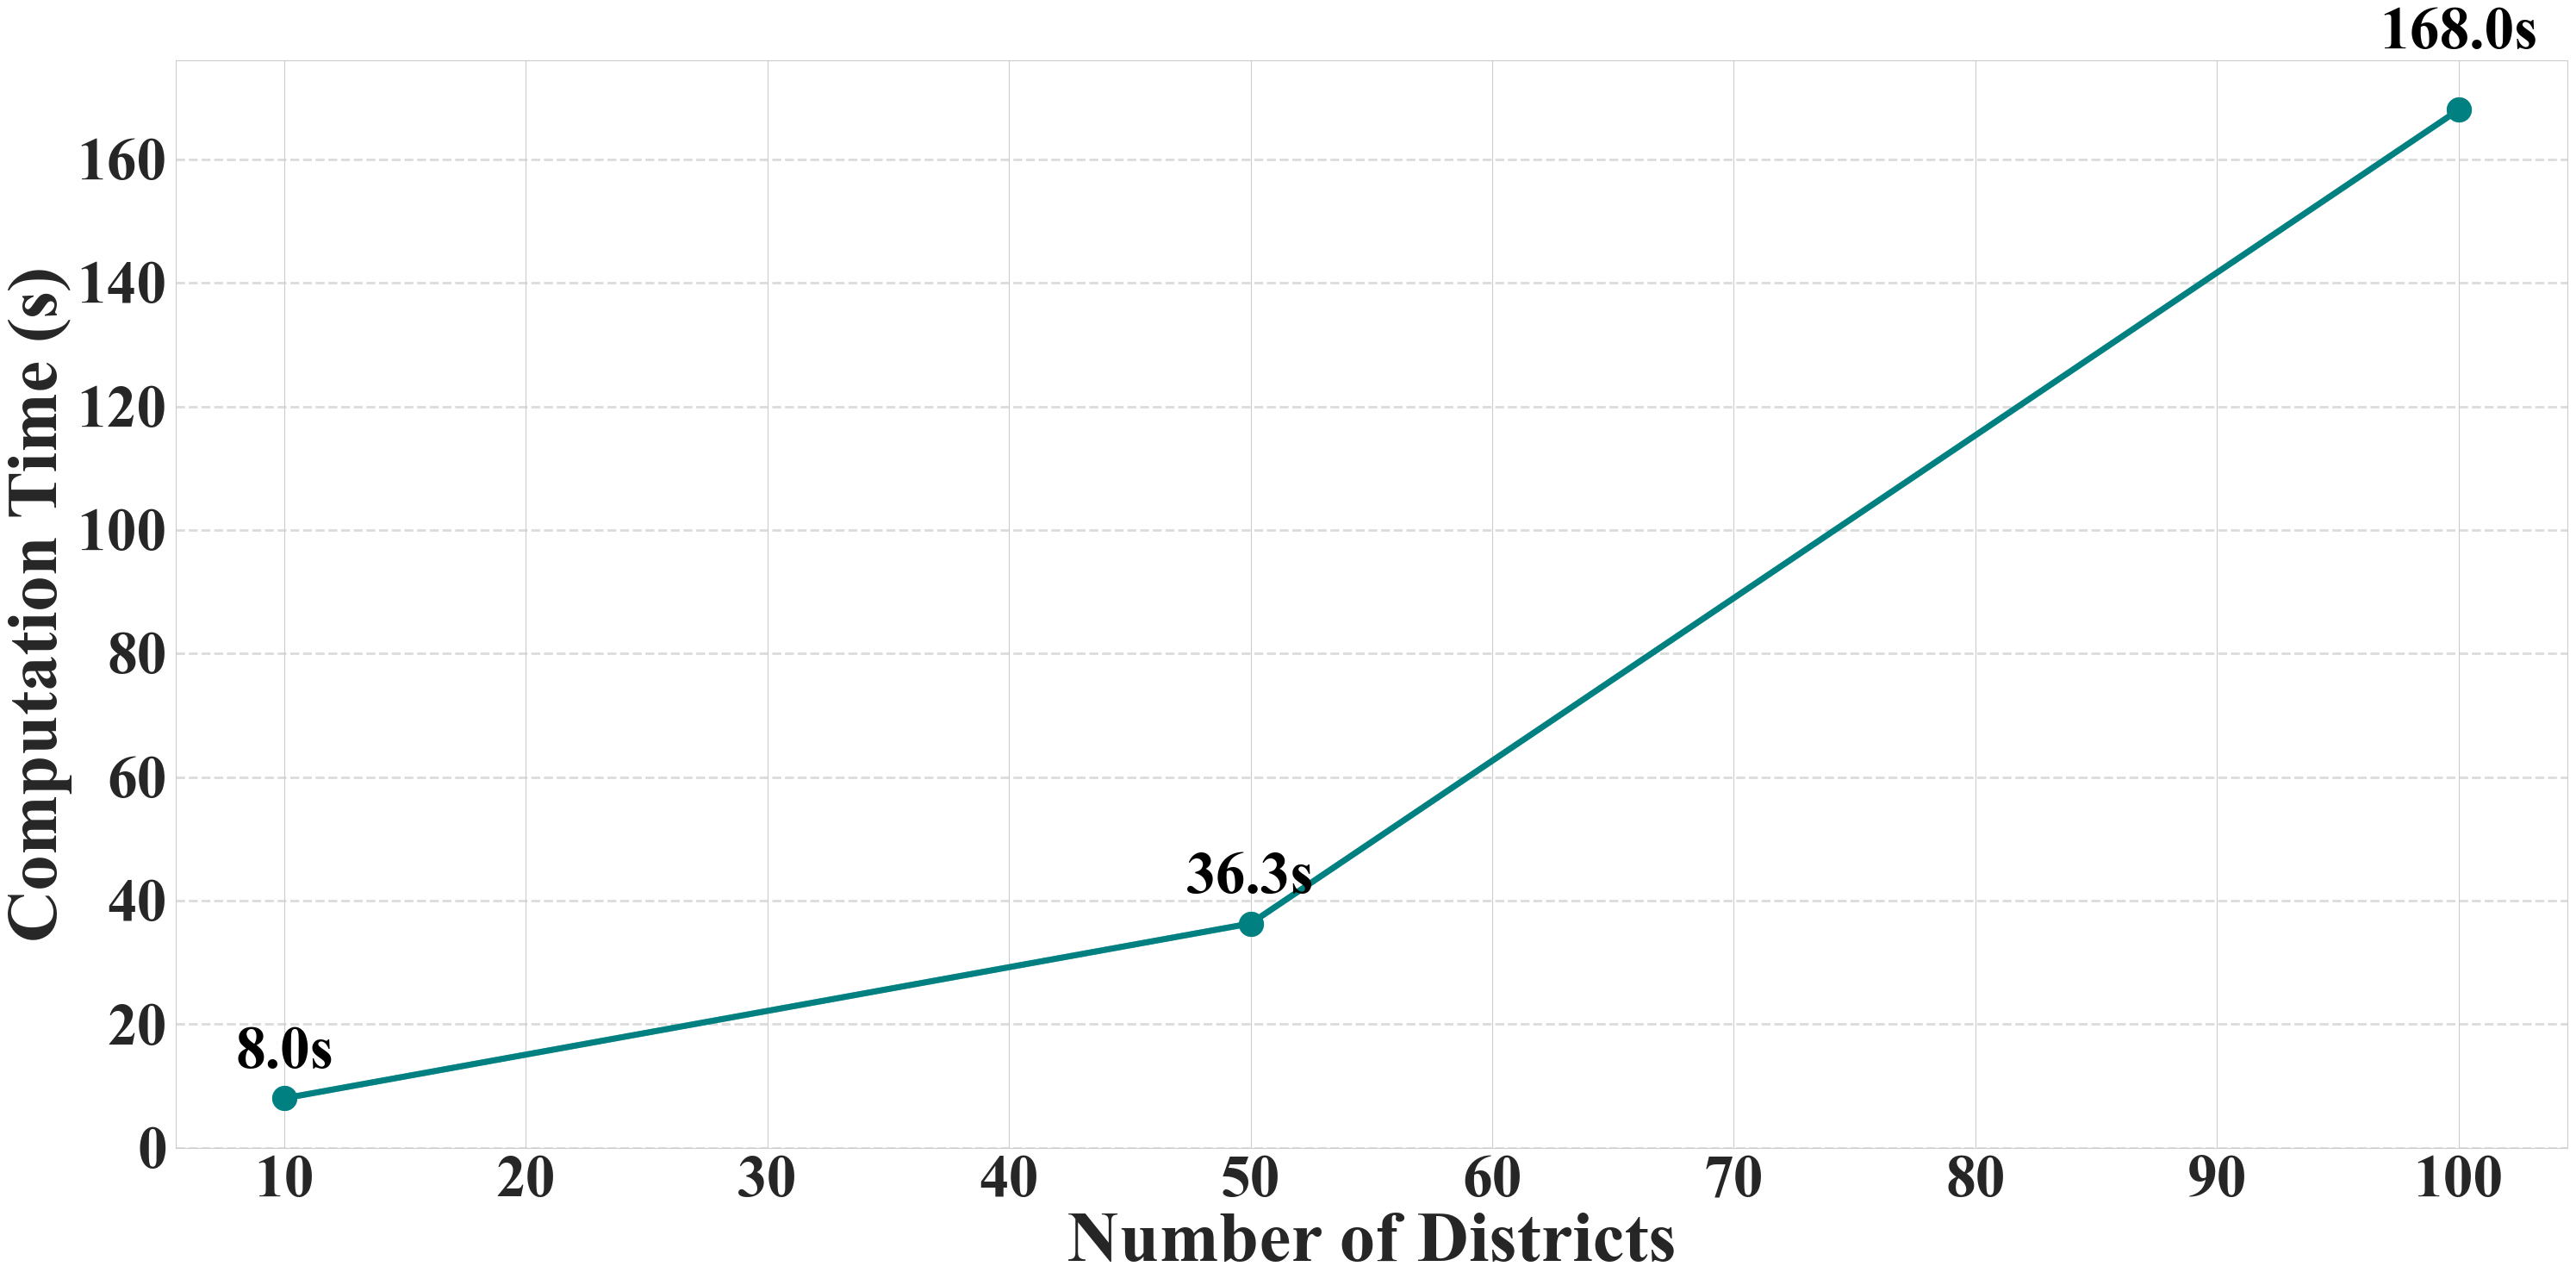

   Districts  Computation_Time
0         10               8.0
1         50              36.3
2        100             168.0


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

def plot_computation_time_line(computation_df, save_dir='plots'):
    """
    Plots the Computation Time against the number of districts as a connected line plot with markers.
    
    Parameters:
    - computation_df: Pandas DataFrame containing 'Districts' and 'Computation_Time'.
    - save_dir: Directory to save the plot PDF.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Set global font settings for Times New Roman and other stylistic parameters
    rcParams.update({
        'font.family': 'Times New Roman',
        'axes.labelweight': 'bold',
        'axes.titlesize': 80,
        'axes.labelsize': 60,
        'xtick.labelsize': 50,
        'ytick.labelsize': 50,
        'legend.fontsize': 50,
        'legend.title_fontsize': 60,
        'figure.titlesize': 80,
        'lines.markersize': 20,
        'lines.linewidth': 5,
    })
    
    # Initialize the matplotlib figure
    plt.figure(figsize=(30, 15))
    
    # Plot the line with markers
    plt.plot(
        computation_df['Districts'], 
        computation_df['Computation_Time'], 
        marker='o', 
        linestyle='-', 
        color='teal', 
        label='Computation Time'
    )
    
    # Customize plot title and labels with Times New Roman, large font sizes
   # plt.title('Computation Time Across Number of Districts in TAS', fontsize=80, fontweight='bold')
    plt.xlabel('Number of Districts', fontsize=60, fontweight='bold')
    plt.ylabel('Computation Time (s)', fontsize=60, fontweight='bold')
    
    # Customize x-axis and y-axis tick labels with Times New Roman, large font sizes
    plt.xticks(fontsize=50, fontweight='bold')
    plt.yticks(fontsize=50, fontweight='bold')
    
    # Annotate each data point with its computation time
    for idx, row in computation_df.iterrows():
        # Adjust y-position for better visibility
        y_pos = row['Computation_Time'] + 5 if row['Districts'] != 100 else row['Computation_Time'] + 10
        plt.text(
            row['Districts'], 
            y_pos, 
            f"{row['Computation_Time']}s", 
            color='black', 
            ha="center", 
            fontsize=50, 
            fontweight='bold'
        )
    
    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', linewidth=2, alpha=0.7)
    
    # Add a legend with larger font size
    #plt.legend()
    
    # Ensure the x-axis has integer ticks
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Enhance the plot with a subtle shadow behind the line
    # (Optional: You can comment this out if not desired)
    plt.plot(
        computation_df['Districts'], 
        computation_df['Computation_Time'], 
        marker='o', 
        linestyle='-', 
        color='teal', 
        linewidth=5, 
        alpha=0.5, 
        label='_nolegend_'
    )
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    # Save the plot as a high-resolution PDF
    save_path = os.path.join(save_dir, 'Computation_Time_TAS.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
    
    # Display the plot
    plt.show()
    
    # Close the plot to free memory
    plt.close()

def main_plot_computation_time_fancy():
    """
    Main function to plot the Computation Time results as a connected line plot with enhancements.
    """
    # Define the Computation Time data
    data = {
        'Districts': [10, 50, 100],
        'Computation_Time': [8, 36.3, 168]
    }
    
    computation_df = pd.DataFrame(data)
    
    # Plot the Computation Time
    plot_computation_time_line(computation_df)
    
    # Optionally, save the Computation Time DataFrame to CSV
    computation_df.to_csv('computation_time_results_TAS.csv', index=False)
    
    # Display Computation Time Results
    print(computation_df)

if __name__ == "__main__":
    main_plot_computation_time_fancy()
